<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/relatorio_aprendizado_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por Reforço - Avaliação Final


O aprendizado por reforço é uma subárea da inteligência artificial que busca treinar agentes para tomar decisões em ambientes interativos com o objetivo de maximizar uma recompensa acumulada ao longo do tempo. Diferente de métodos supervisionados, onde há dados rotulados para guiar o aprendizado, no aprendizado por reforço o agente explora o ambiente por meio de tentativa e erro, ajustando suas ações com base no feedback recebido na forma de recompensas ou penalidades. Esse processo ocorre em um ciclo contínuo de interação, no qual o agente observa o estado do ambiente, toma uma ação, recebe uma recompensa e atualiza sua estratégia, aprendendo gradualmente a executar comportamentos que levam a melhores resultados.

Dentre os algoritmos mais conhecidos de aprendizado por reforço estão o SARSA e o Q-Learning, que utilizam a chamada tabela Q para armazenar e atualizar os valores associados a pares de estado e ação. O SARSA (State-Action-Reward-State-Action) é um algoritmo on-policy, o que significa que ele atualiza os valores Q com base na política atual, considerando a sequência de ações efetivamente escolhidas pelo agente. Já o Q-Learning é um método off-policy, onde a atualização dos valores Q se baseia na ação com maior recompensa esperada, independentemente da política seguida no momento. Enquanto o SARSA tende a ser mais conservador e adequado para cenários com riscos elevados, o Q-Learning é mais exploratório e busca estratégias otimizadas globalmente, sendo amplamente utilizado em diversas aplicações, como jogos, controle de sistemas e robótica.

Nesse notebook estão exemplos de aplicações com ambas as técnicas na biblioteca python Gymnasium. Os ambientes explorados são o `Frozen Lake`, onde o agente precisa alcançar um objetivo sem cair em buracos em um ambiente baseado em grade, e o `Cart Pole`, cujo objetivo é balancear um pêndulo invertido sobre um carrinho movendo-o para a esquerda ou direita.

## `Frozen Lake`

No `Frozen Lake`, o objetivo é atravessar um lago congelado do ponto S ao objetivo G sem cair em qualquer buraco H ao longo dos espaço F do território. Se a natureza do ambiente for escorregadia (`slippery`), o agente pode tomar direções não calculadas.

O agente recebe 1 vetor para suas ações. O espaço de ação é definido por `(dir)`, que define a direção a seguir a partir das opções:

* 0: ESQUERDA
* 1: ABAIXO
* 2: DIREITA
* 3: ACIMA

A observação é um valor que represente a posição atual do agente e é definido por `current_row * nrows + current_col`, ou seja, a linha atual vezes a quantidade de linhas mais a coluna atual.

As recompensas são definidas como:

* Objetivo(G): +1
* Buraco(H): 0
* Congelado(F): 0

### Configuração do ambiente

In [129]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [130]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd

In [131]:

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [132]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Criação e inspeção do ambiente Frozen Lake.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFF', 'FFFFFFFF', 'HFFFHHFF', 'FFFFHFFF', 'FFFFFFFF', 'FHFFFFFF', 'FFFFFFFF', 'FFFFFFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

In [133]:
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


In [134]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

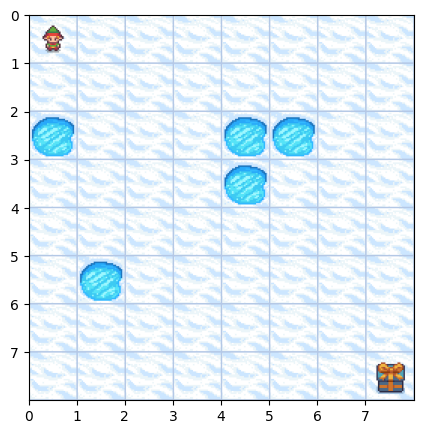

In [135]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

Executamos ações aleatórias para testar o ambiente

In [136]:
print("passo número : ação, posição, recompensa, terminado, truncado, {info}")

for i in range(20):
    # Amostra aleatória de ação válida
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("passo", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

passo número : ação, posição, recompensa, terminado, truncado, {info}
passo 1 : 0 , move left , 0 , 0.0 , False , False , {'prob': 1.0}
passo 2 : 1 , move down , 8 , 0.0 , False , False , {'prob': 1.0}
passo 3 : 1 , move down , 16 , 0.0 , True , False , {'prob': 1.0}


In [137]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 77 : move right , 28 , 0.0 , True , False , {'prob': 1.0}


In [138]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Criando uma estratégia SARSA ou Q-Learning tabular para o Frozen Lake

A classe a seguir

In [139]:
class FrozenLakeAgent:
    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(100785)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [140]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [141]:
def record_trained_video(agent, video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [176]:
def save_imgs(training_error, rewards, accuracies, steps, filename):
  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
from tqdm import tqdm
def train_agent(agent, is_using_Sarsa):
  #Create lists to contain total rewards, steps and accurracy per episode
  accuracies = []
  mean_rewards = []
  rewards = []
  steps = []
  total_steps = 0

  for episode_count in tqdm(range(nb_max_episodes)):
      state, info = env.reset()
      is_terminal = False
      total_reward = 0
      episode_step = 0

      if(is_using_Sarsa): # Sarsa
          # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
          action = agent.choose_action(state)

      # The Q-Table training
      while not is_terminal:
          episode_step += 1

          if(not is_using_Sarsa): # Q-learning
              # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
              action = agent.choose_action(state)

          # Play best or random move and get new state and reward from environment
          next_state, reward, terminated, truncated, info = env.step(action)
          is_terminal = terminated or truncated

          # update the agent
          if(not is_using_Sarsa): # Q-learning
              agent.update(state, action, reward, terminated, next_state, None)
          else: # Sarsa
              next_action = agent.choose_action(next_state)
              agent.update(state, action, reward, terminated, next_state, next_action)
              action = next_action

          # update the current observation
          state = next_state
          total_steps += 1
          total_reward += reward

      agent.decay_epsilon()

      mean_rewards.append(total_reward)
      if (episode_count+1) % test_freq == 0:
          accur = test_accurracy(agent, env.spec.max_episode_steps,50)
          accuracies.append(accur)

          print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
          mean_rewards.clear()

      rewards.append(total_reward)
      steps.append(episode_step)

  after_training = "after_training_sarsa.mp4" if is_using_Sarsa else "after_training_q.mp4"
  record_trained_video(agent, after_training, env.spec.max_episode_steps)
  env.close()
  return after_training, rewards, steps, accuracies



In [144]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 10000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent_sarsa = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = True
)

agent_q = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = False
)


Using Sarsa method
Using Q-learning method


In [156]:
from itertools import product

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [205]:
alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

In [206]:
len(list(product(*[alphas, epsilons, gammas])))

27

In [210]:
df_experiments = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha} e epsilon {epsilon}')
            agent_sarsa = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
            )

            agent_q = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )

            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            error = agent_sarsa.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            error = agent_q.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments)}')


Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 184/10000 [00:00<00:21, 457.98it/s]

step: 2196, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 292/10000 [00:00<00:21, 444.67it/s]

step: 4032, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:23, 412.35it/s]

step: 6095, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 7989, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1839999999999951


  6%|▌         | 579/10000 [00:01<00:19, 477.31it/s]

step: 9911, episode: 500, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:19, 482.40it/s]

step: 11884, episode: 600, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 13675, episode: 700, accuracy training: 0.07, accuracy test: 0.42, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:13, 680.79it/s]

step: 15364, episode: 800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 17013, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:02<00:11, 788.44it/s]

step: 18671, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 20213, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:02<00:10, 857.42it/s]

step: 21822, episode: 1200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 23431, episode: 1300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1500/10000 [00:02<00:10, 846.67it/s]

step: 25023, episode: 1400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 26617, episode: 1500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:02<00:09, 855.96it/s]

step: 28161, episode: 1600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 29721, episode: 1700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:02<00:08, 905.63it/s]

step: 31238, episode: 1800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 32740, episode: 1900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 34229, episode: 2000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2200/10000 [00:03<00:08, 921.66it/s]

step: 35801, episode: 2100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 37322, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:03<00:08, 895.37it/s]

step: 38921, episode: 2300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 40436, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:03<00:08, 873.02it/s]

step: 41909, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 43407, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:03<00:07, 910.89it/s]

step: 44980, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 46484, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:07, 900.58it/s]

step: 47972, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 49478, episode: 3000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:04<00:07, 915.21it/s]

step: 51031, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 52531, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:04<00:07, 899.80it/s]

step: 54077, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 55565, episode: 3400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:04<00:06, 924.70it/s]

step: 57094, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 58610, episode: 3600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 60118, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:05<00:06, 926.05it/s]

step: 61620, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63139, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:05<00:06, 913.74it/s]

step: 64666, episode: 4000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 66192, episode: 4100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:05<00:06, 900.77it/s]

step: 67720, episode: 4200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 69256, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:05<00:06, 900.52it/s]

step: 70760, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 72282, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:06<00:05, 919.66it/s]

step: 73810, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 75328, episode: 4700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:06<00:05, 915.09it/s]

step: 76821, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 78283, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5100/10000 [00:06<00:05, 885.28it/s]

step: 79795, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 81310, episode: 5100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:06<00:05, 902.93it/s]

step: 82804, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 84257, episode: 5300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:06<00:04, 900.04it/s]

step: 85751, episode: 5400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 87279, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:04, 907.16it/s]

step: 88743, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 90194, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:07<00:04, 932.53it/s]

step: 91740, episode: 5800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 93275, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:07<00:04, 895.96it/s]

step: 94790, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 96313, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:07<00:04, 880.78it/s]

step: 97814, episode: 6200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 99322, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:08<00:03, 901.92it/s]

step: 100778, episode: 6400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 102327, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:08<00:03, 908.15it/s]

step: 103873, episode: 6600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 105410, episode: 6700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:08<00:03, 887.47it/s]

step: 106911, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 108401, episode: 6900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:08<00:03, 885.97it/s]

step: 109925, episode: 7000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 111449, episode: 7100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:08<00:03, 886.55it/s]

step: 112979, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 114484, episode: 7300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:09<00:02, 908.00it/s]

step: 116033, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 117529, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:09<00:02, 863.25it/s]

step: 119061, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 120610, episode: 7700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:09<00:02, 871.02it/s]

step: 122109, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 123602, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:09<00:02, 878.14it/s]

step: 125154, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 126601, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:10<00:01, 922.34it/s]

step: 128034, episode: 8200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 129517, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:10<00:01, 867.27it/s]

step: 131045, episode: 8400, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 132582, episode: 8500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:10<00:01, 848.55it/s]

step: 134073, episode: 8600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 135572, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:10<00:01, 884.94it/s]

step: 137078, episode: 8800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 138572, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:10<00:00, 902.90it/s]

step: 140139, episode: 9000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 141641, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:11<00:00, 918.30it/s]

step: 143103, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 144631, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:11<00:00, 887.29it/s]

step: 146156, episode: 9400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 147630, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9684/10000 [00:11<00:00, 785.33it/s]

step: 149053, episode: 9600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 150534, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9905/10000 [00:12<00:00, 636.59it/s]

step: 152019, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 153486, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:12<00:00, 814.92it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 155023, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


<ipython-input-210-016815bcd5a7>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
  2%|▏         | 166/10000 [00:00<00:21, 462.34it/s]

step: 2065, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 269/10000 [00:00<00:21, 452.74it/s]

step: 3990, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 376/10000 [00:00<00:20, 475.11it/s]

step: 5896, episode: 300, accuracy training: 0.05, accuracy test: 0.04, random move probability: 0.18799999999999634


  5%|▌         | 500/10000 [00:01<00:21, 438.11it/s]

step: 7751, episode: 400, accuracy training: 0.05, accuracy test: 0.32, random move probability: 0.1839999999999951
step: 9211, episode: 500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 690/10000 [00:01<00:17, 523.86it/s]

step: 10740, episode: 600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 12203, episode: 700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▊         | 870/10000 [00:01<00:16, 552.30it/s]

step: 13650, episode: 800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 15176, episode: 900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1059/10000 [00:02<00:19, 460.94it/s]

step: 16689, episode: 1000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1154/10000 [00:02<00:22, 388.61it/s]

step: 18178, episode: 1100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1310/10000 [00:02<00:19, 441.66it/s]

step: 19633, episode: 1200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 21020, episode: 1300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▍        | 1491/10000 [00:03<00:13, 650.57it/s]

step: 22474, episode: 1400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 23959, episode: 1500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1745/10000 [00:03<00:10, 784.63it/s]

step: 25392, episode: 1600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 26877, episode: 1700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1913/10000 [00:03<00:09, 809.53it/s]

step: 28373, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 29940, episode: 1900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:03<00:09, 866.96it/s]

step: 31407, episode: 2000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 32831, episode: 2100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2300/10000 [00:04<00:09, 848.94it/s]

step: 34240, episode: 2200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 35713, episode: 2300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2500/10000 [00:04<00:08, 866.93it/s]

step: 37135, episode: 2400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 38590, episode: 2500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:04<00:08, 888.72it/s]

step: 40030, episode: 2600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 41460, episode: 2700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:04<00:07, 899.99it/s]

step: 42904, episode: 2800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 44317, episode: 2900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:04<00:07, 923.61it/s]

step: 45767, episode: 3000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 47255, episode: 3100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:05<00:07, 867.26it/s]

step: 48710, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 50129, episode: 3300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:05<00:07, 883.38it/s]

step: 51528, episode: 3400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 52997, episode: 3500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3803/10000 [00:05<00:06, 937.93it/s]

step: 54460, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 55807, episode: 3700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1
step: 57274, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:05<00:06, 930.34it/s]

step: 58642, episode: 3900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 60117, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4281/10000 [00:06<00:06, 874.10it/s]

step: 61664, episode: 4100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 63094, episode: 4200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4460/10000 [00:06<00:06, 877.05it/s]

step: 64572, episode: 4300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 66000, episode: 4400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 46%|████▋     | 4647/10000 [00:06<00:05, 904.46it/s]

step: 67445, episode: 4500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 68884, episode: 4600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4830/10000 [00:06<00:05, 891.27it/s]

step: 70320, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 71793, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5011/10000 [00:07<00:05, 835.84it/s]

step: 73269, episode: 4900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 74687, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:07<00:05, 856.18it/s]

step: 76127, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 77601, episode: 5200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5402/10000 [00:07<00:05, 904.76it/s]

step: 79001, episode: 5300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 80373, episode: 5400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:07<00:04, 911.18it/s]

step: 81813, episode: 5500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 83269, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5800/10000 [00:07<00:04, 917.67it/s]

step: 84739, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 86164, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5997/10000 [00:08<00:04, 924.65it/s]

step: 87555, episode: 5900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 89063, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6276/10000 [00:08<00:04, 918.18it/s]

step: 90483, episode: 6100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 91950, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6458/10000 [00:08<00:04, 847.23it/s]

step: 93392, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 94887, episode: 6400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 66%|██████▋   | 6626/10000 [00:08<00:04, 779.10it/s]

step: 96369, episode: 6500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 97820, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6798/10000 [00:09<00:03, 818.33it/s]

step: 99281, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 100753, episode: 6800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7056/10000 [00:09<00:03, 839.09it/s]

step: 102244, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 103722, episode: 7000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7235/10000 [00:09<00:03, 865.23it/s]

step: 105201, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 106641, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7417/10000 [00:09<00:02, 887.29it/s]

step: 108089, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 109506, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:10<00:02, 819.75it/s]

step: 110967, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 112457, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7846/10000 [00:10<00:02, 793.53it/s]

step: 113912, episode: 7700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 115412, episode: 7800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8010/10000 [00:10<00:02, 803.05it/s]

step: 116897, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 118366, episode: 8000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:10<00:02, 852.83it/s]

step: 119870, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 121346, episode: 8200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:11<00:01, 848.10it/s]

step: 122862, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 124356, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8667/10000 [00:11<00:01, 791.22it/s]

step: 125852, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 127333, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8836/10000 [00:11<00:01, 814.92it/s]

step: 128819, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 130288, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9011/10000 [00:11<00:01, 844.65it/s]

step: 131774, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 133245, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9184/10000 [00:12<00:01, 788.32it/s]

step: 134730, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 136232, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:12<00:01, 573.14it/s]

step: 137737, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 139193, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:12<00:00, 556.90it/s]

step: 140715, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 142198, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:13<00:00, 544.16it/s]

step: 143677, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 145163, episode: 9800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 739.51it/s]

step: 146582, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 148120, episode: 10000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 2
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 188/10000 [00:00<00:18, 521.43it/s]

step: 2044, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  2%|▏         | 244/10000 [00:00<00:22, 427.49it/s]

step: 3881, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▎         | 363/10000 [00:00<00:21, 448.41it/s]

step: 5882, episode: 300, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.18799999999999634


  5%|▍         | 481/10000 [00:01<00:20, 464.48it/s]

step: 7898, episode: 400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 9715, episode: 500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:14, 631.72it/s]

step: 11589, episode: 600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 13294, episode: 700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:12, 756.74it/s]

step: 14826, episode: 800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 16416, episode: 900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.163999999999989


 12%|█▏        | 1180/10000 [00:01<00:10, 858.32it/s]

step: 17972, episode: 1000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 19492, episode: 1100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15599999999998654


 14%|█▎        | 1350/10000 [00:02<00:10, 811.13it/s]

step: 21045, episode: 1200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 22544, episode: 1300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1534/10000 [00:02<00:09, 869.80it/s]

step: 24060, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 25615, episode: 1500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1715/10000 [00:02<00:09, 881.46it/s]

step: 27118, episode: 1600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 28620, episode: 1700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:02<00:09, 849.94it/s]

step: 30096, episode: 1800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 31650, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:03<00:09, 859.67it/s]

step: 33194, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 34713, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 24%|██▍       | 2378/10000 [00:03<00:09, 836.01it/s]

step: 36179, episode: 2200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 37747, episode: 2300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2548/10000 [00:03<00:09, 823.08it/s]

step: 39275, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 40825, episode: 2500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2717/10000 [00:03<00:09, 781.53it/s]

step: 42322, episode: 2600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 43841, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:04<00:08, 832.39it/s]

step: 45344, episode: 2800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 46843, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:04<00:08, 860.22it/s]

step: 48373, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 49922, episode: 3100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:04<00:07, 896.11it/s]

step: 51404, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 52942, episode: 3300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:04<00:07, 870.99it/s]

step: 54478, episode: 3400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 56014, episode: 3500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:04<00:07, 886.32it/s]

step: 57517, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 59095, episode: 3700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:05<00:07, 869.25it/s]

step: 60643, episode: 3800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 62116, episode: 3900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:05<00:06, 862.66it/s]

step: 63646, episode: 4000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 65184, episode: 4100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:05<00:06, 910.60it/s]

step: 66652, episode: 4200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 68143, episode: 4300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4569/10000 [00:05<00:06, 860.67it/s]

step: 69665, episode: 4400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 71211, episode: 4500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4741/10000 [00:06<00:06, 814.52it/s]

step: 72750, episode: 4600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 74272, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4930/10000 [00:06<00:05, 882.04it/s]

step: 75792, episode: 4800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 77269, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5107/10000 [00:06<00:05, 867.38it/s]

step: 78759, episode: 5000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 80255, episode: 5100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:06<00:05, 860.15it/s]

step: 81756, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 83278, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:06<00:05, 850.80it/s]

step: 84799, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 86358, episode: 5500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:04, 862.67it/s]

step: 87880, episode: 5600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 89377, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:07<00:04, 883.18it/s]

step: 90921, episode: 5800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 92461, episode: 5900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:07<00:04, 867.98it/s]

step: 93948, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 95471, episode: 6100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:07<00:04, 902.78it/s]

step: 96924, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 98422, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:08<00:03, 921.78it/s]

step: 99901, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 101409, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:08<00:03, 908.90it/s]

step: 102903, episode: 6600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 104390, episode: 6700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:08<00:03, 927.95it/s]

step: 105833, episode: 6800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 107315, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:08<00:03, 873.80it/s]

step: 108831, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 110370, episode: 7100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:08<00:02, 907.36it/s]

step: 111872, episode: 7200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 113367, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:09<00:02, 882.98it/s]

step: 114887, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 116408, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:09<00:02, 900.14it/s]

step: 117936, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 119461, episode: 7700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:09<00:02, 863.99it/s]

step: 120981, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 122489, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:09<00:02, 893.29it/s]

step: 124017, episode: 8000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 125528, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:10<00:01, 897.73it/s]

step: 127093, episode: 8200, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 128613, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:10<00:01, 911.70it/s]

step: 130123, episode: 8400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 131583, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:10<00:01, 890.72it/s]

step: 133111, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 134621, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8976/10000 [00:10<00:01, 900.52it/s]

step: 136132, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 137646, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9157/10000 [00:11<00:00, 887.11it/s]

step: 139194, episode: 9000, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 140744, episode: 9100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9246/10000 [00:11<00:01, 728.52it/s]

step: 142248, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 143802, episode: 9300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9534/10000 [00:11<00:00, 582.07it/s]

step: 145335, episode: 9400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 146859, episode: 9500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9685/10000 [00:12<00:00, 628.36it/s]

step: 148373, episode: 9600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 149919, episode: 9700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9892/10000 [00:12<00:00, 628.21it/s]

step: 151416, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 152924, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:12<00:00, 790.67it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 154444, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 171/10000 [00:00<00:21, 453.04it/s]

step: 2072, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 282/10000 [00:00<00:23, 417.30it/s]

step: 4081, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 387/10000 [00:00<00:22, 432.44it/s]

step: 6067, episode: 300, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.18799999999999634


  5%|▍         | 488/10000 [00:01<00:22, 423.59it/s]

step: 8037, episode: 400, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:01<00:21, 441.32it/s]

step: 9810, episode: 500, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.1799999999999939
step: 11281, episode: 600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 800/10000 [00:01<00:14, 640.71it/s]

step: 12978, episode: 700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14631, episode: 800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1679999999999902


 11%|█         | 1061/10000 [00:01<00:12, 738.24it/s]

step: 16362, episode: 900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.163999999999989
step: 17992, episode: 1000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1217/10000 [00:02<00:12, 724.45it/s]

step: 19673, episode: 1100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 21319, episode: 1200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1400/10000 [00:02<00:10, 789.46it/s]

step: 22981, episode: 1300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 24585, episode: 1400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1600/10000 [00:02<00:10, 838.86it/s]

step: 26162, episode: 1500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 27752, episode: 1600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:02<00:09, 874.78it/s]

step: 29335, episode: 1700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 30867, episode: 1800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12799999999997796


 21%|██        | 2073/10000 [00:03<00:09, 848.54it/s]

step: 32457, episode: 1900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 33965, episode: 2000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2245/10000 [00:03<00:09, 832.21it/s]

step: 35507, episode: 2100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 37067, episode: 2200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2418/10000 [00:03<00:09, 828.49it/s]

step: 38517, episode: 2300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 40022, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:03<00:08, 828.57it/s]

step: 41573, episode: 2500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 43115, episode: 2600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2786/10000 [00:04<00:08, 849.46it/s]

step: 44653, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 46161, episode: 2800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3040/10000 [00:04<00:08, 789.15it/s]

step: 47714, episode: 2900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 49238, episode: 3000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3211/10000 [00:04<00:08, 822.36it/s]

step: 50790, episode: 3100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 52313, episode: 3200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:04<00:07, 858.88it/s]

step: 53863, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 55343, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3600/10000 [00:05<00:07, 816.64it/s]

step: 56856, episode: 3500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 58352, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3800/10000 [00:05<00:07, 862.14it/s]

step: 59842, episode: 3700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 61347, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:05<00:06, 870.61it/s]

step: 62889, episode: 3900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 64370, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:05<00:06, 887.42it/s]

step: 65842, episode: 4100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 67369, episode: 4200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:05<00:06, 879.26it/s]

step: 68854, episode: 4300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 70388, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4672/10000 [00:06<00:06, 856.67it/s]

step: 71951, episode: 4500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 73448, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4847/10000 [00:06<00:06, 857.12it/s]

step: 74992, episode: 4700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 76500, episode: 4800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5018/10000 [00:06<00:05, 836.96it/s]

step: 78016, episode: 4900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 79567, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5283/10000 [00:07<00:05, 850.24it/s]

step: 81109, episode: 5100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 82635, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5458/10000 [00:07<00:05, 808.59it/s]

step: 84139, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 85654, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 56%|█████▋    | 5631/10000 [00:07<00:05, 825.97it/s]

step: 87192, episode: 5500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 88707, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5800/10000 [00:07<00:05, 827.86it/s]

step: 90187, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 91739, episode: 5800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5998/10000 [00:07<00:04, 892.13it/s]

step: 93214, episode: 5900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 94726, episode: 6000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6255/10000 [00:08<00:04, 770.50it/s]

step: 96241, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 97748, episode: 6200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6422/10000 [00:08<00:04, 786.69it/s]

step: 99178, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 100667, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6600/10000 [00:08<00:04, 815.19it/s]

step: 102202, episode: 6500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 103716, episode: 6600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6800/10000 [00:08<00:03, 869.85it/s]

step: 105236, episode: 6700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 106763, episode: 6800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6993/10000 [00:09<00:03, 888.30it/s]

step: 108237, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 109708, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7252/10000 [00:09<00:03, 833.14it/s]

step: 111196, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 112702, episode: 7200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7429/10000 [00:09<00:03, 816.15it/s]

step: 114216, episode: 7300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 115695, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7601/10000 [00:09<00:02, 836.86it/s]

step: 117172, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 118655, episode: 7600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:10<00:02, 820.27it/s]

step: 120124, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 121645, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:10<00:02, 824.75it/s]

step: 123127, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 124614, episode: 8000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:10<00:02, 868.41it/s]

step: 126106, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 127639, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:10<00:01, 883.77it/s]

step: 129096, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 130626, episode: 8400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:10<00:01, 900.92it/s]

step: 132133, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 133652, episode: 8600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:11<00:01, 853.57it/s]

step: 135116, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 136635, episode: 8800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9000/10000 [00:11<00:01, 857.41it/s]

step: 138136, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 139579, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9169/10000 [00:11<00:01, 714.62it/s]

step: 141076, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 142575, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▎| 9374/10000 [00:12<00:01, 610.37it/s]

step: 144046, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:12<00:00, 520.25it/s]

step: 145553, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 146989, episode: 9500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:12<00:00, 559.49it/s]

step: 148525, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 149979, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9902/10000 [00:13<00:00, 581.58it/s]

step: 151458, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 152883, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 754.76it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 154392, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 4
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 168/10000 [00:00<00:20, 473.91it/s]

step: 2171, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 283/10000 [00:00<00:20, 484.26it/s]

step: 4047, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 394/10000 [00:00<00:19, 484.17it/s]

step: 5920, episode: 300, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.18799999999999634


  4%|▍         | 445/10000 [00:00<00:22, 431.45it/s]

step: 7894, episode: 400, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.1839999999999951


  6%|▌         | 567/10000 [00:01<00:21, 437.84it/s]

step: 9931, episode: 500, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1799999999999939


  7%|▋         | 683/10000 [00:01<00:19, 468.88it/s]

step: 11781, episode: 600, accuracy training: 0.04, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 13472, episode: 700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:15, 588.00it/s]

step: 15357, episode: 800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 17338, episode: 900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█▏        | 1128/10000 [00:02<00:13, 680.67it/s]

step: 19263, episode: 1000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 21153, episode: 1100, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1288/10000 [00:02<00:11, 733.82it/s]

step: 23060, episode: 1200, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 24993, episode: 1300, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1513/10000 [00:02<00:11, 720.24it/s]

step: 26835, episode: 1400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 28777, episode: 1500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1686/10000 [00:02<00:11, 753.16it/s]

step: 30621, episode: 1600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 32471, episode: 1700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1912/10000 [00:03<00:10, 736.26it/s]

step: 34273, episode: 1800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 36033, episode: 1900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2093/10000 [00:03<00:09, 809.55it/s]

step: 37681, episode: 2000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 39287, episode: 2100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2344/10000 [00:03<00:09, 814.32it/s]

step: 40877, episode: 2200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 42465, episode: 2300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2505/10000 [00:04<00:10, 733.82it/s]

step: 44249, episode: 2400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 46077, episode: 2500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:04<00:09, 774.24it/s]

step: 47818, episode: 2600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 49479, episode: 2700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2897/10000 [00:04<00:08, 831.02it/s]

step: 51269, episode: 2800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 52952, episode: 2900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3072/10000 [00:04<00:08, 819.41it/s]

step: 54508, episode: 3000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 56283, episode: 3100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3303/10000 [00:05<00:09, 706.37it/s]

step: 57923, episode: 3200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 59687, episode: 3300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:05<00:08, 777.53it/s]

step: 61402, episode: 3400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 62946, episode: 3500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:05<00:07, 800.06it/s]

step: 64613, episode: 3600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 66165, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:05<00:07, 813.02it/s]

step: 67727, episode: 3800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 69452, episode: 3900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:06<00:07, 809.80it/s]

step: 70989, episode: 4000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 72537, episode: 4100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:06<00:06, 850.73it/s]

step: 74092, episode: 4200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 75660, episode: 4300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:06<00:06, 880.28it/s]

step: 77222, episode: 4400, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 78758, episode: 4500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:06<00:06, 860.87it/s]

step: 80308, episode: 4600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 81878, episode: 4700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:06<00:06, 846.12it/s]

step: 83464, episode: 4800, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 84997, episode: 4900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5161/10000 [00:07<00:05, 840.97it/s]

step: 86543, episode: 5000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 88130, episode: 5100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5340/10000 [00:07<00:05, 866.16it/s]

step: 89683, episode: 5200, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 91218, episode: 5300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5512/10000 [00:07<00:05, 819.69it/s]

step: 92787, episode: 5400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 94372, episode: 5500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:05, 845.63it/s]

step: 95891, episode: 5600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 97447, episode: 5700, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5980/10000 [00:08<00:04, 880.95it/s]

step: 98978, episode: 5800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 100519, episode: 5900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6157/10000 [00:08<00:04, 871.44it/s]

step: 102087, episode: 6000, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 103624, episode: 6100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6332/10000 [00:08<00:04, 826.44it/s]

step: 105190, episode: 6200, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 106758, episode: 6300, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6503/10000 [00:08<00:04, 839.98it/s]

step: 108316, episode: 6400, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 109848, episode: 6500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6766/10000 [00:09<00:03, 860.00it/s]

step: 111368, episode: 6600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 112943, episode: 6700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6943/10000 [00:09<00:03, 853.27it/s]

step: 114499, episode: 6800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 116065, episode: 6900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7121/10000 [00:09<00:03, 865.69it/s]

step: 117610, episode: 7000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 119164, episode: 7100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:09<00:03, 807.48it/s]

step: 120776, episode: 7200, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 122358, episode: 7300, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:10<00:03, 810.22it/s]

step: 123938, episode: 7400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 125462, episode: 7500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:10<00:02, 838.11it/s]

step: 127015, episode: 7600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 128526, episode: 7700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:10<00:02, 882.31it/s]

step: 130074, episode: 7800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 131603, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:10<00:02, 850.45it/s]

step: 133165, episode: 8000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 134711, episode: 8100, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:10<00:02, 838.79it/s]

step: 136245, episode: 8200, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 137772, episode: 8300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:11<00:01, 872.58it/s]

step: 139347, episode: 8400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 140926, episode: 8500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:11<00:01, 893.06it/s]

step: 142508, episode: 8600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 144052, episode: 8700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:11<00:01, 896.93it/s]

step: 145581, episode: 8800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 147142, episode: 8900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9075/10000 [00:11<00:01, 648.24it/s]

step: 148691, episode: 9000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 91%|█████████▏| 9147/10000 [00:12<00:01, 566.48it/s]

step: 150210, episode: 9100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9280/10000 [00:12<00:01, 560.46it/s]

step: 151741, episode: 9200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 153281, episode: 9300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9485/10000 [00:12<00:00, 613.06it/s]

step: 154801, episode: 9400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 156382, episode: 9500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9694/10000 [00:13<00:00, 608.74it/s]

step: 157930, episode: 9600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 159475, episode: 9700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9896/10000 [00:13<00:00, 624.60it/s]

step: 160998, episode: 9800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 162532, episode: 9900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 731.09it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 164068, episode: 10000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  1%|▏         | 141/10000 [00:00<00:28, 348.90it/s]

step: 2281, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 252/10000 [00:00<00:25, 379.92it/s]

step: 4122, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▎         | 359/10000 [00:00<00:23, 418.13it/s]

step: 6123, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.18799999999999634


  5%|▌         | 500/10000 [00:01<00:18, 501.86it/s]

step: 7984, episode: 400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1839999999999951
step: 9909, episode: 500, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1799999999999939


  7%|▋         | 729/10000 [00:01<00:15, 601.14it/s]

step: 11504, episode: 600, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.17599999999999266
step: 13152, episode: 700, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:13, 657.20it/s]

step: 15256, episode: 800, accuracy training: 0.05, accuracy test: 0.16, random move probability: 0.1679999999999902
step: 16967, episode: 900, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:01<00:11, 763.98it/s]

step: 18677, episode: 1000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 20243, episode: 1100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:02<00:10, 823.61it/s]

step: 21812, episode: 1200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 23330, episode: 1300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1479999999999841


 16%|█▌        | 1585/10000 [00:02<00:10, 840.26it/s]

step: 24855, episode: 1400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 26454, episode: 1500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13999999999998164


 18%|█▊        | 1758/10000 [00:02<00:09, 842.58it/s]

step: 28021, episode: 1600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 29508, episode: 1700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1928/10000 [00:02<00:09, 832.47it/s]

step: 31082, episode: 1800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 32648, episode: 1900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:03<00:09, 830.20it/s]

step: 34110, episode: 2000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 35617, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2300/10000 [00:03<00:09, 791.10it/s]

step: 37147, episode: 2200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 38688, episode: 2300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2500/10000 [00:03<00:09, 829.84it/s]

step: 40229, episode: 2400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 41757, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:03<00:08, 864.59it/s]

step: 43248, episode: 2600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 44814, episode: 2700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:04<00:08, 872.56it/s]

step: 46331, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 47812, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3168/10000 [00:04<00:08, 832.07it/s]

step: 49314, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 50815, episode: 3100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3337/10000 [00:04<00:08, 824.67it/s]

step: 52358, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 53879, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3515/10000 [00:04<00:07, 847.38it/s]

step: 55402, episode: 3400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 56856, episode: 3500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:05<00:07, 817.16it/s]

step: 58372, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 59936, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3962/10000 [00:05<00:07, 796.97it/s]

step: 61470, episode: 3800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 62956, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4124/10000 [00:05<00:07, 777.50it/s]

step: 64399, episode: 4000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 65896, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:05<00:06, 826.22it/s]

step: 67434, episode: 4200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 68907, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:06<00:06, 833.02it/s]

step: 70399, episode: 4400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 71903, episode: 4500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4698/10000 [00:06<00:05, 886.43it/s]

step: 73371, episode: 4600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 74906, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4970/10000 [00:06<00:05, 862.82it/s]

step: 76383, episode: 4800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 77899, episode: 4900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 51%|█████▏    | 5145/10000 [00:06<00:05, 848.08it/s]

step: 79378, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 80912, episode: 5100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5316/10000 [00:07<00:05, 842.27it/s]

step: 82418, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 83899, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:07<00:05, 819.48it/s]

step: 85476, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 86989, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:05, 847.50it/s]

step: 88415, episode: 5600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 89907, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:07<00:04, 826.89it/s]

step: 91356, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 92814, episode: 5900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:08<00:04, 845.64it/s]

step: 94327, episode: 6000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 95867, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:08<00:04, 842.81it/s]

step: 97396, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 98930, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6561/10000 [00:08<00:04, 845.03it/s]

step: 100401, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 101876, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6728/10000 [00:08<00:04, 805.53it/s]

step: 103403, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 104924, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6904/10000 [00:08<00:03, 841.78it/s]

step: 106377, episode: 6800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 107885, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:09<00:03, 861.29it/s]

step: 109463, episode: 7000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 110951, episode: 7100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7299/10000 [00:09<00:03, 870.65it/s]

step: 112464, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 113970, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7555/10000 [00:09<00:02, 815.79it/s]

step: 115491, episode: 7400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 117004, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7729/10000 [00:09<00:02, 836.97it/s]

step: 118562, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 120095, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7901/10000 [00:10<00:02, 829.99it/s]

step: 121551, episode: 7800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 123067, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:10<00:02, 823.16it/s]

step: 124616, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 126115, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:10<00:02, 828.27it/s]

step: 127587, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 129075, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:10<00:01, 862.95it/s]

step: 130481, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 131968, episode: 8500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8697/10000 [00:11<00:01, 880.03it/s]

step: 133453, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 134931, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 89%|████████▊ | 8863/10000 [00:11<00:01, 655.27it/s]

step: 136477, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 137917, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9075/10000 [00:11<00:01, 596.96it/s]

step: 139441, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 140898, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9284/10000 [00:12<00:01, 626.70it/s]

step: 142368, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 143831, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9474/10000 [00:12<00:00, 540.32it/s]

step: 145375, episode: 9400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:12<00:00, 512.94it/s]

step: 146917, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 148372, episode: 9600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9809/10000 [00:13<00:00, 565.18it/s]

step: 149790, episode: 9700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 151296, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 740.27it/s]

step: 152799, episode: 9900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 154304, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 6
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|▏         | 131/10000 [00:00<00:20, 485.88it/s]

step: 2058, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.49600000000000155
step: 4043, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4920000000000031


  3%|▎         | 300/10000 [00:00<00:16, 582.07it/s]

step: 5870, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.48800000000000465


  5%|▌         | 500/10000 [00:00<00:13, 719.62it/s]

step: 7972, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 9673, episode: 500, accuracy training: 0.04, accuracy test: 0.02, random move probability: 0.48000000000000775


  7%|▋         | 738/10000 [00:01<00:12, 766.13it/s]

step: 11799, episode: 600, accuracy training: 0.05, accuracy test: 0.02, random move probability: 0.4760000000000093
step: 13690, episode: 700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 900/10000 [00:01<00:12, 751.84it/s]

step: 16143, episode: 800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 18363, episode: 900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1097/10000 [00:01<00:10, 834.06it/s]

step: 20379, episode: 1000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 22494, episode: 1100, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1346/10000 [00:01<00:11, 767.28it/s]

step: 24650, episode: 1200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 26710, episode: 1300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1505/10000 [00:02<00:11, 730.91it/s]

step: 28865, episode: 1400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 30916, episode: 1500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1700/10000 [00:02<00:10, 785.56it/s]

step: 32970, episode: 1600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 34904, episode: 1700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1900/10000 [00:02<00:10, 790.07it/s]

step: 36868, episode: 1800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 38773, episode: 1900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:02<00:10, 783.97it/s]

step: 40657, episode: 2000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.420000000000031
step: 42723, episode: 2100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2300/10000 [00:03<00:09, 806.32it/s]

step: 44533, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 46550, episode: 2300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:03<00:08, 843.16it/s]

step: 48504, episode: 2400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 50399, episode: 2500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2700/10000 [00:03<00:08, 820.16it/s]

step: 52345, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 54290, episode: 2700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2888/10000 [00:03<00:08, 838.65it/s]

step: 56145, episode: 2800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 57885, episode: 2900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███▏      | 3146/10000 [00:04<00:08, 773.66it/s]

step: 59751, episode: 3000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 61596, episode: 3100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3315/10000 [00:04<00:08, 809.35it/s]

step: 63442, episode: 3200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 65240, episode: 3300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:04<00:07, 841.15it/s]

step: 67020, episode: 3400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 68836, episode: 3500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3742/10000 [00:04<00:08, 696.20it/s]

step: 70638, episode: 3600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 72425, episode: 3700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3906/10000 [00:05<00:08, 754.23it/s]

step: 74149, episode: 3800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 75896, episode: 3900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4100/10000 [00:05<00:07, 826.13it/s]

step: 77601, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 79423, episode: 4100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4295/10000 [00:05<00:06, 855.34it/s]

step: 81247, episode: 4200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 82986, episode: 4300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3280000000000667


 46%|████▌     | 4558/10000 [00:05<00:07, 774.42it/s]

step: 84605, episode: 4400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 86252, episode: 4500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4737/10000 [00:06<00:06, 833.84it/s]

step: 88044, episode: 4600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 89625, episode: 4700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4909/10000 [00:06<00:06, 830.40it/s]

step: 91143, episode: 4800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 92942, episode: 4900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:06<00:05, 863.26it/s]

step: 94665, episode: 5000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 96368, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:06<00:05, 849.98it/s]

step: 98119, episode: 5200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 99794, episode: 5300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2880000000000822


 56%|█████▌    | 5557/10000 [00:07<00:05, 812.75it/s]

step: 101516, episode: 5400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 103331, episode: 5500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5732/10000 [00:07<00:05, 837.18it/s]

step: 105059, episode: 5600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 106703, episode: 5700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5910/10000 [00:07<00:04, 859.10it/s]

step: 108290, episode: 5800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 109893, episode: 5900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6097/10000 [00:07<00:04, 888.90it/s]

step: 111614, episode: 6000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 113317, episode: 6100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2560000000000946


 64%|██████▎   | 6362/10000 [00:08<00:04, 858.60it/s]

step: 114853, episode: 6200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 116543, episode: 6300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6536/10000 [00:08<00:04, 847.72it/s]

step: 118050, episode: 6400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 119649, episode: 6500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6705/10000 [00:08<00:04, 814.04it/s]

step: 121224, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 122850, episode: 6700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6900/10000 [00:08<00:03, 813.45it/s]

step: 124428, episode: 6800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 126094, episode: 6900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7093/10000 [00:08<00:03, 823.31it/s]

step: 127741, episode: 7000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 129357, episode: 7100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▎  | 7359/10000 [00:09<00:03, 849.08it/s]

step: 130979, episode: 7200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 132527, episode: 7300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7541/10000 [00:09<00:02, 879.13it/s]

step: 134082, episode: 7400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 135604, episode: 7500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7724/10000 [00:09<00:02, 887.22it/s]

step: 137129, episode: 7600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 138650, episode: 7700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7900/10000 [00:09<00:02, 800.38it/s]

step: 140280, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 141816, episode: 7900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:10<00:02, 859.76it/s]

step: 143353, episode: 8000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 144859, episode: 8100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:10<00:01, 902.66it/s]

step: 146478, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 147942, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8491/10000 [00:10<00:01, 886.22it/s]

step: 149504, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 151066, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8660/10000 [00:10<00:02, 653.41it/s]

step: 152587, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 154129, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8884/10000 [00:11<00:01, 639.26it/s]

step: 155688, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 157222, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9088/10000 [00:11<00:01, 628.03it/s]

step: 158750, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 160338, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9279/10000 [00:12<00:01, 528.74it/s]

step: 161856, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:12<00:01, 498.41it/s]

step: 163391, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 164906, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:12<00:00, 538.31it/s]

step: 166378, episode: 9500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 167875, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:12<00:00, 515.37it/s]

step: 169423, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 170930, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:13<00:00, 747.06it/s]

step: 172436, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 174001, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 224/10000 [00:00<00:13, 709.46it/s]

step: 1735, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 3638, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:13, 708.15it/s]

step: 5628, episode: 300, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 7413, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4840000000000062


  6%|▋         | 649/10000 [00:00<00:12, 749.36it/s]

step: 9264, episode: 500, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 11140, episode: 600, accuracy training: 0.03, accuracy test: 0.08, random move probability: 0.4760000000000093


  8%|▊         | 802/10000 [00:01<00:12, 734.02it/s]

step: 13065, episode: 700, accuracy training: 0.07, accuracy test: 0.54, random move probability: 0.47200000000001086
step: 14823, episode: 800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1000/10000 [00:01<00:10, 829.26it/s]

step: 16585, episode: 900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18152, episode: 1000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1190/10000 [00:01<00:10, 861.01it/s]

step: 19813, episode: 1100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 21537, episode: 1200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1433/10000 [00:01<00:11, 744.48it/s]

step: 23441, episode: 1300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 25425, episode: 1400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1612/10000 [00:02<00:10, 817.16it/s]

step: 27048, episode: 1500, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 28552, episode: 1600, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1800/10000 [00:02<00:09, 845.38it/s]

step: 30156, episode: 1700, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 31959, episode: 1800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1985/10000 [00:02<00:09, 837.95it/s]

step: 33658, episode: 1900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 35515, episode: 2000, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2228/10000 [00:02<00:09, 778.50it/s]

step: 37282, episode: 2100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 38982, episode: 2200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:03<00:09, 769.20it/s]

step: 40845, episode: 2300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 42720, episode: 2400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2657/10000 [00:03<00:08, 821.91it/s]

step: 44586, episode: 2500, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 46350, episode: 2600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2816/10000 [00:03<00:10, 704.81it/s]

step: 48109, episode: 2700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 49884, episode: 2800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:03<00:09, 748.52it/s]

step: 51790, episode: 2900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 53572, episode: 3000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3800000000000465


 33%|███▎      | 3259/10000 [00:04<00:09, 721.88it/s]

step: 55451, episode: 3100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 57160, episode: 3200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3419/10000 [00:04<00:08, 753.72it/s]

step: 58865, episode: 3300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 60525, episode: 3400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3640000000000527


 37%|███▋      | 3673/10000 [00:04<00:07, 817.94it/s]

step: 62309, episode: 3500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 64030, episode: 3600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3834/10000 [00:05<00:08, 760.27it/s]

step: 65688, episode: 3700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 67449, episode: 3800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 781.65it/s]

step: 69259, episode: 3900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 70931, episode: 4000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:05<00:06, 828.90it/s]

step: 72561, episode: 4100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 74327, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4448/10000 [00:05<00:07, 787.74it/s]

step: 76078, episode: 4300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 77833, episode: 4400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4601/10000 [00:06<00:07, 719.66it/s]

step: 79546, episode: 4500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 81348, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:06, 791.12it/s]

step: 83060, episode: 4700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 84759, episode: 4800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:06<00:06, 819.66it/s]

step: 86447, episode: 4900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.304000000000076
step: 88173, episode: 5000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30000000000007754


 53%|█████▎    | 5258/10000 [00:06<00:05, 842.32it/s]

step: 89937, episode: 5100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 91515, episode: 5200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5427/10000 [00:06<00:05, 796.64it/s]

step: 93165, episode: 5300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 94764, episode: 5400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 773.53it/s]

step: 96403, episode: 5500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 98145, episode: 5600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5794/10000 [00:07<00:05, 830.31it/s]

step: 99853, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 101500, episode: 5800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6045/10000 [00:07<00:04, 798.13it/s]

step: 103122, episode: 5900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 104800, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6205/10000 [00:08<00:04, 763.46it/s]

step: 106477, episode: 6100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 108167, episode: 6200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:08<00:04, 798.19it/s]

step: 109761, episode: 6300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 111465, episode: 6400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:08<00:04, 771.37it/s]

step: 113109, episode: 6500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 114718, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:08<00:03, 828.06it/s]

step: 116320, episode: 6700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 117880, episode: 6800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:08<00:03, 821.73it/s]

step: 119546, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 121097, episode: 7000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:09<00:03, 853.76it/s]

step: 122627, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 124263, episode: 7200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:09<00:03, 862.54it/s]

step: 125756, episode: 7300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 127335, episode: 7400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20400000000008284


 77%|███████▋  | 7659/10000 [00:09<00:02, 833.04it/s]

step: 128910, episode: 7500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 130458, episode: 7600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7826/10000 [00:09<00:02, 819.48it/s]

step: 132022, episode: 7700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 133637, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:10<00:02, 776.46it/s]

step: 135214, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 136717, episode: 8000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8154/10000 [00:10<00:02, 659.35it/s]

step: 138268, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 139830, episode: 8200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8366/10000 [00:10<00:02, 609.19it/s]

step: 141371, episode: 8300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 142877, episode: 8400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1640000000000706


 85%|████████▌ | 8540/10000 [00:11<00:03, 478.98it/s]

step: 144406, episode: 8500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8672/10000 [00:11<00:02, 503.91it/s]

step: 146033, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 147582, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8887/10000 [00:11<00:01, 604.49it/s]

step: 149053, episode: 8800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 150576, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9083/10000 [00:12<00:01, 610.83it/s]

step: 152066, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 153600, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9276/10000 [00:12<00:01, 580.67it/s]

step: 155103, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 156642, episode: 9300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9474/10000 [00:12<00:00, 567.34it/s]

step: 158171, episode: 9400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 159664, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9672/10000 [00:13<00:00, 557.39it/s]

step: 161100, episode: 9600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 162559, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▊| 9872/10000 [00:13<00:00, 567.27it/s]

step: 163975, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 165420, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:13<00:00, 717.56it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 166888, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 8
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 203/10000 [00:00<00:10, 978.92it/s]

step: 1697, episode: 100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3257, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:10, 885.43it/s]

step: 5267, episode: 300, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 7097, episode: 400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4840000000000062


  6%|▌         | 597/10000 [00:00<00:10, 902.49it/s]

step: 8804, episode: 500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 10803, episode: 600, accuracy training: 0.05, accuracy test: 0.12, random move probability: 0.4760000000000093


  8%|▊         | 850/10000 [00:01<00:11, 777.23it/s]

step: 12911, episode: 700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 14977, episode: 800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1010/10000 [00:01<00:12, 735.66it/s]

step: 16916, episode: 900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18951, episode: 1000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:10, 815.74it/s]

step: 20691, episode: 1100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 22608, episode: 1200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1400/10000 [00:01<00:10, 814.49it/s]

step: 24424, episode: 1300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 26266, episode: 1400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4440000000000217


 17%|█▋        | 1661/10000 [00:02<00:10, 805.98it/s]

step: 27947, episode: 1500, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 29873, episode: 1600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1830/10000 [00:02<00:10, 814.63it/s]

step: 31597, episode: 1700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 33523, episode: 1800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:02<00:09, 815.88it/s]

step: 35443, episode: 1900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 37384, episode: 2000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:02<00:09, 831.31it/s]

step: 39263, episode: 2100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 41048, episode: 2200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4120000000000341


 25%|██▍       | 2460/10000 [00:03<00:09, 831.57it/s]

step: 42935, episode: 2300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 44753, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▋       | 2626/10000 [00:03<00:09, 803.66it/s]

step: 46636, episode: 2500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 48455, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:03<00:08, 829.54it/s]

step: 50188, episode: 2700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 51984, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:03<00:08, 826.63it/s]

step: 53809, episode: 2900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 55723, episode: 3000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3800000000000465


 33%|███▎      | 3262/10000 [00:04<00:08, 792.14it/s]

step: 57477, episode: 3100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 59391, episode: 3200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3433/10000 [00:04<00:08, 815.26it/s]

step: 61130, episode: 3300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 62791, episode: 3400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3600/10000 [00:04<00:07, 804.81it/s]

step: 64646, episode: 3500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 66358, episode: 3600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:04<00:07, 814.21it/s]

step: 68188, episode: 3700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 70141, episode: 3800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.34800000000005893


 41%|████      | 4060/10000 [00:04<00:07, 809.24it/s]

step: 71838, episode: 3900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 73650, episode: 4000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4222/10000 [00:05<00:07, 786.72it/s]

step: 75467, episode: 4100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 77244, episode: 4200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:05<00:07, 790.43it/s]

step: 79053, episode: 4300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 80885, episode: 4400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:05<00:06, 846.11it/s]

step: 82652, episode: 4500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 84440, episode: 4600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.31600000000007133


 49%|████▊     | 4856/10000 [00:05<00:06, 781.12it/s]

step: 86333, episode: 4700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 88020, episode: 4800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5019/10000 [00:06<00:06, 792.80it/s]

step: 89682, episode: 4900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.304000000000076
step: 91446, episode: 5000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5200/10000 [00:06<00:05, 830.87it/s]

step: 93139, episode: 5100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 94849, episode: 5200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:06<00:05, 865.55it/s]

step: 96525, episode: 5300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 98258, episode: 5400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5582/10000 [00:06<00:05, 790.81it/s]

step: 100051, episode: 5500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 101760, episode: 5600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5839/10000 [00:07<00:05, 804.12it/s]

step: 103521, episode: 5700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 105161, episode: 5800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6008/10000 [00:07<00:04, 814.16it/s]

step: 106764, episode: 5900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 108438, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:07<00:04, 812.75it/s]

step: 110104, episode: 6100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 111748, episode: 6200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6382/10000 [00:07<00:04, 811.45it/s]

step: 113449, episode: 6300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 115111, episode: 6400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▋   | 6636/10000 [00:08<00:04, 828.21it/s]

step: 116713, episode: 6500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 118263, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6810/10000 [00:08<00:03, 846.89it/s]

step: 119854, episode: 6700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 121517, episode: 6800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:08<00:03, 862.84it/s]

step: 123164, episode: 6900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 124823, episode: 7000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7188/10000 [00:08<00:03, 816.05it/s]

step: 126404, episode: 7100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 128138, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7440/10000 [00:09<00:03, 805.62it/s]

step: 129717, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 131325, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7613/10000 [00:09<00:02, 835.20it/s]

step: 132960, episode: 7500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 134580, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:09<00:02, 847.81it/s]

step: 136194, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 137756, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7992/10000 [00:09<00:02, 865.09it/s]

step: 139361, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 141009, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8156/10000 [00:10<00:02, 652.40it/s]

step: 142617, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 144204, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8380/10000 [00:10<00:02, 634.72it/s]

step: 145802, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 147341, episode: 8400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8591/10000 [00:10<00:02, 616.62it/s]

step: 148899, episode: 8500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 150439, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8798/10000 [00:11<00:01, 612.86it/s]

step: 151999, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 153591, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:11<00:01, 597.98it/s]

step: 155119, episode: 8900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 156652, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9156/10000 [00:11<00:01, 564.47it/s]

step: 158188, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9284/10000 [00:12<00:01, 542.69it/s]

step: 159773, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 161324, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9474/10000 [00:12<00:00, 559.74it/s]

step: 162780, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 164279, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9670/10000 [00:12<00:00, 556.58it/s]

step: 165837, episode: 9600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 167359, episode: 9700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9881/10000 [00:13<00:00, 587.69it/s]

step: 168849, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 170389, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:13<00:00, 738.86it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 171917, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:13, 747.16it/s]

step: 2155, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.49600000000000155
step: 4132, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:12, 776.84it/s]

step: 6125, episode: 300, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 8097, episode: 400, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.4840000000000062


  6%|▌         | 587/10000 [00:00<00:11, 798.31it/s]

step: 9571, episode: 500, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.48000000000000775
step: 11510, episode: 600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 832/10000 [00:01<00:11, 783.58it/s]

step: 13167, episode: 700, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 14847, episode: 800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1000/10000 [00:01<00:11, 795.45it/s]

step: 16565, episode: 900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18294, episode: 1000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:10, 866.64it/s]

step: 20116, episode: 1100, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 21732, episode: 1200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4520000000000186


 15%|█▍        | 1467/10000 [00:01<00:10, 846.81it/s]

step: 23525, episode: 1300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 25145, episode: 1400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▋        | 1635/10000 [00:02<00:10, 777.32it/s]

step: 26786, episode: 1500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 28677, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1800/10000 [00:02<00:10, 749.03it/s]

step: 30417, episode: 1700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 32308, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:02<00:10, 796.22it/s]

step: 33969, episode: 1900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 35815, episode: 2000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2239/10000 [00:02<00:09, 781.57it/s]

step: 37607, episode: 2100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 39415, episode: 2200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2405/10000 [00:03<00:09, 792.26it/s]

step: 41227, episode: 2300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 42940, episode: 2400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2600/10000 [00:03<00:08, 822.44it/s]

step: 44603, episode: 2500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 46352, episode: 2600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3960000000000403


 29%|██▊       | 2857/10000 [00:03<00:09, 763.58it/s]

step: 48208, episode: 2700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 50046, episode: 2800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3011/10000 [00:03<00:09, 721.51it/s]

step: 51696, episode: 2900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 53591, episode: 3000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3197/10000 [00:04<00:08, 800.59it/s]

step: 55408, episode: 3100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 57292, episode: 3200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3446/10000 [00:04<00:08, 799.57it/s]

step: 59206, episode: 3300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 60850, episode: 3400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3606/10000 [00:04<00:08, 721.94it/s]

step: 62610, episode: 3500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 64333, episode: 3600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3793/10000 [00:04<00:07, 785.68it/s]

step: 66164, episode: 3700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 67888, episode: 3800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4031/10000 [00:05<00:07, 757.02it/s]

step: 69588, episode: 3900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 71409, episode: 4000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:05<00:07, 770.31it/s]

step: 72984, episode: 4100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 74749, episode: 4200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.33200000000006513


 45%|████▍     | 4464/10000 [00:05<00:06, 799.47it/s]

step: 76599, episode: 4300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 78260, episode: 4400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4624/10000 [00:05<00:07, 766.85it/s]

step: 79917, episode: 4500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 81701, episode: 4600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:06, 807.21it/s]

step: 83287, episode: 4700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 84901, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:06<00:06, 824.50it/s]

step: 86467, episode: 4900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.304000000000076
step: 88153, episode: 5000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.30000000000007754


 53%|█████▎    | 5251/10000 [00:06<00:06, 787.45it/s]

step: 89858, episode: 5100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 91544, episode: 5200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5416/10000 [00:06<00:05, 768.46it/s]

step: 93138, episode: 5300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 94782, episode: 5400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 801.02it/s]

step: 96415, episode: 5500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 98038, episode: 5600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.27600000000008684


 59%|█████▊    | 5868/10000 [00:07<00:05, 820.60it/s]

step: 99613, episode: 5700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 101342, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6030/10000 [00:07<00:05, 768.87it/s]

step: 102897, episode: 5900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 104473, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:07<00:05, 703.49it/s]

step: 106099, episode: 6100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 107747, episode: 6200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:08<00:04, 793.35it/s]

step: 109353, episode: 6300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 110887, episode: 6400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24400000000009509


 67%|██████▋   | 6662/10000 [00:08<00:03, 835.96it/s]

step: 112592, episode: 6500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 114139, episode: 6600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6825/10000 [00:08<00:04, 759.34it/s]

step: 115874, episode: 6700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 117530, episode: 6800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:08<00:03, 772.35it/s]

step: 119180, episode: 6900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 120811, episode: 7000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:09<00:03, 815.12it/s]

step: 122356, episode: 7100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 123961, episode: 7200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2120000000000853


 75%|███████▍  | 7470/10000 [00:09<00:03, 839.84it/s]

step: 125493, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 127063, episode: 7400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7555/10000 [00:09<00:03, 710.54it/s]

step: 128650, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 130187, episode: 7600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7768/10000 [00:10<00:03, 618.78it/s]

step: 131684, episode: 7700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 133264, episode: 7800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7978/10000 [00:10<00:03, 578.84it/s]

step: 134908, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 136375, episode: 8000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8164/10000 [00:10<00:03, 517.64it/s]

step: 137860, episode: 8100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:11<00:03, 506.76it/s]

step: 139377, episode: 8200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 140879, episode: 8300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:11<00:02, 531.43it/s]

step: 142455, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 144016, episode: 8500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8704/10000 [00:11<00:02, 546.69it/s]

step: 145525, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 146952, episode: 8700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8899/10000 [00:12<00:01, 576.57it/s]

step: 148513, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 150074, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9086/10000 [00:12<00:01, 547.01it/s]

step: 151536, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:12<00:01, 465.60it/s]

step: 153028, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 154548, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9386/10000 [00:13<00:01, 535.70it/s]

step: 156050, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:13<00:01, 474.64it/s]

step: 157493, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 158934, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9706/10000 [00:13<00:00, 606.76it/s]

step: 160440, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 161921, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:13<00:00, 740.05it/s]

step: 163399, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 164851, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:14<00:00, 710.44it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 166359, episode: 10000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 10
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:11, 849.19it/s]

step: 1835, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3676, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:11, 848.38it/s]

step: 5718, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 7568, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4840000000000062


  6%|▌         | 600/10000 [00:00<00:11, 844.86it/s]

step: 9109, episode: 500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.48000000000000775
step: 11020, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 800/10000 [00:00<00:11, 780.97it/s]

step: 12603, episode: 700, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.47200000000001086
step: 14502, episode: 800, accuracy training: 0.04, accuracy test: 0.02, random move probability: 0.4680000000000124


 10%|█         | 1000/10000 [00:01<00:11, 771.61it/s]

step: 16737, episode: 900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18958, episode: 1000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4600000000000155


 13%|█▎        | 1260/10000 [00:01<00:11, 764.38it/s]

step: 21304, episode: 1100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 23654, episode: 1200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1413/10000 [00:01<00:12, 678.24it/s]

step: 26065, episode: 1300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 28440, episode: 1400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1616/10000 [00:02<00:13, 633.94it/s]

step: 30801, episode: 1500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 33198, episode: 1600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1769/10000 [00:02<00:12, 665.07it/s]

step: 35412, episode: 1700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 37815, episode: 1800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1984/10000 [00:02<00:11, 694.74it/s]

step: 40278, episode: 1900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 42736, episode: 2000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:03<00:11, 654.38it/s]

step: 44967, episode: 2100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 47279, episode: 2200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2407/10000 [00:03<00:11, 644.57it/s]

step: 49676, episode: 2300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 51933, episode: 2400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2613/10000 [00:03<00:11, 650.70it/s]

step: 54418, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 56715, episode: 2600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2771/10000 [00:03<00:10, 675.47it/s]

step: 58974, episode: 2700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 61201, episode: 2800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:04<00:10, 675.88it/s]

step: 63390, episode: 2900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 65615, episode: 3000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3241/10000 [00:04<00:09, 728.51it/s]

step: 67820, episode: 3100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 70017, episode: 3200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:04<00:09, 727.94it/s]

step: 72097, episode: 3300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 74179, episode: 3400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3619/10000 [00:05<00:09, 698.12it/s]

step: 76337, episode: 3500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 78436, episode: 3600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3842/10000 [00:05<00:08, 703.91it/s]

step: 80564, episode: 3700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 82779, episode: 3800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:08, 715.20it/s]

step: 85037, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 87181, episode: 4000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4230/10000 [00:05<00:08, 706.60it/s]

step: 89125, episode: 4100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 91221, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:06<00:07, 704.85it/s]

step: 93297, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 95339, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.32400000000006823


 47%|████▋     | 4655/10000 [00:06<00:06, 775.59it/s]

step: 97312, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 99267, episode: 4600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4814/10000 [00:06<00:06, 761.50it/s]

step: 101196, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 103157, episode: 4800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4999/10000 [00:06<00:06, 796.25it/s]

step: 105118, episode: 4900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.304000000000076
step: 107142, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5231/10000 [00:07<00:06, 736.05it/s]

step: 109205, episode: 5100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 111240, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:07<00:06, 747.12it/s]

step: 113140, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 115124, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.28400000000008374


 57%|█████▋    | 5651/10000 [00:07<00:06, 700.00it/s]

step: 117098, episode: 5500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 119095, episode: 5600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:08<00:05, 701.50it/s]

step: 121090, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 123045, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6030/10000 [00:08<00:05, 733.54it/s]

step: 124973, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 126849, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:08<00:05, 752.18it/s]

step: 128652, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 130532, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6390/10000 [00:08<00:04, 798.77it/s]

step: 132420, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 134208, episode: 6400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.24400000000009509


 65%|██████▌   | 6542/10000 [00:09<00:05, 593.28it/s]

step: 135991, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 137850, episode: 6600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.23600000000009264


 67%|██████▋   | 6685/10000 [00:09<00:05, 609.30it/s]

step: 139616, episode: 6700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6886/10000 [00:09<00:05, 579.20it/s]

step: 141418, episode: 6800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 143215, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7080/10000 [00:10<00:04, 596.31it/s]

step: 145003, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 146801, episode: 7100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7284/10000 [00:10<00:04, 598.16it/s]

step: 148566, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 150309, episode: 7300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7473/10000 [00:10<00:04, 571.61it/s]

step: 152068, episode: 7400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7598/10000 [00:11<00:04, 526.06it/s]

step: 153897, episode: 7500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7706/10000 [00:11<00:04, 470.67it/s]

step: 155647, episode: 7600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 157455, episode: 7700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7899/10000 [00:11<00:04, 521.25it/s]

step: 159223, episode: 7800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7953/10000 [00:11<00:04, 493.39it/s]

step: 161017, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 162786, episode: 8000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1800000000000755

 81%|████████  | 8075/10000 [00:12<00:03, 517.21it/s]


step: 164556, episode: 8100, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8255/10000 [00:12<00:03, 505.56it/s]

step: 166213, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8380/10000 [00:12<00:03, 528.31it/s]

step: 167925, episode: 8300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 169605, episode: 8400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8577/10000 [00:13<00:02, 564.72it/s]

step: 171287, episode: 8500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 172976, episode: 8600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8772/10000 [00:13<00:02, 571.63it/s]

step: 174704, episode: 8700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:13<00:02, 487.74it/s]

step: 176388, episode: 8800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 178021, episode: 8900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████▏| 9137/10000 [00:14<00:01, 658.29it/s]

step: 179573, episode: 9000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 181203, episode: 9100, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:14<00:00, 710.70it/s]

step: 182824, episode: 9200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 184456, episode: 9300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:14<00:00, 796.80it/s]

step: 186016, episode: 9400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 187615, episode: 9500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12000000000005885


 98%|█████████▊| 9766/10000 [00:14<00:00, 823.36it/s]

step: 189224, episode: 9600, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 190846, episode: 9700, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9929/10000 [00:15<00:00, 773.56it/s]

step: 192425, episode: 9800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 194040, episode: 9900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:15<00:00, 661.60it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 195637, episode: 10000, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 258/10000 [00:00<00:13, 735.08it/s]

step: 2251, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.49600000000000155
step: 3969, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 410/10000 [00:00<00:13, 728.60it/s]

step: 5676, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 7396, episode: 400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4840000000000062


  6%|▌         | 588/10000 [00:00<00:11, 804.13it/s]

step: 8972, episode: 500, accuracy training: 0.04, accuracy test: 0.14, random move probability: 0.48000000000000775
step: 11246, episode: 600, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 814/10000 [00:01<00:13, 657.50it/s]

step: 13353, episode: 700, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 15535, episode: 800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1015/10000 [00:01<00:13, 655.98it/s]

step: 17781, episode: 900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 19719, episode: 1000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:12, 718.20it/s]

step: 21580, episode: 1100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 23574, episode: 1200, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4520000000000186


 15%|█▍        | 1451/10000 [00:01<00:11, 756.87it/s]

step: 25492, episode: 1300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 27361, episode: 1400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:12, 663.30it/s]

step: 29494, episode: 1500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 31515, episode: 1600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1800/10000 [00:02<00:10, 762.41it/s]

step: 33099, episode: 1700, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 34978, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:02<00:10, 799.61it/s]

step: 36700, episode: 1900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 38529, episode: 2000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2240/10000 [00:03<00:11, 693.13it/s]

step: 40289, episode: 2100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 42239, episode: 2200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2401/10000 [00:03<00:10, 742.37it/s]

step: 44122, episode: 2300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 45799, episode: 2400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2682/10000 [00:03<00:08, 855.73it/s]

step: 47597, episode: 2500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 49200, episode: 2600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3960000000000403


 29%|██▊       | 2853/10000 [00:03<00:08, 802.67it/s]

step: 50829, episode: 2700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 52647, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3011/10000 [00:04<00:09, 734.13it/s]

step: 54314, episode: 2900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 56189, episode: 3000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:04<00:09, 742.70it/s]

step: 58007, episode: 3100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 59826, episode: 3200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3720000000000496


 35%|███▍      | 3463/10000 [00:04<00:08, 792.52it/s]

step: 61702, episode: 3300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 63548, episode: 3400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3619/10000 [00:04<00:08, 749.22it/s]

step: 65328, episode: 3500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 66980, episode: 3600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:05<00:08, 728.04it/s]

step: 68625, episode: 3700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 70376, episode: 3800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 776.13it/s]

step: 72089, episode: 3900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 73850, episode: 4000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:05<00:07, 826.05it/s]

step: 75540, episode: 4100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 77308, episode: 4200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:05<00:06, 846.66it/s]

step: 78885, episode: 4300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 80473, episode: 4400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4587/10000 [00:06<00:06, 832.74it/s]

step: 82210, episode: 4500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 83890, episode: 4600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4831/10000 [00:06<00:06, 768.71it/s]

step: 85539, episode: 4700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 87283, episode: 4800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:06<00:06, 774.16it/s]

step: 88893, episode: 4900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.304000000000076
step: 90551, episode: 5000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30000000000007754


 53%|█████▎    | 5263/10000 [00:06<00:05, 805.88it/s]

step: 92110, episode: 5100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 93671, episode: 5200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5420/10000 [00:07<00:06, 726.68it/s]

step: 95338, episode: 5300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 96997, episode: 5400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 775.08it/s]

step: 98564, episode: 5500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 100257, episode: 5600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:07<00:05, 823.06it/s]

step: 101815, episode: 5700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 103338, episode: 5800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:07<00:04, 830.76it/s]

step: 105055, episode: 5900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 106789, episode: 6000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6171/10000 [00:08<00:05, 709.26it/s]

step: 108307, episode: 6100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6310/10000 [00:08<00:06, 581.14it/s]

step: 109935, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 111588, episode: 6300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6505/10000 [00:08<00:06, 567.69it/s]

step: 113284, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 114821, episode: 6500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:09<00:05, 550.99it/s]

step: 116492, episode: 6600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 118022, episode: 6700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6900/10000 [00:09<00:05, 562.87it/s]

step: 119652, episode: 6800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 121260, episode: 6900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7102/10000 [00:09<00:04, 584.07it/s]

step: 122875, episode: 7000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 124465, episode: 7100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7309/10000 [00:10<00:04, 589.22it/s]

step: 126047, episode: 7200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 127580, episode: 7300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7505/10000 [00:10<00:04, 554.39it/s]

step: 129161, episode: 7400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 130724, episode: 7500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7701/10000 [00:10<00:04, 520.38it/s]

step: 132320, episode: 7600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 133927, episode: 7700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7897/10000 [00:11<00:03, 558.84it/s]

step: 135445, episode: 7800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7955/10000 [00:11<00:04, 495.06it/s]

step: 137071, episode: 7900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8085/10000 [00:11<00:03, 536.97it/s]

step: 138662, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 140217, episode: 8100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8266/10000 [00:11<00:03, 538.41it/s]

step: 141840, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 143438, episode: 8300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8453/10000 [00:12<00:02, 519.01it/s]

step: 145008, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8575/10000 [00:12<00:02, 506.07it/s]

step: 146637, episode: 8500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 148181, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8830/10000 [00:12<00:01, 615.09it/s]

step: 149766, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 151327, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:13<00:01, 683.71it/s]

step: 152908, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 154422, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▎| 9250/10000 [00:13<00:01, 749.88it/s]

step: 156008, episode: 9100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 157510, episode: 9200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9417/10000 [00:13<00:00, 795.25it/s]

step: 159019, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 160499, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:13<00:00, 813.37it/s]

step: 161959, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 163495, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11600000000005901


 99%|█████████▊| 9869/10000 [00:14<00:00, 802.84it/s]

step: 164965, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 166429, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 692.33it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 167919, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 169415, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 12
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 228/10000 [00:00<00:09, 1072.02it/s]

step: 2035, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3556, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.891999999999992
step: 5458, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▌         | 533/10000 [00:00<00:11, 855.92it/s]

step: 7603, episode: 400, accuracy training: 0.06, accuracy test: 0.1, random move probability: 0.883999999999984
step: 9702, episode: 500, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.87999999999998


  7%|▋         | 720/10000 [00:00<00:10, 891.64it/s]

step: 11680, episode: 600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.875999999999976
step: 13999, episode: 700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 908/10000 [00:00<00:09, 916.27it/s]

step: 16121, episode: 800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.867999999999968
step: 18012, episode: 900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.863999999999964


 12%|█▏        | 1225/10000 [00:01<00:09, 972.54it/s]

step: 20102, episode: 1000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.85999999999996
step: 21931, episode: 1100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.855999999999956
step: 23786, episode: 1200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1420/10000 [00:01<00:09, 944.14it/s]

step: 25847, episode: 1300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.847999999999948
step: 27644, episode: 1400, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1614/10000 [00:01<00:09, 910.74it/s]

step: 29837, episode: 1500, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.83999999999994
step: 31953, episode: 1600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1800/10000 [00:02<00:09, 830.76it/s]

step: 34057, episode: 1700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.831999999999932
step: 36260, episode: 1800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.827999999999928


 21%|██        | 2082/10000 [00:02<00:09, 876.03it/s]

step: 38455, episode: 1900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.823999999999924
step: 40506, episode: 2000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.81999999999992


 23%|██▎       | 2274/10000 [00:02<00:08, 883.70it/s]

step: 42663, episode: 2100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.815999999999916
step: 44787, episode: 2200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.811999999999912


 25%|██▍       | 2463/10000 [00:02<00:08, 872.78it/s]

step: 46792, episode: 2300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.807999999999908
step: 48924, episode: 2400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.803999999999904


 27%|██▋       | 2652/10000 [00:02<00:08, 909.51it/s]

step: 50937, episode: 2500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.7999999999999
step: 52963, episode: 2600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.795999999999896


 29%|██▊       | 2854/10000 [00:03<00:07, 950.95it/s]

step: 54781, episode: 2700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.791999999999892
step: 56563, episode: 2800, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.787999999999888
step: 58388, episode: 2900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███▏      | 3148/10000 [00:03<00:07, 894.91it/s]

step: 60401, episode: 3000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.77999999999988
step: 62455, episode: 3100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3334/10000 [00:03<00:07, 864.24it/s]

step: 64402, episode: 3200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.771999999999872
step: 66527, episode: 3300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.767999999999868
step: 68493, episode: 3400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3608/10000 [00:04<00:07, 879.25it/s]

step: 70610, episode: 3500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.75999999999986
step: 72572, episode: 3600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.755999999999856


 39%|███▉      | 3900/10000 [00:04<00:06, 882.98it/s]

step: 74665, episode: 3700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.751999999999852
step: 76623, episode: 3800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.747999999999848
step: 78371, episode: 3900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:04<00:06, 849.45it/s]

step: 80856, episode: 4000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.73999999999984
step: 83259, episode: 4100, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:04<00:06, 856.39it/s]

step: 85199, episode: 4200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.731999999999832
step: 87411, episode: 4300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4499/10000 [00:05<00:06, 892.14it/s]

step: 89543, episode: 4400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.723999999999824
step: 91708, episode: 4500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.71999999999982


 48%|████▊     | 4785/10000 [00:05<00:05, 888.03it/s]

step: 94028, episode: 4600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.715999999999816
step: 95905, episode: 4700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.711999999999812


 50%|████▉     | 4964/10000 [00:05<00:05, 865.81it/s]

step: 97989, episode: 4800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.707999999999808
step: 99876, episode: 4900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████▏    | 5149/10000 [00:05<00:05, 861.94it/s]

step: 102001, episode: 5000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.6999999999998
step: 103964, episode: 5100, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5317/10000 [00:06<00:06, 747.88it/s]

step: 106140, episode: 5200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.691999999999792
step: 108387, episode: 5300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.687999999999788


 56%|█████▌    | 5579/10000 [00:06<00:05, 829.19it/s]

step: 110493, episode: 5400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.683999999999784
step: 112493, episode: 5500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.67999999999978


 58%|█████▊    | 5766/10000 [00:06<00:04, 872.75it/s]

step: 114259, episode: 5600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.675999999999776
step: 116415, episode: 5700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5938/10000 [00:06<00:05, 809.97it/s]

step: 118266, episode: 5800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.667999999999768
step: 120218, episode: 5900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:07<00:05, 767.33it/s]

step: 122331, episode: 6000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.65999999999976
step: 124298, episode: 6100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6301/10000 [00:07<00:04, 859.76it/s]

step: 126447, episode: 6200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.651999999999752
step: 128326, episode: 6300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:07<00:04, 868.26it/s]

step: 130374, episode: 6400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.643999999999744
step: 132558, episode: 6500, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:07<00:03, 844.99it/s]

step: 134585, episode: 6600, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.635999999999736
step: 136489, episode: 6700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▊   | 6869/10000 [00:07<00:04, 725.85it/s]

step: 138540, episode: 6800, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.627999999999728
step: 140685, episode: 6900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7085/10000 [00:08<00:04, 658.53it/s]

step: 142501, episode: 7000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.61999999999972
step: 144375, episode: 7100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7298/10000 [00:08<00:04, 639.36it/s]

step: 146374, episode: 7200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.611999999999712
step: 148205, episode: 7300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:09<00:04, 558.06it/s]

step: 150184, episode: 7400, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.603999999999704
step: 152093, episode: 7500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7714/10000 [00:09<00:04, 561.45it/s]

step: 153987, episode: 7600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.595999999999696
step: 156091, episode: 7700, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7925/10000 [00:09<00:03, 580.07it/s]

step: 158376, episode: 7800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.587999999999688
step: 160542, episode: 7900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8103/10000 [00:10<00:03, 523.02it/s]

step: 162471, episode: 8000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.57999999999968
step: 164273, episode: 8100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:10<00:03, 521.27it/s]

step: 166378, episode: 8200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.571999999999672
step: 168498, episode: 8300, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:10<00:02, 513.80it/s]

step: 170441, episode: 8400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.563999999999664
step: 172488, episode: 8500, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8664/10000 [00:11<00:02, 481.99it/s]

step: 174602, episode: 8600, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8793/10000 [00:11<00:02, 520.32it/s]

step: 176745, episode: 8700, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.551999999999652
step: 178683, episode: 8800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:11<00:01, 582.23it/s]

step: 180483, episode: 8900, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.543999999999644
step: 182581, episode: 9000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.53999999999964


 93%|█████████▎| 9278/10000 [00:12<00:00, 735.14it/s]

step: 184527, episode: 9100, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.535999999999636
step: 186479, episode: 9200, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9436/10000 [00:12<00:00, 754.13it/s]

step: 188401, episode: 9300, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.527999999999628
step: 190409, episode: 9400, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9600/10000 [00:12<00:00, 782.34it/s]

step: 192269, episode: 9500, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.51999999999962
step: 194331, episode: 9600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:12<00:00, 804.81it/s]

step: 196396, episode: 9700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.511999999999612
step: 198454, episode: 9800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:13<00:00, 762.28it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 200375, episode: 9900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.503999999999604
step: 202139, episode: 10000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:10, 921.32it/s]

step: 2133, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.895999999999996
step: 4009, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992


  5%|▍         | 458/10000 [00:00<00:13, 723.26it/s]

step: 6086, episode: 300, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.887999999999988
step: 7589, episode: 400, accuracy training: 0.0, accuracy test: 0.14, random move probability: 0.883999999999984
step: 9654, episode: 500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 704/10000 [00:00<00:11, 778.37it/s]

step: 11847, episode: 600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.875999999999976
step: 13993, episode: 700, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 900/10000 [00:01<00:10, 835.88it/s]

step: 16028, episode: 800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.867999999999968
step: 18118, episode: 900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1090/10000 [00:01<00:10, 847.84it/s]

step: 20258, episode: 1000, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.85999999999996
step: 22009, episode: 1100, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1345/10000 [00:01<00:10, 807.55it/s]

step: 24295, episode: 1200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.851999999999952
step: 26697, episode: 1300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▌        | 1506/10000 [00:01<00:10, 773.01it/s]

step: 28940, episode: 1400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.843999999999944
step: 30871, episode: 1500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.83999999999994


 18%|█▊        | 1784/10000 [00:02<00:09, 843.14it/s]

step: 33114, episode: 1600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.835999999999936
step: 34907, episode: 1700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1948/10000 [00:02<00:10, 753.81it/s]

step: 36990, episode: 1800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.827999999999928
step: 38853, episode: 1900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2100/10000 [00:02<00:11, 679.02it/s]

step: 41266, episode: 2000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.81999999999992
step: 43271, episode: 2100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2300/10000 [00:02<00:10, 766.15it/s]

step: 45301, episode: 2200, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.811999999999912
step: 47582, episode: 2300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.807999999999908


 26%|██▌       | 2562/10000 [00:03<00:09, 797.57it/s]

step: 49930, episode: 2400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.803999999999904
step: 51955, episode: 2500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2716/10000 [00:03<00:11, 634.09it/s]

step: 54462, episode: 2600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.795999999999896
step: 56657, episode: 2700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2900/10000 [00:03<00:09, 738.07it/s]

step: 58815, episode: 2800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.787999999999888
step: 60847, episode: 2900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:04<00:08, 794.65it/s]

step: 62953, episode: 3000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.77999999999988
step: 65232, episode: 3100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3348/10000 [00:04<00:08, 741.05it/s]

step: 67650, episode: 3200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.771999999999872
step: 69760, episode: 3300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3516/10000 [00:04<00:08, 773.84it/s]

step: 71845, episode: 3400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.763999999999864
step: 73851, episode: 3500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:04<00:08, 784.04it/s]

step: 75828, episode: 3600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.755999999999856
step: 77946, episode: 3700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3896/10000 [00:05<00:07, 836.58it/s]

step: 80042, episode: 3800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.747999999999848
step: 82299, episode: 3900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████▏     | 4145/10000 [00:05<00:08, 725.45it/s]

step: 84175, episode: 4000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.73999999999984
step: 86205, episode: 4100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:05<00:08, 690.36it/s]

step: 88542, episode: 4200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.731999999999832
step: 90674, episode: 4300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4500/10000 [00:05<00:07, 763.98it/s]

step: 92695, episode: 4400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.723999999999824
step: 94943, episode: 4500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:06<00:06, 795.50it/s]

step: 96898, episode: 4600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.715999999999816
step: 98884, episode: 4700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.711999999999812


 50%|████▉     | 4952/10000 [00:06<00:06, 769.79it/s]

step: 100749, episode: 4800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.707999999999808
step: 102721, episode: 4900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5121/10000 [00:06<00:06, 752.94it/s]

step: 104649, episode: 5000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.6999999999998
step: 106546, episode: 5100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:06<00:05, 783.62it/s]

step: 108488, episode: 5200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.691999999999792
step: 110272, episode: 5300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:07<00:05, 803.73it/s]

step: 112198, episode: 5400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.683999999999784
step: 114255, episode: 5500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5697/10000 [00:07<00:05, 845.23it/s]

step: 116254, episode: 5600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.675999999999776
step: 118179, episode: 5700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5944/10000 [00:07<00:05, 737.69it/s]

step: 120106, episode: 5800, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.667999999999768
step: 122105, episode: 5900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6112/10000 [00:07<00:04, 781.77it/s]

step: 124005, episode: 6000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.65999999999976
step: 125892, episode: 6100, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6280/10000 [00:08<00:05, 702.03it/s]

step: 127872, episode: 6200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▎   | 6353/10000 [00:08<00:06, 550.56it/s]

step: 130008, episode: 6300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6481/10000 [00:08<00:06, 518.43it/s]

step: 132081, episode: 6400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6600/10000 [00:08<00:07, 475.26it/s]

step: 134148, episode: 6500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.63999999999974
step: 136105, episode: 6600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6789/10000 [00:09<00:05, 560.84it/s]

step: 138131, episode: 6700, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.631999999999732
step: 139812, episode: 6800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6976/10000 [00:09<00:05, 565.54it/s]

step: 141818, episode: 6900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.623999999999724
step: 143681, episode: 7000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7173/10000 [00:10<00:05, 539.99it/s]

step: 145961, episode: 7100, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.615999999999716


 72%|███████▏  | 7230/10000 [00:10<00:05, 462.22it/s]

step: 148174, episode: 7200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.611999999999712
step: 149985, episode: 7300, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.607999999999708

 74%|███████▎  | 7364/10000 [00:10<00:05, 494.92it/s]

 75%|███████▍  | 7491/10000 [00:10<00:04, 520.85it/s]

step: 152167, episode: 7400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.603999999999704
step: 153887, episode: 7500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7660/10000 [00:11<00:04, 492.03it/s]

step: 155860, episode: 7600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7780/10000 [00:11<00:04, 508.55it/s]

step: 157781, episode: 7700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:11<00:04, 465.13it/s]

step: 159546, episode: 7800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.587999999999688
step: 161390, episode: 7900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8063/10000 [00:11<00:03, 485.40it/s]

step: 163415, episode: 8000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8200/10000 [00:12<00:03, 522.48it/s]

step: 165574, episode: 8100, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.575999999999676
step: 167619, episode: 8200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8411/10000 [00:12<00:02, 636.34it/s]

step: 169729, episode: 8300, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.567999999999668
step: 171781, episode: 8400, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8600/10000 [00:12<00:01, 728.56it/s]

step: 173656, episode: 8500, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.55999999999966
step: 175492, episode: 8600, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.555999999999656


 89%|████████▊ | 8855/10000 [00:13<00:01, 756.35it/s]

step: 177327, episode: 8700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.551999999999652
step: 179221, episode: 8800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9007/10000 [00:13<00:01, 714.80it/s]

step: 181073, episode: 8900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.543999999999644
step: 182887, episode: 9000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9244/10000 [00:13<00:00, 762.29it/s]

step: 184674, episode: 9100, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.535999999999636
step: 186700, episode: 9200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:13<00:00, 729.32it/s]

step: 188548, episode: 9300, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.527999999999628
step: 190510, episode: 9400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▋| 9639/10000 [00:14<00:00, 748.88it/s]

step: 192473, episode: 9500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.51999999999962
step: 194390, episode: 9600, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:14<00:00, 713.09it/s]

step: 196307, episode: 9700, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.511999999999612
step: 198291, episode: 9800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:14<00:00, 684.94it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 200112, episode: 9900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.503999999999604
step: 201838, episode: 10000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 14
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:11, 839.19it/s]

step: 1986, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3919, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:11, 854.01it/s]

step: 5990, episode: 300, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.887999999999988
step: 7911, episode: 400, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:00<00:10, 875.53it/s]

step: 9870, episode: 500, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.87999999999998
step: 11833, episode: 600, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.875999999999976


  9%|▉         | 920/10000 [00:01<00:09, 966.54it/s]

step: 13889, episode: 700, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.871999999999972
step: 15689, episode: 800, accuracy training: 0.04, accuracy test: 0.12, random move probability: 0.867999999999968
step: 17469, episode: 900, accuracy training: 0.0, accuracy test: 0.44, random move probability: 0.863999999999964


 11%|█▏        | 1125/10000 [00:01<00:09, 922.93it/s]

step: 19677, episode: 1000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.85999999999996
step: 21682, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956
step: 23283, episode: 1200, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1446/10000 [00:01<00:08, 1011.67it/s]

step: 25325, episode: 1300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.847999999999948
step: 27256, episode: 1400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.843999999999944
step: 29157, episode: 1500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.83999999999994


 18%|█▊        | 1750/10000 [00:01<00:08, 968.75it/s]

step: 31036, episode: 1600, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.835999999999936
step: 32959, episode: 1700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1941/10000 [00:02<00:09, 892.19it/s]

step: 35168, episode: 1800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.827999999999928
step: 37298, episode: 1900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2119/10000 [00:02<00:09, 827.37it/s]

step: 39391, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992
step: 41702, episode: 2100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2308/10000 [00:02<00:08, 878.64it/s]

step: 44056, episode: 2200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.811999999999912
step: 45978, episode: 2300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.807999999999908
step: 47863, episode: 2400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2612/10000 [00:02<00:08, 872.84it/s]

step: 50128, episode: 2500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.7999999999999
step: 52071, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2789/10000 [00:03<00:08, 852.74it/s]

step: 54243, episode: 2700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.791999999999892
step: 56632, episode: 2800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.787999999999888


 31%|███       | 3056/10000 [00:03<00:08, 860.81it/s]

step: 58698, episode: 2900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.783999999999884
step: 60752, episode: 3000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3239/10000 [00:03<00:07, 888.61it/s]

step: 63017, episode: 3100, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.775999999999876
step: 64913, episode: 3200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3416/10000 [00:03<00:07, 851.90it/s]

step: 67159, episode: 3300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.767999999999868
step: 69104, episode: 3400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3600/10000 [00:04<00:07, 872.36it/s]

step: 71315, episode: 3500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.75999999999986
step: 73387, episode: 3600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.755999999999856


 39%|███▉      | 3876/10000 [00:04<00:07, 837.56it/s]

step: 75484, episode: 3700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.751999999999852
step: 77613, episode: 3800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.747999999999848


 41%|████      | 4062/10000 [00:04<00:06, 881.91it/s]

step: 79835, episode: 3900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.743999999999844
step: 81932, episode: 4000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4238/10000 [00:04<00:06, 857.91it/s]

step: 83907, episode: 4100, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.735999999999836
step: 86037, episode: 4200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4411/10000 [00:05<00:06, 833.31it/s]

step: 88023, episode: 4300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.727999999999828
step: 90089, episode: 4400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4600/10000 [00:05<00:06, 834.64it/s]

step: 91915, episode: 4500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.71999999999982
step: 94065, episode: 4600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4800/10000 [00:05<00:06, 864.87it/s]

step: 96202, episode: 4700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.711999999999812
step: 98264, episode: 4800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5000/10000 [00:05<00:05, 844.94it/s]

step: 100673, episode: 4900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.703999999999804
step: 102900, episode: 5000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5200/10000 [00:05<00:05, 846.16it/s]

step: 104800, episode: 5100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.695999999999796
step: 106881, episode: 5200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:06<00:05, 828.07it/s]

step: 108961, episode: 5300, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.687999999999788
step: 111104, episode: 5400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5600/10000 [00:06<00:05, 833.83it/s]

step: 113271, episode: 5500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.67999999999978
step: 115423, episode: 5600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:06<00:04, 869.02it/s]

step: 117242, episode: 5700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.671999999999772
step: 119524, episode: 5800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6000/10000 [00:06<00:04, 871.25it/s]

step: 121532, episode: 5900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.663999999999764
step: 123609, episode: 6000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6170/10000 [00:07<00:05, 680.88it/s]

step: 125707, episode: 6100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.655999999999756
step: 127916, episode: 6200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6384/10000 [00:07<00:05, 640.28it/s]

step: 130050, episode: 6300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.647999999999748
step: 132369, episode: 6400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6593/10000 [00:07<00:05, 609.21it/s]

step: 134627, episode: 6500, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.63999999999974
step: 136671, episode: 6600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6796/10000 [00:08<00:05, 583.78it/s]

step: 138841, episode: 6700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.631999999999732
step: 140834, episode: 6800, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6988/10000 [00:08<00:05, 575.71it/s]

step: 143012, episode: 6900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.623999999999724
step: 145234, episode: 7000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7200/10000 [00:09<00:04, 574.90it/s]

step: 147319, episode: 7100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.615999999999716
step: 149262, episode: 7200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7400/10000 [00:09<00:04, 557.96it/s]

step: 151261, episode: 7300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.607999999999708
step: 153082, episode: 7400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7596/10000 [00:09<00:04, 569.15it/s]

step: 155266, episode: 7500, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.5999999999997
step: 157505, episode: 7600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7772/10000 [00:10<00:04, 528.55it/s]

step: 159618, episode: 7700, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:10<00:04, 483.29it/s]

step: 161657, episode: 7800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.587999999999688
step: 163774, episode: 7900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8074/10000 [00:10<00:03, 519.74it/s]

step: 165943, episode: 8000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8182/10000 [00:11<00:03, 475.29it/s]

step: 167648, episode: 8100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:11<00:03, 462.47it/s]

step: 169783, episode: 8200, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.571999999999672
step: 171649, episode: 8300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:11<00:02, 639.45it/s]

step: 173538, episode: 8400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.563999999999664
step: 175520, episode: 8500, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:11<00:01, 750.82it/s]

step: 177651, episode: 8600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.555999999999656
step: 179683, episode: 8700, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8900/10000 [00:12<00:01, 773.08it/s]

step: 181876, episode: 8800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.547999999999648
step: 184048, episode: 8900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████▏| 9127/10000 [00:12<00:01, 694.62it/s]

step: 186140, episode: 9000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.53999999999964
step: 188007, episode: 9100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:12<00:00, 752.15it/s]

step: 189889, episode: 9200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.531999999999632
step: 191907, episode: 9300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:12<00:00, 806.77it/s]

step: 193819, episode: 9400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.523999999999624
step: 195860, episode: 9500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9700/10000 [00:13<00:00, 798.37it/s]

step: 197724, episode: 9600, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.515999999999616
step: 199733, episode: 9700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.511999999999612


100%|█████████▉| 9961/10000 [00:13<00:00, 796.81it/s]

step: 201633, episode: 9800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.507999999999608
step: 203455, episode: 9900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:13<00:00, 743.81it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 205366, episode: 10000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:10, 915.41it/s]

step: 1892, episode: 100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.895999999999996
step: 3814, episode: 200, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:11, 870.86it/s]

step: 5544, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.887999999999988
step: 7578, episode: 400, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:00<00:10, 877.52it/s]

step: 9419, episode: 500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.87999999999998
step: 11648, episode: 600, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 800/10000 [00:00<00:10, 851.06it/s]

step: 13615, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972
step: 15718, episode: 800, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.867999999999968


 11%|█         | 1062/10000 [00:01<00:10, 821.10it/s]

step: 17695, episode: 900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.863999999999964
step: 19378, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1222/10000 [00:01<00:11, 749.09it/s]

step: 21562, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956
step: 23918, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1400/10000 [00:01<00:11, 771.62it/s]

step: 25837, episode: 1300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.847999999999948
step: 27900, episode: 1400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1600/10000 [00:01<00:10, 826.10it/s]

step: 29904, episode: 1500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.83999999999994
step: 32035, episode: 1600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.835999999999936


 19%|█▊        | 1855/10000 [00:02<00:10, 798.08it/s]

step: 34311, episode: 1700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.831999999999932
step: 36256, episode: 1800, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|██        | 2011/10000 [00:02<00:10, 729.64it/s]

step: 38706, episode: 1900, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.823999999999924
step: 41193, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2200/10000 [00:02<00:10, 756.73it/s]

step: 43444, episode: 2100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.815999999999916
step: 45648, episode: 2200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2444/10000 [00:03<00:10, 742.02it/s]

step: 48006, episode: 2300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.807999999999908
step: 50077, episode: 2400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2600/10000 [00:03<00:10, 737.65it/s]

step: 52270, episode: 2500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.7999999999999
step: 54464, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896


 29%|██▊       | 2857/10000 [00:03<00:09, 777.09it/s]

step: 56607, episode: 2700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.791999999999892
step: 58241, episode: 2800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3010/10000 [00:03<00:09, 727.68it/s]

step: 60501, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884
step: 62715, episode: 3000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3176/10000 [00:04<00:09, 751.81it/s]

step: 64669, episode: 3100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.775999999999876
step: 66978, episode: 3200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3405/10000 [00:04<00:08, 734.48it/s]

step: 69112, episode: 3300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.767999999999868
step: 71246, episode: 3400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3600/10000 [00:04<00:08, 769.06it/s]

step: 73313, episode: 3500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.75999999999986
step: 75485, episode: 3600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3800/10000 [00:04<00:08, 772.68it/s]

step: 77670, episode: 3700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.751999999999852
step: 79623, episode: 3800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4000/10000 [00:05<00:07, 790.71it/s]

step: 81746, episode: 3900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.743999999999844
step: 83638, episode: 4000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:05<00:07, 824.92it/s]

step: 85668, episode: 4100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.735999999999836
step: 87514, episode: 4200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.731999999999832


 45%|████▍     | 4451/10000 [00:05<00:06, 796.26it/s]

step: 89712, episode: 4300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.727999999999828
step: 91561, episode: 4400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4609/10000 [00:05<00:07, 764.86it/s]

step: 93518, episode: 4500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.71999999999982
step: 95452, episode: 4600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4800/10000 [00:06<00:06, 763.15it/s]

step: 97687, episode: 4700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.711999999999812
step: 99776, episode: 4800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5000/10000 [00:06<00:06, 795.61it/s]

step: 101748, episode: 4900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.703999999999804
step: 103675, episode: 5000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5200/10000 [00:06<00:05, 804.55it/s]

step: 105594, episode: 5100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.695999999999796
step: 107563, episode: 5200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:06<00:05, 810.89it/s]

step: 109302, episode: 5300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.687999999999788
step: 111282, episode: 5400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▋    | 5647/10000 [00:07<00:05, 777.36it/s]

step: 113383, episode: 5500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.67999999999978
step: 115152, episode: 5600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:07<00:06, 609.93it/s]

step: 117165, episode: 5700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.671999999999772
step: 119020, episode: 5800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6000/10000 [00:07<00:07, 568.57it/s]

step: 120910, episode: 5900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.663999999999764
step: 122750, episode: 6000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6205/10000 [00:08<00:06, 546.75it/s]

step: 124434, episode: 6100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.655999999999756
step: 126311, episode: 6200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6400/10000 [00:08<00:06, 577.28it/s]

step: 128419, episode: 6300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.647999999999748
step: 130146, episode: 6400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6600/10000 [00:08<00:06, 536.57it/s]

step: 132435, episode: 6500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.63999999999974
step: 134487, episode: 6600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6800/10000 [00:09<00:05, 542.69it/s]

step: 136331, episode: 6700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.631999999999732
step: 138434, episode: 6800, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|███████   | 7007/10000 [00:09<00:05, 549.56it/s]

step: 140403, episode: 6900, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.623999999999724
step: 142363, episode: 7000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7186/10000 [00:10<00:05, 538.60it/s]

step: 144191, episode: 7100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:10<00:05, 466.79it/s]

step: 146505, episode: 7200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.611999999999712
step: 148390, episode: 7300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7484/10000 [00:10<00:04, 525.32it/s]

step: 150351, episode: 7400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7595/10000 [00:10<00:04, 492.66it/s]

step: 152133, episode: 7500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7694/10000 [00:11<00:05, 435.16it/s]

step: 153899, episode: 7600, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.595999999999696


 77%|███████▋  | 7740/10000 [00:11<00:06, 369.43it/s]

step: 155945, episode: 7700, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7862/10000 [00:11<00:04, 435.13it/s]

step: 158061, episode: 7800, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.587999999999688
step: 160227, episode: 7900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:11<00:03, 632.05it/s]

step: 162089, episode: 8000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.57999999999968
step: 163996, episode: 8100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8325/10000 [00:12<00:02, 597.44it/s]

step: 165750, episode: 8200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.571999999999672
step: 167914, episode: 8300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:12<00:02, 687.98it/s]

step: 170005, episode: 8400, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.563999999999664
step: 171919, episode: 8500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8695/10000 [00:12<00:01, 782.46it/s]

step: 173791, episode: 8600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.555999999999656
step: 175737, episode: 8700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8934/10000 [00:13<00:01, 718.48it/s]

step: 177622, episode: 8800, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.547999999999648
step: 179484, episode: 8900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:13<00:01, 729.47it/s]

step: 181495, episode: 9000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.53999999999964
step: 183306, episode: 9100, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:13<00:00, 809.49it/s]

step: 184930, episode: 9200, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.531999999999632
step: 186675, episode: 9300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:13<00:00, 819.53it/s]

step: 188687, episode: 9400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.523999999999624
step: 190552, episode: 9500, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9674/10000 [00:14<00:00, 749.48it/s]

step: 192608, episode: 9600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.515999999999616
step: 194617, episode: 9700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9903/10000 [00:14<00:00, 725.97it/s]

step: 196614, episode: 9800, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.507999999999608
step: 198328, episode: 9900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:14<00:00, 690.69it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 200194, episode: 10000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 16
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 222/10000 [00:00<00:08, 1097.98it/s]

step: 2044, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.895999999999996
step: 3816, episode: 200, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.891999999999992


  4%|▍         | 430/10000 [00:00<00:10, 945.99it/s]

step: 5649, episode: 300, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.887999999999988
step: 7673, episode: 400, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.883999999999984


  6%|▋         | 632/10000 [00:00<00:09, 960.50it/s]

step: 10056, episode: 500, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.87999999999998
step: 11739, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976
step: 13747, episode: 700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 937/10000 [00:01<00:10, 858.81it/s]

step: 16154, episode: 800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.867999999999968
step: 18051, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1110/10000 [00:01<00:10, 826.44it/s]

step: 20379, episode: 1000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.85999999999996
step: 22642, episode: 1100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.855999999999956


 12%|█▏        | 1200/10000 [00:01<00:10, 843.91it/s]

step: 24877, episode: 1200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1420/10000 [00:01<00:11, 723.85it/s]

step: 26952, episode: 1300, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.847999999999948
step: 28927, episode: 1400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.843999999999944
step: 30920, episode: 1500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1699/10000 [00:02<00:10, 759.41it/s]

step: 33200, episode: 1600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.835999999999936
step: 35520, episode: 1700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.831999999999932


 20%|█▉        | 1950/10000 [00:02<00:10, 782.30it/s]

step: 37709, episode: 1800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.827999999999928
step: 39921, episode: 1900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2122/10000 [00:02<00:09, 817.53it/s]

step: 42038, episode: 2000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.81999999999992
step: 44261, episode: 2100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2300/10000 [00:02<00:09, 827.99it/s]

step: 46627, episode: 2200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.811999999999912
step: 48832, episode: 2300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2482/10000 [00:03<00:09, 798.51it/s]

step: 51137, episode: 2400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.803999999999904
step: 53363, episode: 2500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2742/10000 [00:03<00:08, 827.66it/s]

step: 55588, episode: 2600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.795999999999896
step: 57724, episode: 2700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2909/10000 [00:03<00:08, 815.64it/s]

step: 59998, episode: 2800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.787999999999888
step: 62118, episode: 2900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:03<00:08, 789.72it/s]

step: 64168, episode: 3000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.77999999999988
step: 66533, episode: 3100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3286/10000 [00:04<00:08, 809.22it/s]

step: 68760, episode: 3200, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.771999999999872
step: 71453, episode: 3300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3531/10000 [00:04<00:08, 777.07it/s]

step: 73852, episode: 3400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.763999999999864
step: 75971, episode: 3500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:04<00:08, 784.35it/s]

step: 78378, episode: 3600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.755999999999856
step: 80706, episode: 3700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:04<00:07, 801.87it/s]

step: 82989, episode: 3800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.747999999999848
step: 84930, episode: 3900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:05<00:07, 829.40it/s]

step: 87055, episode: 4000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.73999999999984
step: 89241, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836


 44%|████▎     | 4360/10000 [00:05<00:06, 812.48it/s]

step: 91624, episode: 4200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.731999999999832
step: 94099, episode: 4300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4528/10000 [00:05<00:06, 781.79it/s]

step: 96528, episode: 4400, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.723999999999824
step: 98889, episode: 4500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:05<00:06, 759.77it/s]

step: 101096, episode: 4600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.715999999999816
step: 103710, episode: 4700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4900/10000 [00:06<00:06, 743.58it/s]

step: 105997, episode: 4800, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.707999999999808
step: 108479, episode: 4900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5100/10000 [00:06<00:06, 796.92it/s]

step: 110664, episode: 5000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.6999999999998
step: 112779, episode: 5100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5296/10000 [00:06<00:05, 851.71it/s]

step: 114935, episode: 5200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.691999999999792
step: 117188, episode: 5300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5457/10000 [00:06<00:06, 654.32it/s]

step: 119333, episode: 5400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5600/10000 [00:07<00:08, 526.12it/s]

step: 121422, episode: 5500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.67999999999978
step: 123508, episode: 5600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5797/10000 [00:07<00:07, 593.16it/s]

step: 125667, episode: 5700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.671999999999772
step: 127987, episode: 5800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5989/10000 [00:07<00:06, 581.24it/s]

step: 130138, episode: 5900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.663999999999764
step: 132455, episode: 6000, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6177/10000 [00:08<00:06, 584.98it/s]

step: 134628, episode: 6100, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.655999999999756
step: 136972, episode: 6200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6399/10000 [00:08<00:05, 673.14it/s]

step: 139294, episode: 6300, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.647999999999748
step: 141284, episode: 6400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6599/10000 [00:08<00:05, 593.06it/s]

step: 143858, episode: 6500, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6716/10000 [00:09<00:06, 516.23it/s]

step: 146188, episode: 6600, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.635999999999736
step: 148620, episode: 6700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6878/10000 [00:09<00:06, 491.80it/s]

step: 151010, episode: 6800, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6997/10000 [00:09<00:05, 512.87it/s]

step: 153518, episode: 6900, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.623999999999724


 70%|███████   | 7050/10000 [00:09<00:06, 456.71it/s]

step: 155711, episode: 7000, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.61999999999972


 71%|███████▏  | 7144/10000 [00:10<00:06, 418.37it/s]

step: 157942, episode: 7100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.615999999999716


 72%|███████▏  | 7244/10000 [00:10<00:06, 417.63it/s]

step: 160585, episode: 7200, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▎  | 7374/10000 [00:10<00:05, 482.22it/s]

step: 162874, episode: 7300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.607999999999708
step: 165198, episode: 7400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7580/10000 [00:10<00:04, 599.84it/s]

step: 167628, episode: 7500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.5999999999997
step: 170061, episode: 7600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7800/10000 [00:11<00:03, 677.06it/s]

step: 172543, episode: 7700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.591999999999692
step: 174844, episode: 7800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8035/10000 [00:11<00:02, 706.66it/s]

step: 177203, episode: 7900, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.583999999999684
step: 179718, episode: 8000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8200/10000 [00:11<00:02, 687.78it/s]

step: 181933, episode: 8100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.575999999999676
step: 184237, episode: 8200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8413/10000 [00:12<00:02, 630.62it/s]

step: 186725, episode: 8300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.567999999999668
step: 189086, episode: 8400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8594/10000 [00:12<00:01, 729.53it/s]

step: 191226, episode: 8500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.55999999999966
step: 193669, episode: 8600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8814/10000 [00:12<00:01, 684.93it/s]

step: 195973, episode: 8700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.551999999999652
step: 198266, episode: 8800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9023/10000 [00:13<00:01, 628.52it/s]

step: 200879, episode: 8900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.543999999999644
step: 203378, episode: 9000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9191/10000 [00:13<00:01, 547.40it/s]

step: 205669, episode: 9100, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.535999999999636
step: 208012, episode: 9200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:13<00:00, 610.35it/s]

step: 210289, episode: 9300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.527999999999628
step: 212477, episode: 9400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▋| 9640/10000 [00:14<00:00, 676.66it/s]

step: 214669, episode: 9500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.51999999999962
step: 216663, episode: 9600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9798/10000 [00:14<00:00, 710.04it/s]

step: 219009, episode: 9700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.511999999999612
step: 221299, episode: 9800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:14<00:00, 681.22it/s]

step: 223530, episode: 9900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.503999999999604
step: 225924, episode: 10000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:11, 879.61it/s]

step: 2210, episode: 100, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.895999999999996
step: 4061, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:11, 823.13it/s]

step: 5980, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.887999999999988
step: 7973, episode: 400, accuracy training: 0.02, accuracy test: 0.22, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:00<00:11, 849.70it/s]

step: 9628, episode: 500, accuracy training: 0.0, accuracy test: 1.0, random move probability: 0.87999999999998
step: 11740, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 845/10000 [00:01<00:12, 735.25it/s]

step: 13734, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972
step: 15839, episode: 800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1010/10000 [00:01<00:11, 767.83it/s]

step: 18300, episode: 900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.863999999999964
step: 20080, episode: 1000, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1189/10000 [00:01<00:11, 800.31it/s]

step: 22017, episode: 1100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.855999999999956
step: 23826, episode: 1200, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1433/10000 [00:01<00:11, 733.29it/s]

step: 25690, episode: 1300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.847999999999948
step: 27781, episode: 1400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1600/10000 [00:02<00:11, 752.83it/s]

step: 29819, episode: 1500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.83999999999994
step: 32300, episode: 1600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.835999999999936


 19%|█▊        | 1854/10000 [00:02<00:11, 731.53it/s]

step: 34496, episode: 1700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.831999999999932
step: 36600, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|██        | 2000/10000 [00:02<00:11, 696.86it/s]

step: 39320, episode: 1900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.823999999999924
step: 41590, episode: 2000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2237/10000 [00:02<00:10, 716.40it/s]

step: 43722, episode: 2100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.815999999999916
step: 45849, episode: 2200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2400/10000 [00:03<00:10, 722.43it/s]

step: 48316, episode: 2300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.807999999999908
step: 50474, episode: 2400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2600/10000 [00:03<00:09, 766.75it/s]

step: 52591, episode: 2500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.7999999999999
step: 54593, episode: 2600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2797/10000 [00:03<00:08, 828.07it/s]

step: 56544, episode: 2700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.791999999999892
step: 58790, episode: 2800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3036/10000 [00:04<00:09, 725.50it/s]

step: 61143, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884
step: 63261, episode: 3000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3202/10000 [00:04<00:08, 768.93it/s]

step: 65523, episode: 3100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.775999999999876
step: 67499, episode: 3200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3400/10000 [00:04<00:08, 790.34it/s]

step: 69571, episode: 3300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.767999999999868
step: 71330, episode: 3400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3597/10000 [00:04<00:07, 827.11it/s]

step: 73268, episode: 3500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.75999999999986
step: 75407, episode: 3600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.755999999999856


 39%|███▊      | 3855/10000 [00:05<00:07, 803.49it/s]

step: 77372, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852
step: 79242, episode: 3800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4020/10000 [00:05<00:07, 794.80it/s]

step: 81232, episode: 3900, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.743999999999844
step: 83157, episode: 4000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:05<00:07, 778.60it/s]

step: 84986, episode: 4100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.735999999999836
step: 86766, episode: 4200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4356/10000 [00:05<00:08, 675.67it/s]

step: 88712, episode: 4300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.727999999999828
step: 90766, episode: 4400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4578/10000 [00:06<00:08, 633.67it/s]

step: 92829, episode: 4500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.71999999999982
step: 94880, episode: 4600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4785/10000 [00:06<00:08, 611.82it/s]

step: 96632, episode: 4700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.711999999999812
step: 98522, episode: 4800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4984/10000 [00:06<00:08, 608.76it/s]

step: 100430, episode: 4900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.703999999999804
step: 102308, episode: 5000, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5180/10000 [00:07<00:08, 592.25it/s]

step: 104400, episode: 5100, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.695999999999796
step: 106353, episode: 5200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5377/10000 [00:07<00:07, 592.01it/s]

step: 108379, episode: 5300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.687999999999788
step: 110237, episode: 5400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5585/10000 [00:07<00:07, 625.61it/s]

step: 112027, episode: 5500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.67999999999978
step: 113917, episode: 5600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5794/10000 [00:08<00:06, 622.11it/s]

step: 115722, episode: 5700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.671999999999772
step: 117672, episode: 5800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5972/10000 [00:08<00:07, 523.17it/s]

step: 119954, episode: 5900, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6097/10000 [00:08<00:07, 530.69it/s]

step: 121948, episode: 6000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.65999999999976
step: 123748, episode: 6100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6271/10000 [00:09<00:07, 500.16it/s]

step: 125609, episode: 6200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6382/10000 [00:09<00:09, 368.43it/s]

step: 127548, episode: 6300, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:09<00:08, 408.35it/s]

step: 129636, episode: 6400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.643999999999744
step: 131625, episode: 6500, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:10<00:05, 602.01it/s]

step: 133564, episode: 6600, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.635999999999736
step: 135723, episode: 6700, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6948/10000 [00:10<00:04, 699.78it/s]

step: 137700, episode: 6800, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.627999999999728
step: 139849, episode: 6900, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:10<00:04, 694.78it/s]

step: 141716, episode: 7000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.61999999999972
step: 143512, episode: 7100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7331/10000 [00:11<00:03, 700.32it/s]

step: 145465, episode: 7200, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.611999999999712
step: 147329, episode: 7300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:11<00:03, 749.03it/s]

step: 149256, episode: 7400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.603999999999704
step: 151033, episode: 7500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:11<00:02, 802.28it/s]

step: 152932, episode: 7600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.595999999999696
step: 154729, episode: 7700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7942/10000 [00:11<00:02, 777.92it/s]

step: 156549, episode: 7800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.587999999999688
step: 158341, episode: 7900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:12<00:02, 738.89it/s]

step: 160184, episode: 8000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.57999999999968
step: 162194, episode: 8100, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.575999999999676


 84%|████████▎ | 8362/10000 [00:12<00:02, 775.28it/s]

step: 164174, episode: 8200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.571999999999672
step: 166202, episode: 8300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8519/10000 [00:12<00:02, 708.41it/s]

step: 168000, episode: 8400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.563999999999664
step: 169909, episode: 8500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:12<00:01, 734.98it/s]

step: 171899, episode: 8600, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.555999999999656
step: 173936, episode: 8700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8934/10000 [00:13<00:01, 754.92it/s]

step: 175786, episode: 8800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.547999999999648
step: 177622, episode: 8900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:13<00:01, 760.54it/s]

step: 179571, episode: 9000, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.53999999999964
step: 181241, episode: 9100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.535999999999636


 94%|█████████▎| 9360/10000 [00:13<00:00, 766.99it/s]

step: 183110, episode: 9200, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.531999999999632
step: 184997, episode: 9300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9513/10000 [00:13<00:00, 707.73it/s]

step: 186836, episode: 9400, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.523999999999624
step: 188702, episode: 9500, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9700/10000 [00:14<00:00, 755.66it/s]

step: 190706, episode: 9600, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.515999999999616
step: 192546, episode: 9700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9900/10000 [00:14<00:00, 767.01it/s]

step: 194440, episode: 9800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.507999999999608
step: 196349, episode: 9900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:14<00:00, 686.03it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 198200, episode: 10000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 18
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 226/10000 [00:00<00:14, 668.77it/s]

step: 2367, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 4169, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 421/10000 [00:00<00:15, 622.96it/s]

step: 6263, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 8217, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:00<00:14, 648.68it/s]

step: 10000, episode: 500, accuracy training: 0.06, accuracy test: 0.06, random move probability: 0.1799999999999939
step: 11711, episode: 600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.17599999999999266


  9%|▊         | 852/10000 [00:01<00:12, 757.17it/s]

step: 13281, episode: 700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14915, episode: 800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1003/10000 [00:01<00:12, 705.36it/s]

step: 16597, episode: 900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.163999999999989
step: 18232, episode: 1000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15999999999998776


 13%|█▎        | 1260/10000 [00:01<00:11, 772.02it/s]

step: 19815, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 21389, episode: 1200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1431/10000 [00:01<00:10, 787.90it/s]

step: 22854, episode: 1300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 24364, episode: 1400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1601/10000 [00:02<00:10, 778.86it/s]

step: 25919, episode: 1500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 27418, episode: 1600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:02<00:10, 799.21it/s]

step: 28887, episode: 1700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 30379, episode: 1800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12799999999997796


 21%|██        | 2056/10000 [00:02<00:09, 799.26it/s]

step: 31865, episode: 1900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 33414, episode: 2000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2224/10000 [00:02<00:09, 793.70it/s]

step: 34881, episode: 2100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 36393, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2394/10000 [00:03<00:09, 766.14it/s]

step: 37919, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 39462, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▋       | 2629/10000 [00:03<00:10, 723.45it/s]

step: 40968, episode: 2500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 42456, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:03<00:09, 743.38it/s]

step: 43956, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 45455, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:08, 802.75it/s]

step: 46909, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 48402, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:04<00:08, 798.24it/s]

step: 49897, episode: 3100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 51378, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:04<00:08, 813.31it/s]

step: 52898, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 54347, episode: 3400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3584/10000 [00:04<00:07, 821.76it/s]

step: 55859, episode: 3500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 57363, episode: 3600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3809/10000 [00:05<00:10, 612.25it/s]

step: 58880, episode: 3700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 60368, episode: 3800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3935/10000 [00:05<00:10, 552.44it/s]

step: 61856, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 63309, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:05<00:10, 537.99it/s]

step: 64856, episode: 4100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 66325, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4402/10000 [00:06<00:09, 574.41it/s]

step: 67739, episode: 4300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 69242, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4600/10000 [00:06<00:09, 547.51it/s]

step: 70751, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 72222, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4815/10000 [00:06<00:08, 580.65it/s]

step: 73717, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 75205, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:07<00:09, 540.76it/s]

step: 76711, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 78174, episode: 5000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5189/10000 [00:07<00:08, 570.92it/s]

step: 79682, episode: 5100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 81194, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5361/10000 [00:07<00:08, 528.08it/s]

step: 82702, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5489/10000 [00:08<00:08, 552.37it/s]

step: 84214, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 85676, episode: 5500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5679/10000 [00:08<00:07, 564.72it/s]

step: 87152, episode: 5600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 88617, episode: 5700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5883/10000 [00:08<00:06, 596.15it/s]

step: 90073, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 91492, episode: 5900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6158/10000 [00:09<00:06, 626.52it/s]

step: 92946, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 94409, episode: 6100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6305/10000 [00:09<00:05, 681.95it/s]

step: 95922, episode: 6200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 97411, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:09<00:04, 757.64it/s]

step: 98904, episode: 6400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 100379, episode: 6500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:10<00:04, 814.50it/s]

step: 101836, episode: 6600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 103294, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6891/10000 [00:10<00:03, 828.97it/s]

step: 104779, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 106307, episode: 6900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 71%|███████▏  | 7140/10000 [00:10<00:03, 790.44it/s]

step: 107801, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 109277, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7301/10000 [00:10<00:03, 780.26it/s]

step: 110774, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 112280, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:11<00:03, 814.67it/s]

step: 113767, episode: 7400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 115273, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:11<00:02, 801.36it/s]

step: 116725, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 118212, episode: 7700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7961/10000 [00:11<00:02, 821.78it/s]

step: 119684, episode: 7800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 121122, episode: 7900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 81%|████████▏ | 8129/10000 [00:11<00:02, 808.18it/s]

step: 122605, episode: 8000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 124078, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:12<00:02, 809.32it/s]

step: 125536, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 127074, episode: 8300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8551/10000 [00:12<00:01, 743.67it/s]

step: 128531, episode: 8400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 130030, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8702/10000 [00:12<00:01, 739.15it/s]

step: 131538, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 133083, episode: 8700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:12<00:01, 793.03it/s]

step: 134545, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 136033, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:13<00:01, 848.99it/s]

step: 137520, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 139030, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:13<00:00, 805.76it/s]

step: 140547, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 142033, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9538/10000 [00:13<00:00, 767.30it/s]

step: 143533, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 144999, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:13<00:00, 755.37it/s]

step: 146492, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 147992, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:14<00:00, 842.28it/s]

step: 149483, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 150866, episode: 9900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:14<00:00, 701.77it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 152337, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 229/10000 [00:00<00:15, 633.54it/s]

step: 2086, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 3967, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 430/10000 [00:00<00:16, 597.79it/s]

step: 6062, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 7799, episode: 400, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:00<00:13, 689.06it/s]

step: 9398, episode: 500, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 11097, episode: 600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 800/10000 [00:01<00:11, 767.36it/s]

step: 12709, episode: 700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14351, episode: 800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1679999999999902


 11%|█         | 1053/10000 [00:01<00:11, 786.23it/s]

step: 15973, episode: 900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.163999999999989
step: 17623, episode: 1000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1206/10000 [00:01<00:12, 688.55it/s]

step: 19238, episode: 1100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 20871, episode: 1200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1400/10000 [00:01<00:11, 746.62it/s]

step: 22480, episode: 1300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 24044, episode: 1400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1600/10000 [00:02<00:10, 789.59it/s]

step: 25561, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 27145, episode: 1600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1846/10000 [00:02<00:10, 773.75it/s]

step: 28697, episode: 1700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 30288, episode: 1800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2000/10000 [00:02<00:11, 690.56it/s]

step: 31853, episode: 1900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 33398, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2233/10000 [00:03<00:10, 746.42it/s]

step: 34928, episode: 2100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 36487, episode: 2200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:03<00:10, 757.88it/s]

step: 38036, episode: 2300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 39554, episode: 2400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10399999999997792


 27%|██▋       | 2655/10000 [00:03<00:09, 767.39it/s]

step: 41070, episode: 2500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 42607, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2813/10000 [00:03<00:09, 736.54it/s]

step: 44123, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 45636, episode: 2800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:09, 765.00it/s]

step: 47086, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 48611, episode: 3000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:04<00:08, 768.31it/s]

step: 50085, episode: 3100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 51623, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 34%|███▎      | 3366/10000 [00:04<00:09, 674.94it/s]

step: 53177, episode: 3300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 54686, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3579/10000 [00:05<00:10, 618.49it/s]

step: 56171, episode: 3500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 57695, episode: 3600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3780/10000 [00:05<00:10, 596.34it/s]

step: 59245, episode: 3700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 60768, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3982/10000 [00:05<00:10, 598.73it/s]

step: 62293, episode: 3900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63804, episode: 4000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4189/10000 [00:06<00:09, 616.76it/s]

step: 65323, episode: 4100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 66821, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4393/10000 [00:06<00:08, 628.35it/s]

step: 68348, episode: 4300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 69888, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4600/10000 [00:06<00:09, 573.93it/s]

step: 71349, episode: 4500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 72858, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4795/10000 [00:07<00:08, 588.87it/s]

step: 74386, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 75879, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4990/10000 [00:07<00:08, 575.14it/s]

step: 77403, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 78925, episode: 5000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5176/10000 [00:07<00:08, 545.87it/s]

step: 80417, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 81904, episode: 5200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5372/10000 [00:08<00:08, 541.07it/s]

step: 83455, episode: 5300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 84995, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5553/10000 [00:08<00:08, 499.83it/s]

step: 86533, episode: 5500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5662/10000 [00:08<00:09, 481.26it/s]

step: 88020, episode: 5600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5769/10000 [00:09<00:08, 470.81it/s]

step: 89526, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5905/10000 [00:09<00:07, 563.29it/s]

step: 91001, episode: 5800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 92499, episode: 5900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6169/10000 [00:09<00:05, 724.21it/s]

step: 94033, episode: 6000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 95551, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6329/10000 [00:09<00:04, 738.45it/s]

step: 97052, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 98531, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:10<00:04, 764.33it/s]

step: 100027, episode: 6400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 101564, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6755/10000 [00:10<00:04, 761.53it/s]

step: 103040, episode: 6600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 104535, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6912/10000 [00:10<00:04, 731.07it/s]

step: 105960, episode: 6800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 107473, episode: 6900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:10<00:03, 753.85it/s]

step: 109000, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 110504, episode: 7100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:11<00:03, 800.51it/s]

step: 111966, episode: 7200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 113470, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7556/10000 [00:11<00:02, 815.59it/s]

step: 114987, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 116453, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7714/10000 [00:11<00:03, 687.41it/s]

step: 117963, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 119476, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:11<00:02, 722.02it/s]

step: 120998, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 122468, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:12<00:02, 783.68it/s]

step: 123960, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 125467, episode: 8100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 84%|████████▎ | 8358/10000 [00:12<00:02, 748.19it/s]

step: 127005, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128490, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8510/10000 [00:12<00:02, 734.46it/s]

step: 130042, episode: 8400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 131571, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:13<00:01, 781.65it/s]

step: 133055, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 134584, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:13<00:01, 804.91it/s]

step: 136026, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 137514, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9162/10000 [00:13<00:01, 773.66it/s]

step: 138994, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 140471, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9320/10000 [00:13<00:00, 763.40it/s]

step: 141951, episode: 9200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 143436, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:14<00:00, 792.82it/s]

step: 144880, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 146396, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:14<00:00, 813.81it/s]

step: 147905, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 149393, episode: 9700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9945/10000 [00:14<00:00, 751.20it/s]

step: 150933, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 152453, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:14<00:00, 680.13it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 153952, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 20
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:17, 571.83it/s]

step: 2269, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 4024, episode: 200, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 412/10000 [00:00<00:14, 648.11it/s]

step: 6092, episode: 300, accuracy training: 0.05, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 8017, episode: 400, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.1839999999999951


  7%|▋         | 656/10000 [00:00<00:12, 766.32it/s]

step: 9851, episode: 500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 11450, episode: 600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 807/10000 [00:01<00:13, 702.54it/s]

step: 13003, episode: 700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14638, episode: 800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1045/10000 [00:01<00:11, 759.87it/s]

step: 16275, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.163999999999989
step: 17899, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1206/10000 [00:01<00:11, 762.15it/s]

step: 19471, episode: 1100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 21068, episode: 1200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1519999999999853


 15%|█▍        | 1468/10000 [00:02<00:10, 830.42it/s]

step: 22576, episode: 1300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 24142, episode: 1400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▋        | 1629/10000 [00:02<00:11, 719.57it/s]

step: 25655, episode: 1500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 27184, episode: 1600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:02<00:10, 769.99it/s]

step: 28732, episode: 1700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 30217, episode: 1800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2000/10000 [00:02<00:10, 796.71it/s]

step: 31730, episode: 1900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 33269, episode: 2000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2200/10000 [00:02<00:09, 837.26it/s]

step: 34781, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 36269, episode: 2200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11199999999997759


 25%|██▍       | 2451/10000 [00:03<00:10, 738.10it/s]

step: 37765, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 39184, episode: 2400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2602/10000 [00:03<00:09, 744.23it/s]

step: 40724, episode: 2500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 42234, episode: 2600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:03<00:09, 794.20it/s]

step: 43794, episode: 2700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 45316, episode: 2800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2980/10000 [00:03<00:09, 769.68it/s]

step: 46835, episode: 2900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 48363, episode: 3000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3196/10000 [00:04<00:11, 604.01it/s]

step: 49870, episode: 3100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 51351, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3397/10000 [00:04<00:11, 598.25it/s]

step: 52817, episode: 3300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 54396, episode: 3400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3589/10000 [00:05<00:11, 571.52it/s]

step: 55869, episode: 3500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 57373, episode: 3600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3769/10000 [00:05<00:11, 543.91it/s]

step: 58922, episode: 3700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 60421, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4007/10000 [00:05<00:10, 560.70it/s]

step: 61883, episode: 3900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63446, episode: 4000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:06<00:10, 556.54it/s]

step: 64912, episode: 4100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 66392, episode: 4200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:06<00:10, 541.42it/s]

step: 67904, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 69417, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4597/10000 [00:06<00:09, 556.11it/s]

step: 70916, episode: 4500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4654/10000 [00:07<00:11, 475.49it/s]

step: 72473, episode: 4600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4767/10000 [00:07<00:11, 466.64it/s]

step: 73976, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4899/10000 [00:07<00:09, 512.30it/s]

step: 75535, episode: 4800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 77070, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5083/10000 [00:07<00:08, 558.92it/s]

step: 78590, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 80085, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5270/10000 [00:08<00:09, 521.49it/s]

step: 81629, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 83118, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:08<00:06, 644.04it/s]

step: 84635, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 86145, episode: 5500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:08<00:05, 744.49it/s]

step: 87683, episode: 5600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 89197, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:09<00:05, 764.07it/s]

step: 90691, episode: 5800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 92151, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:09<00:04, 806.04it/s]

step: 93661, episode: 6000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 95194, episode: 6100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:09<00:04, 786.70it/s]

step: 96713, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 98177, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:09<00:04, 829.85it/s]

step: 99682, episode: 6400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 101161, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:10<00:04, 814.86it/s]

step: 102665, episode: 6600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 104162, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6944/10000 [00:10<00:03, 798.36it/s]

step: 105634, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 107140, episode: 6900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7111/10000 [00:10<00:03, 782.96it/s]

step: 108645, episode: 7000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 110185, episode: 7100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 74%|███████▎  | 7370/10000 [00:11<00:03, 833.83it/s]

step: 111718, episode: 7200, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 113235, episode: 7300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7533/10000 [00:11<00:03, 716.45it/s]

step: 114752, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 116199, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:11<00:03, 680.67it/s]

step: 117715, episode: 7600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 119215, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7965/10000 [00:11<00:02, 784.21it/s]

step: 120737, episode: 7800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 122258, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████▏ | 8126/10000 [00:12<00:02, 761.16it/s]

step: 123751, episode: 8000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 125234, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:12<00:02, 767.49it/s]

step: 126721, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128210, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8564/10000 [00:12<00:01, 819.24it/s]

step: 129717, episode: 8400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 131217, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8725/10000 [00:12<00:01, 755.76it/s]

step: 132717, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 134221, episode: 8700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:13<00:01, 784.67it/s]

step: 135698, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 137203, episode: 8900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:13<00:01, 776.57it/s]

step: 138731, episode: 9000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 140228, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:13<00:00, 824.08it/s]

step: 141740, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 143164, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9482/10000 [00:13<00:00, 807.10it/s]

step: 144701, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 146163, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9727/10000 [00:14<00:00, 807.11it/s]

step: 147653, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 149122, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:14<00:00, 755.53it/s]

step: 150566, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 152131, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:14<00:00, 688.88it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 153581, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 251/10000 [00:00<00:14, 682.90it/s]

step: 1954, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1959999999999988
step: 3803, episode: 200, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:14, 666.94it/s]

step: 5552, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 7413, episode: 400, accuracy training: 0.06, accuracy test: 0.04, random move probability: 0.1839999999999951


  6%|▌         | 622/10000 [00:00<00:13, 720.18it/s]

step: 9240, episode: 500, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 10833, episode: 600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.17599999999999266


  9%|▊         | 870/10000 [00:01<00:12, 751.41it/s]

step: 12462, episode: 700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14068, episode: 800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1021/10000 [00:01<00:12, 722.22it/s]

step: 15667, episode: 900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.163999999999989
step: 17269, episode: 1000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1234/10000 [00:01<00:13, 662.36it/s]

step: 18904, episode: 1100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 20451, episode: 1200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1400/10000 [00:01<00:12, 714.48it/s]

step: 21988, episode: 1300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 23544, episode: 1400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▋        | 1625/10000 [00:02<00:11, 706.41it/s]

step: 25114, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 26688, episode: 1600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:02<00:10, 757.09it/s]

step: 28254, episode: 1700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 29793, episode: 1800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2000/10000 [00:02<00:10, 761.79it/s]

step: 31368, episode: 1900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 32866, episode: 2000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2197/10000 [00:03<00:09, 816.50it/s]

step: 34388, episode: 2100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 35897, episode: 2200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2443/10000 [00:03<00:10, 700.00it/s]

step: 37387, episode: 2300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 38858, episode: 2400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2598/10000 [00:03<00:10, 675.17it/s]

step: 40408, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 41928, episode: 2600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:12, 557.74it/s]

step: 43454, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 45001, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:12, 550.42it/s]

step: 46542, episode: 2900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 48020, episode: 3000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3207/10000 [00:04<00:11, 578.42it/s]

step: 49518, episode: 3100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 51024, episode: 3200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:05<00:12, 548.72it/s]

step: 52546, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 53989, episode: 3400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3608/10000 [00:05<00:11, 579.72it/s]

step: 55530, episode: 3500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 57032, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3823/10000 [00:05<00:10, 600.71it/s]

step: 58535, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 60059, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4004/10000 [00:06<00:11, 515.20it/s]

step: 61568, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 63023, episode: 4000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4152/10000 [00:06<00:10, 549.63it/s]

step: 64469, episode: 4100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 65959, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:06<00:11, 502.67it/s]

step: 67458, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 68970, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4530/10000 [00:07<00:11, 481.37it/s]

step: 70421, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 71923, episode: 4600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1

 47%|████▋     | 4664/10000 [00:07<00:10, 516.49it/s]


step: 73407, episode: 4700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4905/10000 [00:07<00:09, 553.76it/s]

step: 74910, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 76451, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5124/10000 [00:08<00:07, 616.35it/s]

step: 78027, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 79526, episode: 5100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5378/10000 [00:08<00:06, 751.74it/s]

step: 80991, episode: 5200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 82576, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5529/10000 [00:08<00:06, 716.66it/s]

step: 84127, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 85665, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:08<00:05, 743.15it/s]

step: 87160, episode: 5600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 88649, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5943/10000 [00:09<00:05, 730.22it/s]

step: 90164, episode: 5800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 91615, episode: 5900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:09<00:05, 739.83it/s]

step: 93160, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 94689, episode: 6100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:09<00:04, 783.60it/s]

step: 96180, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 97653, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6478/10000 [00:09<00:04, 723.49it/s]

step: 99101, episode: 6400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 100618, episode: 6500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6702/10000 [00:10<00:04, 711.13it/s]

step: 102112, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 103651, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6953/10000 [00:10<00:03, 783.25it/s]

step: 105133, episode: 6800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 106631, episode: 6900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7109/10000 [00:10<00:03, 727.96it/s]

step: 108149, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 109606, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7343/10000 [00:11<00:03, 744.94it/s]

step: 111133, episode: 7200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 112635, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:11<00:03, 702.07it/s]

step: 114140, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 115647, episode: 7500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7765/10000 [00:11<00:02, 800.41it/s]

step: 117147, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 118625, episode: 7700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7925/10000 [00:11<00:02, 770.11it/s]

step: 120116, episode: 7800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 121601, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8073/10000 [00:12<00:02, 664.45it/s]

step: 123136, episode: 8000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 124637, episode: 8100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:12<00:02, 701.28it/s]

step: 126107, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 127616, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:12<00:01, 751.28it/s]

step: 129168, episode: 8400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 130687, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8758/10000 [00:13<00:01, 725.03it/s]

step: 132200, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 133683, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8905/10000 [00:13<00:01, 695.00it/s]

step: 135210, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 136754, episode: 8900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9155/10000 [00:13<00:01, 782.82it/s]

step: 138267, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 139759, episode: 9100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9311/10000 [00:13<00:00, 747.13it/s]

step: 141259, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 142803, episode: 9300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9476/10000 [00:14<00:00, 738.15it/s]

step: 144273, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 145759, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:14<00:00, 695.31it/s]

step: 147281, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 148816, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:14<00:00, 761.67it/s]

step: 150272, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 151798, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:14<00:00, 678.52it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 153310, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 22
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 233/10000 [00:00<00:14, 684.81it/s]

step: 2082, episode: 100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 3781, episode: 200, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:14, 666.25it/s]

step: 5590, episode: 300, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 7398, episode: 400, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1839999999999951


  6%|▌         | 557/10000 [00:00<00:13, 700.51it/s]

step: 9224, episode: 500, accuracy training: 0.09, accuracy test: 0.18, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:18, 509.85it/s]

step: 10934, episode: 600, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.17599999999999266
step: 12851, episode: 700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 941/10000 [00:01<00:14, 640.33it/s]

step: 14590, episode: 800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 16472, episode: 900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:01<00:13, 676.48it/s]

step: 18155, episode: 1000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 19801, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1274/10000 [00:01<00:11, 760.75it/s]

step: 21468, episode: 1200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1423/10000 [00:02<00:16, 528.05it/s]

step: 23044, episode: 1300, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 24661, episode: 1400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1564/10000 [00:02<00:15, 531.26it/s]

step: 26302, episode: 1500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1696/10000 [00:03<00:22, 372.99it/s]

step: 27965, episode: 1600, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.13599999999998041
step: 29716, episode: 1700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1882/10000 [00:03<00:16, 485.97it/s]

step: 31310, episode: 1800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 32876, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2088/10000 [00:03<00:13, 584.79it/s]

step: 34438, episode: 2000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 35975, episode: 2100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2276/10000 [00:04<00:19, 392.97it/s]

step: 37548, episode: 2200, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:04<00:23, 327.59it/s]

step: 39120, episode: 2300, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.10799999999997775
step: 40704, episode: 2400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2583/10000 [00:05<00:15, 485.60it/s]

step: 42222, episode: 2500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 43771, episode: 2600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2766/10000 [00:05<00:14, 511.91it/s]

step: 45343, episode: 2700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:05<00:14, 491.94it/s]

step: 46903, episode: 2800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 48454, episode: 2900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3088/10000 [00:06<00:12, 567.30it/s]

step: 50028, episode: 3000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 51525, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3277/10000 [00:06<00:11, 564.50it/s]

step: 53088, episode: 3200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 54695, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3481/10000 [00:06<00:10, 597.10it/s]

step: 56239, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 57834, episode: 3500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3666/10000 [00:07<00:11, 555.30it/s]

step: 59519, episode: 3600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 61067, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3904/10000 [00:07<00:11, 539.51it/s]

step: 62680, episode: 3800, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 64250, episode: 3900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 41%|████▏     | 4144/10000 [00:08<00:08, 673.07it/s]

step: 65813, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 67361, episode: 4100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:08<00:07, 714.89it/s]

step: 68943, episode: 4200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 70502, episode: 4300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4496/10000 [00:08<00:06, 790.66it/s]

step: 72064, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 73644, episode: 4500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4736/10000 [00:08<00:06, 756.37it/s]

step: 75231, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 76818, episode: 4700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:09<00:06, 732.52it/s]

step: 78317, episode: 4800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 79840, episode: 4900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5163/10000 [00:09<00:06, 786.60it/s]

step: 81448, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 83022, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5319/10000 [00:09<00:06, 718.32it/s]

step: 84633, episode: 5200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 86188, episode: 5300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:09<00:06, 738.48it/s]

step: 87712, episode: 5400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 89334, episode: 5500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:10<00:05, 774.41it/s]

step: 90861, episode: 5600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 92361, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5965/10000 [00:10<00:04, 825.46it/s]

step: 93977, episode: 5800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 95507, episode: 5900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6129/10000 [00:10<00:05, 757.58it/s]

step: 97043, episode: 6000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 98587, episode: 6100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:10<00:06, 580.98it/s]

step: 100125, episode: 6200, accuracy training: 0.98, accuracy test: 0.0, random move probability: 0.1
step: 101662, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6556/10000 [00:11<00:04, 730.78it/s]

step: 103302, episode: 6400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 104846, episode: 6500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6708/10000 [00:11<00:05, 631.28it/s]

step: 106385, episode: 6600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 107976, episode: 6700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6951/10000 [00:11<00:04, 738.35it/s]

step: 109499, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 111049, episode: 6900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7103/10000 [00:12<00:03, 728.20it/s]

step: 112624, episode: 7000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 114196, episode: 7100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:12<00:03, 783.31it/s]

step: 115738, episode: 7200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 117296, episode: 7300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7498/10000 [00:12<00:02, 844.22it/s]

step: 118870, episode: 7400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 120490, episode: 7500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7743/10000 [00:12<00:03, 751.48it/s]

step: 122079, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 123660, episode: 7700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7901/10000 [00:13<00:02, 744.91it/s]

step: 125210, episode: 7800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 126787, episode: 7900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:13<00:02, 802.09it/s]

step: 128325, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 129850, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 84%|████████▎ | 8352/10000 [00:13<00:02, 742.40it/s]

step: 131477, episode: 8200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 133055, episode: 8300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8427/10000 [00:13<00:02, 725.04it/s]

step: 134629, episode: 8400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:14<00:02, 565.77it/s]

step: 136196, episode: 8500, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1
step: 137767, episode: 8600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:14<00:01, 684.38it/s]

step: 139285, episode: 8700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 140957, episode: 8800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9053/10000 [00:14<00:01, 708.31it/s]

step: 142573, episode: 8900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 144196, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9203/10000 [00:15<00:01, 696.67it/s]

step: 145722, episode: 9100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 147321, episode: 9200, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:15<00:00, 751.01it/s]

step: 148888, episode: 9300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 150466, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9658/10000 [00:15<00:00, 740.84it/s]

step: 152142, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 153725, episode: 9600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9805/10000 [00:15<00:00, 695.69it/s]

step: 155311, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 156874, episode: 9800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 621.42it/s]

step: 158488, episode: 9900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 160075, episode: 10000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:15, 631.18it/s]

step: 2182, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 3845, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 428/10000 [00:00<00:15, 602.00it/s]

step: 5716, episode: 300, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.18799999999999634
step: 7586, episode: 400, accuracy training: 0.05, accuracy test: 0.1, random move probability: 0.1839999999999951


  6%|▌         | 579/10000 [00:00<00:14, 663.57it/s]

step: 9344, episode: 500, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 10888, episode: 600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 786/10000 [00:01<00:15, 585.06it/s]

step: 12448, episode: 700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14014, episode: 800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|▉         | 966/10000 [00:01<00:16, 543.05it/s]

step: 15569, episode: 900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1088/10000 [00:01<00:16, 547.11it/s]

step: 17175, episode: 1000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 18800, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654


 12%|█▏        | 1200/10000 [00:02<00:18, 487.09it/s]

step: 20405, episode: 1200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1399/10000 [00:02<00:14, 604.86it/s]

step: 22011, episode: 1300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 23541, episode: 1400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1573/10000 [00:02<00:16, 507.38it/s]

step: 25130, episode: 1500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 26678, episode: 1600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1750/10000 [00:03<00:15, 517.46it/s]

step: 28237, episode: 1700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 29805, episode: 1800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1996/10000 [00:03<00:13, 578.05it/s]

step: 31347, episode: 1900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 32881, episode: 2000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2174/10000 [00:04<00:15, 515.65it/s]

step: 34321, episode: 2100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2298/10000 [00:04<00:14, 539.90it/s]

step: 35837, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▎       | 2354/10000 [00:04<00:16, 475.34it/s]

step: 37359, episode: 2300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▍       | 2464/10000 [00:04<00:15, 479.63it/s]

step: 38860, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2571/10000 [00:04<00:15, 464.76it/s]

step: 40304, episode: 2500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2680/10000 [00:05<00:16, 443.02it/s]

step: 41802, episode: 2600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:05<00:15, 456.07it/s]

step: 43313, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 44821, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:05<00:13, 509.48it/s]

step: 46279, episode: 2900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 47742, episode: 3000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3189/10000 [00:06<00:12, 544.48it/s]

step: 49290, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 50756, episode: 3200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3413/10000 [00:06<00:10, 658.51it/s]

step: 52258, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 53737, episode: 3400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3646/10000 [00:06<00:09, 694.60it/s]

step: 55207, episode: 3500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 56706, episode: 3600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3800/10000 [00:07<00:08, 710.68it/s]

step: 58188, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 59669, episode: 3800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:07<00:07, 762.49it/s]

step: 61125, episode: 3900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 62587, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:07<00:07, 780.03it/s]

step: 64088, episode: 4100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 65566, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4439/10000 [00:07<00:07, 771.17it/s]

step: 67010, episode: 4300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 68495, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4600/10000 [00:08<00:07, 710.46it/s]

step: 70012, episode: 4500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 71497, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4844/10000 [00:08<00:06, 769.00it/s]

step: 72968, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 74461, episode: 4800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4998/10000 [00:08<00:06, 745.58it/s]

step: 75940, episode: 4900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 77456, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5224/10000 [00:08<00:07, 679.81it/s]

step: 78917, episode: 5100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 80420, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5400/10000 [00:09<00:06, 728.70it/s]

step: 81879, episode: 5300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 83389, episode: 5400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:09<00:05, 767.52it/s]

step: 84859, episode: 5500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 86379, episode: 5600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 59%|█████▊    | 5862/10000 [00:09<00:05, 784.07it/s]

step: 87811, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 89333, episode: 5800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6017/10000 [00:10<00:05, 692.81it/s]

step: 90794, episode: 5900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 92274, episode: 6000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:10<00:05, 743.67it/s]

step: 93695, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 95184, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6461/10000 [00:10<00:04, 794.86it/s]

step: 96681, episode: 6300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 98129, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6611/10000 [00:10<00:05, 613.81it/s]

step: 99613, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 101064, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6842/10000 [00:11<00:04, 703.14it/s]

step: 102561, episode: 6700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 104036, episode: 6800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7000/10000 [00:11<00:04, 726.26it/s]

step: 105561, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 107060, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7257/10000 [00:11<00:03, 783.36it/s]

step: 108591, episode: 7100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 110040, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7412/10000 [00:11<00:03, 723.21it/s]

step: 111525, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 112998, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:12<00:03, 760.87it/s]

step: 114500, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 115978, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:12<00:02, 782.78it/s]

step: 117408, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 118925, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8058/10000 [00:12<00:02, 802.96it/s]

step: 120444, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 121919, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8213/10000 [00:12<00:02, 697.18it/s]

step: 123407, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 124885, episode: 8200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:13<00:02, 751.33it/s]

step: 126378, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 127866, episode: 8400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 86%|████████▋ | 8649/10000 [00:13<00:01, 764.89it/s]

step: 129316, episode: 8500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 130777, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8801/10000 [00:13<00:01, 736.24it/s]

step: 132245, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 133762, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9022/10000 [00:14<00:01, 714.29it/s]

step: 135309, episode: 8900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 136813, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:14<00:01, 747.80it/s]

step: 138322, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 139816, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9460/10000 [00:14<00:00, 784.28it/s]

step: 141317, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 142814, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9613/10000 [00:14<00:00, 699.90it/s]

step: 144303, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 145839, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9838/10000 [00:15<00:00, 729.23it/s]

step: 147322, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 148835, episode: 9800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 650.68it/s]

step: 150340, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 151822, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 24
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 192/10000 [00:00<00:15, 617.13it/s]

step: 2094, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.49600000000000155


  3%|▎         | 316/10000 [00:00<00:20, 472.58it/s]

step: 4004, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 5809, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48800000000000465


  4%|▍         | 439/10000 [00:00<00:19, 496.41it/s]

step: 7736, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062


  6%|▌         | 581/10000 [00:01<00:17, 526.42it/s]

step: 9563, episode: 500, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.48000000000000775
step: 11534, episode: 600, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.4760000000000093


  8%|▊         | 785/10000 [00:01<00:16, 568.07it/s]

step: 13420, episode: 700, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.47200000000001086
step: 15214, episode: 800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 989/10000 [00:01<00:14, 616.41it/s]

step: 17053, episode: 900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18849, episode: 1000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1194/10000 [00:02<00:13, 632.50it/s]

step: 20509, episode: 1100, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 22413, episode: 1200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1390/10000 [00:02<00:20, 421.94it/s]

step: 24319, episode: 1300, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 26137, episode: 1400, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1572/10000 [00:03<00:16, 502.68it/s]

step: 28049, episode: 1500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 29775, episode: 1600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1771/10000 [00:03<00:15, 534.84it/s]

step: 31478, episode: 1700, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1896/10000 [00:03<00:15, 530.54it/s]

step: 33209, episode: 1800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 35096, episode: 1900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2072/10000 [00:04<00:16, 494.40it/s]

step: 36968, episode: 2000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.420000000000031
step: 38740, episode: 2100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2300/10000 [00:04<00:16, 471.18it/s]

step: 40485, episode: 2200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 42245, episode: 2300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:04<00:12, 579.55it/s]

step: 44115, episode: 2400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 45818, episode: 2500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40000000000003877


 28%|██▊       | 2781/10000 [00:05<00:09, 768.36it/s]

step: 47358, episode: 2600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 49187, episode: 2700, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2942/10000 [00:05<00:09, 754.30it/s]

step: 51011, episode: 2800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 52795, episode: 2900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3101/10000 [00:05<00:09, 739.74it/s]

step: 54560, episode: 3000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 56430, episode: 3100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3287/10000 [00:05<00:08, 773.06it/s]

step: 58079, episode: 3200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 59754, episode: 3300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3522/10000 [00:06<00:08, 747.48it/s]

step: 61594, episode: 3400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 63287, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543


 36%|███▌      | 3600/10000 [00:06<00:08, 721.22it/s]

step: 65028, episode: 3600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:06<00:10, 612.71it/s]

step: 66845, episode: 3700, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.3520000000000574
step: 68621, episode: 3800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4031/10000 [00:07<00:08, 700.36it/s]

step: 70357, episode: 3900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 72011, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:07<00:08, 696.35it/s]

step: 73795, episode: 4100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 75563, episode: 4200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.33200000000006513


 45%|████▍     | 4463/10000 [00:07<00:07, 773.37it/s]

step: 77327, episode: 4300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 79004, episode: 4400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4618/10000 [00:07<00:07, 720.62it/s]

step: 80624, episode: 4500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 82410, episode: 4600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:08<00:07, 741.18it/s]

step: 84244, episode: 4700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 85925, episode: 4800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:08<00:06, 777.07it/s]

step: 87537, episode: 4900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.304000000000076
step: 89201, episode: 5000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5200/10000 [00:08<00:06, 795.25it/s]

step: 90736, episode: 5100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 92284, episode: 5200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5439/10000 [00:09<00:07, 570.19it/s]

step: 93938, episode: 5300, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.2880000000000822
step: 95671, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:09<00:06, 639.97it/s]

step: 97299, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 99010, episode: 5600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:09<00:05, 733.17it/s]

step: 100710, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 102368, episode: 5800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:09<00:05, 775.56it/s]

step: 104064, episode: 5900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 105805, episode: 6000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.26000000000009305


 63%|██████▎   | 6256/10000 [00:10<00:04, 793.79it/s]

step: 107429, episode: 6100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 108976, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6415/10000 [00:10<00:05, 712.57it/s]

step: 110733, episode: 6300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 112395, episode: 6400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:10<00:04, 760.77it/s]

step: 114031, episode: 6500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 115696, episode: 6600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:10<00:04, 737.99it/s]

step: 117308, episode: 6700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 118846, episode: 6800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7049/10000 [00:11<00:03, 787.17it/s]

step: 120518, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 122185, episode: 7000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7206/10000 [00:11<00:03, 736.74it/s]

step: 123736, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 125380, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:11<00:03, 796.42it/s]

step: 126964, episode: 7300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 128576, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7600/10000 [00:11<00:03, 761.88it/s]

step: 130161, episode: 7500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 131750, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7827/10000 [00:12<00:03, 719.12it/s]

step: 133350, episode: 7700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 134937, episode: 7800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:12<00:02, 742.65it/s]

step: 136532, episode: 7900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 138052, episode: 8000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:12<00:02, 777.06it/s]

step: 139574, episode: 8100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 141123, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8394/10000 [00:12<00:01, 831.81it/s]

step: 142669, episode: 8300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 144150, episode: 8400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▋ | 8641/10000 [00:13<00:01, 780.33it/s]

step: 145808, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 147410, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:13<00:01, 734.89it/s]

step: 148929, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 150495, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:13<00:01, 807.21it/s]

step: 152063, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 153557, episode: 9000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:13<00:01, 778.25it/s]

step: 155041, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 156569, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608


 95%|█████████▍| 9464/10000 [00:14<00:00, 812.70it/s]

step: 158078, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 159613, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▋| 9626/10000 [00:14<00:00, 766.86it/s]

step: 161107, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 162611, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:14<00:00, 721.20it/s]

step: 164083, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 165591, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:15<00:00, 660.79it/s]

step: 167034, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 168508, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 170/10000 [00:00<00:14, 663.51it/s]

step: 1566, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 3266, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031


  4%|▍         | 391/10000 [00:00<00:15, 614.34it/s]

step: 5149, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 6961, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062


  6%|▌         | 584/10000 [00:01<00:17, 540.14it/s]

step: 8824, episode: 500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.48000000000000775


  6%|▋         | 641/10000 [00:01<00:20, 467.78it/s]

step: 10780, episode: 600, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 756/10000 [00:01<00:19, 471.94it/s]

step: 12734, episode: 700, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.47200000000001086


  9%|▊         | 868/10000 [00:01<00:19, 467.97it/s]

step: 14652, episode: 800, accuracy training: 0.06, accuracy test: 0.3, random move probability: 0.4680000000000124


 10%|▉         | 981/10000 [00:01<00:19, 470.90it/s]

step: 16530, episode: 900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1098/10000 [00:02<00:18, 474.49it/s]

step: 18404, episode: 1000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:02<00:19, 440.87it/s]

step: 20328, episode: 1100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 22247, episode: 1200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▎        | 1367/10000 [00:02<00:18, 457.06it/s]

step: 24178, episode: 1300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1485/10000 [00:03<00:17, 480.46it/s]

step: 25957, episode: 1400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 27675, episode: 1500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1700/10000 [00:03<00:14, 590.22it/s]

step: 29330, episode: 1600, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 31106, episode: 1700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1880/10000 [00:03<00:11, 691.39it/s]

step: 32826, episode: 1800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 34835, episode: 1900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:04<00:12, 652.35it/s]

step: 36662, episode: 2000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.420000000000031
step: 38398, episode: 2100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.41600000000003257


 24%|██▎       | 2351/10000 [00:04<00:10, 740.19it/s]

step: 40153, episode: 2200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 41940, episode: 2300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:04<00:10, 712.15it/s]

step: 43703, episode: 2400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 45506, episode: 2500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2734/10000 [00:04<00:11, 651.22it/s]

step: 47357, episode: 2600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 49177, episode: 2700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2900/10000 [00:05<00:09, 727.97it/s]

step: 50823, episode: 2800, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 52421, episode: 2900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3100/10000 [00:05<00:09, 766.13it/s]

step: 54007, episode: 3000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 55567, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3347/10000 [00:05<00:08, 741.74it/s]

step: 57311, episode: 3200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 58994, episode: 3300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:05<00:09, 669.82it/s]

step: 60556, episode: 3400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 62342, episode: 3500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3600000000000543


 38%|███▊      | 3751/10000 [00:06<00:08, 733.02it/s]

step: 64052, episode: 3600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 65764, episode: 3700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3900/10000 [00:06<00:08, 689.18it/s]

step: 67452, episode: 3800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 69071, episode: 3900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████▏     | 4148/10000 [00:06<00:08, 677.80it/s]

step: 70701, episode: 4000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 72327, episode: 4100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:07<00:08, 709.11it/s]

step: 73846, episode: 4200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 75486, episode: 4300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4493/10000 [00:07<00:07, 783.43it/s]

step: 77132, episode: 4400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 78753, episode: 4500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4726/10000 [00:07<00:07, 746.93it/s]

step: 80413, episode: 4600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 82044, episode: 4700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▊     | 4874/10000 [00:07<00:07, 712.25it/s]

step: 83745, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 85350, episode: 4900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5103/10000 [00:08<00:06, 723.56it/s]

step: 86973, episode: 5000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 88507, episode: 5100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5346/10000 [00:08<00:06, 753.02it/s]

step: 90192, episode: 5200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 91761, episode: 5300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:08<00:06, 703.27it/s]

step: 93538, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 95145, episode: 5500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5713/10000 [00:09<00:07, 606.04it/s]

step: 96728, episode: 5600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 98350, episode: 5700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5911/10000 [00:09<00:06, 631.21it/s]

step: 100102, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 101734, episode: 5900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:09<00:05, 713.73it/s]

step: 103310, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 104884, episode: 6100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6284/10000 [00:09<00:04, 756.77it/s]

step: 106460, episode: 6200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 108116, episode: 6300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6514/10000 [00:10<00:04, 728.06it/s]

step: 109702, episode: 6400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 111229, episode: 6500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:10<00:04, 740.33it/s]

step: 112927, episode: 6600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 114505, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914


 70%|██████▉   | 6956/10000 [00:10<00:03, 768.96it/s]

step: 116131, episode: 6800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 117706, episode: 6900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7106/10000 [00:11<00:04, 682.32it/s]

step: 119338, episode: 7000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 120934, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▎  | 7362/10000 [00:11<00:03, 776.59it/s]

step: 122500, episode: 7200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 123984, episode: 7300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7515/10000 [00:11<00:03, 718.51it/s]

step: 125378, episode: 7400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 126998, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:11<00:03, 720.74it/s]

step: 128537, episode: 7600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 130052, episode: 7700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7920/10000 [00:12<00:02, 704.74it/s]

step: 131673, episode: 7800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 133240, episode: 7900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1840000000000767


 82%|████████▏ | 8162/10000 [00:12<00:02, 742.51it/s]

step: 134804, episode: 8000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 136388, episode: 8100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8311/10000 [00:12<00:02, 707.68it/s]

step: 137904, episode: 8200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 139454, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8534/10000 [00:12<00:02, 704.28it/s]

step: 140970, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 142554, episode: 8500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:13<00:01, 706.28it/s]

step: 144113, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 145575, episode: 8700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.15200000000006691


 88%|████████▊ | 8841/10000 [00:13<00:01, 621.72it/s]

step: 147075, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 148580, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9100/10000 [00:13<00:01, 526.23it/s]

step: 149989, episode: 9000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 151479, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:14<00:01, 519.36it/s]

step: 152925, episode: 9200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 154499, episode: 9300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:14<00:00, 541.91it/s]

step: 156009, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 157536, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:15<00:00, 543.79it/s]

step: 158970, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 160496, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:15<00:00, 558.55it/s]

step: 161980, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 163466, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:15<00:00, 642.14it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 164941, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 26
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 189/10000 [00:00<00:19, 500.80it/s]

step: 1871, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 300/10000 [00:00<00:22, 430.63it/s]

step: 3670, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 5533, episode: 300, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.48800000000000465


  5%|▍         | 451/10000 [00:01<00:21, 434.28it/s]

step: 7130, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062


  6%|▌         | 560/10000 [00:01<00:20, 465.92it/s]

step: 8850, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48000000000000775


  7%|▋         | 689/10000 [00:01<00:18, 507.01it/s]

step: 10822, episode: 600, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.4760000000000093


  8%|▊         | 815/10000 [00:01<00:17, 527.69it/s]

step: 12588, episode: 700, accuracy training: 0.06, accuracy test: 0.02, random move probability: 0.47200000000001086
step: 14360, episode: 800, accuracy training: 0.05, accuracy test: 0.06, random move probability: 0.4680000000000124


 10%|▉         | 951/10000 [00:01<00:15, 593.33it/s]

step: 16521, episode: 900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1100/10000 [00:02<00:18, 471.94it/s]

step: 18813, episode: 1000, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 21059, episode: 1100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1330/10000 [00:02<00:13, 620.50it/s]

step: 23007, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 24967, episode: 1300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1497/10000 [00:02<00:12, 708.09it/s]

step: 26962, episode: 1400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 28896, episode: 1500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1722/10000 [00:03<00:11, 706.97it/s]

step: 30699, episode: 1600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 32656, episode: 1700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1938/10000 [00:03<00:12, 652.64it/s]

step: 34397, episode: 1800, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 36227, episode: 1900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:03<00:11, 690.17it/s]

step: 38122, episode: 2000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.420000000000031
step: 39901, episode: 2100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.41600000000003257


 24%|██▎       | 2352/10000 [00:04<00:10, 726.95it/s]

step: 41727, episode: 2200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 43486, episode: 2300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:04<00:10, 692.31it/s]

step: 45272, episode: 2400, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 47006, episode: 2500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2749/10000 [00:04<00:09, 760.96it/s]

step: 48771, episode: 2600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 50484, episode: 2700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2902/10000 [00:04<00:09, 730.45it/s]

step: 52337, episode: 2800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 54193, episode: 2900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3064/10000 [00:05<00:09, 728.07it/s]

step: 56023, episode: 3000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3219/10000 [00:05<00:12, 540.66it/s]

step: 57902, episode: 3100, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.3760000000000481
step: 59697, episode: 3200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:05<00:12, 515.37it/s]

step: 61452, episode: 3300, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.3680000000000512
step: 63265, episode: 3400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3640000000000527


 37%|███▋      | 3672/10000 [00:06<00:09, 679.90it/s]

step: 65049, episode: 3500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 66675, episode: 3600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3819/10000 [00:06<00:09, 657.85it/s]

step: 68338, episode: 3700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 70109, episode: 3800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:06<00:08, 700.98it/s]

step: 71984, episode: 3900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 73670, episode: 4000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:06<00:07, 756.31it/s]

step: 75476, episode: 4100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 77331, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.33200000000006513


 45%|████▍     | 4455/10000 [00:07<00:07, 737.50it/s]

step: 79089, episode: 4300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 81001, episode: 4400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4607/10000 [00:07<00:07, 726.31it/s]

step: 82720, episode: 4500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 84475, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4838/10000 [00:07<00:06, 751.20it/s]

step: 86336, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 88053, episode: 4800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:08<00:06, 730.18it/s]

step: 89853, episode: 4900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.304000000000076
step: 91510, episode: 5000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5247/10000 [00:08<00:06, 728.89it/s]

step: 93169, episode: 5100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 94991, episode: 5200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:08<00:06, 704.40it/s]

step: 96667, episode: 5300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 98401, episode: 5400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▋    | 5649/10000 [00:08<00:06, 724.68it/s]

step: 100104, episode: 5500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 101766, episode: 5600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:09<00:06, 689.92it/s]

step: 103497, episode: 5700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 105207, episode: 5800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6049/10000 [00:09<00:05, 710.39it/s]

step: 106834, episode: 5900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 108514, episode: 6000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6205/10000 [00:09<00:05, 727.03it/s]

step: 110246, episode: 6100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 111901, episode: 6200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:09<00:04, 758.75it/s]

step: 113583, episode: 6300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 115184, episode: 6400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6594/10000 [00:10<00:04, 802.53it/s]

step: 116726, episode: 6500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 118353, episode: 6600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6832/10000 [00:10<00:04, 750.78it/s]

step: 120042, episode: 6700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 121697, episode: 6800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:10<00:04, 732.85it/s]

step: 123369, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 125038, episode: 7000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7225/10000 [00:11<00:03, 723.70it/s]

step: 126720, episode: 7100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 128415, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7385/10000 [00:11<00:03, 697.68it/s]

step: 130044, episode: 7300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 131686, episode: 7400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7602/10000 [00:11<00:03, 681.46it/s]

step: 133318, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 134907, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7812/10000 [00:12<00:03, 577.62it/s]

step: 136497, episode: 7700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 138039, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7957/10000 [00:12<00:03, 536.86it/s]

step: 139658, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 141205, episode: 8000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:12<00:03, 529.56it/s]

step: 142812, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 144342, episode: 8200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8400/10000 [00:13<00:02, 553.52it/s]

step: 145878, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 147477, episode: 8400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8586/10000 [00:13<00:02, 540.14it/s]

step: 148934, episode: 8500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 150519, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8789/10000 [00:13<00:02, 593.03it/s]

step: 152082, episode: 8700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 153522, episode: 8800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8996/10000 [00:14<00:01, 610.04it/s]

step: 155075, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 156583, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9194/10000 [00:14<00:01, 558.90it/s]

step: 158182, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 159735, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9382/10000 [00:14<00:01, 536.44it/s]

step: 161241, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 162701, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9556/10000 [00:15<00:00, 504.51it/s]

step: 164250, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9679/10000 [00:15<00:00, 538.00it/s]

step: 165788, episode: 9600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:15<00:00, 463.87it/s]

step: 167357, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 168851, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|█████████▉| 9990/10000 [00:16<00:00, 528.83it/s]

step: 170354, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:16<00:00, 614.43it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 171877, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 274/10000 [00:00<00:13, 738.96it/s]

step: 1932, episode: 100, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3918, episode: 200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 421/10000 [00:00<00:13, 696.61it/s]

step: 5797, episode: 300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.48800000000000465
step: 7797, episode: 400, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▋         | 639/10000 [00:00<00:13, 708.74it/s]

step: 9686, episode: 500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 11453, episode: 600, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 800/10000 [00:01<00:13, 704.58it/s]

step: 13235, episode: 700, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 15059, episode: 800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1050/10000 [00:01<00:12, 726.02it/s]

step: 16962, episode: 900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18790, episode: 1000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:13, 654.64it/s]

step: 20705, episode: 1100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 22651, episode: 1200, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1427/10000 [00:02<00:12, 693.02it/s]

step: 24600, episode: 1300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 26518, episode: 1400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1592/10000 [00:02<00:11, 754.07it/s]

step: 28175, episode: 1500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 30010, episode: 1600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1810/10000 [00:02<00:12, 670.03it/s]

step: 31597, episode: 1700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 33214, episode: 1800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2031/10000 [00:02<00:11, 696.43it/s]

step: 34885, episode: 1900, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 36613, episode: 2000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:03<00:10, 719.23it/s]

step: 38453, episode: 2100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 40138, episode: 2200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2423/10000 [00:03<00:10, 689.93it/s]

step: 42021, episode: 2300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 43821, episode: 2400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2600/10000 [00:03<00:10, 724.63it/s]

step: 45607, episode: 2500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 47328, episode: 2600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2818/10000 [00:04<00:10, 698.18it/s]

step: 49048, episode: 2700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 50726, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3043/10000 [00:04<00:10, 646.73it/s]

step: 52547, episode: 2900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 54202, episode: 3000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:04<00:09, 688.35it/s]

step: 55816, episode: 3100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 57549, episode: 3200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3720000000000496


 35%|███▍      | 3454/10000 [00:04<00:08, 736.34it/s]

step: 59331, episode: 3300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 61067, episode: 3400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3607/10000 [00:05<00:08, 736.65it/s]

step: 62680, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 64348, episode: 3600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3848/10000 [00:05<00:08, 739.17it/s]

step: 66131, episode: 3700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 67791, episode: 3800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:08, 689.97it/s]

step: 69536, episode: 3900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 71316, episode: 4000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4249/10000 [00:05<00:07, 735.34it/s]

step: 72952, episode: 4100, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 74639, episode: 4200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:06<00:07, 705.29it/s]

step: 76242, episode: 4300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 77918, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▋     | 4628/10000 [00:06<00:07, 725.17it/s]

step: 79607, episode: 4500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 81399, episode: 4600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:07, 720.79it/s]

step: 83051, episode: 4700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 84712, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5022/10000 [00:07<00:06, 724.90it/s]

step: 86152, episode: 4900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.304000000000076
step: 87738, episode: 5000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▎    | 5250/10000 [00:07<00:06, 736.93it/s]

step: 89345, episode: 5100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 90930, episode: 5200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5403/10000 [00:07<00:06, 713.94it/s]

step: 92611, episode: 5300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 94250, episode: 5400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.28400000000008374


 57%|█████▋    | 5661/10000 [00:07<00:05, 726.41it/s]

step: 95941, episode: 5500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 97588, episode: 5600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5808/10000 [00:08<00:05, 711.47it/s]

step: 99218, episode: 5700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 100930, episode: 5800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6029/10000 [00:08<00:05, 691.67it/s]

step: 102614, episode: 5900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 104243, episode: 6000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6197/10000 [00:08<00:05, 754.68it/s]

step: 105870, episode: 6100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 107502, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6422/10000 [00:09<00:05, 693.07it/s]

step: 109091, episode: 6300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 110615, episode: 6400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6593/10000 [00:09<00:04, 761.83it/s]

step: 112228, episode: 6500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 113859, episode: 6600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6823/10000 [00:09<00:05, 632.87it/s]

step: 115501, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 117022, episode: 6800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6955/10000 [00:09<00:05, 569.06it/s]

step: 118649, episode: 6900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7079/10000 [00:10<00:05, 528.83it/s]

step: 120279, episode: 7000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:10<00:05, 479.86it/s]

step: 121825, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 123303, episode: 7200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7392/10000 [00:10<00:04, 553.82it/s]

step: 124750, episode: 7300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 126272, episode: 7400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7569/10000 [00:11<00:04, 513.93it/s]

step: 127852, episode: 7500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 129424, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804

 77%|███████▋  | 7693/10000 [00:11<00:04, 531.21it/s]

 78%|███████▊  | 7801/10000 [00:11<00:04, 465.82it/s]

step: 130985, episode: 7700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 132590, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:12<00:04, 490.82it/s]

step: 134156, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 135737, episode: 8000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8194/10000 [00:12<00:03, 543.59it/s]

step: 137307, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 138898, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8373/10000 [00:12<00:03, 530.70it/s]

step: 140411, episode: 8300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 141936, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8555/10000 [00:13<00:02, 519.03it/s]

step: 143427, episode: 8500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 144913, episode: 8600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:13<00:02, 514.25it/s]

step: 146504, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 148054, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:13<00:01, 509.09it/s]

step: 149557, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 151080, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14000000000006324


 91%|█████████▏| 9132/10000 [00:14<00:01, 530.27it/s]

step: 152532, episode: 9100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9251/10000 [00:14<00:01, 484.99it/s]

step: 154081, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9367/10000 [00:14<00:01, 500.44it/s]

step: 155610, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 157080, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:15<00:00, 639.61it/s]

step: 158585, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 160072, episode: 9600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9842/10000 [00:15<00:00, 686.52it/s]

step: 161581, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 163034, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:15<00:00, 641.67it/s]

step: 164466, episode: 9900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 165911, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 28
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  3%|▎         | 273/10000 [00:00<00:12, 761.26it/s]

step: 1817, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3650, episode: 200, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 422/10000 [00:00<00:13, 686.17it/s]

step: 5418, episode: 300, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 7189, episode: 400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 559/10000 [00:00<00:22, 422.81it/s]

step: 10244, episode: 500, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.48000000000000775


  7%|▋         | 684/10000 [00:01<00:23, 394.08it/s]

step: 13100, episode: 600, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 800/10000 [00:01<00:25, 359.53it/s]

step: 15648, episode: 700, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 18298, episode: 800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 995/10000 [00:02<00:17, 508.10it/s]

step: 20849, episode: 900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 23702, episode: 1000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1171/10000 [00:02<00:16, 537.65it/s]

step: 26393, episode: 1100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1300/10000 [00:02<00:20, 422.13it/s]

step: 29213, episode: 1200, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 31742, episode: 1300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.44800000000002016


 14%|█▍        | 1437/10000 [00:02<00:17, 502.09it/s]

step: 34198, episode: 1400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1570/10000 [00:03<00:20, 418.46it/s]

step: 36942, episode: 1500, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1695/10000 [00:03<00:20, 403.28it/s]

step: 39470, episode: 1600, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.4360000000000248


 18%|█▊        | 1801/10000 [00:04<00:24, 340.44it/s]

step: 41924, episode: 1700, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.43200000000002636
step: 44481, episode: 1800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1993/10000 [00:04<00:16, 493.35it/s]

step: 46918, episode: 1900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 49510, episode: 2000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2175/10000 [00:04<00:13, 560.05it/s]

step: 51930, episode: 2100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 54719, episode: 2200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2375/10000 [00:05<00:13, 583.05it/s]

step: 57189, episode: 2300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.40800000000003567


 24%|██▍       | 2436/10000 [00:05<00:19, 387.24it/s]

step: 59708, episode: 2400, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.4040000000000372


 26%|██▋       | 2648/10000 [00:05<00:16, 454.75it/s]

step: 62063, episode: 2500, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.40000000000003877
step: 64339, episode: 2600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2763/10000 [00:06<00:14, 491.09it/s]

step: 66708, episode: 2700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 69016, episode: 2800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2979/10000 [00:06<00:11, 614.95it/s]

step: 71157, episode: 2900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 73513, episode: 3000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3191/10000 [00:06<00:10, 636.13it/s]

step: 75902, episode: 3100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3258/10000 [00:07<00:16, 409.56it/s]

step: 78275, episode: 3200, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.3720000000000496


 33%|███▎      | 3312/10000 [00:07<00:20, 325.89it/s]

step: 80539, episode: 3300, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.3680000000000512


 35%|███▍      | 3475/10000 [00:07<00:17, 376.44it/s]

step: 82839, episode: 3400, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.3640000000000527
step: 85186, episode: 3500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3674/10000 [00:08<00:12, 503.01it/s]

step: 87385, episode: 3600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 89717, episode: 3700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▊      | 3857/10000 [00:08<00:15, 399.53it/s]

step: 91971, episode: 3800, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.34800000000005893


 40%|███▉      | 3955/10000 [00:08<00:15, 386.18it/s]

step: 94106, episode: 3900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4067/10000 [00:09<00:19, 309.54it/s]

step: 96147, episode: 4000, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.34000000000006203
step: 98280, episode: 4100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4274/10000 [00:10<00:18, 307.62it/s]

step: 100524, episode: 4200, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.33200000000006513


 44%|████▍     | 4380/10000 [00:10<00:14, 381.39it/s]

step: 102627, episode: 4300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4493/10000 [00:10<00:13, 419.94it/s]

step: 104936, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4594/10000 [00:10<00:12, 422.73it/s]

step: 107150, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4695/10000 [00:11<00:12, 439.70it/s]

step: 109262, episode: 4600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:11<00:12, 408.54it/s]

step: 111256, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 113301, episode: 4800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.30800000000007444


 49%|████▉     | 4940/10000 [00:11<00:12, 396.25it/s]

step: 115548, episode: 4900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.304000000000076
step: 117530, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.30000000000007754

 50%|█████     | 5046/10000 [00:11<00:12, 410.62it/s]

 51%|█████▏    | 5142/10000 [00:12<00:11, 419.85it/s]

step: 119559, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2960000000000791


 52%|█████▏    | 5242/10000 [00:12<00:11, 408.93it/s]

step: 121570, episode: 5200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.29200000000008064


 53%|█████▎    | 5340/10000 [00:12<00:11, 407.40it/s]

step: 123696, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5454/10000 [00:12<00:10, 442.96it/s]

step: 125853, episode: 5400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5566/10000 [00:13<00:09, 477.86it/s]

step: 127987, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5661/10000 [00:13<00:10, 422.36it/s]

step: 129999, episode: 5600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5760/10000 [00:13<00:10, 415.09it/s]

step: 132093, episode: 5700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 134066, episode: 5800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6009/10000 [00:14<00:07, 533.70it/s]

step: 136032, episode: 5900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 138116, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6210/10000 [00:14<00:06, 579.80it/s]

step: 140114, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 142147, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6417/10000 [00:14<00:05, 617.81it/s]

step: 144148, episode: 6300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 146242, episode: 6400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▋   | 6636/10000 [00:15<00:05, 607.39it/s]

step: 148180, episode: 6500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 150127, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6794/10000 [00:15<00:04, 683.35it/s]

step: 152134, episode: 6700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6920/10000 [00:15<00:06, 441.19it/s]

step: 154126, episode: 6800, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.22800000000009019
step: 156082, episode: 6900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:16<00:05, 524.92it/s]

step: 157970, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 159923, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.2160000000000865


 72%|███████▏  | 7221/10000 [00:16<00:04, 557.39it/s]

step: 161851, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:16<00:05, 499.57it/s]

step: 163865, episode: 7300, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.20800000000008406
step: 165768, episode: 7400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7620/10000 [00:16<00:03, 596.31it/s]

step: 167593, episode: 7500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 169446, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7782/10000 [00:17<00:03, 658.33it/s]

step: 171250, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 173069, episode: 7800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:17<00:03, 520.45it/s]

step: 174931, episode: 7900, accuracy training: 0.99, accuracy test: 0.0, random move probability: 0.1840000000000767
step: 176768, episode: 8000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8232/10000 [00:17<00:02, 622.37it/s]

step: 178619, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 180473, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8388/10000 [00:18<00:02, 643.70it/s]

step: 182276, episode: 8300, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 183966, episode: 8400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:18<00:02, 656.30it/s]

step: 185668, episode: 8500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 187388, episode: 8600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8829/10000 [00:18<00:01, 684.03it/s]

step: 189141, episode: 8700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 190895, episode: 8800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8989/10000 [00:19<00:01, 715.56it/s]

step: 192606, episode: 8900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 194287, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.14000000000006324


 91%|█████████▏| 9138/10000 [00:19<00:01, 668.85it/s]

step: 195999, episode: 9100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9299/10000 [00:19<00:01, 556.89it/s]

step: 197712, episode: 9200, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1320000000000608
step: 199383, episode: 9300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9508/10000 [00:20<00:00, 631.40it/s]

step: 201057, episode: 9400, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 202772, episode: 9500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9715/10000 [00:20<00:00, 652.51it/s]

step: 204432, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 206105, episode: 9700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:20<00:00, 718.40it/s]

step: 207719, episode: 9800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 209328, episode: 9900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:20<00:00, 481.86it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 210995, episode: 10000, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 272/10000 [00:00<00:13, 729.07it/s]

step: 1925, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3913, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 415/10000 [00:00<00:14, 654.76it/s]

step: 5855, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 7775, episode: 400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4840000000000062


  6%|▌         | 620/10000 [00:00<00:15, 610.96it/s]

step: 9745, episode: 500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 11571, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 815/10000 [00:01<00:15, 604.99it/s]

step: 13335, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 15128, episode: 800, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.4680000000000124


 10%|█         | 1029/10000 [00:01<00:14, 629.86it/s]

step: 17157, episode: 900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 19264, episode: 1000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1171/10000 [00:01<00:13, 633.81it/s]

step: 21184, episode: 1100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1300/10000 [00:02<00:16, 528.06it/s]

step: 23135, episode: 1200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 24975, episode: 1300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1461/10000 [00:02<00:14, 592.19it/s]

step: 26816, episode: 1400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 28633, episode: 1500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1700/10000 [00:02<00:17, 474.79it/s]

step: 30517, episode: 1600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 32219, episode: 1700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1885/10000 [00:03<00:15, 538.13it/s]

step: 33984, episode: 1800, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 35746, episode: 1900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2078/10000 [00:03<00:14, 548.93it/s]

step: 37517, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031
step: 39247, episode: 2100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2284/10000 [00:03<00:12, 609.07it/s]

step: 40904, episode: 2200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 42707, episode: 2300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2481/10000 [00:04<00:12, 584.02it/s]

step: 44514, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 46240, episode: 2500, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2681/10000 [00:04<00:11, 619.17it/s]

step: 47957, episode: 2600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 49699, episode: 2700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2891/10000 [00:04<00:11, 643.05it/s]

step: 51569, episode: 2800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 53253, episode: 2900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3079/10000 [00:05<00:12, 541.73it/s]

step: 54950, episode: 3000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3194/10000 [00:05<00:13, 492.40it/s]

step: 56498, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:05<00:15, 432.60it/s]

step: 58383, episode: 3200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 60116, episode: 3300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3458/10000 [00:06<00:14, 461.81it/s]

step: 61757, episode: 3400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3564/10000 [00:06<00:13, 467.78it/s]

step: 63546, episode: 3500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3661/10000 [00:06<00:14, 431.18it/s]

step: 65266, episode: 3600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3560000000000558


 37%|███▋      | 3748/10000 [00:07<00:17, 365.55it/s]

step: 67085, episode: 3700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3520000000000574


 40%|███▉      | 3960/10000 [00:07<00:11, 547.76it/s]

step: 68889, episode: 3800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 70617, episode: 3900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4100/10000 [00:07<00:09, 591.64it/s]

step: 72293, episode: 4000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 74065, episode: 4100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4305/10000 [00:07<00:09, 607.40it/s]

step: 75709, episode: 4200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 77363, episode: 4300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4533/10000 [00:08<00:08, 670.45it/s]

step: 79090, episode: 4400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 80747, episode: 4500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:08<00:07, 708.74it/s]

step: 82424, episode: 4600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 84048, episode: 4700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4916/10000 [00:08<00:07, 648.80it/s]

step: 85776, episode: 4800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 87396, episode: 4900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5096/10000 [00:09<00:06, 751.71it/s]

step: 89039, episode: 5000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 90578, episode: 5100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5319/10000 [00:09<00:06, 695.05it/s]

step: 92349, episode: 5200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 93988, episode: 5300, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5540/10000 [00:09<00:06, 694.22it/s]

step: 95707, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 97377, episode: 5500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:09<00:06, 702.11it/s]

step: 98966, episode: 5600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 100566, episode: 5700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:10<00:05, 746.19it/s]

step: 102169, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 103823, episode: 5900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████▏   | 6141/10000 [00:10<00:05, 726.22it/s]

step: 105421, episode: 6000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 107072, episode: 6100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:10<00:05, 686.33it/s]

step: 108677, episode: 6200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 110221, episode: 6300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6546/10000 [00:11<00:04, 758.90it/s]

step: 111805, episode: 6400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 113397, episode: 6500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:11<00:04, 728.10it/s]

step: 114944, episode: 6600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 116602, episode: 6700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6945/10000 [00:11<00:04, 717.38it/s]

step: 118205, episode: 6800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 119808, episode: 6900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:11<00:04, 696.39it/s]

step: 121348, episode: 7000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 122951, episode: 7100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7349/10000 [00:12<00:03, 730.54it/s]

step: 124518, episode: 7200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 126114, episode: 7300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:12<00:03, 696.04it/s]

step: 127711, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 129328, episode: 7500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7735/10000 [00:12<00:03, 694.35it/s]

step: 130869, episode: 7600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 132438, episode: 7700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7900/10000 [00:12<00:02, 708.09it/s]

step: 134034, episode: 7800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 135589, episode: 7900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:13<00:02, 753.85it/s]

step: 137166, episode: 8000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 138735, episode: 8100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8340/10000 [00:13<00:02, 720.64it/s]

step: 140292, episode: 8200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 141846, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8493/10000 [00:13<00:02, 711.78it/s]

step: 143336, episode: 8400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 144854, episode: 8500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8717/10000 [00:14<00:01, 708.57it/s]

step: 146429, episode: 8600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 147903, episode: 8700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:14<00:01, 748.31it/s]

step: 149381, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 150936, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████▏| 9134/10000 [00:14<00:01, 687.52it/s]

step: 152460, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 153927, episode: 9100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:14<00:00, 703.02it/s]

step: 155496, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 156993, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:15<00:00, 738.13it/s]

step: 158524, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 160071, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:15<00:00, 767.69it/s]

step: 161552, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 163105, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9937/10000 [00:15<00:00, 718.50it/s]

step: 164530, episode: 9800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 166042, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:15<00:00, 629.40it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 167526, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 30
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 242/10000 [00:00<00:13, 703.92it/s]

step: 2039, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 4070, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:13, 733.49it/s]

step: 5843, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988
step: 7713, episode: 400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:00<00:13, 711.79it/s]

step: 9852, episode: 500, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.87999999999998
step: 11750, episode: 600, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.875999999999976


  8%|▊         | 760/10000 [00:01<00:13, 670.82it/s]

step: 13650, episode: 700, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.871999999999972


  9%|▉         | 900/10000 [00:01<00:17, 518.98it/s]

step: 15673, episode: 800, accuracy training: 0.03, accuracy test: 0.12, random move probability: 0.867999999999968
step: 17648, episode: 900, accuracy training: 0.01, accuracy test: 0.14, random move probability: 0.863999999999964


 11%|█         | 1100/10000 [00:01<00:15, 566.70it/s]

step: 19908, episode: 1000, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.85999999999996
step: 21998, episode: 1100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1262/10000 [00:01<00:14, 609.33it/s]

step: 23962, episode: 1200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.851999999999952
step: 26378, episode: 1300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1478/10000 [00:02<00:14, 597.34it/s]

step: 28333, episode: 1400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.843999999999944
step: 30378, episode: 1500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1683/10000 [00:02<00:13, 619.69it/s]

step: 32839, episode: 1600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.835999999999936
step: 34855, episode: 1700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1900/10000 [00:03<00:13, 600.16it/s]

step: 37127, episode: 1800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.827999999999928
step: 39046, episode: 1900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2100/10000 [00:03<00:15, 512.82it/s]

step: 41226, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992
step: 43597, episode: 2100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2293/10000 [00:03<00:13, 579.38it/s]

step: 46133, episode: 2200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.811999999999912
step: 48254, episode: 2300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2483/10000 [00:04<00:13, 559.00it/s]

step: 50396, episode: 2400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.803999999999904


 25%|██▌       | 2541/10000 [00:04<00:16, 444.12it/s]

step: 52543, episode: 2500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2684/10000 [00:04<00:14, 518.80it/s]

step: 54902, episode: 2600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2800/10000 [00:05<00:21, 336.64it/s]

step: 56671, episode: 2700, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.791999999999892
step: 58579, episode: 2800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3000/10000 [00:05<00:14, 476.21it/s]

step: 60576, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884
step: 62592, episode: 3000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3200/10000 [00:05<00:10, 638.73it/s]

step: 64532, episode: 3100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.775999999999876
step: 66529, episode: 3200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3400/10000 [00:06<00:08, 747.98it/s]

step: 68619, episode: 3300, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.767999999999868
step: 70740, episode: 3400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3581/10000 [00:06<00:08, 779.05it/s]

step: 72711, episode: 3500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.75999999999986
step: 74623, episode: 3600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3816/10000 [00:06<00:08, 696.59it/s]

step: 76714, episode: 3700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.751999999999852
step: 79029, episode: 3800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4000/10000 [00:06<00:07, 784.67it/s]

step: 81216, episode: 3900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.743999999999844
step: 83002, episode: 4000, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:07<00:07, 806.80it/s]

step: 85317, episode: 4100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.735999999999836
step: 87274, episode: 4200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4400/10000 [00:07<00:07, 792.23it/s]

step: 89301, episode: 4300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.727999999999828
step: 91707, episode: 4400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4600/10000 [00:07<00:06, 828.51it/s]

step: 93380, episode: 4500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.71999999999982
step: 95359, episode: 4600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.715999999999816


 49%|████▊     | 4856/10000 [00:07<00:06, 779.77it/s]

step: 97596, episode: 4700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.711999999999812
step: 99804, episode: 4800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5023/10000 [00:08<00:06, 789.12it/s]

step: 101892, episode: 4900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.703999999999804
step: 103820, episode: 5000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5200/10000 [00:08<00:07, 602.79it/s]

step: 105681, episode: 5100, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.695999999999796
step: 107678, episode: 5200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:08<00:06, 676.67it/s]

step: 109993, episode: 5300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.687999999999788
step: 112134, episode: 5400, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5600/10000 [00:08<00:05, 775.81it/s]

step: 114130, episode: 5500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.67999999999978
step: 116045, episode: 5600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5780/10000 [00:09<00:05, 756.56it/s]

step: 118154, episode: 5700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.671999999999772
step: 120354, episode: 5800, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6010/10000 [00:09<00:05, 740.66it/s]

step: 122498, episode: 5900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.663999999999764
step: 124411, episode: 6000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.65999999999976


 63%|██████▎   | 6255/10000 [00:09<00:04, 757.60it/s]

step: 126786, episode: 6100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.655999999999756
step: 128740, episode: 6200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6415/10000 [00:10<00:04, 755.93it/s]

step: 130740, episode: 6300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.647999999999748
step: 132888, episode: 6400, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▋   | 6633/10000 [00:10<00:05, 614.52it/s]

step: 134831, episode: 6500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.63999999999974
step: 136859, episode: 6600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6775/10000 [00:10<00:05, 624.97it/s]

step: 138744, episode: 6700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:11<00:06, 461.26it/s]

step: 140819, episode: 6800, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.627999999999728
step: 143039, episode: 6900, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7101/10000 [00:11<00:05, 578.99it/s]

step: 145323, episode: 7000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.61999999999972
step: 147355, episode: 7100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:11<00:03, 677.53it/s]

step: 149297, episode: 7200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.611999999999712
step: 151433, episode: 7300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:11<00:03, 756.67it/s]

step: 153303, episode: 7400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.603999999999704
step: 155192, episode: 7500, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:12<00:02, 778.69it/s]

step: 157123, episode: 7600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.595999999999696
step: 159064, episode: 7700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7939/10000 [00:12<00:03, 587.97it/s]

step: 161188, episode: 7800, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.587999999999688
step: 163223, episode: 7900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:12<00:02, 651.26it/s]

step: 165159, episode: 8000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.57999999999968
step: 167069, episode: 8100, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8342/10000 [00:13<00:02, 733.86it/s]

step: 169315, episode: 8200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.571999999999672
step: 171238, episode: 8300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:13<00:02, 710.06it/s]

step: 172995, episode: 8400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.563999999999664
step: 175067, episode: 8500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.55999999999966


 88%|████████▊ | 8753/10000 [00:13<00:01, 738.99it/s]

step: 177249, episode: 8600, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.555999999999656
step: 179276, episode: 8700, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8911/10000 [00:13<00:01, 720.18it/s]

step: 181280, episode: 8800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.547999999999648
step: 183160, episode: 8900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████▏| 9135/10000 [00:14<00:01, 699.88it/s]

step: 184959, episode: 9000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.53999999999964
step: 186891, episode: 9100, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9275/10000 [00:14<00:01, 672.97it/s]

step: 188723, episode: 9200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.531999999999632
step: 190806, episode: 9300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:14<00:00, 708.78it/s]

step: 192678, episode: 9400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.523999999999624
step: 194757, episode: 9500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9734/10000 [00:15<00:00, 748.38it/s]

step: 196515, episode: 9600, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.515999999999616
step: 198371, episode: 9700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9892/10000 [00:15<00:00, 717.96it/s]

step: 200284, episode: 9800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.507999999999608
step: 202259, episode: 9900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:15<00:00, 644.80it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 204100, episode: 10000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 166/10000 [00:00<00:14, 677.83it/s]

step: 1649, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3488, episode: 200, accuracy training: 0.01, accuracy test: 0.08, random move probability: 0.891999999999992


  4%|▍         | 390/10000 [00:00<00:15, 613.95it/s]

step: 5858, episode: 300, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.887999999999988
step: 7466, episode: 400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 591/10000 [00:01<00:16, 587.95it/s]

step: 9424, episode: 500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.87999999999998
step: 11199, episode: 600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 783/10000 [00:01<00:15, 579.13it/s]

step: 13568, episode: 700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.871999999999972
step: 15596, episode: 800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 976/10000 [00:01<00:16, 553.05it/s]

step: 17997, episode: 900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.863999999999964
step: 20143, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1150/10000 [00:02<00:18, 491.28it/s]

step: 22687, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1259/10000 [00:02<00:18, 483.08it/s]

step: 24914, episode: 1200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1365/10000 [00:02<00:19, 444.55it/s]

step: 27166, episode: 1300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1487/10000 [00:02<00:17, 486.26it/s]

step: 29499, episode: 1400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.843999999999944
step: 31854, episode: 1500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1673/10000 [00:03<00:15, 545.12it/s]

step: 33973, episode: 1600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.835999999999936
step: 36177, episode: 1700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▊        | 1870/10000 [00:03<00:14, 566.77it/s]

step: 38199, episode: 1800, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.827999999999928
step: 40281, episode: 1900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.823999999999924


 20%|██        | 2038/10000 [00:03<00:16, 469.65it/s]

step: 42485, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992
step: 44610, episode: 2100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2328/10000 [00:04<00:11, 656.01it/s]

step: 47011, episode: 2200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.811999999999912
step: 48753, episode: 2300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2486/10000 [00:04<00:10, 708.97it/s]

step: 50663, episode: 2400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.803999999999904
step: 52665, episode: 2500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2700/10000 [00:04<00:11, 656.51it/s]

step: 54504, episode: 2600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.795999999999896
step: 56379, episode: 2700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2947/10000 [00:05<00:09, 722.79it/s]

step: 58499, episode: 2800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.787999999999888
step: 60478, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:05<00:09, 702.78it/s]

step: 62621, episode: 3000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.77999999999988
step: 64880, episode: 3100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.775999999999876


 34%|███▎      | 3350/10000 [00:05<00:09, 711.05it/s]

step: 66844, episode: 3200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.771999999999872
step: 68692, episode: 3300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3514/10000 [00:06<00:08, 740.51it/s]

step: 70794, episode: 3400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.763999999999864
step: 72401, episode: 3500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:06<00:08, 778.31it/s]

step: 74273, episode: 3600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.755999999999856
step: 76036, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3944/10000 [00:06<00:08, 755.74it/s]

step: 78269, episode: 3800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.747999999999848
step: 80246, episode: 3900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:06<00:08, 674.58it/s]

step: 82512, episode: 4000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.73999999999984
step: 84713, episode: 4100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4342/10000 [00:07<00:07, 715.83it/s]

step: 86483, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832
step: 88520, episode: 4300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4498/10000 [00:07<00:07, 738.65it/s]

step: 90265, episode: 4400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.723999999999824
step: 92117, episode: 4500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4722/10000 [00:07<00:07, 698.91it/s]

step: 94168, episode: 4600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.715999999999816
step: 96015, episode: 4700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4942/10000 [00:08<00:07, 693.85it/s]

step: 98077, episode: 4800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.707999999999808
step: 100213, episode: 4900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5100/10000 [00:08<00:06, 703.03it/s]

step: 102081, episode: 5000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.6999999999998
step: 104207, episode: 5100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5348/10000 [00:08<00:06, 721.95it/s]

step: 106152, episode: 5200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.691999999999792
step: 107951, episode: 5300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:08<00:06, 701.40it/s]

step: 109935, episode: 5400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.683999999999784
step: 111979, episode: 5500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5719/10000 [00:09<00:06, 681.18it/s]

step: 114285, episode: 5600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.675999999999776
step: 116399, episode: 5700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.671999999999772


 60%|█████▉    | 5956/10000 [00:09<00:05, 747.28it/s]

step: 118525, episode: 5800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.667999999999768
step: 120650, episode: 5900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6105/10000 [00:09<00:05, 681.49it/s]

step: 122554, episode: 6000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.65999999999976
step: 124339, episode: 6100, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6310/10000 [00:10<00:05, 660.70it/s]

step: 126425, episode: 6200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.651999999999752
step: 128491, episode: 6300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6528/10000 [00:10<00:04, 695.86it/s]

step: 130379, episode: 6400, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.643999999999744
step: 132299, episode: 6500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6690/10000 [00:10<00:04, 723.66it/s]

step: 134323, episode: 6600, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.635999999999736
step: 136421, episode: 6700, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6912/10000 [00:10<00:04, 661.42it/s]

step: 138354, episode: 6800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.627999999999728
step: 140366, episode: 6900, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7091/10000 [00:11<00:03, 727.51it/s]

step: 142368, episode: 7000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.61999999999972
step: 144430, episode: 7100, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7312/10000 [00:11<00:03, 710.60it/s]

step: 146294, episode: 7200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.611999999999712
step: 148216, episode: 7300, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7530/10000 [00:11<00:03, 672.20it/s]

step: 150324, episode: 7400, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.603999999999704
step: 152291, episode: 7500, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7692/10000 [00:12<00:03, 743.39it/s]

step: 154244, episode: 7600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.595999999999696
step: 156333, episode: 7700, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7914/10000 [00:12<00:03, 690.37it/s]

step: 158341, episode: 7800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.587999999999688
step: 160236, episode: 7900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████▏ | 8137/10000 [00:12<00:02, 708.45it/s]

step: 162376, episode: 8000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.57999999999968
step: 164359, episode: 8100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:12<00:02, 672.24it/s]

step: 166261, episode: 8200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.571999999999672
step: 168244, episode: 8300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8534/10000 [00:13<00:02, 690.09it/s]

step: 170182, episode: 8400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.563999999999664
step: 171967, episode: 8500, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:13<00:01, 694.72it/s]

step: 173910, episode: 8600, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.555999999999656
step: 175748, episode: 8700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8878/10000 [00:13<00:01, 721.74it/s]

step: 177592, episode: 8800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.547999999999648
step: 179520, episode: 8900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:14<00:01, 665.15it/s]

step: 181536, episode: 9000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.53999999999964
step: 183421, episode: 9100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9251/10000 [00:14<00:01, 606.08it/s]

step: 185390, episode: 9200, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.531999999999632
step: 187243, episode: 9300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9453/10000 [00:14<00:00, 551.45it/s]

step: 189111, episode: 9400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9580/10000 [00:14<00:00, 557.51it/s]

step: 191202, episode: 9500, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.51999999999962
step: 193217, episode: 9600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9760/10000 [00:15<00:00, 532.23it/s]

step: 195062, episode: 9700, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9898/10000 [00:15<00:00, 582.65it/s]

step: 196973, episode: 9800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.507999999999608
step: 198704, episode: 9900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:15<00:00, 633.21it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 200689, episode: 10000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 32
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  1%|          | 100/10000 [00:00<00:15, 643.73it/s]

step: 1979, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996


  2%|▏         | 200/10000 [00:00<00:16, 606.72it/s]

step: 3877, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 391/10000 [00:00<00:17, 559.86it/s]

step: 6219, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.887999999999988
step: 8330, episode: 400, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.883999999999984


  6%|▌         | 563/10000 [00:01<00:18, 515.51it/s]

step: 10352, episode: 500, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.87999999999998


  7%|▋         | 700/10000 [00:01<00:19, 467.28it/s]

step: 12674, episode: 600, accuracy training: 0.04, accuracy test: 0.12, random move probability: 0.875999999999976
step: 14293, episode: 700, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.871999999999972


  9%|▉         | 900/10000 [00:02<00:26, 337.37it/s]

step: 16474, episode: 800, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.867999999999968
step: 18629, episode: 900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1100/10000 [00:02<00:19, 467.34it/s]

step: 20605, episode: 1000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.85999999999996
step: 22542, episode: 1100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1300/10000 [00:02<00:13, 660.69it/s]

step: 24373, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952
step: 26565, episode: 1300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▌        | 1500/10000 [00:02<00:11, 761.73it/s]

step: 28499, episode: 1400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.843999999999944
step: 30644, episode: 1500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.83999999999994


 18%|█▊        | 1764/10000 [00:03<00:10, 755.21it/s]

step: 32803, episode: 1600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.835999999999936
step: 34738, episode: 1700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1943/10000 [00:03<00:10, 784.66it/s]

step: 36636, episode: 1800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.827999999999928
step: 38966, episode: 1900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2106/10000 [00:03<00:10, 758.48it/s]

step: 41244, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992
step: 43398, episode: 2100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2299/10000 [00:03<00:09, 815.54it/s]

step: 45697, episode: 2200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.811999999999912
step: 48049, episode: 2300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2454/10000 [00:04<00:18, 411.49it/s]

step: 50444, episode: 2400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2600/10000 [00:04<00:14, 497.73it/s]

step: 52737, episode: 2500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.7999999999999
step: 54947, episode: 2600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2800/10000 [00:04<00:11, 623.92it/s]

step: 57428, episode: 2700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.791999999999892
step: 59685, episode: 2800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3041/10000 [00:05<00:09, 721.70it/s]

step: 61848, episode: 2900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.783999999999884
step: 63879, episode: 3000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.77999999999988


 31%|███       | 3118/10000 [00:05<00:13, 505.38it/s]

step: 65941, episode: 3100, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3294/10000 [00:05<00:13, 507.94it/s]

step: 68106, episode: 3200, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.771999999999872
step: 70400, episode: 3300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:06<00:11, 573.81it/s]

step: 72481, episode: 3400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.763999999999864
step: 74738, episode: 3500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.75999999999986


 38%|███▊      | 3779/10000 [00:06<00:08, 744.77it/s]

step: 76841, episode: 3600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.755999999999856
step: 79041, episode: 3700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3930/10000 [00:06<00:10, 562.05it/s]

step: 81226, episode: 3800, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.747999999999848
step: 82999, episode: 3900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.743999999999844


 40%|████      | 4000/10000 [00:07<00:15, 383.42it/s]

step: 85206, episode: 4000, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.73999999999984


 41%|████      | 4100/10000 [00:07<00:16, 364.81it/s]

step: 87237, episode: 4100, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:07<00:12, 439.32it/s]

step: 89194, episode: 4200, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.731999999999832
step: 91323, episode: 4300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4536/10000 [00:08<00:09, 570.20it/s]

step: 93471, episode: 4400, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.723999999999824
step: 95561, episode: 4500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:08<00:10, 520.44it/s]

step: 97428, episode: 4600, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.715999999999816
step: 99785, episode: 4700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4940/10000 [00:08<00:08, 619.50it/s]

step: 102070, episode: 4800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.707999999999808
step: 104466, episode: 4900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5094/10000 [00:09<00:07, 662.12it/s]

step: 106589, episode: 5000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.6999999999998
step: 108908, episode: 5100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5317/10000 [00:09<00:06, 704.41it/s]

step: 110938, episode: 5200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.691999999999792
step: 113076, episode: 5300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:09<00:07, 566.77it/s]

step: 115123, episode: 5400, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.683999999999784
step: 117492, episode: 5500, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5738/10000 [00:10<00:06, 642.25it/s]

step: 119682, episode: 5600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.675999999999776
step: 121801, episode: 5700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:10<00:05, 712.30it/s]

step: 123844, episode: 5800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.667999999999768
step: 125856, episode: 5900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:10<00:05, 775.61it/s]

step: 127788, episode: 6000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.65999999999976
step: 129716, episode: 6100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6297/10000 [00:10<00:04, 807.96it/s]

step: 131879, episode: 6200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.651999999999752
step: 134129, episode: 6300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6540/10000 [00:11<00:04, 697.82it/s]

step: 136029, episode: 6400, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.643999999999744
step: 138230, episode: 6500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6701/10000 [00:11<00:04, 729.91it/s]

step: 140249, episode: 6600, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.635999999999736
step: 142218, episode: 6700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:11<00:04, 768.83it/s]

step: 144315, episode: 6800, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.627999999999728
step: 146396, episode: 6900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.623999999999724


 72%|███████▏  | 7152/10000 [00:12<00:03, 713.75it/s]

step: 148645, episode: 7000, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.61999999999972
step: 150717, episode: 7100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:12<00:04, 611.15it/s]

step: 153051, episode: 7200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.611999999999712
step: 154945, episode: 7300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7485/10000 [00:12<00:04, 574.79it/s]

step: 156812, episode: 7400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7600/10000 [00:13<00:04, 509.60it/s]

step: 158614, episode: 7500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.5999999999997
step: 160551, episode: 7600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7782/10000 [00:13<00:04, 520.03it/s]

step: 162618, episode: 7700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:13<00:04, 497.46it/s]

step: 164799, episode: 7800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.587999999999688
step: 166967, episode: 7900, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:13<00:03, 550.56it/s]

step: 168854, episode: 8000, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.57999999999968
step: 170931, episode: 8100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8283/10000 [00:14<00:03, 561.36it/s]

step: 172915, episode: 8200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.571999999999672
step: 174966, episode: 8300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.567999999999668

 84%|████████▍ | 8400/10000 [00:14<00:03, 501.07it/s]


step: 177074, episode: 8400, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8600/10000 [00:14<00:02, 551.42it/s]

step: 179268, episode: 8500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.55999999999966
step: 181360, episode: 8600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.555999999999656


 87%|████████▋ | 8749/10000 [00:15<00:02, 585.95it/s]

step: 183267, episode: 8700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8886/10000 [00:15<00:02, 416.29it/s]

step: 185378, episode: 8800, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.547999999999648
step: 187319, episode: 8900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.543999999999644


 90%|█████████ | 9047/10000 [00:16<00:03, 261.36it/s]

step: 189312, episode: 9000, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.53999999999964


 92%|█████████▏| 9150/10000 [00:16<00:02, 313.86it/s]

step: 191406, episode: 9100, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9292/10000 [00:16<00:01, 370.71it/s]

step: 193576, episode: 9200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9396/10000 [00:17<00:01, 412.99it/s]

step: 195574, episode: 9300, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:17<00:01, 439.62it/s]

step: 197511, episode: 9400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.523999999999624
step: 199355, episode: 9500, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9727/10000 [00:17<00:00, 570.01it/s]

step: 201266, episode: 9600, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.515999999999616
step: 203376, episode: 9700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9900/10000 [00:17<00:00, 664.48it/s]

step: 205288, episode: 9800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.507999999999608
step: 207204, episode: 9900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:18<00:00, 551.84it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 209124, episode: 10000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 265/10000 [00:00<00:12, 784.57it/s]

step: 1757, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3820, episode: 200, accuracy training: 0.01, accuracy test: 0.08, random move probability: 0.891999999999992


  4%|▍         | 417/10000 [00:00<00:14, 665.31it/s]

step: 5833, episode: 300, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.887999999999988
step: 7922, episode: 400, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 618/10000 [00:00<00:14, 642.06it/s]

step: 10377, episode: 500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.87999999999998
step: 12861, episode: 600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 825/10000 [00:01<00:13, 666.67it/s]

step: 15191, episode: 700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.871999999999972
step: 17143, episode: 800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1030/10000 [00:01<00:13, 641.99it/s]

step: 19388, episode: 900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.863999999999964
step: 21701, episode: 1000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1196/10000 [00:01<00:12, 709.87it/s]

step: 23888, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956
step: 26346, episode: 1200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1402/10000 [00:02<00:13, 645.33it/s]

step: 28684, episode: 1300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.847999999999948
step: 30939, episode: 1400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1618/10000 [00:02<00:13, 616.29it/s]

step: 32981, episode: 1500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.83999999999994
step: 35063, episode: 1600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1829/10000 [00:02<00:12, 661.06it/s]

step: 37018, episode: 1700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.831999999999932
step: 39266, episode: 1800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1999/10000 [00:02<00:10, 728.74it/s]

step: 41207, episode: 1900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.823999999999924
step: 43232, episode: 2000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2212/10000 [00:03<00:12, 630.65it/s]

step: 45431, episode: 2100, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.815999999999916
step: 47556, episode: 2200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2425/10000 [00:03<00:11, 683.40it/s]

step: 50031, episode: 2300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.807999999999908
step: 51994, episode: 2400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2600/10000 [00:03<00:10, 716.58it/s]

step: 54331, episode: 2500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.7999999999999
step: 56489, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2810/10000 [00:04<00:11, 622.88it/s]

step: 58691, episode: 2700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.791999999999892
step: 60640, episode: 2800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3039/10000 [00:04<00:10, 675.18it/s]

step: 62662, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884
step: 64788, episode: 3000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3200/10000 [00:04<00:09, 701.67it/s]

step: 67093, episode: 3100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.775999999999876
step: 69215, episode: 3200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.771999999999872


 35%|███▍      | 3454/10000 [00:05<00:08, 734.76it/s]

step: 71185, episode: 3300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.767999999999868
step: 73073, episode: 3400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3604/10000 [00:05<00:09, 673.91it/s]

step: 75173, episode: 3500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.75999999999986
step: 77209, episode: 3600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3800/10000 [00:05<00:08, 736.96it/s]

step: 79088, episode: 3700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.751999999999852
step: 80827, episode: 3800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4041/10000 [00:05<00:07, 753.08it/s]

step: 82758, episode: 3900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.743999999999844
step: 84831, episode: 4000, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:06<00:08, 713.83it/s]

step: 86816, episode: 4100, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.735999999999836
step: 88649, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4423/10000 [00:06<00:07, 709.14it/s]

step: 90730, episode: 4300, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.727999999999828
step: 92752, episode: 4400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4591/10000 [00:06<00:07, 742.24it/s]

step: 94621, episode: 4500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.71999999999982
step: 96614, episode: 4600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4806/10000 [00:07<00:08, 635.82it/s]

step: 98772, episode: 4700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.711999999999812
step: 100875, episode: 4800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5015/10000 [00:07<00:07, 650.24it/s]

step: 102878, episode: 4900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.703999999999804
step: 104658, episode: 5000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5200/10000 [00:07<00:06, 708.64it/s]

step: 106541, episode: 5100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.695999999999796
step: 108297, episode: 5200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5446/10000 [00:07<00:06, 728.78it/s]

step: 110425, episode: 5300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.687999999999788
step: 112342, episode: 5400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5600/10000 [00:08<00:06, 640.12it/s]

step: 114403, episode: 5500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.67999999999978
step: 116375, episode: 5600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5814/10000 [00:08<00:06, 667.25it/s]

step: 118288, episode: 5700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.671999999999772
step: 120359, episode: 5800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.667999999999768


 59%|█████▉    | 5949/10000 [00:08<00:06, 597.51it/s]

step: 122462, episode: 5900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.663999999999764
step: 124538, episode: 6000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6152/10000 [00:09<00:06, 565.37it/s]

step: 126580, episode: 6100, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.655999999999756
step: 128386, episode: 6200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.651999999999752

 63%|██████▎   | 6282/10000 [00:09<00:06, 556.74it/s]


step: 130605, episode: 6300, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6474/10000 [00:09<00:06, 552.66it/s]

step: 132577, episode: 6400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.643999999999744
step: 134594, episode: 6500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6696/10000 [00:10<00:05, 633.93it/s]

step: 136668, episode: 6600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.635999999999736
step: 138437, episode: 6700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:10<00:05, 522.27it/s]

step: 140517, episode: 6800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.627999999999728
step: 142309, episode: 6900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:10<00:05, 557.96it/s]

step: 144110, episode: 7000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.61999999999972
step: 145832, episode: 7100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7289/10000 [00:11<00:04, 595.24it/s]

step: 147816, episode: 7200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.611999999999712
step: 149738, episode: 7300, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7495/10000 [00:11<00:04, 598.75it/s]

step: 151669, episode: 7400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.603999999999704
step: 153305, episode: 7500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7679/10000 [00:12<00:04, 520.06it/s]

step: 155273, episode: 7600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.595999999999696


 77%|███████▋  | 7734/10000 [00:12<00:04, 461.64it/s]

step: 157378, episode: 7700, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7858/10000 [00:12<00:04, 484.80it/s]

step: 159133, episode: 7800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7959/10000 [00:12<00:04, 412.57it/s]

step: 161106, episode: 7900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8065/10000 [00:12<00:04, 453.66it/s]

step: 162827, episode: 8000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.57999999999968
step: 164647, episode: 8100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8299/10000 [00:13<00:03, 530.13it/s]

step: 166673, episode: 8200, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.571999999999672
step: 168499, episode: 8300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8485/10000 [00:13<00:02, 527.34it/s]

step: 170563, episode: 8400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.563999999999664
step: 172340, episode: 8500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.55999999999966


 86%|████████▋ | 8649/10000 [00:14<00:02, 486.12it/s]

step: 174581, episode: 8600, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8763/10000 [00:14<00:02, 490.12it/s]

step: 176509, episode: 8700, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▊ | 8866/10000 [00:14<00:02, 462.66it/s]

step: 178394, episode: 8800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8997/10000 [00:14<00:01, 525.50it/s]

step: 180340, episode: 8900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.543999999999644
step: 182125, episode: 9000, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9195/10000 [00:15<00:01, 622.06it/s]

step: 184152, episode: 9100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.535999999999636
step: 186199, episode: 9200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:15<00:00, 611.31it/s]

step: 188088, episode: 9300, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.527999999999628
step: 190142, episode: 9400, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9624/10000 [00:15<00:00, 658.39it/s]

step: 192096, episode: 9500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.51999999999962
step: 193972, episode: 9600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9797/10000 [00:16<00:00, 734.41it/s]

step: 195979, episode: 9700, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.511999999999612
step: 197801, episode: 9800, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:16<00:00, 609.00it/s]

step: 199726, episode: 9900, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.503999999999604
step: 201642, episode: 10000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 34
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:11, 859.69it/s]

step: 1669, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3497, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:11, 854.17it/s]

step: 5223, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 7281, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:00<00:10, 859.18it/s]

step: 9031, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998
step: 11067, episode: 600, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.875999999999976


  8%|▊         | 800/10000 [00:00<00:10, 837.86it/s]

step: 13027, episode: 700, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.871999999999972
step: 14934, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968


 10%|█         | 1000/10000 [00:01<00:14, 638.82it/s]

step: 17057, episode: 900, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.863999999999964
step: 19249, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 11%|█         | 1100/10000 [00:01<00:12, 698.76it/s]

step: 21180, episode: 1100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1300/10000 [00:01<00:14, 593.84it/s]

step: 23372, episode: 1200, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.851999999999952
step: 25663, episode: 1300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.847999999999948


 14%|█▍        | 1400/10000 [00:02<00:17, 488.90it/s]

step: 27662, episode: 1400, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.843999999999944


 16%|█▌        | 1600/10000 [00:02<00:16, 514.49it/s]

step: 29983, episode: 1500, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.83999999999994
step: 31985, episode: 1600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.835999999999936


 17%|█▋        | 1700/10000 [00:02<00:14, 576.38it/s]

step: 34167, episode: 1700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.831999999999932


 18%|█▊        | 1800/10000 [00:03<00:17, 475.40it/s]

step: 36206, episode: 1800, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.827999999999928


 19%|█▉        | 1900/10000 [00:03<00:18, 428.04it/s]

step: 38118, episode: 1900, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.823999999999924


 21%|██        | 2086/10000 [00:03<00:16, 471.62it/s]

step: 40031, episode: 2000, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.81999999999992
step: 42461, episode: 2100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2317/10000 [00:04<00:13, 572.36it/s]

step: 44857, episode: 2200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.811999999999912
step: 47513, episode: 2300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2525/10000 [00:04<00:15, 490.57it/s]

step: 50096, episode: 2400, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.803999999999904
step: 52244, episode: 2500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2700/10000 [00:04<00:12, 601.05it/s]

step: 54364, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896
step: 56779, episode: 2700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2919/10000 [00:05<00:10, 654.33it/s]

step: 59523, episode: 2800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.787999999999888
step: 61725, episode: 2900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.783999999999884


 32%|███▏      | 3154/10000 [00:05<00:09, 691.02it/s]

step: 63939, episode: 3000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.77999999999988
step: 66340, episode: 3100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.775999999999876


 32%|███▏      | 3225/10000 [00:05<00:10, 640.46it/s]

step: 68969, episode: 3200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3374/10000 [00:05<00:12, 515.86it/s]

step: 71109, episode: 3300, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.767999999999868
step: 73783, episode: 3400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3577/10000 [00:06<00:10, 588.95it/s]

step: 76313, episode: 3500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.75999999999986
step: 78688, episode: 3600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3801/10000 [00:06<00:12, 506.30it/s]

step: 81162, episode: 3700, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.751999999999852
step: 83546, episode: 3800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3952/10000 [00:06<00:09, 606.68it/s]

step: 85787, episode: 3900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.743999999999844


 40%|████      | 4020/10000 [00:07<00:14, 407.16it/s]

step: 88187, episode: 4000, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:07<00:12, 453.67it/s]

step: 90730, episode: 4100, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.735999999999836
step: 92973, episode: 4200, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4362/10000 [00:08<00:16, 340.05it/s]

step: 95545, episode: 4300, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.727999999999828
step: 98030, episode: 4400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4563/10000 [00:08<00:12, 446.47it/s]

step: 100192, episode: 4500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.71999999999982
step: 102568, episode: 4600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4800/10000 [00:09<00:10, 477.66it/s]

step: 105257, episode: 4700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.711999999999812
step: 107458, episode: 4800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4989/10000 [00:09<00:09, 551.79it/s]

step: 109747, episode: 4900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.703999999999804
step: 112270, episode: 5000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5165/10000 [00:09<00:12, 378.95it/s]

step: 114672, episode: 5100, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.695999999999796


 53%|█████▎    | 5291/10000 [00:10<00:14, 330.64it/s]

step: 117195, episode: 5200, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.691999999999792
step: 119782, episode: 5300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:11<00:15, 294.40it/s]

step: 122148, episode: 5400, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.683999999999784
step: 124460, episode: 5500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5670/10000 [00:11<00:10, 416.80it/s]

step: 126805, episode: 5600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5789/10000 [00:11<00:08, 471.15it/s]

step: 129435, episode: 5700, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.671999999999772


 58%|█████▊    | 5842/10000 [00:12<00:14, 282.29it/s]

step: 131872, episode: 5800, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.667999999999768


 60%|█████▉    | 5970/10000 [00:12<00:14, 281.60it/s]

step: 134153, episode: 5900, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.663999999999764
step: 136667, episode: 6000, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6157/10000 [00:13<00:10, 373.22it/s]

step: 139294, episode: 6100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6273/10000 [00:13<00:08, 436.84it/s]

step: 141584, episode: 6200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.651999999999752
step: 143801, episode: 6300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6456/10000 [00:13<00:06, 536.06it/s]

step: 146225, episode: 6400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6600/10000 [00:14<00:07, 453.61it/s]

step: 148712, episode: 6500, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.63999999999974
step: 151131, episode: 6600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.635999999999736


 67%|██████▋   | 6740/10000 [00:14<00:06, 512.76it/s]

step: 153409, episode: 6700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6894/10000 [00:14<00:06, 478.08it/s]

step: 155760, episode: 6800, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.627999999999728
step: 158225, episode: 6900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7092/10000 [00:15<00:06, 439.68it/s]

step: 160653, episode: 7000, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.61999999999972
step: 163390, episode: 7100, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.615999999999716


 72%|███████▏  | 7202/10000 [00:15<00:08, 334.62it/s]

step: 165718, episode: 7200, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.611999999999712


 74%|███████▍  | 7387/10000 [00:15<00:06, 425.07it/s]

step: 167923, episode: 7300, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.607999999999708
step: 170383, episode: 7400, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7581/10000 [00:16<00:04, 534.80it/s]

step: 172660, episode: 7500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.5999999999997
step: 175332, episode: 7600, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7773/10000 [00:16<00:03, 592.10it/s]

step: 177848, episode: 7700, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.591999999999692


 78%|███████▊  | 7836/10000 [00:16<00:05, 408.05it/s]

step: 180116, episode: 7800, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.587999999999688


 80%|████████  | 8049/10000 [00:17<00:04, 452.19it/s]

step: 182441, episode: 7900, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.583999999999684
step: 184810, episode: 8000, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8194/10000 [00:17<00:03, 547.27it/s]

step: 187093, episode: 8100, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8310/10000 [00:17<00:04, 419.37it/s]

step: 189365, episode: 8200, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.571999999999672
step: 191908, episode: 8300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:18<00:03, 396.16it/s]

step: 194082, episode: 8400, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.563999999999664
step: 196610, episode: 8500, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:18<00:02, 517.23it/s]

step: 198850, episode: 8600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.555999999999656
step: 201228, episode: 8700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.551999999999652


 88%|████████▊ | 8847/10000 [00:18<00:01, 611.20it/s]

step: 203327, episode: 8800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:19<00:02, 478.07it/s]

step: 205637, episode: 8900, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.543999999999644
step: 208050, episode: 9000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9201/10000 [00:19<00:01, 551.68it/s]

step: 210496, episode: 9100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.535999999999636
step: 212762, episode: 9200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9408/10000 [00:20<00:01, 553.03it/s]

step: 214983, episode: 9300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.527999999999628
step: 217301, episode: 9400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9613/10000 [00:20<00:00, 590.04it/s]

step: 219654, episode: 9500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.51999999999962
step: 222006, episode: 9600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9762/10000 [00:20<00:00, 658.36it/s]

step: 224197, episode: 9700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.511999999999612
step: 226585, episode: 9800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:21<00:00, 475.10it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 229314, episode: 9900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.503999999999604
step: 231597, episode: 10000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:11, 843.66it/s]

step: 1842, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3524, episode: 200, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:11, 802.92it/s]

step: 5430, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 7494, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▋         | 640/10000 [00:00<00:12, 763.64it/s]

step: 9639, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.87999999999998
step: 11403, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


  9%|▊         | 871/10000 [00:01<00:13, 696.92it/s]

step: 13329, episode: 700, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.871999999999972
step: 15349, episode: 800, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1006/10000 [00:01<00:14, 607.68it/s]

step: 17331, episode: 900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.863999999999964
step: 19975, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1151/10000 [00:01<00:14, 629.74it/s]

step: 22043, episode: 1100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.855999999999956
step: 24407, episode: 1200, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1366/10000 [00:02<00:14, 577.20it/s]

step: 26415, episode: 1300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▌        | 1500/10000 [00:02<00:16, 509.54it/s]

step: 28659, episode: 1400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.843999999999944
step: 30949, episode: 1500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1671/10000 [00:02<00:17, 481.22it/s]

step: 33830, episode: 1600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1792/10000 [00:02<00:16, 494.78it/s]

step: 36369, episode: 1700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.831999999999932
step: 38513, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1977/10000 [00:03<00:15, 520.62it/s]

step: 40742, episode: 1900, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.823999999999924
step: 42712, episode: 2000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2160/10000 [00:03<00:15, 496.68it/s]

step: 44802, episode: 2100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2281/10000 [00:04<00:15, 510.49it/s]

step: 47345, episode: 2200, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2400/10000 [00:04<00:16, 469.12it/s]

step: 49660, episode: 2300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.807999999999908
step: 51893, episode: 2400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2601/10000 [00:04<00:15, 493.18it/s]

step: 53910, episode: 2500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.7999999999999
step: 55787, episode: 2600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2800/10000 [00:05<00:14, 492.03it/s]

step: 57636, episode: 2700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.791999999999892
step: 59512, episode: 2800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2977/10000 [00:05<00:13, 506.62it/s]

step: 61672, episode: 2900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.783999999999884


 30%|███       | 3030/10000 [00:05<00:16, 424.24it/s]

step: 63710, episode: 3000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3159/10000 [00:05<00:14, 476.12it/s]

step: 65961, episode: 3100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3269/10000 [00:06<00:13, 501.85it/s]

step: 67902, episode: 3200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.771999999999872
step: 69907, episode: 3300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3448/10000 [00:06<00:13, 494.58it/s]

step: 71978, episode: 3400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3568/10000 [00:06<00:12, 504.50it/s]

step: 73896, episode: 3500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.75999999999986
step: 75696, episode: 3600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3811/10000 [00:07<00:11, 520.61it/s]

step: 77390, episode: 3700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.751999999999852
step: 79194, episode: 3800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3959/10000 [00:07<00:10, 554.67it/s]

step: 81163, episode: 3900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4070/10000 [00:07<00:12, 475.19it/s]

step: 83174, episode: 4000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4182/10000 [00:07<00:12, 474.99it/s]

step: 85299, episode: 4100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.735999999999836
step: 87621, episode: 4200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4386/10000 [00:08<00:09, 608.04it/s]

step: 89804, episode: 4300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.727999999999828
step: 92051, episode: 4400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4595/10000 [00:08<00:08, 633.01it/s]

step: 93998, episode: 4500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.71999999999982
step: 96171, episode: 4600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4800/10000 [00:08<00:08, 638.35it/s]

step: 98405, episode: 4700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.711999999999812
step: 100199, episode: 4800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5032/10000 [00:09<00:07, 695.30it/s]

step: 102408, episode: 4900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.703999999999804
step: 104370, episode: 5000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5183/10000 [00:09<00:06, 708.73it/s]

step: 106271, episode: 5100, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.695999999999796
step: 108135, episode: 5200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:09<00:07, 582.86it/s]

step: 110464, episode: 5300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.687999999999788
step: 112659, episode: 5400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▋    | 5650/10000 [00:10<00:06, 713.96it/s]

step: 114669, episode: 5500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.67999999999978
step: 116669, episode: 5600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5795/10000 [00:10<00:06, 669.92it/s]

step: 118567, episode: 5700, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.671999999999772
step: 120662, episode: 5800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6000/10000 [00:10<00:06, 622.93it/s]

step: 122485, episode: 5900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.663999999999764
step: 124360, episode: 6000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6230/10000 [00:10<00:05, 685.86it/s]

step: 126403, episode: 6100, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.655999999999756
step: 128521, episode: 6200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.651999999999752


 65%|██████▍   | 6473/10000 [00:11<00:04, 752.05it/s]

step: 130483, episode: 6300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.647999999999748
step: 132492, episode: 6400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6618/10000 [00:11<00:05, 622.76it/s]

step: 134361, episode: 6500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.63999999999974
step: 136591, episode: 6600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6824/10000 [00:11<00:04, 660.80it/s]

step: 138671, episode: 6700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.631999999999732
step: 140446, episode: 6800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|███████   | 7000/10000 [00:12<00:04, 710.16it/s]

step: 142424, episode: 6900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.623999999999724
step: 144101, episode: 7000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7200/10000 [00:12<00:03, 739.37it/s]

step: 145977, episode: 7100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.615999999999716
step: 147984, episode: 7200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7418/10000 [00:12<00:03, 657.71it/s]

step: 149981, episode: 7300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.607999999999708
step: 151781, episode: 7400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7600/10000 [00:12<00:03, 711.12it/s]

step: 153586, episode: 7500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.5999999999997
step: 155446, episode: 7600, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7846/10000 [00:13<00:02, 729.69it/s]

step: 157298, episode: 7700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.591999999999692
step: 159284, episode: 7800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8000/10000 [00:13<00:02, 666.75it/s]

step: 161172, episode: 7900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.583999999999684
step: 163129, episode: 8000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8224/10000 [00:13<00:02, 653.41it/s]

step: 165239, episode: 8100, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.575999999999676
step: 167252, episode: 8200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8388/10000 [00:14<00:02, 705.86it/s]

step: 169121, episode: 8300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.567999999999668
step: 171231, episode: 8400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8601/10000 [00:14<00:02, 631.87it/s]

step: 173340, episode: 8500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.55999999999966
step: 175140, episode: 8600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8835/10000 [00:14<00:01, 648.56it/s]

step: 177004, episode: 8700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.551999999999652
step: 179016, episode: 8800, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:15<00:01, 693.76it/s]

step: 180809, episode: 8900, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.543999999999644
step: 182724, episode: 9000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9231/10000 [00:15<00:01, 704.21it/s]

step: 184662, episode: 9100, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.535999999999636
step: 186560, episode: 9200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9399/10000 [00:15<00:00, 699.78it/s]

step: 188341, episode: 9300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.527999999999628
step: 190316, episode: 9400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9608/10000 [00:15<00:00, 622.78it/s]

step: 192297, episode: 9500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.51999999999962
step: 194190, episode: 9600, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9821/10000 [00:16<00:00, 628.65it/s]

step: 196178, episode: 9700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.511999999999612
step: 198062, episode: 9800, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:16<00:00, 601.13it/s]

step: 200077, episode: 9900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.503999999999604
step: 201933, episode: 10000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 36
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 235/10000 [00:00<00:15, 613.58it/s]

step: 1954, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1959999999999988
step: 3772, episode: 200, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 387/10000 [00:00<00:14, 672.08it/s]

step: 5680, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.18799999999999634


  5%|▍         | 456/10000 [00:00<00:17, 535.55it/s]

step: 7337, episode: 400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.1839999999999951
step: 9034, episode: 500, accuracy training: 0.05, accuracy test: 0.12, random move probability: 0.1799999999999939


  7%|▋         | 660/10000 [00:01<00:18, 514.06it/s]

step: 10698, episode: 600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 781/10000 [00:01<00:17, 525.65it/s]

step: 12355, episode: 700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17199999999999144


  8%|▊         | 836/10000 [00:01<00:19, 481.02it/s]

step: 13880, episode: 800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 15483, episode: 900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.163999999999989

 10%|▉         | 975/10000 [00:01<00:17, 530.35it/s]


step: 17100, episode: 1000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1154/10000 [00:02<00:17, 516.53it/s]

step: 18697, episode: 1100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 20336, episode: 1200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1403/10000 [00:02<00:16, 528.64it/s]

step: 21910, episode: 1300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 23518, episode: 1400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1600/10000 [00:02<00:15, 534.19it/s]

step: 25106, episode: 1500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 26637, episode: 1600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:03<00:14, 558.20it/s]

step: 28130, episode: 1700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 29664, episode: 1800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2011/10000 [00:03<00:13, 582.69it/s]

step: 31223, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 32796, episode: 2000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11999999999997726


 21%|██▏       | 2149/10000 [00:03<00:14, 545.24it/s]

step: 34384, episode: 2100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2274/10000 [00:04<00:14, 536.49it/s]

step: 35891, episode: 2200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11199999999997759


 23%|██▎       | 2331/10000 [00:04<00:16, 460.99it/s]

step: 37403, episode: 2300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 38857, episode: 2400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.10399999999997792

 25%|██▍       | 2465/10000 [00:04<00:14, 506.33it/s]

 26%|██▌       | 2596/10000 [00:04<00:13, 555.42it/s]

step: 40414, episode: 2500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 41901, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2785/10000 [00:05<00:13, 545.50it/s]

step: 43439, episode: 2700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 44942, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2980/10000 [00:05<00:12, 582.68it/s]

step: 46448, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 47920, episode: 3000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3184/10000 [00:06<00:16, 407.62it/s]

step: 49487, episode: 3100, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:06<00:16, 402.58it/s]

step: 50994, episode: 3200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 52508, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3538/10000 [00:06<00:12, 528.37it/s]

step: 54004, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 55442, episode: 3500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3677/10000 [00:07<00:10, 610.13it/s]

step: 56972, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 58502, episode: 3700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:07<00:09, 650.17it/s]

step: 60009, episode: 3800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 61507, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 41%|████▏     | 4146/10000 [00:07<00:07, 735.62it/s]

step: 63053, episode: 4000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 64555, episode: 4100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:07<00:08, 684.41it/s]

step: 66066, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 67600, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4511/10000 [00:08<00:08, 642.27it/s]

step: 69122, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 70600, episode: 4500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4736/10000 [00:08<00:07, 676.38it/s]

step: 72123, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 73637, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:08<00:07, 712.53it/s]

step: 75149, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 76676, episode: 4900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5073/10000 [00:09<00:06, 755.16it/s]

step: 78212, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 79749, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:09<00:07, 661.87it/s]

step: 81276, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 82811, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5544/10000 [00:09<00:06, 717.84it/s]

step: 84342, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 85835, episode: 5500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:10<00:06, 713.41it/s]

step: 87339, episode: 5600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 88768, episode: 5700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5877/10000 [00:10<00:05, 698.74it/s]

step: 90292, episode: 5800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6024/10000 [00:10<00:07, 526.96it/s]

step: 91748, episode: 5900, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 93304, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:10<00:06, 627.08it/s]

step: 94846, episode: 6100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 96338, episode: 6200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6399/10000 [00:11<00:04, 748.31it/s]

step: 97838, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 99295, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 66%|██████▋   | 6625/10000 [00:11<00:04, 692.15it/s]

step: 100733, episode: 6500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 102243, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6800/10000 [00:11<00:04, 727.52it/s]

step: 103745, episode: 6700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 105227, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7049/10000 [00:12<00:03, 761.11it/s]

step: 106751, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 108299, episode: 7000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7200/10000 [00:12<00:04, 674.07it/s]

step: 109813, episode: 7100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 111380, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7414/10000 [00:12<00:03, 678.56it/s]

step: 112908, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 114472, episode: 7400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 76%|███████▋  | 7640/10000 [00:12<00:03, 717.12it/s]

step: 116006, episode: 7500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 117464, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:13<00:03, 711.22it/s]

step: 118963, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 120514, episode: 7800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8021/10000 [00:13<00:02, 698.60it/s]

step: 122041, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 123525, episode: 8000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:13<00:02, 735.69it/s]

step: 125038, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 126486, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8458/10000 [00:14<00:01, 775.72it/s]

step: 128020, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 129537, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8537/10000 [00:14<00:02, 719.72it/s]

step: 131035, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:14<00:02, 497.04it/s]

step: 132570, episode: 8600, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 134084, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8920/10000 [00:14<00:01, 617.18it/s]

step: 135552, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 137046, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:15<00:01, 534.27it/s]

step: 138534, episode: 9000, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 140029, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9302/10000 [00:15<00:01, 604.16it/s]

step: 141618, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 143177, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9536/10000 [00:15<00:00, 690.54it/s]

step: 144726, episode: 9400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 146242, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:16<00:00, 693.26it/s]

step: 147772, episode: 9600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 149305, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9920/10000 [00:16<00:00, 519.56it/s]

step: 150766, episode: 9800, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 152293, episode: 9900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 595.31it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 153853, episode: 10000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 178/10000 [00:00<00:23, 423.42it/s]

step: 2174, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 293/10000 [00:00<00:22, 436.06it/s]

step: 4208, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  3%|▎         | 342/10000 [00:00<00:25, 379.18it/s]

step: 6053, episode: 300, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.18799999999999634


  5%|▍         | 458/10000 [00:01<00:22, 426.38it/s]

step: 8000, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1839999999999951


  6%|▌         | 566/10000 [00:01<00:20, 462.95it/s]

step: 9872, episode: 500, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.1799999999999939


  7%|▋         | 689/10000 [00:01<00:19, 466.13it/s]

step: 11547, episode: 600, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.17599999999999266
step: 13313, episode: 700, accuracy training: 0.09, accuracy test: 0.34, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:02<00:21, 423.85it/s]

step: 15013, episode: 800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 16619, episode: 900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1059/10000 [00:02<00:20, 437.56it/s]

step: 18316, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15999999999998776


 11%|█▏        | 1149/10000 [00:02<00:23, 383.68it/s]

step: 19943, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1268/10000 [00:03<00:19, 446.32it/s]

step: 21568, episode: 1200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1384/10000 [00:03<00:17, 479.55it/s]

step: 23134, episode: 1300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▍        | 1496/10000 [00:03<00:17, 489.39it/s]

step: 24768, episode: 1400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14399999999998286


 15%|█▌        | 1548/10000 [00:03<00:17, 472.65it/s]

step: 26357, episode: 1500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1672/10000 [00:03<00:17, 482.34it/s]

step: 27970, episode: 1600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 29501, episode: 1700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1889/10000 [00:04<00:18, 448.44it/s]

step: 31003, episode: 1800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1982/10000 [00:04<00:20, 398.94it/s]

step: 32512, episode: 1900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:04<00:16, 491.95it/s]

step: 34011, episode: 2000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 35556, episode: 2100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2327/10000 [00:05<00:12, 608.50it/s]

step: 36988, episode: 2200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 38537, episode: 2300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2533/10000 [00:05<00:11, 641.25it/s]

step: 40055, episode: 2400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 41562, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2746/10000 [00:05<00:10, 674.04it/s]

step: 43039, episode: 2600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 44557, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:06<00:10, 678.30it/s]

step: 46070, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 47571, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 31%|███▏      | 3133/10000 [00:06<00:10, 673.66it/s]

step: 49066, episode: 3000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 50551, episode: 3100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:06<00:09, 695.92it/s]

step: 52041, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 53562, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3527/10000 [00:06<00:09, 696.68it/s]

step: 55100, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 56662, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3743/10000 [00:07<00:09, 680.06it/s]

step: 58152, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 59595, episode: 3700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3891/10000 [00:07<00:08, 684.34it/s]

step: 61083, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 62586, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4103/10000 [00:07<00:08, 675.04it/s]

step: 64113, episode: 4000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 65578, episode: 4100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:08<00:07, 716.86it/s]

step: 67051, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 68548, episode: 4300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4547/10000 [00:08<00:07, 721.63it/s]

step: 70102, episode: 4400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 71646, episode: 4500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:08<00:08, 658.80it/s]

step: 73154, episode: 4600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 74621, episode: 4700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4936/10000 [00:09<00:07, 678.44it/s]

step: 76118, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 77631, episode: 4900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5091/10000 [00:09<00:06, 716.48it/s]

step: 79112, episode: 5000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 80624, episode: 5100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5308/10000 [00:09<00:07, 638.37it/s]

step: 82099, episode: 5200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 83564, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:09<00:06, 714.66it/s]

step: 85025, episode: 5400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 86507, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5722/10000 [00:10<00:05, 715.30it/s]

step: 88012, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 89542, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5939/10000 [00:10<00:05, 700.39it/s]

step: 91025, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 92511, episode: 5900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:10<00:05, 683.78it/s]

step: 94021, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 95541, episode: 6100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6344/10000 [00:11<00:05, 719.16it/s]

step: 97014, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 98509, episode: 6300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:11<00:05, 692.72it/s]

step: 100006, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 101490, episode: 6500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6733/10000 [00:11<00:05, 638.72it/s]

step: 102953, episode: 6600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 104438, episode: 6700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:11<00:04, 686.93it/s]

step: 105895, episode: 6800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 107457, episode: 6900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 71%|███████▏  | 7132/10000 [00:12<00:04, 707.78it/s]

step: 108956, episode: 7000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 110442, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:12<00:03, 697.45it/s]

step: 111995, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 113489, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7511/10000 [00:12<00:03, 661.11it/s]

step: 114997, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 116503, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7742/10000 [00:13<00:03, 697.24it/s]

step: 117994, episode: 7600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 119435, episode: 7700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:13<00:03, 682.24it/s]

step: 120938, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 122392, episode: 7900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8101/10000 [00:13<00:03, 620.30it/s]

step: 123940, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 125414, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8330/10000 [00:13<00:02, 675.12it/s]

step: 126947, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128490, episode: 8300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:14<00:02, 713.16it/s]

step: 129955, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 131475, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8738/10000 [00:14<00:01, 655.36it/s]

step: 133011, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 134454, episode: 8700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8880/10000 [00:14<00:01, 639.50it/s]

step: 135948, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 137454, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9086/10000 [00:15<00:01, 602.70it/s]

step: 138961, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 140481, episode: 9100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9289/10000 [00:15<00:01, 586.39it/s]

step: 142040, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 143555, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9472/10000 [00:15<00:00, 534.18it/s]

step: 145023, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 146480, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:16<00:00, 496.05it/s]

step: 147978, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 149466, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▊| 9873/10000 [00:16<00:00, 498.18it/s]

step: 151005, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|█████████▉| 9985/10000 [00:17<00:00, 479.36it/s]

step: 152524, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:17<00:00, 584.84it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 154028, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 38
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 190/10000 [00:00<00:21, 455.18it/s]

step: 2249, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  2%|▏         | 237/10000 [00:00<00:25, 387.21it/s]

step: 4033, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▎         | 364/10000 [00:00<00:22, 431.98it/s]

step: 5883, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.18799999999999634


  5%|▍         | 460/10000 [00:01<00:23, 409.96it/s]

step: 7674, episode: 400, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.1839999999999951


  6%|▌         | 568/10000 [00:01<00:20, 452.61it/s]

step: 9624, episode: 500, accuracy training: 0.07, accuracy test: 0.08, random move probability: 0.1799999999999939


  7%|▋         | 672/10000 [00:01<00:21, 427.31it/s]

step: 11453, episode: 600, accuracy training: 0.14, accuracy test: 0.52, random move probability: 0.17599999999999266


  8%|▊         | 795/10000 [00:02<00:26, 341.22it/s]

step: 13384, episode: 700, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 15300, episode: 800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|▉         | 996/10000 [00:02<00:21, 412.06it/s]

step: 17315, episode: 900, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.163999999999989
step: 19154, episode: 1000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1188/10000 [00:02<00:16, 546.53it/s]

step: 20970, episode: 1100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 22683, episode: 1200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1397/10000 [00:03<00:18, 477.23it/s]

step: 24462, episode: 1300, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 26273, episode: 1400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1600/10000 [00:03<00:14, 573.11it/s]

step: 28035, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 29694, episode: 1600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1823/10000 [00:04<00:16, 483.88it/s]

step: 31435, episode: 1700, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1319999999999792
step: 33115, episode: 1800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1973/10000 [00:04<00:14, 566.23it/s]

step: 34699, episode: 1900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2107/10000 [00:04<00:16, 464.43it/s]

step: 36385, episode: 2000, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.11999999999997726
step: 38216, episode: 2100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11599999999997743


 22%|██▏       | 2242/10000 [00:05<00:14, 529.77it/s]

step: 39926, episode: 2200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2397/10000 [00:05<00:15, 483.68it/s]

step: 41504, episode: 2300, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.10799999999997775
step: 43065, episode: 2400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:05<00:13, 560.54it/s]

step: 44683, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 46329, episode: 2600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2831/10000 [00:06<00:11, 626.65it/s]

step: 47964, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 49562, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2989/10000 [00:06<00:10, 695.81it/s]

step: 51144, episode: 2900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 52773, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:06<00:10, 624.00it/s]

step: 54347, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 55964, episode: 3200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3427/10000 [00:07<00:09, 673.11it/s]

step: 57530, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 59124, episode: 3400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3641/10000 [00:07<00:11, 544.45it/s]

step: 60666, episode: 3500, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 62253, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3800/10000 [00:07<00:10, 619.74it/s]

step: 63833, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 65399, episode: 3800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4027/10000 [00:08<00:08, 673.53it/s]

step: 66984, episode: 3900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 68557, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4188/10000 [00:08<00:08, 698.32it/s]

step: 70193, episode: 4100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 71784, episode: 4200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:08<00:08, 648.46it/s]

step: 73485, episode: 4300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 75098, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 46%|████▋     | 4634/10000 [00:08<00:07, 701.83it/s]

step: 76670, episode: 4500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 78286, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4800/10000 [00:09<00:07, 693.58it/s]

step: 79854, episode: 4700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 81461, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5021/10000 [00:09<00:07, 687.00it/s]

step: 83094, episode: 4900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 84640, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5159/10000 [00:09<00:07, 668.78it/s]

step: 86307, episode: 5100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:10<00:09, 495.72it/s]

step: 87933, episode: 5200, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 89528, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5453/10000 [00:10<00:07, 583.74it/s]

step: 91107, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:10<00:09, 478.09it/s]

step: 92693, episode: 5500, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 94250, episode: 5600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5839/10000 [00:11<00:06, 621.01it/s]

step: 95814, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 97409, episode: 5800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5986/10000 [00:11<00:06, 647.42it/s]

step: 99033, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 100729, episode: 6000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:11<00:05, 636.69it/s]

step: 102258, episode: 6100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 103902, episode: 6200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6436/10000 [00:11<00:05, 653.19it/s]

step: 105514, episode: 6300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 107207, episode: 6400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6578/10000 [00:12<00:05, 615.56it/s]

step: 108743, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:12<00:06, 511.71it/s]

step: 110363, episode: 6600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 111921, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6898/10000 [00:12<00:05, 578.19it/s]

step: 113469, episode: 6800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 115110, episode: 6900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7088/10000 [00:13<00:05, 555.86it/s]

step: 116733, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 118327, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7265/10000 [00:13<00:08, 321.67it/s]

step: 119944, episode: 7200, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 74%|███████▍  | 7388/10000 [00:14<00:06, 405.11it/s]

step: 121537, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:14<00:06, 406.89it/s]

step: 123123, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 124706, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7685/10000 [00:14<00:04, 503.42it/s]

step: 126353, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7797/10000 [00:15<00:06, 330.66it/s]

step: 127891, episode: 7700, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:15<00:08, 257.82it/s]

step: 129458, episode: 7800, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 131066, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8066/10000 [00:16<00:04, 388.03it/s]

step: 132641, episode: 8000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8174/10000 [00:16<00:04, 436.11it/s]

step: 134244, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8289/10000 [00:16<00:03, 462.09it/s]

step: 135788, episode: 8200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:16<00:03, 433.11it/s]

step: 137347, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 138994, episode: 8400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8613/10000 [00:17<00:02, 593.29it/s]

step: 140650, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 142279, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8779/10000 [00:17<00:01, 664.62it/s]

step: 143836, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 145424, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8985/10000 [00:17<00:01, 662.87it/s]

step: 147052, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 148626, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:18<00:01, 483.92it/s]

step: 150327, episode: 9100, accuracy training: 0.98, accuracy test: 0.0, random move probability: 0.1
step: 151920, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9336/10000 [00:18<00:01, 537.56it/s]

step: 153562, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:18<00:01, 491.00it/s]

step: 155131, episode: 9400, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 156720, episode: 9500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▋| 9645/10000 [00:19<00:00, 575.87it/s]

step: 158368, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9799/10000 [00:19<00:00, 494.96it/s]

step: 159954, episode: 9700, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 99%|█████████▉| 9915/10000 [00:19<00:00, 397.83it/s]

step: 161566, episode: 9800, accuracy training: 0.98, accuracy test: 0.0, random move probability: 0.1
step: 163243, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:20<00:00, 495.91it/s]

step: 164814, episode: 10000, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move up , 0 , 0.0 , False , True , {'prob': 1.0}


  2%|▏         | 203/10000 [00:00<00:18, 535.87it/s]

step: 2325, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 4260, episode: 200, accuracy training: 0.04, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:16, 577.56it/s]

step: 6172, episode: 300, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 7992, episode: 400, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:01<00:15, 620.44it/s]

step: 9653, episode: 500, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 11261, episode: 600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 827/10000 [00:01<00:14, 648.88it/s]

step: 12807, episode: 700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14416, episode: 800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1027/10000 [00:01<00:14, 619.66it/s]

step: 15976, episode: 900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.163999999999989
step: 17508, episode: 1000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1182/10000 [00:01<00:13, 671.32it/s]

step: 19093, episode: 1100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 20612, episode: 1200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1400/10000 [00:02<00:13, 647.82it/s]

step: 22266, episode: 1300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 23824, episode: 1400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1615/10000 [00:02<00:12, 659.05it/s]

step: 25326, episode: 1500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 26822, episode: 1600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1839/10000 [00:02<00:11, 693.88it/s]

step: 28308, episode: 1700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 29868, episode: 1800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2000/10000 [00:03<00:11, 683.36it/s]

step: 31356, episode: 1900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 32854, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2233/10000 [00:03<00:11, 692.28it/s]

step: 34372, episode: 2100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 35879, episode: 2200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:03<00:10, 698.72it/s]

step: 37412, episode: 2300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 38878, episode: 2400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▋       | 2633/10000 [00:04<00:10, 670.73it/s]

step: 40420, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 41941, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:10, 700.24it/s]

step: 43439, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 44959, episode: 2800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3009/10000 [00:04<00:10, 664.66it/s]

step: 46504, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 48034, episode: 3000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3170/10000 [00:04<00:09, 713.50it/s]

step: 49541, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 51007, episode: 3200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3388/10000 [00:05<00:11, 599.72it/s]

step: 52498, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 53991, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3591/10000 [00:05<00:11, 577.65it/s]

step: 55509, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 57033, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3785/10000 [00:06<00:11, 562.34it/s]

step: 58507, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 59992, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3969/10000 [00:06<00:11, 541.66it/s]

step: 61489, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 62997, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1

 41%|████      | 4100/10000 [00:06<00:11, 526.66it/s]


step: 64483, episode: 4100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4272/10000 [00:06<00:11, 511.27it/s]

step: 66048, episode: 4200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4381/10000 [00:07<00:11, 489.41it/s]

step: 67545, episode: 4300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4484/10000 [00:07<00:11, 466.78it/s]

step: 69096, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4596/10000 [00:07<00:11, 490.18it/s]

step: 70587, episode: 4500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 72117, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4766/10000 [00:08<00:10, 506.88it/s]

step: 73604, episode: 4700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 75098, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4948/10000 [00:08<00:10, 497.95it/s]

step: 76579, episode: 4900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5063/10000 [00:08<00:09, 506.32it/s]

step: 78085, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5169/10000 [00:08<00:10, 470.49it/s]

step: 79591, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5272/10000 [00:09<00:10, 466.08it/s]

step: 81091, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5394/10000 [00:09<00:09, 504.71it/s]

step: 82603, episode: 5300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:09<00:10, 442.65it/s]

step: 84090, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 85633, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5684/10000 [00:09<00:07, 544.86it/s]

step: 87094, episode: 5600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 88620, episode: 5700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5880/10000 [00:10<00:07, 587.80it/s]

step: 90086, episode: 5800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 91607, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6106/10000 [00:10<00:08, 482.58it/s]

step: 93041, episode: 6000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 94555, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:11<00:07, 494.17it/s]

step: 96042, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 97476, episode: 6300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6506/10000 [00:11<00:06, 579.23it/s]

step: 98970, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 100469, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:11<00:05, 616.13it/s]

step: 102000, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 103504, episode: 6700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6930/10000 [00:12<00:04, 673.52it/s]

step: 104997, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 106499, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7074/10000 [00:12<00:04, 680.55it/s]

step: 108003, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 109511, episode: 7100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7286/10000 [00:12<00:03, 678.94it/s]

step: 110957, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 112467, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:12<00:03, 652.66it/s]

step: 113951, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 115458, episode: 7500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7729/10000 [00:13<00:03, 697.04it/s]

step: 116981, episode: 7600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 118490, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:13<00:03, 687.16it/s]

step: 119981, episode: 7800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 121486, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8108/10000 [00:13<00:02, 672.88it/s]

step: 123029, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 124522, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8327/10000 [00:14<00:02, 690.36it/s]

step: 126033, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 127556, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8492/10000 [00:14<00:02, 733.93it/s]

step: 129059, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 130588, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8705/10000 [00:14<00:01, 648.19it/s]

step: 132096, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 133621, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8944/10000 [00:15<00:01, 711.17it/s]

step: 135088, episode: 8800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 136580, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:15<00:01, 689.87it/s]

step: 138053, episode: 9000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 139592, episode: 9100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9306/10000 [00:15<00:01, 662.81it/s]

step: 141049, episode: 9200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 142562, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:15<00:00, 712.61it/s]

step: 144062, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 145578, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9735/10000 [00:16<00:00, 720.75it/s]

step: 147095, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 148623, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:16<00:00, 692.65it/s]

step: 150137, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 151655, episode: 9900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 600.99it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 153162, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 40
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 184/10000 [00:00<00:15, 618.09it/s]

step: 2022, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1959999999999988
step: 3951, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 398/10000 [00:00<00:14, 654.07it/s]

step: 5849, episode: 300, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 7715, episode: 400, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1839999999999951


  5%|▌         | 527/10000 [00:00<00:16, 570.64it/s]

step: 9623, episode: 500, accuracy training: 0.05, accuracy test: 0.08, random move probability: 0.1799999999999939


  6%|▋         | 648/10000 [00:01<00:23, 393.44it/s]

step: 11691, episode: 600, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.17599999999999266


  7%|▋         | 744/10000 [00:01<00:23, 388.60it/s]

step: 15222, episode: 700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▊         | 855/10000 [00:01<00:20, 447.47it/s]

step: 17950, episode: 800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|▉         | 960/10000 [00:02<00:19, 467.99it/s]

step: 20909, episode: 900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1080/10000 [00:02<00:23, 384.45it/s]

step: 23387, episode: 1000, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 25758, episode: 1100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1285/10000 [00:03<00:24, 362.01it/s]

step: 28464, episode: 1200, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1519999999999853


 14%|█▍        | 1400/10000 [00:03<00:21, 406.54it/s]

step: 31120, episode: 1300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 33466, episode: 1400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1570/10000 [00:03<00:16, 509.05it/s]

step: 35884, episode: 1500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 38412, episode: 1600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1797/10000 [00:04<00:17, 463.57it/s]

step: 41122, episode: 1700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1882/10000 [00:04<00:33, 241.86it/s]

step: 43785, episode: 1800, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.12799999999997796


 20%|█▉        | 1978/10000 [00:05<00:34, 234.88it/s]

step: 46081, episode: 1900, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.1239999999999771


 21%|██        | 2052/10000 [00:05<00:29, 272.20it/s]

step: 48387, episode: 2000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11999999999997726


 21%|██▏       | 2137/10000 [00:05<00:40, 193.53it/s]

step: 50795, episode: 2100, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.11599999999997743


 22%|██▏       | 2249/10000 [00:06<00:26, 287.19it/s]

step: 52836, episode: 2200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2398/10000 [00:06<00:28, 269.00it/s]

step: 55313, episode: 2300, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.10799999999997775


 25%|██▍       | 2486/10000 [00:07<00:23, 323.69it/s]

step: 57497, episode: 2400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2570/10000 [00:07<00:22, 332.78it/s]

step: 59646, episode: 2500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2669/10000 [00:07<00:19, 381.84it/s]

step: 62038, episode: 2600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2757/10000 [00:07<00:19, 379.08it/s]

step: 64148, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 29%|██▊       | 2853/10000 [00:07<00:17, 406.28it/s]

step: 66281, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2994/10000 [00:08<00:26, 268.94it/s]

step: 68627, episode: 2900, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 31%|███       | 3087/10000 [00:08<00:20, 338.22it/s]

step: 71204, episode: 3000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3169/10000 [00:09<00:20, 340.25it/s]

step: 73316, episode: 3100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3253/10000 [00:09<00:31, 212.93it/s]

step: 75502, episode: 3200, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 34%|███▍      | 3377/10000 [00:09<00:19, 340.98it/s]

step: 77764, episode: 3300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 79779, episode: 3400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3528/10000 [00:10<00:15, 411.96it/s]

step: 81950, episode: 3500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3671/10000 [00:10<00:15, 405.61it/s]

step: 84155, episode: 3600, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1
step: 86187, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3906/10000 [00:11<00:12, 478.18it/s]

step: 88285, episode: 3800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 90447, episode: 3900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4078/10000 [00:11<00:10, 539.25it/s]

step: 92580, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 94899, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4305/10000 [00:11<00:10, 535.70it/s]

step: 97087, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 99306, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4468/10000 [00:12<00:10, 521.54it/s]

step: 101478, episode: 4400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4596/10000 [00:12<00:09, 552.14it/s]

step: 103708, episode: 4500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:12<00:13, 384.06it/s]

step: 105634, episode: 4600, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 107603, episode: 4700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 49%|████▊     | 4874/10000 [00:13<00:10, 481.40it/s]

step: 109821, episode: 4800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:13<00:12, 385.73it/s]

step: 111760, episode: 4900, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 113786, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5198/10000 [00:13<00:08, 537.91it/s]

step: 115706, episode: 5100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 117830, episode: 5200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5396/10000 [00:14<00:08, 561.47it/s]

step: 119898, episode: 5300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5511/10000 [00:14<00:11, 394.43it/s]

step: 122048, episode: 5400, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1
step: 124094, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:14<00:08, 491.00it/s]

step: 126141, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 128455, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5879/10000 [00:15<00:09, 423.85it/s]

step: 130712, episode: 5800, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 132586, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6082/10000 [00:15<00:08, 436.32it/s]

step: 134696, episode: 6000, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:16<00:10, 363.83it/s]

step: 136726, episode: 6100, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 138855, episode: 6200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6394/10000 [00:16<00:06, 524.05it/s]

step: 140950, episode: 6300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 142934, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6561/10000 [00:17<00:09, 362.32it/s]

step: 145208, episode: 6500, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.1


 67%|██████▋   | 6677/10000 [00:17<00:07, 443.70it/s]

step: 147632, episode: 6600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 149632, episode: 6700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 69%|██████▊   | 6862/10000 [00:17<00:06, 516.71it/s]

step: 151587, episode: 6800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6980/10000 [00:18<00:07, 387.14it/s]

step: 154019, episode: 6900, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:18<00:06, 445.11it/s]

step: 156331, episode: 7000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 158504, episode: 7100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7281/10000 [00:18<00:06, 403.30it/s]

step: 160711, episode: 7200, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1
step: 162663, episode: 7300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7452/10000 [00:19<00:05, 488.45it/s]

step: 164750, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7576/10000 [00:19<00:05, 412.92it/s]

step: 166852, episode: 7500, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 169072, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7784/10000 [00:20<00:05, 415.47it/s]

step: 171118, episode: 7700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7882/10000 [00:20<00:05, 398.52it/s]

step: 173169, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7979/10000 [00:20<00:05, 395.10it/s]

step: 175451, episode: 7900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8081/10000 [00:20<00:04, 411.52it/s]

step: 177670, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8176/10000 [00:21<00:04, 409.76it/s]

step: 179743, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8277/10000 [00:21<00:05, 295.61it/s]

step: 181798, episode: 8200, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 84%|████████▎ | 8361/10000 [00:21<00:05, 317.44it/s]

step: 183766, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8441/10000 [00:22<00:06, 230.42it/s]

step: 186214, episode: 8400, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1


 86%|████████▌ | 8590/10000 [00:22<00:03, 362.75it/s]

step: 188444, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8680/10000 [00:22<00:03, 366.63it/s]

step: 190388, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8777/10000 [00:23<00:04, 260.42it/s]

step: 192533, episode: 8700, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 89%|████████▊ | 8870/10000 [00:23<00:03, 323.11it/s]

step: 194416, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8965/10000 [00:23<00:02, 345.28it/s]

step: 196732, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9053/10000 [00:24<00:02, 359.10it/s]

step: 199015, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9180/10000 [00:24<00:03, 251.65it/s]

step: 201408, episode: 9100, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1


 93%|█████████▎| 9254/10000 [00:25<00:02, 283.32it/s]

step: 203541, episode: 9200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9396/10000 [00:25<00:02, 294.68it/s]

step: 205943, episode: 9300, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 94%|█████████▍| 9437/10000 [00:25<00:02, 231.29it/s]

step: 208451, episode: 9400, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1


 96%|█████████▌| 9578/10000 [00:26<00:01, 308.50it/s]

step: 210384, episode: 9500, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 212383, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9805/10000 [00:26<00:00, 353.68it/s]

step: 214567, episode: 9700, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1
step: 216830, episode: 9800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


100%|█████████▉| 9985/10000 [00:27<00:00, 373.18it/s]

step: 218969, episode: 9900, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:27<00:00, 361.79it/s]

step: 220991, episode: 10000, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move right , 9 , 0.0 , False , True , {'prob': 1.0}


  2%|▏         | 219/10000 [00:00<00:17, 568.47it/s]

step: 2085, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988
step: 4215, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:18, 527.73it/s]

step: 6142, episode: 300, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.18799999999999634
step: 8018, episode: 400, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.1839999999999951


  6%|▌         | 608/10000 [00:01<00:14, 639.15it/s]

step: 9586, episode: 500, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 11163, episode: 600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 838/10000 [00:01<00:13, 678.87it/s]

step: 12721, episode: 700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 14307, episode: 800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1000/10000 [00:01<00:13, 648.33it/s]

step: 15918, episode: 900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.163999999999989
step: 17501, episode: 1000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1201/10000 [00:01<00:13, 642.86it/s]

step: 19112, episode: 1100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 20724, episode: 1200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1424/10000 [00:02<00:12, 694.04it/s]

step: 22316, episode: 1300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 23882, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▋        | 1631/10000 [00:02<00:12, 657.56it/s]

step: 25354, episode: 1500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 26906, episode: 1600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1823/10000 [00:02<00:13, 604.12it/s]

step: 28515, episode: 1700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 30063, episode: 1800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12799999999997796


 21%|██        | 2069/10000 [00:03<00:11, 709.03it/s]

step: 31574, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 33124, episode: 2000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2209/10000 [00:03<00:12, 642.17it/s]

step: 34640, episode: 2100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 36165, episode: 2200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2416/10000 [00:03<00:12, 606.88it/s]

step: 37644, episode: 2300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 39154, episode: 2400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2619/10000 [00:04<00:11, 627.03it/s]

step: 40689, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 42211, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:10, 696.20it/s]

step: 43699, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 45192, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3023/10000 [00:04<00:10, 677.66it/s]

step: 46676, episode: 2900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 48175, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3229/10000 [00:04<00:10, 651.13it/s]

step: 49672, episode: 3100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 51174, episode: 3200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3396/10000 [00:05<00:09, 716.19it/s]

step: 52706, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 54184, episode: 3400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3612/10000 [00:05<00:09, 668.49it/s]

step: 55709, episode: 3500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 57208, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3814/10000 [00:05<00:10, 617.78it/s]

step: 58696, episode: 3700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 60168, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4002/10000 [00:06<00:11, 530.69it/s]

step: 61694, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 63239, episode: 4000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:06<00:11, 506.65it/s]

step: 64763, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 66248, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4394/10000 [00:06<00:10, 557.20it/s]

step: 67777, episode: 4300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4504/10000 [00:07<00:11, 492.82it/s]

step: 69308, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 70804, episode: 4500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:07<00:09, 541.16it/s]

step: 72348, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 73861, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:07<00:09, 530.29it/s]

step: 75347, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 76878, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5089/10000 [00:08<00:08, 586.78it/s]

step: 78390, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 79944, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5294/10000 [00:08<00:07, 646.93it/s]

step: 81431, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 82923, episode: 5300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:08<00:08, 549.85it/s]

step: 84393, episode: 5400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 85935, episode: 5500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:09<00:07, 543.00it/s]

step: 87430, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 88908, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5879/10000 [00:09<00:08, 503.59it/s]

step: 90424, episode: 5800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 91916, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6074/10000 [00:10<00:07, 534.54it/s]

step: 93474, episode: 6000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:10<00:07, 475.69it/s]

step: 95003, episode: 6100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 96464, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6384/10000 [00:10<00:07, 495.59it/s]

step: 97960, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 99504, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6562/10000 [00:11<00:06, 510.19it/s]

step: 100997, episode: 6500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6677/10000 [00:11<00:06, 503.45it/s]

step: 102463, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6777/10000 [00:11<00:07, 452.03it/s]

step: 103945, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6896/10000 [00:11<00:06, 492.58it/s]

step: 105458, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 106924, episode: 6900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7060/10000 [00:12<00:06, 448.26it/s]

step: 108421, episode: 7000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7176/10000 [00:12<00:05, 483.52it/s]

step: 109865, episode: 7100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 111392, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7399/10000 [00:12<00:04, 628.65it/s]

step: 112887, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 114385, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7606/10000 [00:13<00:03, 653.88it/s]

step: 115884, episode: 7500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 117367, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7772/10000 [00:13<00:03, 640.22it/s]

step: 118861, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 120405, episode: 7800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7998/10000 [00:13<00:03, 656.30it/s]

step: 121913, episode: 7900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 123413, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8205/10000 [00:14<00:02, 630.13it/s]

step: 124947, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 126459, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8434/10000 [00:14<00:02, 666.84it/s]

step: 127941, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 129417, episode: 8400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8589/10000 [00:14<00:02, 680.64it/s]

step: 130909, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 132409, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:15<00:01, 622.99it/s]

step: 133932, episode: 8700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 135431, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9020/10000 [00:15<00:01, 689.20it/s]

step: 136901, episode: 8900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 138364, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9192/10000 [00:15<00:01, 731.00it/s]

step: 139831, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 141346, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9401/10000 [00:15<00:00, 643.21it/s]

step: 142873, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 144404, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▋| 9645/10000 [00:16<00:00, 711.59it/s]

step: 145807, episode: 9500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 147257, episode: 9600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:16<00:00, 651.74it/s]

step: 148790, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 150270, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 593.10it/s]

step: 151824, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 153328, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 42
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:15, 631.29it/s]

step: 1957, episode: 100, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3754, episode: 200, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▎         | 370/10000 [00:00<00:13, 694.87it/s]

step: 5577, episode: 300, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.48800000000000465


  5%|▌         | 501/10000 [00:00<00:20, 457.07it/s]

step: 7350, episode: 400, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 10128, episode: 500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 693/10000 [00:01<00:23, 398.67it/s]

step: 12648, episode: 600, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.4760000000000093


  7%|▋         | 748/10000 [00:01<00:30, 307.35it/s]

step: 14977, episode: 700, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.47200000000001086


  9%|▉         | 942/10000 [00:02<00:23, 385.39it/s]

step: 17640, episode: 800, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.4680000000000124
step: 19941, episode: 900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1074/10000 [00:02<00:23, 381.95it/s]

step: 22273, episode: 1000, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4600000000000155


 12%|█▏        | 1194/10000 [00:03<00:23, 372.18it/s]

step: 24746, episode: 1100, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.45600000000001706


 12%|█▏        | 1244/10000 [00:03<00:30, 290.98it/s]

step: 27096, episode: 1200, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▍        | 1395/10000 [00:03<00:23, 369.18it/s]

step: 29265, episode: 1300, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 31456, episode: 1400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1576/10000 [00:04<00:22, 379.07it/s]

step: 33615, episode: 1500, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.44000000000002326
step: 35887, episode: 1600, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4360000000000248


 17%|█▋        | 1745/10000 [00:04<00:26, 308.26it/s]

step: 38214, episode: 1700, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.43200000000002636


 19%|█▊        | 1853/10000 [00:05<00:26, 309.81it/s]

step: 40227, episode: 1800, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.4280000000000279


 20%|█▉        | 1962/10000 [00:05<00:21, 380.48it/s]

step: 42064, episode: 1900, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2061/10000 [00:05<00:19, 401.82it/s]

step: 44041, episode: 2000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2166/10000 [00:05<00:18, 429.41it/s]

step: 46079, episode: 2100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2290/10000 [00:06<00:22, 344.52it/s]

step: 47985, episode: 2200, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.4120000000000341


 23%|██▎       | 2338/10000 [00:06<00:23, 332.36it/s]

step: 49839, episode: 2300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2452/10000 [00:06<00:19, 384.37it/s]

step: 51905, episode: 2400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2556/10000 [00:07<00:25, 288.83it/s]

step: 53940, episode: 2500, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.40000000000003877


 27%|██▋       | 2666/10000 [00:07<00:19, 384.22it/s]

step: 55882, episode: 2600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2782/10000 [00:07<00:16, 433.33it/s]

step: 57940, episode: 2700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2893/10000 [00:08<00:16, 432.64it/s]

step: 59897, episode: 2800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2989/10000 [00:08<00:23, 292.68it/s]

step: 61959, episode: 2900, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.38400000000004497


 31%|███       | 3099/10000 [00:09<00:25, 271.37it/s]

step: 63956, episode: 3000, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.3800000000000465


 31%|███▏      | 3142/10000 [00:09<00:34, 199.77it/s]

step: 66096, episode: 3100, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.3760000000000481


 33%|███▎      | 3274/10000 [00:09<00:27, 242.74it/s]

step: 68336, episode: 3200, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.3720000000000496


 34%|███▍      | 3396/10000 [00:10<00:24, 268.89it/s]

step: 70344, episode: 3300, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.3680000000000512
step: 72219, episode: 3400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3585/10000 [00:10<00:18, 349.50it/s]

step: 74076, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543


 36%|███▋      | 3628/10000 [00:11<00:24, 257.98it/s]

step: 76115, episode: 3600, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3788/10000 [00:11<00:17, 357.68it/s]

step: 77953, episode: 3700, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.3520000000000574
step: 80037, episode: 3800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4033/10000 [00:11<00:11, 531.17it/s]

step: 81903, episode: 3900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 83769, episode: 4000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4180/10000 [00:12<00:09, 598.85it/s]

step: 85716, episode: 4100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 87567, episode: 4200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:12<00:10, 513.34it/s]

step: 89337, episode: 4300, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3280000000000667
step: 91055, episode: 4400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:12<00:09, 572.69it/s]

step: 92801, episode: 4500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 94615, episode: 4600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:13<00:08, 608.76it/s]

step: 96470, episode: 4700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 98426, episode: 4800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4957/10000 [00:13<00:07, 660.31it/s]

step: 100216, episode: 4900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:13<00:10, 470.27it/s]

step: 101906, episode: 5000, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.30000000000007754
step: 103735, episode: 5100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5309/10000 [00:14<00:08, 585.54it/s]

step: 105469, episode: 5200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 107251, episode: 5300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5546/10000 [00:14<00:06, 683.29it/s]

step: 108837, episode: 5400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 110620, episode: 5500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:14<00:06, 657.29it/s]

step: 112391, episode: 5600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 114115, episode: 5700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5903/10000 [00:15<00:06, 626.22it/s]

step: 115909, episode: 5800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 117712, episode: 5900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6119/10000 [00:15<00:05, 653.53it/s]

step: 119469, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 121253, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6333/10000 [00:15<00:05, 642.07it/s]

step: 122977, episode: 6200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 124721, episode: 6300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6495/10000 [00:16<00:04, 706.70it/s]

step: 126412, episode: 6400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 128175, episode: 6500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24000000000009386


 66%|██████▋   | 6641/10000 [00:16<00:05, 659.40it/s]

step: 129887, episode: 6600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:16<00:06, 516.91it/s]

step: 131642, episode: 6700, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.2320000000000914
step: 133358, episode: 6800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6998/10000 [00:16<00:04, 663.56it/s]

step: 134985, episode: 6900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 136717, episode: 7000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7210/10000 [00:17<00:04, 611.12it/s]

step: 138462, episode: 7100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 140157, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▎  | 7370/10000 [00:17<00:03, 658.47it/s]

step: 141879, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406


 74%|███████▍  | 7439/10000 [00:17<00:05, 451.26it/s]

step: 143517, episode: 7400, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7596/10000 [00:18<00:05, 441.76it/s]

step: 145277, episode: 7500, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.2000000000000816
step: 146958, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:18<00:05, 439.78it/s]

step: 148695, episode: 7700, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.19200000000007916
step: 150336, episode: 7800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8025/10000 [00:19<00:03, 509.14it/s]

step: 151951, episode: 7900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 153503, episode: 8000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8215/10000 [00:19<00:03, 576.14it/s]

step: 155083, episode: 8100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 156690, episode: 8200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8400/10000 [00:19<00:02, 688.72it/s]

step: 158180, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 159693, episode: 8400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▋ | 8638/10000 [00:19<00:01, 722.13it/s]

step: 161308, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 162944, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:20<00:01, 667.51it/s]

step: 164595, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 166148, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8958/10000 [00:20<00:01, 686.37it/s]

step: 167738, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9102/10000 [00:20<00:01, 521.47it/s]

step: 169286, episode: 9000, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.14000000000006324
step: 170801, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9252/10000 [00:21<00:01, 541.89it/s]

step: 172341, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 173847, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:21<00:00, 509.26it/s]

step: 175328, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 176873, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9692/10000 [00:21<00:00, 542.09it/s]

step: 178484, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901


 97%|█████████▋| 9749/10000 [00:22<00:00, 488.49it/s]

step: 180071, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▊| 9867/10000 [00:22<00:00, 507.20it/s]

step: 181587, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 183081, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:22<00:00, 443.40it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 184583, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 190/10000 [00:00<00:20, 473.64it/s]

step: 1967, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 288/10000 [00:00<00:23, 405.68it/s]

step: 3736, episode: 200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4920000000000031


  4%|▍         | 386/10000 [00:00<00:24, 386.45it/s]

step: 5634, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.48800000000000465


  5%|▍         | 485/10000 [00:01<00:24, 395.11it/s]

step: 7417, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4840000000000062


  6%|▌         | 579/10000 [00:01<00:22, 417.88it/s]

step: 8994, episode: 500, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.48000000000000775


  7%|▋         | 669/10000 [00:01<00:22, 408.10it/s]

step: 10646, episode: 600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 769/10000 [00:01<00:21, 429.54it/s]

step: 12656, episode: 700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 889/10000 [00:02<00:19, 479.07it/s]

step: 14563, episode: 800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4680000000000124


  9%|▉         | 940/10000 [00:02<00:20, 431.55it/s]

step: 16369, episode: 900, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1061/10000 [00:02<00:19, 460.63it/s]

step: 18069, episode: 1000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1160/10000 [00:02<00:21, 418.34it/s]

step: 19878, episode: 1100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1272/10000 [00:03<00:18, 460.71it/s]

step: 21949, episode: 1200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 23810, episode: 1300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44800000000002016

 14%|█▍        | 1400/10000 [00:03<00:16, 525.46it/s]


step: 25629, episode: 1400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:03<00:15, 530.53it/s]

step: 27467, episode: 1500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 29239, episode: 1600, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1802/10000 [00:03<00:13, 590.54it/s]

step: 30977, episode: 1700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 32782, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:04<00:13, 597.07it/s]

step: 34698, episode: 1900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 36635, episode: 2000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2204/10000 [00:04<00:14, 545.63it/s]

step: 38604, episode: 2100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 40265, episode: 2200, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:05<00:12, 601.12it/s]

step: 42056, episode: 2300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 43833, episode: 2400, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▋       | 2625/10000 [00:05<00:11, 653.60it/s]

step: 45560, episode: 2500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 47230, episode: 2600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2834/10000 [00:05<00:11, 635.71it/s]

step: 48983, episode: 2700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 50605, episode: 2800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3030/10000 [00:05<00:11, 625.25it/s]

step: 52368, episode: 2900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 54167, episode: 3000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3177/10000 [00:06<00:10, 660.06it/s]

step: 55916, episode: 3100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 57595, episode: 3200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:06<00:10, 645.30it/s]

step: 59214, episode: 3300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 60941, episode: 3400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3600/10000 [00:06<00:10, 619.82it/s]

step: 62707, episode: 3500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 64510, episode: 3600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3822/10000 [00:07<00:09, 643.68it/s]

step: 66218, episode: 3700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 67982, episode: 3800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4021/10000 [00:07<00:09, 612.56it/s]

step: 69570, episode: 3900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 71411, episode: 4000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4214/10000 [00:07<00:09, 610.58it/s]

step: 73040, episode: 4100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 74807, episode: 4200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4428/10000 [00:08<00:08, 659.32it/s]

step: 76551, episode: 4300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 78226, episode: 4400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:08<00:08, 654.94it/s]

step: 79961, episode: 4500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 81588, episode: 4600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4826/10000 [00:08<00:08, 641.17it/s]

step: 83269, episode: 4700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 84886, episode: 4800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5030/10000 [00:09<00:07, 655.52it/s]

step: 86622, episode: 4900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.304000000000076
step: 88257, episode: 5000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5188/10000 [00:09<00:06, 705.65it/s]

step: 89899, episode: 5100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 91588, episode: 5200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:09<00:07, 648.36it/s]

step: 93253, episode: 5300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 94874, episode: 5400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5601/10000 [00:09<00:06, 655.51it/s]

step: 96549, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 98247, episode: 5600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5820/10000 [00:10<00:05, 699.51it/s]

step: 99915, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 101402, episode: 5800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6027/10000 [00:10<00:06, 613.67it/s]

step: 102984, episode: 5900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 104619, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6192/10000 [00:10<00:05, 691.45it/s]

step: 106151, episode: 6100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 107774, episode: 6200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6410/10000 [00:11<00:05, 683.27it/s]

step: 109386, episode: 6300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 110835, episode: 6400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6620/10000 [00:11<00:05, 649.38it/s]

step: 112455, episode: 6500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 114030, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6828/10000 [00:11<00:04, 643.48it/s]

step: 115532, episode: 6700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 117032, episode: 6800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:12<00:04, 695.62it/s]

step: 118671, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 120273, episode: 7000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7223/10000 [00:12<00:04, 674.90it/s]

step: 121877, episode: 7100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 123491, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7425/10000 [00:12<00:04, 630.11it/s]

step: 125108, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 126621, episode: 7400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▋  | 7648/10000 [00:13<00:03, 677.11it/s]

step: 128167, episode: 7500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 129729, episode: 7600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7789/10000 [00:13<00:03, 629.16it/s]

step: 131329, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 132822, episode: 7800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7982/10000 [00:13<00:03, 545.07it/s]

step: 134371, episode: 7900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:13<00:03, 479.67it/s]

step: 135888, episode: 8000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 137439, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8288/10000 [00:14<00:03, 495.98it/s]

step: 138941, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304


 83%|████████▎ | 8341/10000 [00:14<00:03, 463.30it/s]

step: 140495, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 142068, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706

 85%|████████▍ | 8460/10000 [00:14<00:03, 492.92it/s]

 86%|████████▌ | 8572/10000 [00:14<00:02, 493.99it/s]

step: 143630, episode: 8500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8698/10000 [00:15<00:02, 500.41it/s]

step: 145128, episode: 8600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 146673, episode: 8700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8882/10000 [00:15<00:02, 545.84it/s]

step: 148212, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 149711, episode: 8900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9085/10000 [00:15<00:01, 577.67it/s]

step: 151220, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 152717, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9287/10000 [00:16<00:01, 623.82it/s]

step: 154272, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 155822, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9464/10000 [00:16<00:01, 484.22it/s]

step: 157328, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9587/10000 [00:16<00:00, 514.57it/s]

step: 158876, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 160324, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901

 97%|█████████▋| 9693/10000 [00:17<00:00, 470.75it/s]

 98%|█████████▊| 9800/10000 [00:17<00:00, 431.37it/s]

step: 161829, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 163309, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|█████████▉| 9952/10000 [00:17<00:00, 424.89it/s]

step: 164793, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:17<00:00, 556.39it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 166284, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 44
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:20, 477.71it/s]

step: 1988, episode: 100, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.49600000000000155
step: 3673, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 412/10000 [00:00<00:15, 602.22it/s]

step: 5420, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 7210, episode: 400, accuracy training: 0.08, accuracy test: 0.08, random move probability: 0.4840000000000062


  6%|▌         | 589/10000 [00:01<00:17, 541.69it/s]

step: 9968, episode: 500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 700/10000 [00:01<00:24, 377.18it/s]

step: 13007, episode: 600, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 15864, episode: 700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▊         | 863/10000 [00:01<00:24, 366.89it/s]

step: 18614, episode: 800, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.4680000000000124


 10%|▉         | 992/10000 [00:02<00:24, 372.03it/s]

step: 21637, episode: 900, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.46400000000001396


 10%|█         | 1043/10000 [00:02<00:32, 277.39it/s]

step: 24272, episode: 1000, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.4600000000000155


 12%|█▏        | 1179/10000 [00:03<00:26, 333.01it/s]

step: 26687, episode: 1100, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.45600000000001706


 12%|█▏        | 1227/10000 [00:03<00:33, 264.41it/s]

step: 29126, episode: 1200, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▍        | 1377/10000 [00:03<00:26, 329.01it/s]

step: 31635, episode: 1300, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.44800000000002016


 14%|█▍        | 1424/10000 [00:04<00:31, 275.67it/s]

step: 33774, episode: 1400, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4440000000000217


 16%|█▌        | 1582/10000 [00:04<00:24, 343.60it/s]

step: 35958, episode: 1500, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.44000000000002326
step: 38238, episode: 1600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.4360000000000248


 17%|█▋        | 1740/10000 [00:04<00:25, 319.33it/s]

step: 40540, episode: 1700, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.43200000000002636


 18%|█▊        | 1833/10000 [00:05<00:37, 218.88it/s]

step: 42863, episode: 1800, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.4280000000000279


 20%|█▉        | 1995/10000 [00:06<00:36, 216.85it/s]

step: 45110, episode: 1900, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.42400000000002946


 21%|██        | 2101/10000 [00:06<00:30, 259.29it/s]

step: 47527, episode: 2000, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.420000000000031
step: 49497, episode: 2100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2291/10000 [00:07<00:21, 360.84it/s]

step: 51946, episode: 2200, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.4120000000000341
step: 54183, episode: 2300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2485/10000 [00:07<00:14, 526.62it/s]

step: 56091, episode: 2400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4040000000000372


 25%|██▌       | 2547/10000 [00:07<00:19, 374.06it/s]

step: 58318, episode: 2500, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.40000000000003877


 27%|██▋       | 2691/10000 [00:08<00:18, 399.49it/s]

step: 60578, episode: 2600, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:08<00:21, 334.69it/s]

step: 62709, episode: 2700, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.39200000000004187
step: 65200, episode: 2800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3880000000000434


 29%|██▉       | 2915/10000 [00:09<00:22, 311.21it/s]

step: 67365, episode: 2900, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.38400000000004497


 31%|███       | 3068/10000 [00:09<00:19, 357.41it/s]

step: 69463, episode: 3000, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.3800000000000465


 32%|███▏      | 3199/10000 [00:09<00:18, 372.67it/s]

step: 71755, episode: 3100, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.3760000000000481


 33%|███▎      | 3306/10000 [00:10<00:20, 333.92it/s]

step: 74109, episode: 3200, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.3720000000000496
step: 76194, episode: 3300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3474/10000 [00:10<00:22, 293.99it/s]

step: 78374, episode: 3400, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.3640000000000527


 36%|███▌      | 3566/10000 [00:11<00:26, 246.82it/s]

step: 80410, episode: 3500, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.3600000000000543


 37%|███▋      | 3666/10000 [00:11<00:26, 238.25it/s]

step: 82707, episode: 3600, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3778/10000 [00:12<00:23, 261.70it/s]

step: 84749, episode: 3700, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.3520000000000574


 39%|███▉      | 3880/10000 [00:12<00:25, 243.24it/s]

step: 86993, episode: 3800, accuracy training: 0.69, accuracy test: 0.0, random move probability: 0.34800000000005893


 40%|███▉      | 3982/10000 [00:13<00:18, 325.17it/s]

step: 89206, episode: 3900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4087/10000 [00:13<00:21, 269.97it/s]

step: 91278, episode: 4000, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.34000000000006203


 42%|████▏     | 4182/10000 [00:14<00:25, 229.76it/s]

step: 93367, episode: 4100, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.3360000000000636


 43%|████▎     | 4270/10000 [00:14<00:26, 216.72it/s]

step: 95481, episode: 4200, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.33200000000006513


 44%|████▎     | 4371/10000 [00:15<00:25, 224.98it/s]

step: 97614, episode: 4300, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3280000000000667


 45%|████▍     | 4489/10000 [00:15<00:19, 275.97it/s]

step: 99889, episode: 4400, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.32400000000006823


 45%|████▌     | 4534/10000 [00:15<00:24, 225.99it/s]

step: 102092, episode: 4500, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.3200000000000698


 47%|████▋     | 4691/10000 [00:16<00:16, 322.29it/s]

step: 104310, episode: 4600, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.31600000000007133


 47%|████▋     | 4741/10000 [00:16<00:19, 270.23it/s]

step: 106347, episode: 4700, accuracy training: 0.69, accuracy test: 0.0, random move probability: 0.3120000000000729


 49%|████▉     | 4885/10000 [00:16<00:15, 332.09it/s]

step: 108511, episode: 4800, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:17<00:15, 328.69it/s]

step: 110663, episode: 4900, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.304000000000076
step: 112777, episode: 5000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5173/10000 [00:17<00:10, 446.56it/s]

step: 114870, episode: 5100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2960000000000791


 52%|█████▏    | 5226/10000 [00:17<00:15, 316.10it/s]

step: 116867, episode: 5200, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5438/10000 [00:18<00:11, 411.45it/s]

step: 118874, episode: 5300, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.2880000000000822
step: 120800, episode: 5400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5581/10000 [00:18<00:10, 411.83it/s]

step: 122853, episode: 5500, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.2800000000000853
step: 125040, episode: 5600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5842/10000 [00:19<00:07, 563.35it/s]

step: 127042, episode: 5700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 129062, episode: 5800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5979/10000 [00:19<00:06, 605.42it/s]

step: 130899, episode: 5900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 132787, episode: 6000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6165/10000 [00:19<00:08, 442.93it/s]

step: 134738, episode: 6100, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:20<00:09, 398.26it/s]

step: 136821, episode: 6200, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.25200000000009615
step: 138881, episode: 6300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2480000000000963


 64%|██████▍   | 6430/10000 [00:20<00:07, 473.98it/s]

step: 140713, episode: 6400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6614/10000 [00:21<00:08, 419.70it/s]

step: 142575, episode: 6500, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.24000000000009386
step: 144573, episode: 6600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:21<00:07, 408.60it/s]

step: 146547, episode: 6700, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.2320000000000914
step: 148359, episode: 6800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6990/10000 [00:21<00:05, 545.45it/s]

step: 150228, episode: 6900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 152163, episode: 7000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:22<00:06, 452.73it/s]

step: 154063, episode: 7100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.2160000000000865
step: 155952, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7408/10000 [00:22<00:06, 425.76it/s]

step: 157792, episode: 7300, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.20800000000008406
step: 159705, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7601/10000 [00:23<00:05, 415.94it/s]

step: 161464, episode: 7500, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.2000000000000816
step: 163276, episode: 7600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7778/10000 [00:23<00:04, 507.90it/s]

step: 165190, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 167153, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7990/10000 [00:24<00:03, 640.60it/s]

step: 168889, episode: 7900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 170678, episode: 8000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:24<00:03, 581.73it/s]

step: 172407, episode: 8100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 174202, episode: 8200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17200000000007304


 83%|████████▎ | 8334/10000 [00:24<00:04, 403.43it/s]

step: 175992, episode: 8300, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8484/10000 [00:25<00:03, 423.08it/s]

step: 177799, episode: 8400, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8597/10000 [00:25<00:04, 338.55it/s]

step: 179547, episode: 8500, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:25<00:03, 363.88it/s]

step: 181351, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 183103, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▊ | 8856/10000 [00:26<00:02, 432.36it/s]

step: 184866, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8955/10000 [00:26<00:03, 274.33it/s]

step: 186605, episode: 8900, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.14400000000006447


 91%|█████████ | 9074/10000 [00:27<00:03, 289.96it/s]

step: 188291, episode: 9000, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9176/10000 [00:27<00:02, 349.76it/s]

step: 190070, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9284/10000 [00:27<00:01, 429.52it/s]

step: 191678, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9393/10000 [00:27<00:01, 455.25it/s]

step: 193306, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12800000000005957


 94%|█████████▍| 9443/10000 [00:28<00:01, 414.04it/s]

step: 194926, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9551/10000 [00:28<00:01, 432.35it/s]

step: 196535, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9663/10000 [00:28<00:00, 467.59it/s]

step: 198182, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9775/10000 [00:28<00:00, 458.59it/s]

step: 199839, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9884/10000 [00:29<00:00, 463.13it/s]

step: 201464, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|█████████▉| 9990/10000 [00:29<00:00, 482.25it/s]

step: 203131, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:29<00:00, 340.54it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 204741, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 200/10000 [00:00<00:17, 548.06it/s]

step: 1960, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.49600000000000155
step: 3648, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4920000000000031


  4%|▍         | 405/10000 [00:00<00:15, 607.48it/s]

step: 5448, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 7242, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062


  6%|▌         | 601/10000 [00:01<00:15, 594.80it/s]

step: 9319, episode: 500, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 11092, episode: 600, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.4760000000000093


  8%|▊         | 807/10000 [00:01<00:15, 595.93it/s]

step: 12889, episode: 700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 14513, episode: 800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1006/10000 [00:01<00:15, 598.80it/s]

step: 16522, episode: 900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 18509, episode: 1000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1221/10000 [00:02<00:13, 638.38it/s]

step: 20303, episode: 1100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 22093, episode: 1200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1427/10000 [00:02<00:14, 592.51it/s]

step: 23996, episode: 1300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 25940, episode: 1400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▋        | 1633/10000 [00:02<00:12, 653.77it/s]

step: 27799, episode: 1500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 29480, episode: 1600, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1790/10000 [00:02<00:11, 684.33it/s]

step: 31209, episode: 1700, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 32950, episode: 1800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:03<00:13, 592.30it/s]

step: 34840, episode: 1900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 36656, episode: 2000, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2201/10000 [00:03<00:12, 609.65it/s]

step: 38589, episode: 2100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 40347, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2411/10000 [00:03<00:12, 629.98it/s]

step: 42224, episode: 2300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 43999, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2618/10000 [00:04<00:11, 622.27it/s]

step: 45734, episode: 2500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 47586, episode: 2600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2809/10000 [00:04<00:11, 623.47it/s]

step: 49269, episode: 2700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 50984, episode: 2800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3025/10000 [00:04<00:10, 671.17it/s]

step: 52657, episode: 2900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 54242, episode: 3000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3193/10000 [00:05<00:09, 718.02it/s]

step: 55894, episode: 3100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 57525, episode: 3200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:05<00:10, 608.32it/s]

step: 59213, episode: 3300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 60921, episode: 3400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3603/10000 [00:05<00:10, 622.06it/s]

step: 62673, episode: 3500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 64324, episode: 3600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:06<00:10, 608.39it/s]

step: 66064, episode: 3700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 67813, episode: 3800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3988/10000 [00:06<00:10, 587.74it/s]

step: 69500, episode: 3900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 71285, episode: 4000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:06<00:09, 611.56it/s]

step: 73000, episode: 4100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 74771, episode: 4200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4411/10000 [00:07<00:08, 632.87it/s]

step: 76521, episode: 4300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 78200, episode: 4400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4606/10000 [00:07<00:08, 631.29it/s]

step: 79964, episode: 4500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 81710, episode: 4600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4809/10000 [00:07<00:07, 660.00it/s]

step: 83459, episode: 4700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 85124, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5012/10000 [00:08<00:07, 655.49it/s]

step: 86804, episode: 4900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.304000000000076
step: 88444, episode: 5000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5205/10000 [00:08<00:07, 606.51it/s]

step: 90134, episode: 5100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 91742, episode: 5200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5422/10000 [00:08<00:07, 635.36it/s]

step: 93215, episode: 5300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 94849, episode: 5400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▋    | 5627/10000 [00:09<00:06, 649.36it/s]

step: 96498, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 98241, episode: 5600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5770/10000 [00:09<00:06, 646.49it/s]

step: 99875, episode: 5700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 101531, episode: 5800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5988/10000 [00:09<00:06, 661.25it/s]

step: 103227, episode: 5900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 104811, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:09<00:05, 638.81it/s]

step: 106473, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 108117, episode: 6200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:10<00:06, 598.73it/s]

step: 109786, episode: 6300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 111437, episode: 6400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6582/10000 [00:10<00:06, 542.53it/s]

step: 113111, episode: 6500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:10<00:06, 471.96it/s]

step: 114672, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 116226, episode: 6700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▊   | 6870/10000 [00:11<00:06, 503.14it/s]

step: 117795, episode: 6800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6983/10000 [00:11<00:06, 485.68it/s]

step: 119439, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7099/10000 [00:11<00:05, 493.70it/s]

step: 120970, episode: 7000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:11<00:06, 457.50it/s]

step: 122547, episode: 7100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 124132, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7394/10000 [00:12<00:05, 509.03it/s]

step: 125727, episode: 7300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.20800000000008406


 74%|███████▍  | 7447/10000 [00:12<00:05, 482.65it/s]

step: 127379, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7582/10000 [00:12<00:04, 526.03it/s]

step: 128973, episode: 7500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 130565, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7791/10000 [00:13<00:04, 456.95it/s]

step: 132083, episode: 7700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7900/10000 [00:13<00:04, 426.61it/s]

step: 133620, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 135191, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8065/10000 [00:13<00:04, 480.90it/s]

step: 136722, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8190/10000 [00:14<00:03, 533.14it/s]

step: 138297, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 139880, episode: 8200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8351/10000 [00:14<00:03, 434.01it/s]

step: 141400, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8467/10000 [00:14<00:03, 485.40it/s]

step: 142965, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8569/10000 [00:14<00:03, 458.20it/s]

step: 144475, episode: 8500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8692/10000 [00:15<00:02, 492.77it/s]

step: 146013, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15600000000006814


 87%|████████▋ | 8745/10000 [00:15<00:02, 443.89it/s]

step: 147504, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▊ | 8867/10000 [00:15<00:02, 481.00it/s]

step: 149097, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8979/10000 [00:15<00:02, 481.88it/s]

step: 150618, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9094/10000 [00:16<00:01, 485.72it/s]

step: 152184, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14000000000006324


 91%|█████████▏| 9146/10000 [00:16<00:01, 438.12it/s]

step: 153675, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 155156, episode: 9200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1320000000000608

 93%|█████████▎| 9264/10000 [00:16<00:01, 485.17it/s]

 94%|█████████▍| 9382/10000 [00:16<00:01, 497.44it/s]

step: 156630, episode: 9300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9491/10000 [00:16<00:01, 477.32it/s]

step: 158154, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9593/10000 [00:17<00:00, 438.37it/s]

step: 159678, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:17<00:00, 428.07it/s]

step: 161155, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 162642, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:17<00:00, 542.17it/s]

step: 164124, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 165631, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:17<00:00, 558.09it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 167135, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 46
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 221/10000 [00:00<00:14, 658.41it/s]

step: 1883, episode: 100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.49600000000000155
step: 3778, episode: 200, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.4920000000000031


  4%|▍         | 389/10000 [00:00<00:13, 704.76it/s]

step: 5480, episode: 300, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 7216, episode: 400, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.4840000000000062


  6%|▌         | 584/10000 [00:01<00:22, 426.39it/s]

step: 9830, episode: 500, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.48000000000000775


  7%|▋         | 691/10000 [00:01<00:26, 347.77it/s]

step: 13292, episode: 600, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 786/10000 [00:01<00:31, 290.73it/s]

step: 16712, episode: 700, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.47200000000001086


  8%|▊         | 826/10000 [00:02<00:38, 237.57it/s]

step: 19694, episode: 800, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.4680000000000124


 10%|▉         | 953/10000 [00:02<00:32, 279.84it/s]

step: 22388, episode: 900, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.46400000000001396


 10%|█         | 1034/10000 [00:03<00:39, 228.14it/s]

step: 25470, episode: 1000, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.4600000000000155


 12%|█▏        | 1158/10000 [00:03<00:31, 282.63it/s]

step: 28394, episode: 1100, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.45600000000001706


 13%|█▎        | 1255/10000 [00:03<00:31, 273.89it/s]

step: 31464, episode: 1200, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▎        | 1372/10000 [00:04<00:28, 306.05it/s]

step: 34454, episode: 1300, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.44800000000002016


 15%|█▍        | 1473/10000 [00:04<00:28, 296.64it/s]

step: 37502, episode: 1400, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.4440000000000217


 16%|█▌        | 1582/10000 [00:05<00:27, 301.77it/s]

step: 40640, episode: 1500, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1688/10000 [00:05<00:27, 306.24it/s]

step: 43873, episode: 1600, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.4360000000000248


 18%|█▊        | 1798/10000 [00:05<00:26, 305.60it/s]

step: 46866, episode: 1700, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.43200000000002636


 19%|█▉        | 1900/10000 [00:06<00:22, 353.16it/s]

step: 49924, episode: 1800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 52587, episode: 1900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2070/10000 [00:06<00:16, 477.84it/s]

step: 55316, episode: 2000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2178/10000 [00:06<00:21, 361.62it/s]

step: 58049, episode: 2100, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.41600000000003257


 23%|██▎       | 2291/10000 [00:07<00:22, 338.77it/s]

step: 61143, episode: 2200, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▍       | 2386/10000 [00:07<00:25, 299.00it/s]

step: 64040, episode: 2300, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.40800000000003567


 25%|██▍       | 2478/10000 [00:08<00:26, 278.70it/s]

step: 67052, episode: 2400, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.4040000000000372


 26%|██▌       | 2575/10000 [00:08<00:26, 277.00it/s]

step: 70044, episode: 2500, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.40000000000003877


 27%|██▋       | 2657/10000 [00:08<00:31, 232.65it/s]

step: 73110, episode: 2600, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.3960000000000403


 28%|██▊       | 2775/10000 [00:09<00:33, 214.11it/s]

step: 76345, episode: 2700, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.39200000000004187


 29%|██▊       | 2851/10000 [00:09<00:36, 194.02it/s]

step: 79129, episode: 2800, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.3880000000000434


 30%|██▉       | 2954/10000 [00:10<00:38, 180.82it/s]

step: 82333, episode: 2900, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.38400000000004497


 31%|███       | 3064/10000 [00:11<00:38, 182.32it/s]

step: 85540, episode: 3000, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.3800000000000465


 32%|███▏      | 3160/10000 [00:11<00:39, 172.42it/s]

step: 88641, episode: 3100, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.3760000000000481


 33%|███▎      | 3261/10000 [00:12<00:41, 163.86it/s]

step: 92037, episode: 3200, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.3720000000000496


 34%|███▎      | 3361/10000 [00:13<00:41, 159.71it/s]

step: 95220, episode: 3300, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.3680000000000512


 35%|███▍      | 3485/10000 [00:13<00:31, 205.54it/s]

step: 98044, episode: 3400, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.3640000000000527


 36%|███▌      | 3585/10000 [00:14<00:25, 248.06it/s]

step: 101037, episode: 3500, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.3600000000000543


 37%|███▋      | 3669/10000 [00:14<00:25, 246.14it/s]

step: 104173, episode: 3600, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3779/10000 [00:14<00:18, 345.26it/s]

step: 107099, episode: 3700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3884/10000 [00:15<00:19, 313.02it/s]

step: 109923, episode: 3800, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.34800000000005893
step: 113119, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4079/10000 [00:15<00:19, 310.15it/s]

step: 116262, episode: 4000, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.34000000000006203


 42%|████▏     | 4189/10000 [00:16<00:18, 315.16it/s]

step: 119231, episode: 4100, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.3360000000000636


 43%|████▎     | 4277/10000 [00:16<00:20, 277.92it/s]

step: 122378, episode: 4200, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.33200000000006513


 44%|████▍     | 4377/10000 [00:16<00:19, 282.49it/s]

step: 125144, episode: 4300, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.3280000000000667


 45%|████▍     | 4469/10000 [00:17<00:20, 275.88it/s]

step: 128107, episode: 4400, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.32400000000006823


 46%|████▌     | 4551/10000 [00:17<00:21, 251.41it/s]

step: 130792, episode: 4500, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.3200000000000698


 47%|████▋     | 4678/10000 [00:18<00:20, 262.88it/s]

step: 134064, episode: 4600, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.31600000000007133


 48%|████▊     | 4762/10000 [00:18<00:20, 253.29it/s]

step: 137464, episode: 4700, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3120000000000729


 49%|████▊     | 4867/10000 [00:18<00:18, 282.35it/s]

step: 140237, episode: 4800, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.30800000000007444


 50%|████▉     | 4968/10000 [00:19<00:17, 289.35it/s]

step: 142938, episode: 4900, accuracy training: 0.7, accuracy test: 0.0, random move probability: 0.304000000000076
step: 146042, episode: 5000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30000000000007754


 51%|█████▏    | 5142/10000 [00:19<00:13, 365.09it/s]

step: 148712, episode: 5100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5263/10000 [00:20<00:13, 345.90it/s]

step: 151619, episode: 5200, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.29200000000008064


 53%|█████▎    | 5348/10000 [00:20<00:16, 284.34it/s]

step: 154598, episode: 5300, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5491/10000 [00:21<00:14, 301.03it/s]

step: 157462, episode: 5400, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5586/10000 [00:21<00:15, 293.81it/s]

step: 160254, episode: 5500, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5695/10000 [00:21<00:14, 294.21it/s]

step: 163003, episode: 5600, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.27600000000008684
step: 165690, episode: 5700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5883/10000 [00:22<00:13, 314.37it/s]

step: 168833, episode: 5800, accuracy training: 0.69, accuracy test: 0.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5978/10000 [00:22<00:14, 286.42it/s]

step: 171791, episode: 5900, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.2640000000000915


 61%|██████    | 6089/10000 [00:23<00:10, 384.16it/s]

step: 174626, episode: 6000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6178/10000 [00:23<00:12, 305.56it/s]

step: 177368, episode: 6100, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6253/10000 [00:24<00:17, 211.49it/s]

step: 180643, episode: 6200, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.25200000000009615


 64%|██████▎   | 6361/10000 [00:24<00:19, 188.11it/s]

step: 183677, episode: 6300, accuracy training: 0.7, accuracy test: 0.0, random move probability: 0.2480000000000963


 64%|██████▍   | 6441/10000 [00:25<00:19, 180.22it/s]

step: 186483, episode: 6400, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6569/10000 [00:25<00:17, 200.60it/s]

step: 189239, episode: 6500, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.24000000000009386


 66%|██████▋   | 6641/10000 [00:26<00:19, 175.79it/s]

step: 192029, episode: 6600, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6751/10000 [00:26<00:18, 174.13it/s]

step: 194632, episode: 6700, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.2320000000000914


 69%|██████▊   | 6855/10000 [00:27<00:18, 171.50it/s]

step: 197552, episode: 6800, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.22800000000009019


 69%|██████▉   | 6931/10000 [00:28<00:19, 161.19it/s]

step: 200052, episode: 6900, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.22400000000008896


 70%|███████   | 7048/10000 [00:28<00:11, 255.65it/s]

step: 202660, episode: 7000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7197/10000 [00:28<00:07, 381.61it/s]

step: 205183, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 207640, episode: 7200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▎  | 7360/10000 [00:29<00:05, 451.60it/s]

step: 210260, episode: 7300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7458/10000 [00:29<00:06, 419.30it/s]

step: 213159, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7566/10000 [00:29<00:07, 334.61it/s]

step: 216104, episode: 7500, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7666/10000 [00:30<00:06, 371.30it/s]

step: 218711, episode: 7600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7780/10000 [00:30<00:05, 406.18it/s]

step: 221308, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7895/10000 [00:30<00:06, 342.74it/s]

step: 223936, episode: 7800, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.18800000000007794


 79%|███████▉  | 7942/10000 [00:31<00:07, 267.75it/s]

step: 226802, episode: 7900, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1840000000000767


 81%|████████  | 8062/10000 [00:31<00:06, 293.54it/s]

step: 229209, episode: 8000, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8158/10000 [00:31<00:05, 347.11it/s]

step: 231926, episode: 8100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8260/10000 [00:31<00:04, 406.40it/s]

step: 234529, episode: 8200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8363/10000 [00:32<00:03, 442.83it/s]

step: 237089, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8467/10000 [00:32<00:04, 339.86it/s]

step: 240006, episode: 8400, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8576/10000 [00:32<00:04, 323.51it/s]

step: 242507, episode: 8500, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8686/10000 [00:33<00:03, 393.49it/s]

step: 245245, episode: 8600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8789/10000 [00:33<00:03, 402.95it/s]

step: 247811, episode: 8700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8898/10000 [00:33<00:02, 435.52it/s]

step: 250519, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8989/10000 [00:34<00:03, 324.58it/s]

step: 253110, episode: 8900, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.14400000000006447


 91%|█████████ | 9091/10000 [00:34<00:02, 398.48it/s]

step: 255942, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000006324


 91%|█████████▏| 9137/10000 [00:34<00:03, 274.29it/s]

step: 258359, episode: 9100, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9272/10000 [00:35<00:02, 318.17it/s]

step: 260482, episode: 9200, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9371/10000 [00:35<00:02, 300.31it/s]

step: 262836, episode: 9300, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9472/10000 [00:35<00:01, 368.96it/s]

step: 265259, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9575/10000 [00:36<00:01, 322.71it/s]

step: 267788, episode: 9500, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9680/10000 [00:36<00:01, 317.29it/s]

step: 270384, episode: 9600, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9780/10000 [00:36<00:00, 373.92it/s]

step: 272842, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9889/10000 [00:36<00:00, 431.73it/s]

step: 275104, episode: 9800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:37<00:00, 267.88it/s]

step: 277419, episode: 9900, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1040000000000595
step: 279705, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 209/10000 [00:00<00:15, 646.50it/s]

step: 2031, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.49600000000000155
step: 3775, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031


  4%|▍         | 394/10000 [00:00<00:17, 560.77it/s]

step: 5799, episode: 300, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.48800000000000465


  5%|▍         | 451/10000 [00:00<00:20, 472.59it/s]

step: 7615, episode: 400, accuracy training: 0.05, accuracy test: 0.4, random move probability: 0.4840000000000062


  6%|▌         | 576/10000 [00:01<00:18, 515.72it/s]

step: 9631, episode: 500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 11364, episode: 600, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 783/10000 [00:01<00:16, 568.30it/s]

step: 13036, episode: 700, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 14812, episode: 800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 960/10000 [00:01<00:18, 488.30it/s]

step: 16536, episode: 900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1060/10000 [00:02<00:19, 457.84it/s]

step: 18294, episode: 1000, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1186/10000 [00:02<00:18, 482.64it/s]

step: 20127, episode: 1100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 21984, episode: 1200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4520000000000186


 13%|█▎        | 1347/10000 [00:02<00:21, 408.02it/s]

step: 23791, episode: 1300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.44800000000002016


 14%|█▍        | 1450/10000 [00:03<00:20, 410.87it/s]

step: 25553, episode: 1400, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1567/10000 [00:03<00:18, 465.14it/s]

step: 27389, episode: 1500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1664/10000 [00:03<00:20, 408.63it/s]

step: 29321, episode: 1600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1761/10000 [00:03<00:20, 408.29it/s]

step: 31179, episode: 1700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▊        | 1855/10000 [00:04<00:20, 404.94it/s]

step: 32998, episode: 1800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1952/10000 [00:04<00:19, 422.25it/s]

step: 34753, episode: 1900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2063/10000 [00:04<00:18, 436.07it/s]

step: 36500, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2159/10000 [00:04<00:19, 393.65it/s]

step: 38265, episode: 2100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.41600000000003257


 22%|██▏       | 2240/10000 [00:05<00:23, 335.40it/s]

step: 40065, episode: 2200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▎       | 2372/10000 [00:05<00:21, 354.05it/s]

step: 41864, episode: 2300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2463/10000 [00:05<00:20, 371.05it/s]

step: 43668, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2558/10000 [00:05<00:17, 418.56it/s]

step: 45372, episode: 2500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2655/10000 [00:06<00:17, 420.76it/s]

step: 47176, episode: 2600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2762/10000 [00:06<00:16, 433.64it/s]

step: 48940, episode: 2700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▊       | 2861/10000 [00:06<00:17, 413.47it/s]

step: 50548, episode: 2800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2979/10000 [00:06<00:15, 465.46it/s]

step: 52311, episode: 2900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 54055, episode: 3000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3178/10000 [00:07<00:12, 543.28it/s]

step: 55814, episode: 3100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 57638, episode: 3200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3391/10000 [00:07<00:11, 600.50it/s]

step: 59417, episode: 3300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 61164, episode: 3400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3600/10000 [00:08<00:10, 614.67it/s]

step: 62847, episode: 3500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 64614, episode: 3600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:08<00:09, 629.55it/s]

step: 66344, episode: 3700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 68018, episode: 3800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4014/10000 [00:08<00:09, 613.34it/s]

step: 69788, episode: 3900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 71429, episode: 4000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4224/10000 [00:09<00:09, 626.28it/s]

step: 73196, episode: 4100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 74963, episode: 4200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4383/10000 [00:09<00:08, 643.87it/s]

step: 76746, episode: 4300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 78534, episode: 4400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4589/10000 [00:09<00:08, 643.42it/s]

step: 80180, episode: 4500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 81800, episode: 4600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:09<00:08, 608.87it/s]

step: 83563, episode: 4700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 85290, episode: 4800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:10<00:08, 587.09it/s]

step: 86976, episode: 4900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.304000000000076
step: 88588, episode: 5000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5201/10000 [00:10<00:08, 590.16it/s]

step: 90275, episode: 5100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 91848, episode: 5200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5413/10000 [00:10<00:07, 624.66it/s]

step: 93525, episode: 5300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 95169, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5624/10000 [00:11<00:07, 614.71it/s]

step: 96754, episode: 5500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 98416, episode: 5600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:11<00:06, 658.43it/s]

step: 100013, episode: 5700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 101543, episode: 5800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6009/10000 [00:11<00:06, 629.31it/s]

step: 103208, episode: 5900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 104881, episode: 6000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6222/10000 [00:12<00:05, 664.77it/s]

step: 106530, episode: 6100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 108174, episode: 6200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6420/10000 [00:12<00:05, 629.55it/s]

step: 109792, episode: 6300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 111401, episode: 6400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6607/10000 [00:12<00:05, 590.02it/s]

step: 112984, episode: 6500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 114603, episode: 6600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6809/10000 [00:13<00:05, 636.40it/s]

step: 116180, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 117886, episode: 6800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7023/10000 [00:13<00:04, 620.99it/s]

step: 119538, episode: 6900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 121184, episode: 7000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7216/10000 [00:13<00:04, 618.00it/s]

step: 122804, episode: 7100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 124376, episode: 7200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7428/10000 [00:14<00:03, 653.23it/s]

step: 125904, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 127454, episode: 7400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7595/10000 [00:14<00:03, 704.76it/s]

step: 129050, episode: 7500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 130652, episode: 7600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7801/10000 [00:14<00:03, 629.16it/s]

step: 132233, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 133790, episode: 7800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8015/10000 [00:15<00:03, 638.00it/s]

step: 135381, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 136916, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:15<00:02, 689.47it/s]

step: 138464, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 139994, episode: 8200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8411/10000 [00:15<00:02, 638.33it/s]

step: 141630, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 143156, episode: 8400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8614/10000 [00:15<00:02, 654.36it/s]

step: 144781, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 146272, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8839/10000 [00:16<00:01, 697.13it/s]

step: 147706, episode: 8700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 149152, episode: 8800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8997/10000 [00:16<00:01, 700.36it/s]

step: 150690, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 152208, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9208/10000 [00:16<00:01, 616.77it/s]

step: 153713, episode: 9100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 155222, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9396/10000 [00:17<00:01, 581.53it/s]

step: 156751, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9456/10000 [00:17<00:01, 516.82it/s]

step: 158313, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9575/10000 [00:17<00:00, 503.25it/s]

step: 159776, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9691/10000 [00:17<00:00, 460.32it/s]

step: 161267, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9797/10000 [00:18<00:00, 448.39it/s]

step: 162761, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9899/10000 [00:18<00:00, 437.71it/s]

step: 164310, episode: 9800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|█████████▉| 9988/10000 [00:18<00:00, 395.30it/s]

step: 165839, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:18<00:00, 532.75it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 167259, episode: 10000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 48
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:19, 510.22it/s]

step: 1983, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 4098, episode: 200, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:19, 480.80it/s]

step: 6156, episode: 300, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.887999999999988
step: 8133, episode: 400, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:01<00:18, 498.20it/s]

step: 10178, episode: 500, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.87999999999998
step: 12067, episode: 600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 795/10000 [00:01<00:14, 634.46it/s]

step: 13909, episode: 700, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.871999999999972
step: 15963, episode: 800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1000/10000 [00:02<00:23, 375.33it/s]

step: 18218, episode: 900, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.863999999999964
step: 20137, episode: 1000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1197/10000 [00:02<00:16, 544.16it/s]

step: 21972, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956
step: 24186, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1392/10000 [00:02<00:21, 396.08it/s]

step: 26103, episode: 1300, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.847999999999948


 15%|█▌        | 1518/10000 [00:03<00:24, 341.40it/s]

step: 28411, episode: 1400, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.843999999999944
step: 30389, episode: 1500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.83999999999994


 16%|█▌        | 1600/10000 [00:03<00:26, 313.44it/s]

step: 32633, episode: 1600, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.835999999999936


 17%|█▋        | 1700/10000 [00:04<00:25, 326.40it/s]

step: 34476, episode: 1700, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.831999999999932


 18%|█▊        | 1800/10000 [00:04<00:25, 324.90it/s]

step: 36740, episode: 1800, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.827999999999928


 20%|█▉        | 1976/10000 [00:04<00:20, 382.80it/s]

step: 38898, episode: 1900, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.823999999999924


 21%|██        | 2102/10000 [00:05<00:20, 381.29it/s]

step: 41182, episode: 2000, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.81999999999992
step: 43363, episode: 2100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.815999999999916


 22%|██▏       | 2249/10000 [00:05<00:20, 376.02it/s]

step: 45386, episode: 2200, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.811999999999912


 24%|██▍       | 2400/10000 [00:05<00:19, 385.09it/s]

step: 47960, episode: 2300, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.807999999999908
step: 50090, episode: 2400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▋       | 2626/10000 [00:06<00:17, 425.69it/s]

step: 52453, episode: 2500, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.7999999999999
step: 54847, episode: 2600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2786/10000 [00:06<00:16, 446.58it/s]

step: 56935, episode: 2700, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.791999999999892
step: 59109, episode: 2800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.787999999999888


 29%|██▉       | 2933/10000 [00:07<00:17, 404.22it/s]

step: 61223, episode: 2900, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.783999999999884


 30%|███       | 3000/10000 [00:07<00:21, 330.59it/s]

step: 63317, episode: 3000, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3188/10000 [00:07<00:16, 405.08it/s]

step: 65268, episode: 3100, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3312/10000 [00:08<00:17, 383.89it/s]

step: 67821, episode: 3200, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.771999999999872
step: 69819, episode: 3300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3441/10000 [00:08<00:19, 343.86it/s]

step: 72167, episode: 3400, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.763999999999864


 35%|███▌      | 3500/10000 [00:08<00:21, 298.23it/s]

step: 74087, episode: 3500, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.75999999999986


 36%|███▌      | 3600/10000 [00:09<00:20, 309.55it/s]

step: 76405, episode: 3600, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.755999999999856


 37%|███▋      | 3700/10000 [00:09<00:20, 308.04it/s]

step: 78864, episode: 3700, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:09<00:15, 399.60it/s]

step: 80839, episode: 3800, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.747999999999848
step: 82981, episode: 3900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4062/10000 [00:10<00:15, 387.81it/s]

step: 85154, episode: 4000, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.73999999999984


 41%|████      | 4114/10000 [00:10<00:18, 311.93it/s]

step: 87327, episode: 4100, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.735999999999836


 43%|████▎     | 4297/10000 [00:11<00:14, 396.49it/s]

step: 89439, episode: 4200, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.731999999999832


 44%|████▍     | 4400/10000 [00:11<00:16, 332.62it/s]

step: 91657, episode: 4300, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.727999999999828
step: 94215, episode: 4400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.723999999999824


 45%|████▌     | 4512/10000 [00:11<00:18, 293.82it/s]

step: 96776, episode: 4500, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:12<00:13, 393.98it/s]

step: 99172, episode: 4600, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.715999999999816
step: 101343, episode: 4700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4887/10000 [00:12<00:13, 375.59it/s]

step: 103840, episode: 4800, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.707999999999808


 49%|████▉     | 4936/10000 [00:13<00:16, 298.28it/s]

step: 106500, episode: 4900, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.703999999999804


 51%|█████     | 5070/10000 [00:13<00:15, 325.18it/s]

step: 108989, episode: 5000, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5181/10000 [00:13<00:16, 292.24it/s]

step: 111121, episode: 5100, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.695999999999796


 53%|█████▎    | 5279/10000 [00:14<00:18, 251.70it/s]

step: 113165, episode: 5200, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▍    | 5383/10000 [00:14<00:13, 340.55it/s]

step: 115593, episode: 5300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5479/10000 [00:15<00:17, 260.37it/s]

step: 117819, episode: 5400, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.683999999999784


 56%|█████▌    | 5587/10000 [00:15<00:16, 264.44it/s]

step: 120483, episode: 5500, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.67999999999978


 57%|█████▋    | 5700/10000 [00:16<00:16, 261.05it/s]

step: 122903, episode: 5600, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.675999999999776
step: 125103, episode: 5700, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5894/10000 [00:16<00:09, 420.40it/s]

step: 127197, episode: 5800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.667999999999768


 59%|█████▉    | 5947/10000 [00:16<00:10, 397.46it/s]

step: 129313, episode: 5900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6080/10000 [00:17<00:11, 327.81it/s]

step: 131791, episode: 6000, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.65999999999976
step: 133839, episode: 6100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6270/10000 [00:17<00:11, 328.80it/s]

step: 136103, episode: 6200, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.651999999999752


 64%|██████▎   | 6374/10000 [00:18<00:13, 275.40it/s]

step: 138281, episode: 6300, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.647999999999748


 65%|██████▍   | 6475/10000 [00:18<00:10, 344.30it/s]

step: 140430, episode: 6400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6592/10000 [00:18<00:08, 421.06it/s]

step: 142637, episode: 6500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:19<00:07, 418.71it/s]

step: 144457, episode: 6600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.635999999999736
step: 146491, episode: 6700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.631999999999732


 68%|██████▊   | 6824/10000 [00:19<00:09, 352.37it/s]

step: 148665, episode: 6800, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.627999999999728


 70%|██████▉   | 6963/10000 [00:19<00:08, 371.02it/s]

step: 150910, episode: 6900, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.623999999999724


 71%|███████   | 7084/10000 [00:20<00:07, 365.73it/s]

step: 153079, episode: 7000, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.61999999999972


 71%|███████▏  | 7133/10000 [00:20<00:09, 291.87it/s]

step: 155358, episode: 7100, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.615999999999716


 73%|███████▎  | 7259/10000 [00:20<00:08, 318.27it/s]

step: 157523, episode: 7200, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.611999999999712
step: 159993, episode: 7300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.607999999999708


 74%|███████▍  | 7423/10000 [00:21<00:08, 317.98it/s]

step: 162197, episode: 7400, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.603999999999704


 76%|███████▌  | 7592/10000 [00:21<00:06, 396.76it/s]

step: 164207, episode: 7500, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.5999999999997
step: 166304, episode: 7600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7782/10000 [00:22<00:05, 404.85it/s]

step: 168472, episode: 7700, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.591999999999692
step: 170545, episode: 7800, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7992/10000 [00:22<00:04, 452.85it/s]

step: 172562, episode: 7900, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.583999999999684
step: 174895, episode: 8000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.57999999999968


 81%|████████  | 8104/10000 [00:23<00:05, 343.13it/s]

step: 177158, episode: 8100, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.575999999999676


 83%|████████▎ | 8287/10000 [00:23<00:04, 413.79it/s]

step: 179211, episode: 8200, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.571999999999672


 84%|████████▍ | 8400/10000 [00:23<00:04, 352.03it/s]

step: 181745, episode: 8300, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.567999999999668
step: 183981, episode: 8400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8600/10000 [00:24<00:02, 467.79it/s]

step: 186182, episode: 8500, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.55999999999966
step: 188581, episode: 8600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.555999999999656


 87%|████████▋ | 8723/10000 [00:24<00:03, 374.86it/s]

step: 190731, episode: 8700, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.551999999999652


 89%|████████▉ | 8894/10000 [00:25<00:02, 419.10it/s]

step: 192880, episode: 8800, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:25<00:02, 346.79it/s]

step: 195123, episode: 8900, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.543999999999644
step: 197142, episode: 9000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:25<00:02, 374.10it/s]

step: 199359, episode: 9100, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.535999999999636
step: 201417, episode: 9200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.531999999999632


 93%|█████████▎| 9321/10000 [00:26<00:01, 429.36it/s]

step: 203773, episode: 9300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9471/10000 [00:26<00:01, 405.89it/s]

step: 206108, episode: 9400, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.523999999999624
step: 208212, episode: 9500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9689/10000 [00:26<00:00, 547.07it/s]

step: 210233, episode: 9600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9752/10000 [00:27<00:00, 384.53it/s]

step: 212648, episode: 9700, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.511999999999612


 99%|█████████▉| 9878/10000 [00:27<00:00, 380.92it/s]

step: 214584, episode: 9800, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.507999999999608
step: 216605, episode: 9900, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:28<00:00, 356.67it/s]

step: 219100, episode: 10000, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move down , 61 , 0.0 , False , True , {'prob': 1.0}


  2%|▏         | 215/10000 [00:00<00:17, 549.54it/s]

step: 1922, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3712, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 384/10000 [00:00<00:15, 612.71it/s]

step: 5611, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▌         | 506/10000 [00:00<00:18, 508.46it/s]

step: 7380, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 9352, episode: 500, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.87999999999998


  7%|▋         | 678/10000 [00:01<00:18, 504.72it/s]

step: 11637, episode: 600, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.875999999999976


  8%|▊         | 798/10000 [00:01<00:17, 519.52it/s]

step: 13568, episode: 700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▊         | 853/10000 [00:01<00:20, 454.90it/s]

step: 15891, episode: 800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 965/10000 [00:01<00:18, 485.03it/s]

step: 17915, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1090/10000 [00:02<00:17, 513.33it/s]

step: 19953, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996
step: 21840, episode: 1100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1275/10000 [00:02<00:18, 479.00it/s]

step: 24022, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952
step: 25979, episode: 1300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1482/10000 [00:03<00:20, 420.57it/s]

step: 28454, episode: 1400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1591/10000 [00:03<00:17, 467.38it/s]

step: 30566, episode: 1500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1684/10000 [00:03<00:20, 397.04it/s]

step: 32445, episode: 1600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1800/10000 [00:03<00:21, 381.84it/s]

step: 34656, episode: 1700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.831999999999932
step: 36416, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1963/10000 [00:04<00:18, 431.65it/s]

step: 38379, episode: 1900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2089/10000 [00:04<00:15, 498.08it/s]

step: 40637, episode: 2000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.81999999999992
step: 42601, episode: 2100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2300/10000 [00:04<00:13, 588.22it/s]

step: 44599, episode: 2200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.811999999999912
step: 46513, episode: 2300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2512/10000 [00:05<00:12, 600.88it/s]

step: 48684, episode: 2400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.803999999999904
step: 50826, episode: 2500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2700/10000 [00:05<00:12, 591.16it/s]

step: 52900, episode: 2600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.795999999999896
step: 54941, episode: 2700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2901/10000 [00:05<00:11, 617.06it/s]

step: 57181, episode: 2800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.787999999999888
step: 59228, episode: 2900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███▏      | 3127/10000 [00:06<00:10, 652.72it/s]

step: 61258, episode: 3000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.77999999999988
step: 63376, episode: 3100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3340/10000 [00:06<00:10, 641.25it/s]

step: 65510, episode: 3200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.771999999999872
step: 67457, episode: 3300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:06<00:09, 657.55it/s]

step: 69509, episode: 3400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.763999999999864
step: 71523, episode: 3500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3736/10000 [00:07<00:09, 656.71it/s]

step: 73467, episode: 3600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.755999999999856
step: 75690, episode: 3700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3891/10000 [00:07<00:08, 681.56it/s]

step: 77659, episode: 3800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.747999999999848
step: 79631, episode: 3900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:07<00:09, 631.27it/s]

step: 81597, episode: 4000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.73999999999984
step: 83470, episode: 4100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4320/10000 [00:08<00:08, 654.41it/s]

step: 85488, episode: 4200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.731999999999832
step: 87526, episode: 4300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4476/10000 [00:08<00:08, 680.34it/s]

step: 89364, episode: 4400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.723999999999824
step: 91622, episode: 4500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4683/10000 [00:08<00:08, 634.61it/s]

step: 93625, episode: 4600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.715999999999816
step: 95921, episode: 4700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4900/10000 [00:08<00:07, 645.76it/s]

step: 97931, episode: 4800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.707999999999808
step: 99933, episode: 4900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5118/10000 [00:09<00:08, 587.74it/s]

step: 102124, episode: 5000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.6999999999998
step: 104426, episode: 5100, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5330/10000 [00:09<00:07, 626.91it/s]

step: 106430, episode: 5200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.691999999999792
step: 108492, episode: 5300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5488/10000 [00:09<00:06, 663.11it/s]

step: 110401, episode: 5400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.683999999999784
step: 112356, episode: 5500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5700/10000 [00:10<00:06, 616.45it/s]

step: 114168, episode: 5600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.675999999999776
step: 116285, episode: 5700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:10<00:07, 575.38it/s]

step: 118376, episode: 5800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.667999999999768
step: 120558, episode: 5900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:10<00:06, 583.79it/s]

step: 122507, episode: 6000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.65999999999976
step: 124629, episode: 6100, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:11<00:06, 580.07it/s]

step: 126560, episode: 6200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.651999999999752
step: 128621, episode: 6300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6507/10000 [00:11<00:05, 610.11it/s]

step: 130449, episode: 6400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.643999999999744
step: 132357, episode: 6500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6710/10000 [00:11<00:05, 593.91it/s]

step: 134303, episode: 6600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.635999999999736
step: 136262, episode: 6700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6919/10000 [00:12<00:04, 641.17it/s]

step: 138050, episode: 6800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.627999999999728
step: 140044, episode: 6900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7106/10000 [00:12<00:05, 569.77it/s]

step: 141941, episode: 7000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.61999999999972
step: 143937, episode: 7100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7304/10000 [00:12<00:04, 593.51it/s]

step: 146065, episode: 7200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.611999999999712
step: 148120, episode: 7300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7520/10000 [00:13<00:03, 622.85it/s]

step: 149994, episode: 7400, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.603999999999704
step: 152027, episode: 7500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7710/10000 [00:13<00:03, 596.22it/s]

step: 154000, episode: 7600, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.595999999999696
step: 155829, episode: 7700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7924/10000 [00:13<00:03, 608.52it/s]

step: 157960, episode: 7800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.587999999999688
step: 159846, episode: 7900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8075/10000 [00:14<00:03, 635.02it/s]

step: 161815, episode: 8000, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.57999999999968
step: 163561, episode: 8100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8255/10000 [00:14<00:03, 508.73it/s]

step: 165632, episode: 8200, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▎ | 8362/10000 [00:14<00:03, 464.70it/s]

step: 167587, episode: 8300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8472/10000 [00:15<00:03, 459.36it/s]

step: 169595, episode: 8400, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8570/10000 [00:15<00:03, 427.37it/s]

step: 171501, episode: 8500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8696/10000 [00:15<00:02, 501.23it/s]

step: 173473, episode: 8600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8750/10000 [00:15<00:02, 446.75it/s]

step: 175362, episode: 8700, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▊ | 8859/10000 [00:15<00:02, 456.68it/s]

step: 177326, episode: 8800, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8987/10000 [00:16<00:01, 534.27it/s]

step: 179194, episode: 8900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.543999999999644
step: 181061, episode: 9000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9171/10000 [00:16<00:01, 525.30it/s]

step: 182773, episode: 9100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.535999999999636
step: 184622, episode: 9200, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9409/10000 [00:17<00:01, 529.46it/s]

step: 186545, episode: 9300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.527999999999628
step: 188217, episode: 9400, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9574/10000 [00:17<00:00, 488.87it/s]

step: 190192, episode: 9500, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9682/10000 [00:17<00:00, 467.73it/s]

step: 192205, episode: 9600, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:17<00:00, 462.65it/s]

step: 194171, episode: 9700, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.511999999999612
step: 196176, episode: 9800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9968/10000 [00:18<00:00, 483.51it/s]

step: 197908, episode: 9900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:18<00:00, 544.97it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 199709, episode: 10000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 50
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  1%|          | 100/10000 [00:00<00:15, 655.63it/s]

step: 1949, episode: 100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.895999999999996


  2%|▏         | 194/10000 [00:00<00:12, 792.71it/s]

step: 3935, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992


  3%|▎         | 277/10000 [00:00<00:14, 651.59it/s]

step: 5924, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.887999999999988

  4%|▍         | 404/10000 [00:00<00:19, 502.23it/s]


step: 7993, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:01<00:18, 501.74it/s]

step: 10142, episode: 500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.87999999999998
step: 12119, episode: 600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.875999999999976


  8%|▊         | 828/10000 [00:01<00:16, 562.62it/s]

step: 14019, episode: 700, accuracy training: 0.01, accuracy test: 0.08, random move probability: 0.871999999999972
step: 15967, episode: 800, accuracy training: 0.04, accuracy test: 0.06, random move probability: 0.867999999999968


  9%|▉         | 900/10000 [00:01<00:18, 498.64it/s]

step: 17902, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.863999999999964


 11%|█         | 1097/10000 [00:02<00:18, 492.83it/s]

step: 19883, episode: 1000, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.85999999999996


 12%|█▏        | 1158/10000 [00:02<00:23, 379.72it/s]

step: 21954, episode: 1100, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.855999999999956


 12%|█▏        | 1208/10000 [00:02<00:28, 311.81it/s]

step: 24274, episode: 1200, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.851999999999952


 14%|█▍        | 1387/10000 [00:03<00:22, 382.34it/s]

step: 26318, episode: 1300, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.847999999999948


 14%|█▍        | 1439/10000 [00:03<00:27, 313.78it/s]

step: 28599, episode: 1400, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.843999999999944


 16%|█▌        | 1600/10000 [00:03<00:21, 383.03it/s]

step: 30564, episode: 1500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.83999999999994
step: 33006, episode: 1600, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.835999999999936


 17%|█▋        | 1731/10000 [00:04<00:24, 337.59it/s]

step: 35201, episode: 1700, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.831999999999932


 18%|█▊        | 1800/10000 [00:04<00:26, 306.16it/s]

step: 37384, episode: 1800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.827999999999928


 19%|█▉        | 1900/10000 [00:04<00:25, 315.47it/s]

step: 39848, episode: 1900, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.823999999999924


 21%|██        | 2059/10000 [00:05<00:22, 346.31it/s]

step: 42471, episode: 2000, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.81999999999992


 22%|██▏       | 2177/10000 [00:05<00:23, 330.92it/s]

step: 44845, episode: 2100, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.815999999999916
step: 47098, episode: 2200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2396/10000 [00:06<00:17, 429.49it/s]

step: 49350, episode: 2300, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.807999999999908


 25%|██▍       | 2454/10000 [00:06<00:23, 327.34it/s]

step: 51541, episode: 2400, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.803999999999904


 26%|██▌       | 2565/10000 [00:06<00:23, 313.75it/s]

step: 53822, episode: 2500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.7999999999999


 26%|██▌       | 2610/10000 [00:07<00:29, 246.73it/s]

step: 56346, episode: 2600, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.795999999999896


 28%|██▊       | 2796/10000 [00:07<00:19, 363.10it/s]

step: 58689, episode: 2700, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.791999999999892


 28%|██▊       | 2849/10000 [00:07<00:23, 298.02it/s]

step: 60985, episode: 2800, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.787999999999888


 30%|██▉       | 2995/10000 [00:08<00:19, 356.20it/s]

step: 63379, episode: 2900, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.783999999999884
step: 65770, episode: 3000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3188/10000 [00:08<00:16, 404.66it/s]

step: 68317, episode: 3100, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.775999999999876


 32%|███▏      | 3243/10000 [00:08<00:21, 318.50it/s]

step: 70944, episode: 3200, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.771999999999872


 34%|███▍      | 3376/10000 [00:09<00:19, 348.07it/s]

step: 73058, episode: 3300, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:09<00:18, 342.61it/s]

step: 75371, episode: 3400, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.763999999999864
step: 77688, episode: 3500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.75999999999986


 36%|███▋      | 3632/10000 [00:09<00:14, 439.59it/s]

step: 79892, episode: 3600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3778/10000 [00:10<00:14, 423.06it/s]

step: 82110, episode: 3700, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.751999999999852


 38%|███▊      | 3833/10000 [00:10<00:18, 326.01it/s]

step: 84481, episode: 3800, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.747999999999848


 40%|███▉      | 3991/10000 [00:10<00:15, 385.39it/s]

step: 86893, episode: 3900, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.743999999999844


 40%|████      | 4045/10000 [00:11<00:21, 278.39it/s]

step: 89406, episode: 4000, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.73999999999984


 42%|████▏     | 4188/10000 [00:11<00:18, 307.27it/s]

step: 92163, episode: 4100, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.735999999999836
step: 94318, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4383/10000 [00:12<00:22, 252.11it/s]

step: 96775, episode: 4300, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.727999999999828


 45%|████▍     | 4487/10000 [00:13<00:21, 255.73it/s]

step: 99340, episode: 4400, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.723999999999824


 45%|████▌     | 4528/10000 [00:13<00:29, 186.89it/s]

step: 101620, episode: 4500, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.71999999999982


 47%|████▋     | 4652/10000 [00:14<00:24, 220.77it/s]

step: 103853, episode: 4600, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.715999999999816


 48%|████▊     | 4752/10000 [00:14<00:24, 216.08it/s]

step: 106387, episode: 4700, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.711999999999812


 49%|████▊     | 4855/10000 [00:14<00:17, 291.57it/s]

step: 108765, episode: 4800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4993/10000 [00:15<00:20, 243.11it/s]

step: 111196, episode: 4900, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.703999999999804


 50%|█████     | 5032/10000 [00:15<00:27, 181.99it/s]

step: 113886, episode: 5000, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5185/10000 [00:16<00:16, 286.10it/s]

step: 116192, episode: 5100, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.695999999999796


 52%|█████▏    | 5230/10000 [00:16<00:19, 242.81it/s]

step: 118633, episode: 5200, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▎    | 5353/10000 [00:16<00:16, 277.64it/s]

step: 121254, episode: 5300, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.687999999999788


 55%|█████▍    | 5483/10000 [00:17<00:13, 331.64it/s]

step: 123758, episode: 5400, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.683999999999784


 55%|█████▌    | 5531/10000 [00:17<00:16, 265.71it/s]

step: 126491, episode: 5500, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.67999999999978


 56%|█████▌    | 5600/10000 [00:17<00:17, 248.19it/s]

step: 128805, episode: 5600, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.675999999999776


 58%|█████▊    | 5753/10000 [00:18<00:13, 308.48it/s]

step: 131152, episode: 5700, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.671999999999772


 59%|█████▊    | 5873/10000 [00:18<00:12, 333.12it/s]

step: 133750, episode: 5800, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.667999999999768
step: 136145, episode: 5900, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.663999999999764


 60%|██████    | 6042/10000 [00:19<00:11, 332.42it/s]

step: 138540, episode: 6000, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.65999999999976


 62%|██████▏   | 6186/10000 [00:19<00:09, 382.12it/s]

step: 140928, episode: 6100, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.655999999999756


 63%|██████▎   | 6298/10000 [00:19<00:10, 350.46it/s]

step: 143334, episode: 6200, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.651999999999752


 63%|██████▎   | 6345/10000 [00:20<00:13, 275.22it/s]

step: 146135, episode: 6300, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.647999999999748


 65%|██████▍   | 6494/10000 [00:20<00:09, 354.95it/s]

step: 148393, episode: 6400, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.643999999999744


 65%|██████▌   | 6545/10000 [00:20<00:12, 273.18it/s]

step: 150707, episode: 6500, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.63999999999974


 67%|██████▋   | 6687/10000 [00:21<00:10, 330.66it/s]

step: 153560, episode: 6600, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.635999999999736


 67%|██████▋   | 6737/10000 [00:21<00:11, 273.61it/s]

step: 155816, episode: 6700, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.631999999999732


 69%|██████▉   | 6882/10000 [00:22<00:09, 319.18it/s]

step: 158485, episode: 6800, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.627999999999728


 69%|██████▉   | 6930/10000 [00:22<00:11, 267.43it/s]

step: 160885, episode: 6900, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.623999999999724


 71%|███████   | 7076/10000 [00:22<00:08, 329.68it/s]

step: 163145, episode: 7000, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.61999999999972


 71%|███████   | 7123/10000 [00:23<00:10, 264.00it/s]

step: 165581, episode: 7100, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.615999999999716


 73%|███████▎  | 7272/10000 [00:23<00:08, 330.97it/s]

step: 167934, episode: 7200, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.611999999999712
step: 170476, episode: 7300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7497/10000 [00:23<00:06, 374.61it/s]

step: 173036, episode: 7400, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.603999999999704
step: 175323, episode: 7500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.5999999999997


 78%|███████▊  | 7755/10000 [00:24<00:04, 553.66it/s]

step: 177640, episode: 7600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.595999999999696
step: 180057, episode: 7700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:24<00:04, 441.34it/s]

step: 182777, episode: 7800, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.587999999999688
step: 185156, episode: 7900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8071/10000 [00:25<00:05, 379.39it/s]

step: 187601, episode: 8000, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.57999999999968
step: 190011, episode: 8100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8297/10000 [00:25<00:04, 364.46it/s]

step: 192713, episode: 8200, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.571999999999672


 84%|████████▍ | 8392/10000 [00:26<00:04, 371.87it/s]

step: 195166, episode: 8300, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.567999999999668


 84%|████████▍ | 8435/10000 [00:26<00:04, 332.82it/s]

step: 197632, episode: 8400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8555/10000 [00:26<00:03, 405.90it/s]

step: 199928, episode: 8500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8657/10000 [00:27<00:04, 290.58it/s]

step: 202235, episode: 8600, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.555999999999656


 88%|████████▊ | 8752/10000 [00:27<00:05, 249.48it/s]

step: 204525, episode: 8700, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.551999999999652


 89%|████████▊ | 8856/10000 [00:28<00:04, 246.95it/s]

step: 207064, episode: 8800, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.547999999999648


 90%|████████▉ | 8956/10000 [00:28<00:04, 238.40it/s]

step: 209365, episode: 8900, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9051/10000 [00:29<00:04, 226.33it/s]

step: 211786, episode: 9000, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.53999999999964


 92%|█████████▏| 9196/10000 [00:29<00:03, 238.34it/s]

step: 214464, episode: 9100, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.535999999999636


 93%|█████████▎| 9286/10000 [00:29<00:02, 295.36it/s]

step: 216811, episode: 9200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9384/10000 [00:30<00:01, 357.76it/s]

step: 219256, episode: 9300, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9483/10000 [00:30<00:02, 256.86it/s]

step: 221402, episode: 9400, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.523999999999624


 96%|█████████▌| 9595/10000 [00:31<00:01, 249.62it/s]

step: 224040, episode: 9500, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.51999999999962
step: 226584, episode: 9600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9773/10000 [00:31<00:00, 416.36it/s]

step: 228897, episode: 9700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.511999999999612
step: 231427, episode: 9800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:32<00:00, 310.46it/s]

step: 233611, episode: 9900, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.503999999999604
step: 235920, episode: 10000, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 225/10000 [00:00<00:15, 637.71it/s]

step: 1745, episode: 100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3622, episode: 200, accuracy training: 0.02, accuracy test: 0.12, random move probability: 0.891999999999992


  4%|▍         | 423/10000 [00:00<00:15, 617.60it/s]

step: 5818, episode: 300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.887999999999988
step: 7810, episode: 400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 606/10000 [00:01<00:16, 557.42it/s]

step: 9904, episode: 500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.87999999999998
step: 12296, episode: 600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 818/10000 [00:01<00:14, 634.90it/s]

step: 14379, episode: 700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.871999999999972
step: 16208, episode: 800, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 980/10000 [00:01<00:13, 674.90it/s]

step: 18035, episode: 900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.863999999999964
step: 19657, episode: 1000, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1200/10000 [00:01<00:13, 630.72it/s]

step: 21861, episode: 1100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.855999999999956
step: 24016, episode: 1200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1425/10000 [00:02<00:13, 657.32it/s]

step: 26180, episode: 1300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.847999999999948
step: 28550, episode: 1400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▋        | 1627/10000 [00:02<00:12, 646.53it/s]

step: 30662, episode: 1500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.83999999999994
step: 32583, episode: 1600, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.835999999999936


 19%|█▊        | 1866/10000 [00:02<00:11, 701.24it/s]

step: 34580, episode: 1700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.831999999999932
step: 36665, episode: 1800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|██        | 2007/10000 [00:03<00:12, 657.11it/s]

step: 38511, episode: 1900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.823999999999924
step: 40641, episode: 2000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2237/10000 [00:03<00:11, 668.88it/s]

step: 42529, episode: 2100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.815999999999916
step: 44744, episode: 2200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2399/10000 [00:03<00:11, 686.80it/s]

step: 46586, episode: 2300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.807999999999908
step: 48690, episode: 2400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2600/10000 [00:04<00:12, 614.37it/s]

step: 50743, episode: 2500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.7999999999999
step: 52745, episode: 2600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2831/10000 [00:04<00:10, 666.12it/s]

step: 54847, episode: 2700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.791999999999892
step: 56964, episode: 2800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3030/10000 [00:04<00:11, 597.15it/s]

step: 58981, episode: 2900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.783999999999884
step: 61218, episode: 3000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3217/10000 [00:05<00:12, 546.10it/s]

step: 63206, episode: 3100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.775999999999876
step: 65652, episode: 3200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3408/10000 [00:05<00:10, 606.90it/s]

step: 67906, episode: 3300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.767999999999868
step: 70123, episode: 3400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3600/10000 [00:05<00:11, 574.72it/s]

step: 71994, episode: 3500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.75999999999986
step: 73867, episode: 3600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3801/10000 [00:06<00:09, 622.49it/s]

step: 76032, episode: 3700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.751999999999852
step: 78111, episode: 3800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4028/10000 [00:06<00:09, 615.98it/s]

step: 79933, episode: 3900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.743999999999844
step: 81969, episode: 4000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4176/10000 [00:06<00:08, 654.06it/s]

step: 83803, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836
step: 85750, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4400/10000 [00:07<00:08, 631.32it/s]

step: 87911, episode: 4300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.727999999999828
step: 90105, episode: 4400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4601/10000 [00:07<00:08, 629.58it/s]

step: 92098, episode: 4500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.71999999999982
step: 94152, episode: 4600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4796/10000 [00:07<00:08, 604.48it/s]

step: 96365, episode: 4700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.711999999999812
step: 98632, episode: 4800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4999/10000 [00:08<00:08, 612.01it/s]

step: 100737, episode: 4900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.703999999999804
step: 102919, episode: 5000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5196/10000 [00:08<00:08, 578.17it/s]

step: 105023, episode: 5100, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5256/10000 [00:08<00:09, 489.24it/s]

step: 107028, episode: 5200, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5376/10000 [00:08<00:09, 467.50it/s]

step: 109232, episode: 5300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5473/10000 [00:09<00:11, 402.46it/s]

step: 111214, episode: 5400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5582/10000 [00:09<00:09, 460.06it/s]

step: 113576, episode: 5500, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.67999999999978
step: 115605, episode: 5600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5788/10000 [00:09<00:07, 593.01it/s]

step: 117527, episode: 5700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.671999999999772
step: 119352, episode: 5800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5977/10000 [00:10<00:07, 564.32it/s]

step: 121325, episode: 5900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.663999999999764
step: 123508, episode: 6000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6172/10000 [00:10<00:06, 588.57it/s]

step: 125530, episode: 6100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.655999999999756
step: 127628, episode: 6200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6383/10000 [00:10<00:05, 637.92it/s]

step: 129441, episode: 6300, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.647999999999748
step: 131431, episode: 6400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6580/10000 [00:11<00:05, 577.51it/s]

step: 133445, episode: 6500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.63999999999974
step: 135642, episode: 6600, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6786/10000 [00:11<00:05, 637.12it/s]

step: 137656, episode: 6700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.631999999999732
step: 139608, episode: 6800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6974/10000 [00:11<00:05, 570.11it/s]

step: 141546, episode: 6900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7083/10000 [00:12<00:06, 476.24it/s]

step: 143689, episode: 7000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.61999999999972


 71%|███████▏  | 7133/10000 [00:12<00:06, 438.63it/s]

step: 145545, episode: 7100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7271/10000 [00:12<00:05, 497.37it/s]

step: 147390, episode: 7200, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7400/10000 [00:12<00:05, 471.02it/s]

step: 149202, episode: 7300, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.607999999999708
step: 150823, episode: 7400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7588/10000 [00:13<00:04, 516.94it/s]

step: 152787, episode: 7500, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:13<00:04, 461.32it/s]

step: 154912, episode: 7600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.595999999999696
step: 157001, episode: 7700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:13<00:04, 516.25it/s]

step: 159027, episode: 7800, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.587999999999688
step: 160810, episode: 7900, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.583999999999684


 80%|████████  | 8049/10000 [00:13<00:03, 559.38it/s]

step: 162540, episode: 8000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.57999999999968
step: 164651, episode: 8100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:14<00:03, 529.53it/s]

step: 166406, episode: 8200, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.571999999999672
step: 168173, episode: 8300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8487/10000 [00:14<00:02, 578.34it/s]

step: 170198, episode: 8400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.563999999999664
step: 172106, episode: 8500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8674/10000 [00:15<00:02, 589.61it/s]

step: 173832, episode: 8600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.555999999999656
step: 175696, episode: 8700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▊ | 8863/10000 [00:15<00:02, 532.27it/s]

step: 177473, episode: 8800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8980/10000 [00:15<00:01, 512.10it/s]

step: 179330, episode: 8900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9085/10000 [00:15<00:01, 469.04it/s]

step: 181127, episode: 9000, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9195/10000 [00:16<00:01, 469.28it/s]

step: 183117, episode: 9100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.535999999999636
step: 185032, episode: 9200, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▎| 9372/10000 [00:16<00:01, 502.94it/s]

step: 186918, episode: 9300, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9497/10000 [00:16<00:00, 523.71it/s]

step: 188989, episode: 9400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9605/10000 [00:17<00:00, 482.05it/s]

step: 190820, episode: 9500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.51999999999962
step: 192776, episode: 9600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:17<00:00, 489.71it/s]

step: 194764, episode: 9700, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.511999999999612
step: 196692, episode: 9800, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9991/10000 [00:17<00:00, 515.81it/s]

step: 198567, episode: 9900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:17<00:00, 559.37it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 200396, episode: 10000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 52
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  3%|▎         | 270/10000 [00:00<00:11, 826.16it/s]

step: 2122, episode: 100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.895999999999996
step: 3853, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 431/10000 [00:00<00:12, 752.78it/s]

step: 5715, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988
step: 7561, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.883999999999984


  5%|▌         | 507/10000 [00:00<00:14, 669.42it/s]

step: 9721, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.87999999999998


  6%|▌         | 600/10000 [00:01<00:21, 447.45it/s]

step: 11970, episode: 600, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.875999999999976


  7%|▋         | 700/10000 [00:01<00:23, 400.27it/s]

step: 14302, episode: 700, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.871999999999972


  8%|▊         | 800/10000 [00:01<00:24, 372.24it/s]

step: 16469, episode: 800, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.867999999999968


 10%|▉         | 989/10000 [00:02<00:20, 432.84it/s]

step: 18633, episode: 900, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.863999999999964


 10%|█         | 1044/10000 [00:02<00:26, 338.38it/s]

step: 21284, episode: 1000, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.85999999999996


 11%|█         | 1100/10000 [00:02<00:30, 289.53it/s]

step: 23824, episode: 1100, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.855999999999956


 13%|█▎        | 1274/10000 [00:03<00:23, 369.87it/s]

step: 25903, episode: 1200, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.851999999999952


 13%|█▎        | 1322/10000 [00:03<00:29, 298.62it/s]

step: 28469, episode: 1300, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.847999999999948


 14%|█▍        | 1400/10000 [00:03<00:29, 288.03it/s]

step: 30791, episode: 1400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.843999999999944


 16%|█▌        | 1593/10000 [00:04<00:22, 380.53it/s]

step: 33061, episode: 1500, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.83999999999994


 16%|█▋        | 1644/10000 [00:04<00:27, 308.03it/s]

step: 34928, episode: 1600, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.835999999999936


 17%|█▋        | 1700/10000 [00:04<00:30, 275.20it/s]

step: 37382, episode: 1700, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.831999999999932


 18%|█▊        | 1800/10000 [00:04<00:27, 296.55it/s]

step: 39526, episode: 1800, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.827999999999928


 20%|█▉        | 1997/10000 [00:05<00:20, 388.70it/s]

step: 41821, episode: 1900, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.823999999999924


 20%|██        | 2050/10000 [00:05<00:25, 311.90it/s]

step: 44687, episode: 2000, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.81999999999992


 21%|██        | 2100/10000 [00:05<00:28, 276.31it/s]

step: 47508, episode: 2100, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.815999999999916


 22%|██▏       | 2200/10000 [00:06<00:27, 281.98it/s]

step: 49899, episode: 2200, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.811999999999912


 23%|██▎       | 2300/10000 [00:06<00:26, 294.83it/s]

step: 52413, episode: 2300, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.807999999999908


 25%|██▍       | 2487/10000 [00:06<00:20, 370.78it/s]

step: 54804, episode: 2400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.803999999999904


 25%|██▌       | 2536/10000 [00:07<00:24, 301.35it/s]

step: 57477, episode: 2500, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.7999999999999


 27%|██▋       | 2665/10000 [00:07<00:23, 314.97it/s]

step: 59972, episode: 2600, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.795999999999896


 28%|██▊       | 2772/10000 [00:08<00:25, 281.22it/s]

step: 62576, episode: 2700, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.791999999999892


 29%|██▉       | 2878/10000 [00:08<00:26, 267.38it/s]

step: 65096, episode: 2800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.787999999999888


 30%|██▉       | 2987/10000 [00:09<00:26, 265.49it/s]

step: 67923, episode: 2900, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.783999999999884


 30%|███       | 3030/10000 [00:09<00:34, 203.41it/s]

step: 70439, episode: 3000, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3162/10000 [00:09<00:27, 245.86it/s]

step: 72714, episode: 3100, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3267/10000 [00:10<00:27, 245.47it/s]

step: 75131, episode: 3200, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.771999999999872


 34%|███▎      | 3372/10000 [00:10<00:27, 244.45it/s]

step: 77545, episode: 3300, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.767999999999868


 35%|███▍      | 3481/10000 [00:11<00:26, 248.32it/s]

step: 80406, episode: 3400, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.763999999999864


 36%|███▌      | 3597/10000 [00:11<00:23, 268.49it/s]

step: 83009, episode: 3500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.75999999999986


 36%|███▋      | 3643/10000 [00:12<00:31, 204.45it/s]

step: 85556, episode: 3600, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.755999999999856


 38%|███▊      | 3751/10000 [00:12<00:28, 221.41it/s]

step: 87980, episode: 3700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.751999999999852


 38%|███▊      | 3800/10000 [00:13<00:35, 175.44it/s]

step: 90522, episode: 3800, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.747999999999848


 40%|███▉      | 3979/10000 [00:13<00:20, 290.01it/s]

step: 92930, episode: 3900, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:14<00:19, 306.50it/s]

step: 95462, episode: 4000, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.73999999999984
step: 97820, episode: 4100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.735999999999836


 42%|████▏     | 4225/10000 [00:14<00:18, 307.00it/s]

step: 100092, episode: 4200, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.731999999999832


 44%|████▍     | 4398/10000 [00:14<00:14, 389.18it/s]

step: 102791, episode: 4300, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.727999999999828


 45%|████▍     | 4454/10000 [00:15<00:18, 304.62it/s]

step: 105207, episode: 4400, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.723999999999824


 46%|████▌     | 4570/10000 [00:15<00:16, 324.01it/s]

step: 107897, episode: 4500, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.71999999999982


 47%|████▋     | 4695/10000 [00:15<00:15, 348.76it/s]

step: 110831, episode: 4600, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.715999999999816


 47%|████▋     | 4745/10000 [00:16<00:19, 270.20it/s]

step: 113368, episode: 4700, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.711999999999812


 48%|████▊     | 4800/10000 [00:16<00:21, 243.01it/s]

step: 116105, episode: 4800, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.707999999999808


 50%|████▉     | 4988/10000 [00:16<00:14, 343.47it/s]

step: 118454, episode: 4900, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.703999999999804


 50%|█████     | 5037/10000 [00:17<00:18, 273.77it/s]

step: 121155, episode: 5000, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5183/10000 [00:17<00:14, 331.85it/s]

step: 123716, episode: 5100, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.695999999999796


 52%|█████▏    | 5232/10000 [00:17<00:17, 265.78it/s]

step: 126295, episode: 5200, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▍    | 5394/10000 [00:18<00:13, 344.66it/s]

step: 128526, episode: 5300, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.687999999999788


 54%|█████▍    | 5446/10000 [00:18<00:15, 290.31it/s]

step: 131004, episode: 5400, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.683999999999784


 56%|█████▌    | 5565/10000 [00:19<00:14, 300.92it/s]

step: 133553, episode: 5500, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.67999999999978


 57%|█████▋    | 5692/10000 [00:19<00:12, 331.39it/s]

step: 136386, episode: 5600, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.675999999999776


 57%|█████▋    | 5742/10000 [00:19<00:15, 272.60it/s]

step: 138799, episode: 5700, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.671999999999772


 59%|█████▉    | 5885/10000 [00:20<00:12, 323.19it/s]

step: 141522, episode: 5800, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.667999999999768


 59%|█████▉    | 5934/10000 [00:20<00:15, 269.38it/s]

step: 144176, episode: 5900, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.663999999999764


 61%|██████    | 6076/10000 [00:20<00:11, 329.89it/s]

step: 146732, episode: 6000, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.65999999999976


 62%|██████▏   | 6186/10000 [00:21<00:09, 385.94it/s]

step: 149621, episode: 6100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.655999999999756


 62%|██████▏   | 6235/10000 [00:21<00:13, 288.05it/s]

step: 152648, episode: 6200, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.651999999999752


 64%|██████▍   | 6376/10000 [00:21<00:10, 343.73it/s]

step: 155543, episode: 6300, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.647999999999748


 64%|██████▍   | 6423/10000 [00:22<00:13, 262.22it/s]

step: 158013, episode: 6400, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.643999999999744


 65%|██████▌   | 6547/10000 [00:22<00:12, 285.15it/s]

step: 160543, episode: 6500, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.63999999999974


 67%|██████▋   | 6677/10000 [00:22<00:10, 330.62it/s]

step: 163432, episode: 6600, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.635999999999736


 68%|██████▊   | 6773/10000 [00:23<00:11, 277.26it/s]

step: 166081, episode: 6700, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.631999999999732


 69%|██████▊   | 6873/10000 [00:23<00:12, 254.48it/s]

step: 168671, episode: 6800, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.627999999999728


 70%|██████▉   | 6975/10000 [00:24<00:12, 245.50it/s]

step: 171572, episode: 6900, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.623999999999724


 71%|███████   | 7076/10000 [00:24<00:11, 250.92it/s]

step: 174406, episode: 7000, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.61999999999972


 72%|███████▏  | 7181/10000 [00:25<00:08, 337.92it/s]

step: 177421, episode: 7100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7295/10000 [00:25<00:09, 281.87it/s]

step: 180157, episode: 7200, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.611999999999712


 74%|███████▍  | 7385/10000 [00:26<00:10, 248.33it/s]

step: 182802, episode: 7300, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.607999999999708


 75%|███████▍  | 7469/10000 [00:26<00:12, 206.46it/s]

step: 185833, episode: 7400, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.603999999999704


 76%|███████▌  | 7558/10000 [00:27<00:12, 202.57it/s]

step: 189011, episode: 7500, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.5999999999997


 77%|███████▋  | 7661/10000 [00:27<00:10, 213.26it/s]

step: 191890, episode: 7600, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.595999999999696


 77%|███████▋  | 7745/10000 [00:28<00:11, 200.00it/s]

step: 194756, episode: 7700, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.591999999999692


 79%|███████▉  | 7886/10000 [00:28<00:09, 225.74it/s]

step: 197937, episode: 7800, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.587999999999688


 80%|███████▉  | 7999/10000 [00:29<00:07, 270.82it/s]

step: 200622, episode: 7900, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.583999999999684


 80%|████████  | 8043/10000 [00:29<00:08, 217.77it/s]

step: 203562, episode: 8000, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.57999999999968


 82%|████████▏ | 8161/10000 [00:29<00:06, 268.70it/s]

step: 206509, episode: 8100, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.575999999999676


 83%|████████▎ | 8266/10000 [00:30<00:05, 289.37it/s]

step: 208940, episode: 8200, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.571999999999672


 84%|████████▍ | 8376/10000 [00:30<00:05, 304.52it/s]

step: 211758, episode: 8300, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.567999999999668


 85%|████████▍ | 8495/10000 [00:31<00:04, 323.62it/s]

step: 214705, episode: 8400, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.563999999999664


 85%|████████▌ | 8542/10000 [00:31<00:05, 254.47it/s]

step: 217471, episode: 8500, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.55999999999966


 87%|████████▋ | 8671/10000 [00:31<00:04, 303.58it/s]

step: 220378, episode: 8600, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.555999999999656


 88%|████████▊ | 8784/10000 [00:32<00:03, 309.77it/s]

step: 223248, episode: 8700, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.551999999999652


 89%|████████▉ | 8885/10000 [00:32<00:03, 302.78it/s]

step: 225926, episode: 8800, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.547999999999648


 90%|████████▉ | 8985/10000 [00:32<00:03, 301.04it/s]

step: 228664, episode: 8900, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9089/10000 [00:33<00:03, 299.98it/s]

step: 231665, episode: 9000, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.53999999999964


 92%|█████████▏| 9185/10000 [00:33<00:02, 279.32it/s]

step: 234452, episode: 9100, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.535999999999636


 93%|█████████▎| 9294/10000 [00:33<00:01, 368.57it/s]

step: 237898, episode: 9200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.531999999999632


 93%|█████████▎| 9341/10000 [00:34<00:02, 257.96it/s]

step: 240734, episode: 9300, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.527999999999628


 95%|█████████▍| 9456/10000 [00:34<00:01, 286.67it/s]

step: 243402, episode: 9400, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.523999999999624


 96%|█████████▌| 9559/10000 [00:35<00:01, 291.86it/s]

step: 246212, episode: 9500, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.51999999999962


 97%|█████████▋| 9661/10000 [00:35<00:01, 292.42it/s]

step: 249356, episode: 9600, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.515999999999616


 98%|█████████▊| 9781/10000 [00:35<00:00, 321.43it/s]

step: 252638, episode: 9700, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.511999999999612


 99%|█████████▉| 9891/10000 [00:36<00:00, 312.05it/s]

step: 255365, episode: 9800, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.507999999999608


 99%|█████████▉| 9936/10000 [00:36<00:00, 251.07it/s]

step: 258234, episode: 9900, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:36<00:00, 271.12it/s]

step: 261315, episode: 10000, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move up , 3 , 0.0 , False , True , {'prob': 1.0}


  2%|▏         | 182/10000 [00:00<00:15, 645.65it/s]

step: 1805, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996
step: 3765, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▍         | 400/10000 [00:00<00:18, 522.00it/s]

step: 5742, episode: 300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.887999999999988
step: 7531, episode: 400, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.883999999999984


  6%|▌         | 570/10000 [00:01<00:18, 499.46it/s]

step: 9739, episode: 500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.87999999999998
step: 11702, episode: 600, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 788/10000 [00:01<00:15, 610.07it/s]

step: 13530, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972
step: 15733, episode: 800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1000/10000 [00:01<00:15, 594.25it/s]

step: 17812, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.863999999999964
step: 19891, episode: 1000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1200/10000 [00:02<00:16, 527.01it/s]

step: 22052, episode: 1100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.855999999999956
step: 24138, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1415/10000 [00:02<00:13, 613.23it/s]

step: 26115, episode: 1300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.847999999999948
step: 28142, episode: 1400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1600/10000 [00:02<00:12, 650.72it/s]

step: 30015, episode: 1500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.83999999999994
step: 31970, episode: 1600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1768/10000 [00:03<00:12, 651.81it/s]

step: 33909, episode: 1700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.831999999999932
step: 35851, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|██        | 2015/10000 [00:03<00:14, 554.63it/s]

step: 37946, episode: 1900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.823999999999924
step: 39951, episode: 2000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.81999999999992


 21%|██▏       | 2141/10000 [00:03<00:14, 531.09it/s]

step: 42043, episode: 2100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2275/10000 [00:04<00:14, 531.03it/s]

step: 43804, episode: 2200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2400/10000 [00:04<00:16, 474.84it/s]

step: 45644, episode: 2300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.807999999999908
step: 47599, episode: 2400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2589/10000 [00:04<00:14, 517.32it/s]

step: 49632, episode: 2500, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2695/10000 [00:04<00:15, 478.97it/s]

step: 51472, episode: 2600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2800/10000 [00:05<00:16, 442.92it/s]

step: 53558, episode: 2700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.791999999999892
step: 55232, episode: 2800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3000/10000 [00:05<00:13, 523.42it/s]

step: 57148, episode: 2900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.783999999999884
step: 59109, episode: 3000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3223/10000 [00:05<00:11, 574.59it/s]

step: 60942, episode: 3100, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.775999999999876
step: 62822, episode: 3200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3382/10000 [00:06<00:10, 623.54it/s]

step: 64730, episode: 3300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.767999999999868
step: 66691, episode: 3400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3562/10000 [00:06<00:12, 523.13it/s]

step: 68704, episode: 3500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3677/10000 [00:06<00:12, 507.26it/s]

step: 70924, episode: 3600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3794/10000 [00:07<00:12, 491.06it/s]

step: 73236, episode: 3700, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:07<00:13, 466.17it/s]

step: 75524, episode: 3800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.747999999999848
step: 77687, episode: 3900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4109/10000 [00:07<00:11, 515.36it/s]

step: 79417, episode: 4000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.73999999999984
step: 81592, episode: 4100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4307/10000 [00:07<00:10, 526.44it/s]

step: 83690, episode: 4200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.731999999999832
step: 85753, episode: 4300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4478/10000 [00:08<00:10, 507.11it/s]

step: 87785, episode: 4400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4578/10000 [00:08<00:12, 439.34it/s]

step: 89955, episode: 4500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4696/10000 [00:08<00:10, 504.38it/s]

step: 92313, episode: 4600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.715999999999816
step: 94656, episode: 4700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4880/10000 [00:09<00:09, 562.27it/s]

step: 96761, episode: 4800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.707999999999808
step: 98767, episode: 4900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5082/10000 [00:09<00:08, 588.17it/s]

step: 101050, episode: 5000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.6999999999998
step: 103086, episode: 5100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:09<00:07, 616.61it/s]

step: 104874, episode: 5200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.691999999999792
step: 107002, episode: 5300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:10<00:07, 603.84it/s]

step: 109303, episode: 5400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.683999999999784
step: 111225, episode: 5500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5701/10000 [00:10<00:06, 628.85it/s]

step: 113512, episode: 5600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.675999999999776
step: 115295, episode: 5700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5914/10000 [00:10<00:06, 613.34it/s]

step: 117238, episode: 5800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.667999999999768
step: 119467, episode: 5900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6122/10000 [00:11<00:06, 590.31it/s]

step: 121430, episode: 6000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.65999999999976
step: 123316, episode: 6100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6320/10000 [00:11<00:06, 587.15it/s]

step: 125316, episode: 6200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.651999999999752
step: 127297, episode: 6300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6521/10000 [00:11<00:05, 581.46it/s]

step: 129074, episode: 6400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.643999999999744
step: 131095, episode: 6500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6704/10000 [00:12<00:05, 574.25it/s]

step: 133053, episode: 6600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.635999999999736
step: 135196, episode: 6700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6902/10000 [00:12<00:05, 614.84it/s]

step: 137061, episode: 6800, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.627999999999728
step: 139067, episode: 6900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7107/10000 [00:12<00:04, 625.31it/s]

step: 140966, episode: 7000, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.61999999999972
step: 142723, episode: 7100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7322/10000 [00:13<00:04, 604.57it/s]

step: 144706, episode: 7200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.611999999999712
step: 146760, episode: 7300, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7496/10000 [00:13<00:03, 679.53it/s]

step: 148702, episode: 7400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.603999999999704
step: 150556, episode: 7500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:13<00:03, 604.53it/s]

step: 152625, episode: 7600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.595999999999696
step: 154485, episode: 7700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7910/10000 [00:14<00:03, 586.07it/s]

step: 156437, episode: 7800, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.587999999999688
step: 158400, episode: 7900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8101/10000 [00:14<00:03, 588.49it/s]

step: 160283, episode: 8000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.57999999999968
step: 162217, episode: 8100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8288/10000 [00:14<00:02, 599.93it/s]

step: 164485, episode: 8200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.571999999999672
step: 166512, episode: 8300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8496/10000 [00:15<00:02, 610.41it/s]

step: 168433, episode: 8400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.563999999999664
step: 170455, episode: 8500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:15<00:02, 608.43it/s]

step: 172567, episode: 8600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.555999999999656
step: 174443, episode: 8700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8909/10000 [00:15<00:01, 606.92it/s]

step: 176169, episode: 8800, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.547999999999648
step: 178015, episode: 8900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9113/10000 [00:16<00:01, 569.88it/s]

step: 179891, episode: 9000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.53999999999964
step: 181669, episode: 9100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9301/10000 [00:16<00:01, 569.86it/s]

step: 183570, episode: 9200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.531999999999632
step: 185481, episode: 9300, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:16<00:00, 552.24it/s]

step: 187304, episode: 9400, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.523999999999624
step: 189337, episode: 9500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9698/10000 [00:17<00:00, 540.45it/s]

step: 191249, episode: 9600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9754/10000 [00:17<00:00, 498.77it/s]

step: 193352, episode: 9700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▊| 9853/10000 [00:17<00:00, 433.27it/s]

step: 195404, episode: 9800, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9952/10000 [00:17<00:00, 431.77it/s]

step: 197448, episode: 9900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:18<00:00, 555.14it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 199489, episode: 10000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 54


In [211]:
df_experiments['mean_accuracy'] = df_experiments['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_error'] = df_experiments['error'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_steps'] = df_experiments['steps'].apply(lambda x: sum(x)/len(x))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [212]:
df_sarsa = df_experiments[df_experiments.agent == 'tabular_sarsa']
df_q = df_experiments[df_experiments.agent == 'tabular_q']

In [220]:
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


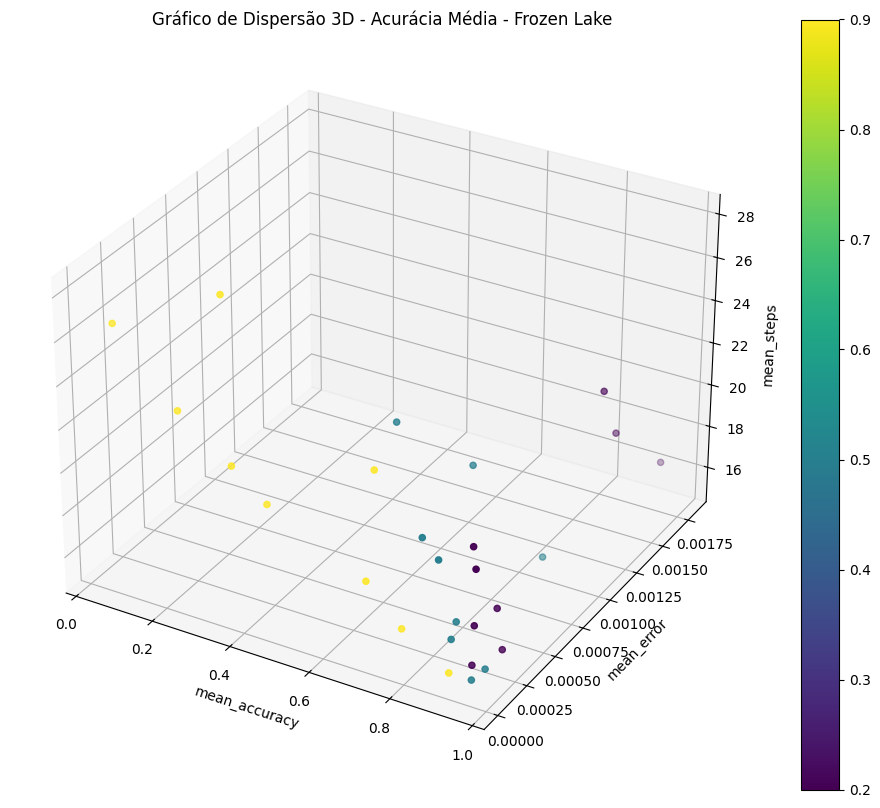

In [245]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["alpha"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Alpha')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [250]:
df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.0, 0.04, 0.06, 0.06, 1.0, 1.0, 1.0, 0....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [14, 30, 27, 58, 34, 13, 5, 59, 26, 4, 12, 7, ...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.3716    0.000015       21.91

In [252]:
df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.2  [0.02, 0.0, 0.04, 0.0, 0.06, 1.0, 1.0, 1.0, 1....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [42, 5, 13, 24, 5, 28, 3, 8, 5, 78, 99, 100, 1...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9512    0.000045     15.2337

In [253]:
df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.5  [0.02, 0.0, 0.04, 0.06, 1.0, 1.0, 1.0, 1.0, 1....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [42, 5, 13, 53, 7, 2, 8, 16, 57, 5, 79, 8, 33,...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9612    0.000126     15.3581

In [254]:
df_q[df_q['mean_error'] == df_q['mean_error'].min()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.02, 0.0, 0.0, 0.0, 0.06, 1.0, 1.0, 1.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [2, 32, 3, 3, 21, 36, 8, 59, 4, 9, 16, 10, 15,...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         0.9408    0.000021     19.9709

In [256]:
df_q[df_q['mean_steps'] == df_q['mean_steps'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [0.02, 0.02, 0.04, 0.32, 1.0, 1.0, 1.0, 1.0, 1...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [15, 31, 2, 18, 24, 3, 16, 13, 11, 84, 8, 49, ...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0          0.964     0.00012      14.812

In [258]:
df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.5    0.5  [0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [3, 8, 23, 39, 12, 13, 27, 5, 31, 4, 4, 33, 36...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         0.9902     0.00015     16.5911

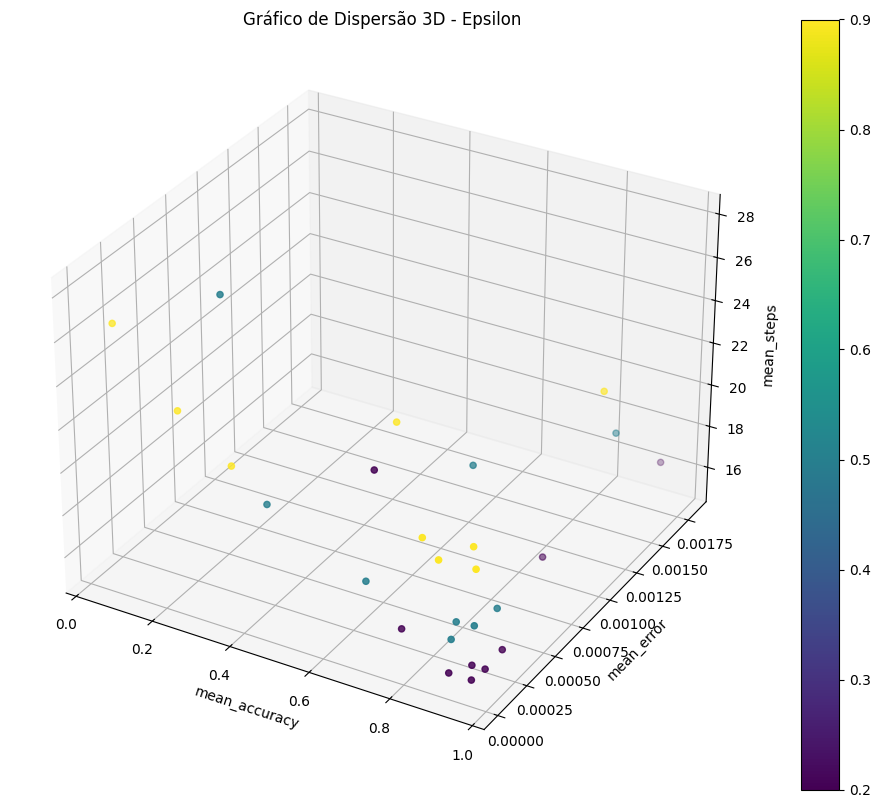

In [246]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["epsilon"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Epsilon')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

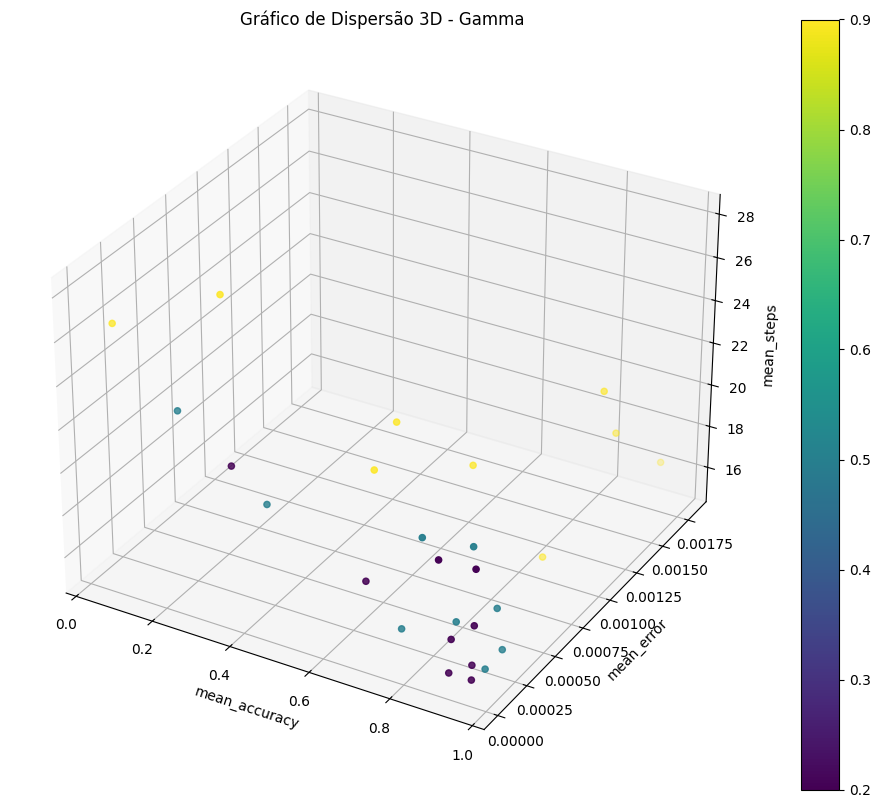

In [248]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["gamma"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Gamma')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

<Axes: xlabel='epsilon', ylabel='mean_steps'>

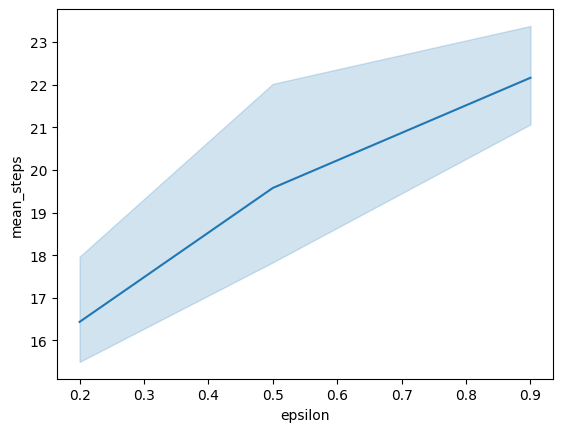

In [242]:
sns.lineplot(data=df_sarsa, x="epsilon", y="mean_steps")

<Axes: xlabel='gamma', ylabel='mean_steps'>

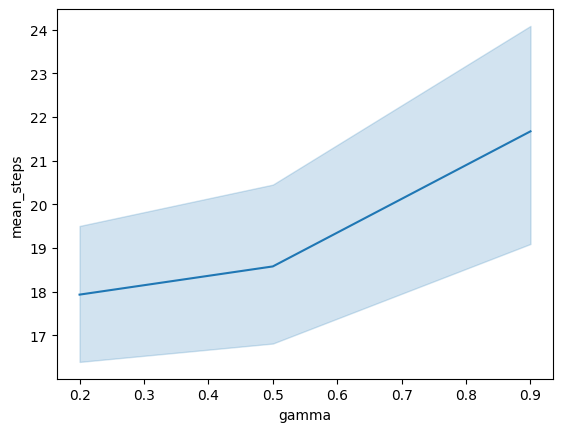

In [243]:
sns.lineplot(data=df_sarsa, x="gamma", y="mean_steps")

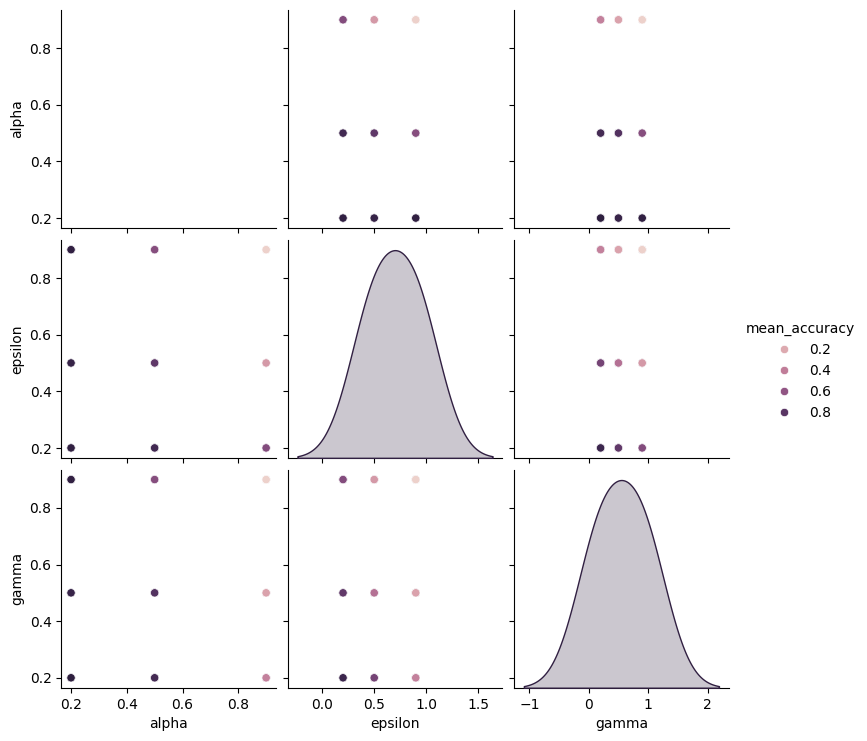

In [229]:
sns.pairplot(df_sarsa[["mean_accuracy", "alpha", "epsilon", "gamma"]], hue="mean_accuracy")

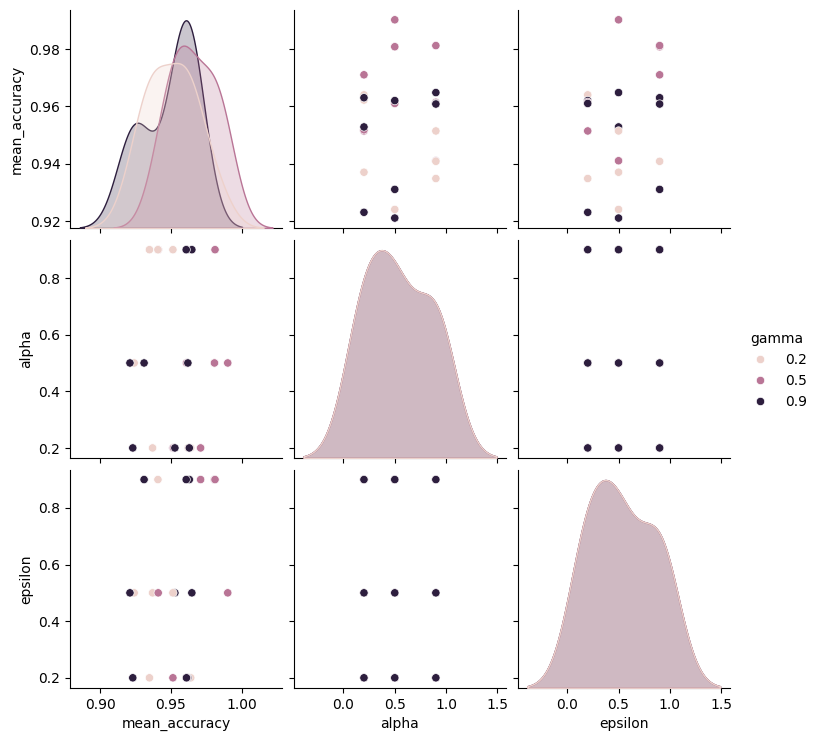

In [235]:
sns.pairplot(df_q[["mean_accuracy", "alpha", "epsilon", "gamma"]], hue="gamma")

In [200]:
df_q

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon                                           accuracy  \
0    0.4      0.4  [0.04, 0.0, 0.04, 0.04, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.4      0.5  [0.0, 0.02, 0.0, 0.04, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.4      0.6  [0.0, 0.0, 0.0, 0.04, 0.02, 0.06, 1.0, 1.0, 1....   
0    0.4      0.7  [0.02, 0.0, 0.04, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.5      0.4  [0.02, 0.0, 0.04, 0.06, 0.3, 1.0, 1.0, 1.0, 1....   
0    0.5      0.5  [0.02, 0.0, 0.04, 0.02, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.5      0.6  [0.0, 0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
0    0.5      0.7  [0.0, 0.0, 0.04, 0.04, 0.14, 1.0, 1.0, 1.0, 1....   
0    0.6      0.4  [0.0, 0.0, 0.04, 0.02, 0.0, 0.02, 1.0, 1.0, 1....   
0    0.6      0.5  [0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 1.0, 1.0, 1....   
0    0.6      0.6  [0.02, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
0    0.6      0.7  [0.0, 0.0, 0.02, 0.14, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.7      0.4  [0.02, 0.0, 0.04, 0.08, 0.54, 1.0, 1.0, 1.0, 1...   
0    0.7      0.5  [0.02, 0.02, 0.02, 0.02, 0.02, 0.22, 1.0, 1.0,...   
0    0.7      0.6  [0.02, 0.02, 0.42, 1.0, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.7      0.7  [0.0, 0.02, 0.0, 0.06, 1.0, 1.0, 1.0, 1.0, 1.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [2, 6, 11, 8, 17, 6, 67, 5, 48, 3, 22, 29, 32,...   
0  [8, 3, 13, 36, 7, 24, 27, 5, 7, 3, 5, 4, 15, 1...   
0  [2, 3, 14, 44, 11, 19, 12, 3, 13, 4, 5, 7, 3, ...   
0  [9, 3, 3, 13, 24, 8, 28, 4, 24, 23, 10, 2, 15,...   
0  [3, 18, 6, 6, 11, 6, 48, 3, 27, 17, 3, 3, 15, ...   
0  [3, 8, 2, 11, 66, 13, 2, 10, 9, 3, 4, 6, 78, 1...   
0  [2, 14, 45, 27, 14, 60, 43, 18, 6, 8, 12, 12, ...   
0  [5, 6, 2, 9, 15, 44, 22, 9, 19, 8, 7, 6, 13, 1...   
0  [3, 28, 24, 13, 10, 9, 7, 7, 14, 10, 21, 17, 3...   
0  [3, 11, 13, 32, 12, 7, 3, 17, 24, 5, 28, 2, 22...   
0  [5, 6, 15, 10, 14, 39, 12, 23, 2, 5, 7, 7, 43,...   
0  [12, 13, 46, 22, 3, 9, 10, 50, 11, 8, 80, 28, ...   
0  [2, 23, 11, 11, 26, 14, 7, 25, 6, 5, 5, 20, 29...   
0  [4, 25, 5, 27, 4, 7, 34, 17, 7, 6, 14, 19, 22,...   
0  [5, 5, 14, 11, 18, 24, 26, 23, 7, 6, 6, 20, 25...   
0  [27, 21, 44, 5, 17, 3, 8, 4, 18, 14, 14, 3, 27...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0

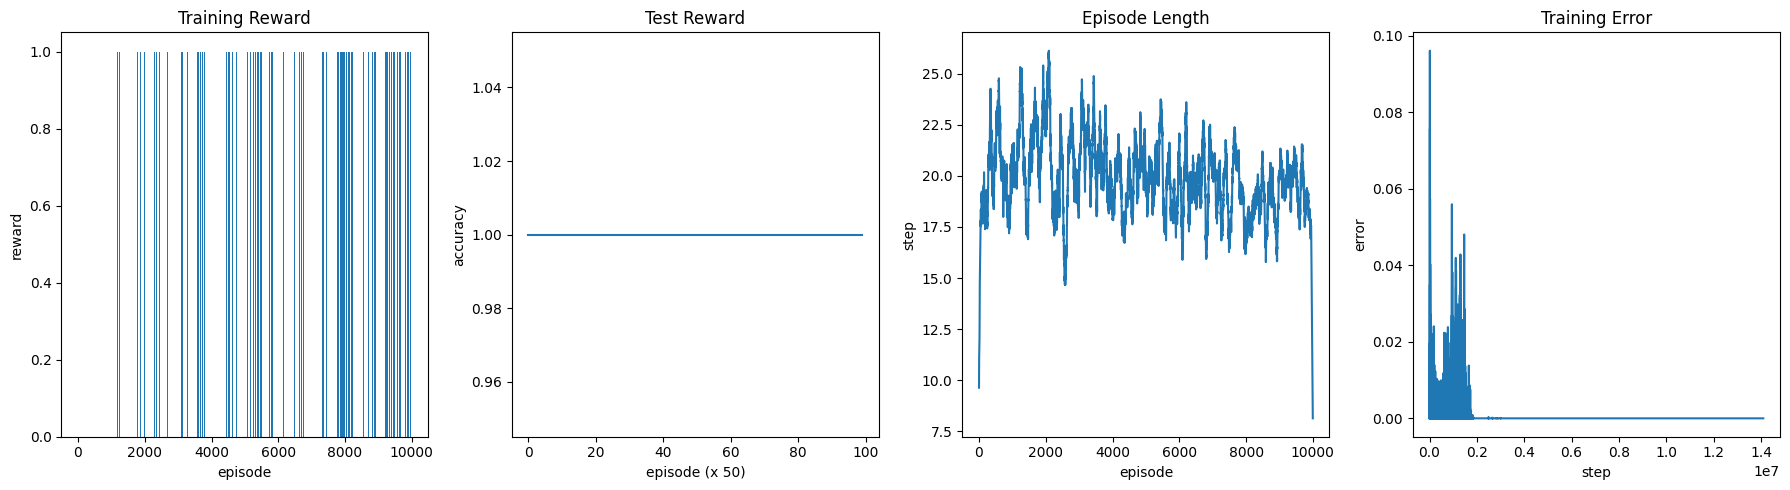

In [179]:
save_imgs(df_experiments.iloc[0].error, df_experiments.iloc[0].rewards, df_experiments.iloc[161].accuracy, df_experiments.iloc[161].steps,
          f'{df_experiments.iloc[161].agent}_{alpha}_{epsilon}.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [170]:
sum(df_experiments.iloc[1].accuracy)/len(df_experiments.iloc[1].accuracy)

1.0

<ipython-input-150-db9ebaf8bbe4>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],


alpha  epsilon                                           accuracy  \
0    0.1      0.1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                             rewards  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                               steps  \
0  [14, 15, 14, 14, 14, 17, 16, 15, 16, 6, 18, 18...   

                                               error          agent  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa

In [175]:
df_experiments.to_pickle('df_experiments.pkl')

In [126]:
after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
html_sarsa = render_mp4(after_training_sarsa)
HTML(html_sarsa)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

In [87]:
after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
html_q = render_mp4(after_training_q)
HTML(html_q)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 191/10000 [00:00<00:19, 494.61it/s]

step: 4609, episode: 100, accuracy training: 0.06, accuracy test: 0.54, random move probability: 0.49600000000000155
step: 7476, episode: 200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:15, 626.00it/s]

step: 10111, episode: 300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.48800000000000465
step: 12472, episode: 400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 590/10000 [00:00<00:12, 738.21it/s]

step: 14645, episode: 500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 16909, episode: 600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 801/10000 [00:01<00:14, 635.39it/s]

step: 19128, episode: 700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 21490, episode: 800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1024/10000 [00:01<00:12, 696.27it/s]

step: 23836, episode: 900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 26081, episode: 1000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:12, 730.07it/s]

step: 28231, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 30426, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1422/10000 [00:02<00:12, 679.68it/s]

step: 32624, episode: 1300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 34779, episode: 1400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:11, 728.19it/s]

step: 37066, episode: 1500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 39155, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1844/10000 [00:02<00:11, 727.72it/s]

step: 41308, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 43336, episode: 1800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:03<00:11, 705.65it/s]

step: 45486, episode: 1900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 47502, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2226/10000 [00:03<00:11, 700.25it/s]

step: 49723, episode: 2100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 51789, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:03<00:10, 733.72it/s]

step: 54076, episode: 2300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 56058, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2658/10000 [00:03<00:09, 772.51it/s]

step: 58142, episode: 2500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 60232, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2810/10000 [00:04<00:10, 656.66it/s]

step: 62345, episode: 2700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 64483, episode: 2800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:04<00:09, 728.45it/s]

step: 66574, episode: 2900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 68560, episode: 3000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:04<00:08, 768.53it/s]

step: 70531, episode: 3100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 72557, episode: 3200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3396/10000 [00:04<00:08, 824.53it/s]

step: 74507, episode: 3300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 76627, episode: 3400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▋      | 3635/10000 [00:05<00:08, 718.20it/s]

step: 78671, episode: 3500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 80673, episode: 3600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:05<00:08, 740.67it/s]

step: 82705, episode: 3700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 84664, episode: 3800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 779.36it/s]

step: 86554, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 88383, episode: 4000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4198/10000 [00:05<00:07, 813.13it/s]

step: 90343, episode: 4100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 92304, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4438/10000 [00:06<00:07, 749.25it/s]

step: 94224, episode: 4300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 96120, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:06<00:07, 707.14it/s]

step: 98110, episode: 4500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 100077, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:06, 768.74it/s]

step: 101903, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 103783, episode: 4800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30800000000007444


 51%|█████     | 5062/10000 [00:07<00:06, 767.36it/s]

step: 105688, episode: 4900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.304000000000076
step: 107552, episode: 5000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5216/10000 [00:07<00:06, 732.17it/s]

step: 109422, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 111243, episode: 5200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:07<00:05, 781.25it/s]

step: 113123, episode: 5300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 114908, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 819.91it/s]

step: 116671, episode: 5500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 118450, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:07<00:05, 809.37it/s]

step: 120227, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 122095, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6046/10000 [00:08<00:05, 782.41it/s]

step: 123881, episode: 5900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 125634, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6215/10000 [00:08<00:04, 807.55it/s]

step: 127394, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 129063, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6376/10000 [00:08<00:04, 737.85it/s]

step: 130760, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 132477, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6590/10000 [00:09<00:05, 594.91it/s]

step: 134214, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 136026, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6790/10000 [00:09<00:05, 573.45it/s]

step: 137797, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 139491, episode: 6800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6980/10000 [00:09<00:05, 573.02it/s]

step: 141258, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 142950, episode: 7000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7182/10000 [00:10<00:04, 609.77it/s]

step: 144616, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 146398, episode: 7200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7383/10000 [00:10<00:04, 606.32it/s]

step: 148138, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 149834, episode: 7400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7574/10000 [00:10<00:04, 567.16it/s]

step: 151471, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 153100, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7766/10000 [00:11<00:04, 547.05it/s]

step: 154783, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 156422, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8004/10000 [00:11<00:04, 498.98it/s]

step: 158100, episode: 7900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 159754, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:12<00:03, 482.52it/s]

step: 161457, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 163086, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8413/10000 [00:12<00:02, 597.09it/s]

step: 164736, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 166341, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:12<00:01, 725.57it/s]

step: 167939, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 169522, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814


 89%|████████▉ | 8888/10000 [00:13<00:01, 838.97it/s]

step: 171175, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 172757, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657


 91%|█████████ | 9058/10000 [00:13<00:01, 830.36it/s]

step: 174308, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 175918, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9227/10000 [00:13<00:00, 785.57it/s]

step: 177515, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 179030, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:13<00:00, 813.05it/s]

step: 180595, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 182152, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:13<00:00, 824.75it/s]

step: 183701, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 185296, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:14<00:00, 847.76it/s]

step: 186868, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 188387, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 692.52it/s]

step: 189878, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 191388, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [88]:
max(steps_sarsa)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

As métricas são apresentadas a seguir. Vê-se, conforme explicado acima, que a recompensa é 1 no objetivo final e 0 em outros passos. A diferença entre a abordagem SARSA e Q

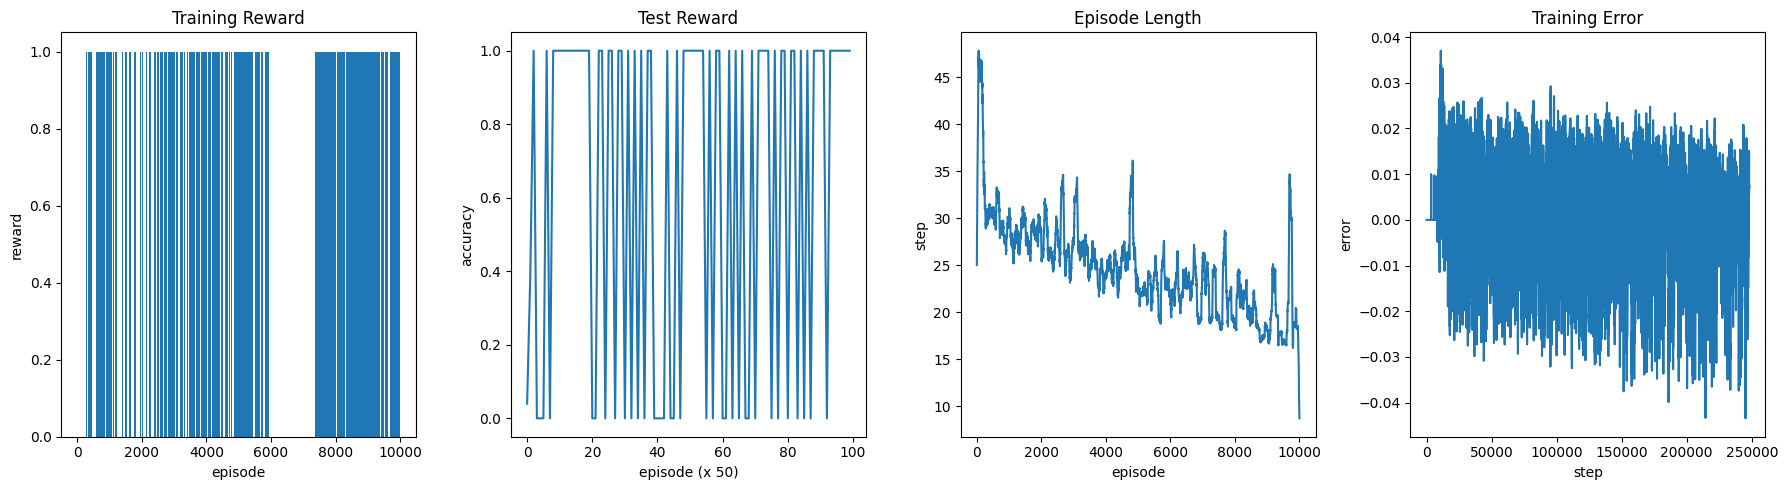

In [89]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_sarsa)), rewards_sarsa)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_sarsa)), accuracies_sarsa)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_sarsa), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_sarsa.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

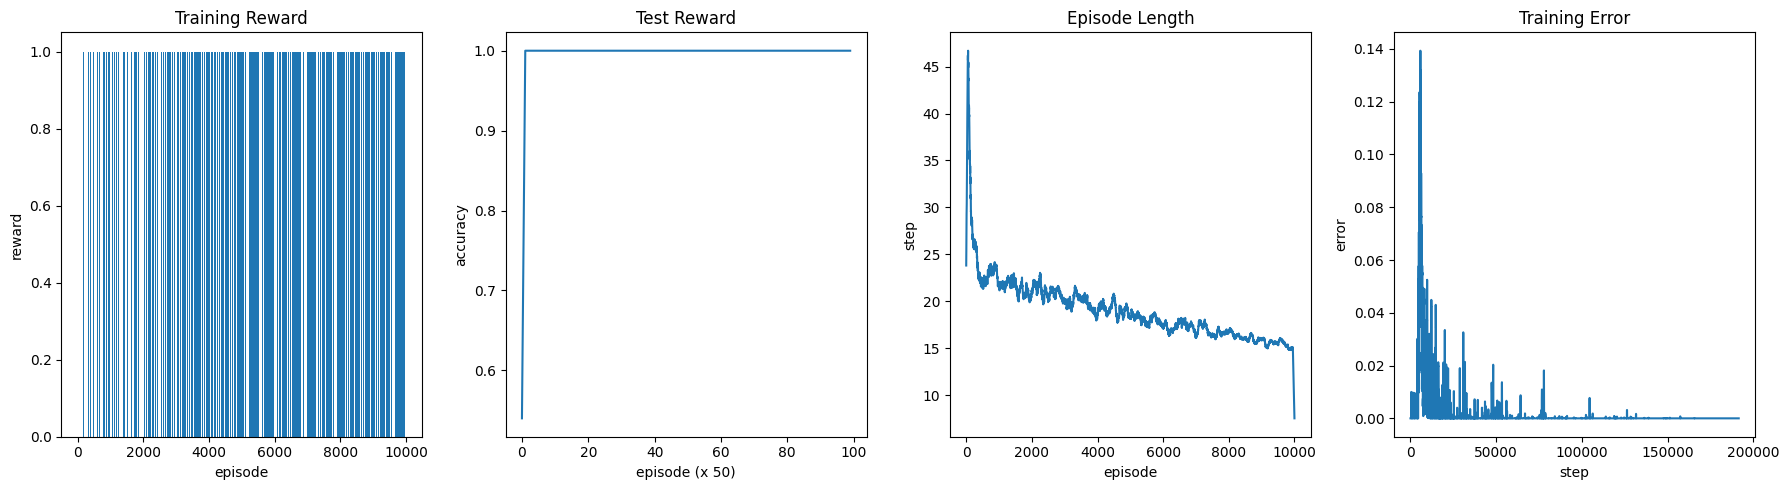

In [90]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_q)), rewards_q)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_q)), accuracies_q)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_q), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_q.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [91]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

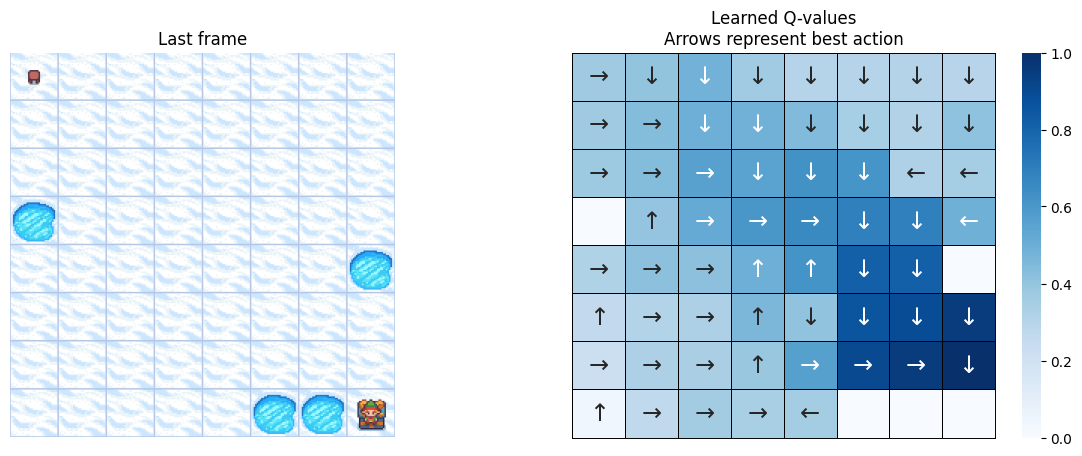

In [92]:
plot_q_values_map(agent_sarsa.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


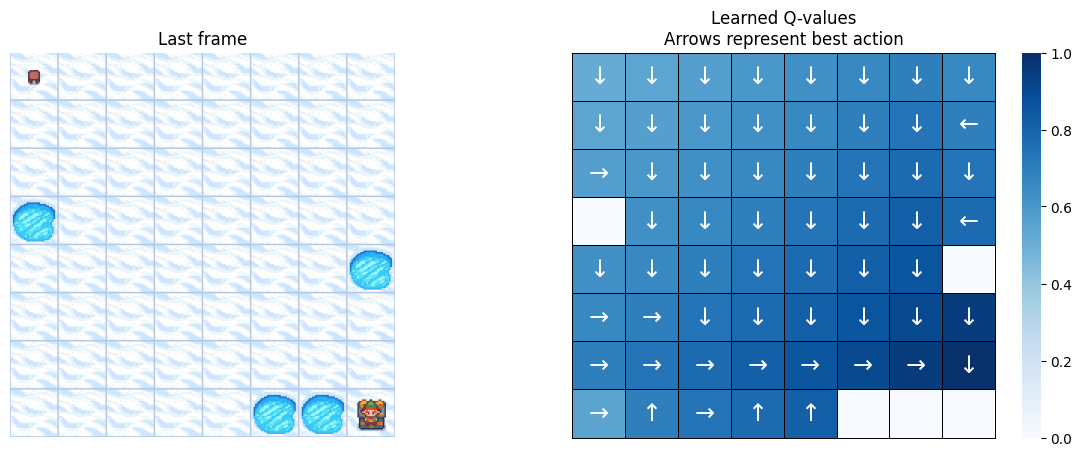

In [93]:
plot_q_values_map(agent_q.get_Q_Table(), env, side_map_size)

### Criando uma estratégia baseada em redes neurais PyTorch

A seguir, avaliamos o desempenho de um agente de Aprendizado por Reforço que utiliza uma rede neural.

In [94]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [96]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()
        self.input_layer = nn.Linear(state_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    def forward(self, state):
        x = self.input_layer(state)

        x = torch.sigmoid(self.hidden_layer(x))

        return self.output_layer(x)

In [97]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [98]:
# hyperparameters
alpha_learning_rate = 0.0001 # @param {type:"number"}
nb_max_episodes = 3000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.n, hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 64 , Hidden = 64 , output = 4
Q-learning agent started


In [99]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter


def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()


In [100]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  3%|▎         | 101/3000 [00:11<13:39,  3.54it/s]

step: 5703, episode: 100, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 203/3000 [00:18<03:16, 14.20it/s]

step: 10005, episode: 200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.47333333333333627


 10%|█         | 306/3000 [00:26<02:01, 22.09it/s]

step: 13455, episode: 300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4600000000000044


 13%|█▎        | 401/3000 [00:39<46:29,  1.07s/it]  

step: 16574, episode: 400, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 503/3000 [00:53<14:19,  2.91it/s]

step: 19046, episode: 500, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.4333333333333407


 20%|██        | 602/3000 [00:57<02:12, 18.03it/s]

step: 21571, episode: 600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4200000000000088


 23%|██▎       | 702/3000 [01:01<02:12, 17.32it/s]

step: 23802, episode: 700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40666666666667695


 27%|██▋       | 802/3000 [01:06<01:58, 18.55it/s]

step: 25946, episode: 800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3933333333333451


 30%|███       | 902/3000 [01:11<01:58, 17.67it/s]

step: 28150, episode: 900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3800000000000132


 33%|███▎      | 1000/3000 [01:18<06:11,  5.39it/s]

step: 30217, episode: 1000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.36666666666668135


 37%|███▋      | 1104/3000 [01:24<01:23, 22.83it/s]

step: 32266, episode: 1100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3533333333333495


 40%|████      | 1205/3000 [01:29<01:11, 24.98it/s]

step: 34306, episode: 1200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3400000000000176


 44%|████▎     | 1306/3000 [01:35<01:08, 24.62it/s]

step: 36241, episode: 1300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.32666666666668576


 47%|████▋     | 1407/3000 [01:39<00:56, 28.16it/s]

step: 38166, episode: 1400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3133333333333539


 50%|█████     | 1504/3000 [01:42<00:57, 26.02it/s]

step: 39948, episode: 1500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.300000000000022


 53%|█████▎    | 1601/3000 [01:49<04:19,  5.38it/s]

step: 41849, episode: 1600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.28666666666669016


 57%|█████▋    | 1704/3000 [01:52<00:53, 24.45it/s]

step: 43583, episode: 1700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2733333333333583


 60%|██████    | 1804/3000 [01:55<00:43, 27.43it/s]

step: 45477, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.26000000000002643


 63%|██████▎   | 1901/3000 [02:00<01:32, 11.86it/s]

step: 47210, episode: 1900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2004/3000 [02:06<00:36, 27.56it/s]

step: 49078, episode: 2000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.23333333333335923


 70%|███████   | 2102/3000 [02:09<00:37, 23.70it/s]

step: 50833, episode: 2100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2200000000000246


 73%|███████▎  | 2203/3000 [02:13<00:43, 18.14it/s]

step: 52624, episode: 2200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20666666666668995


 77%|███████▋  | 2304/3000 [02:18<00:28, 24.64it/s]

step: 54332, episode: 2300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1933333333333553


 80%|████████  | 2406/3000 [02:21<00:46, 12.79it/s]

step: 55980, episode: 2400, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.18000000000002067


 84%|████████▎ | 2507/3000 [02:24<00:16, 29.04it/s]

step: 57673, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2603/3000 [02:28<00:18, 21.02it/s]

step: 59312, episode: 2600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1533333333333514


 90%|█████████ | 2703/3000 [02:31<00:11, 25.03it/s]

step: 60889, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14000000000001675


 94%|█████████▎| 2805/3000 [02:34<00:06, 29.21it/s]

step: 62450, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1266666666666821


 97%|█████████▋| 2906/3000 [02:37<00:03, 28.73it/s]

step: 64055, episode: 2900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [02:40<00:00, 18.70it/s]

step: 65589, episode: 3000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10000000000001544



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [101]:
html = render_mp4(after_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analisamos as métricas da execução de um Agente de aprendizado por reforço com rede neural. Percebe-se que o comprimento dos episódios decresce em uma taxa superior àquelas observadas em abordagens tradicionais. Ademais, o erro de treinamento é muito inferior aos observados anteriormente.

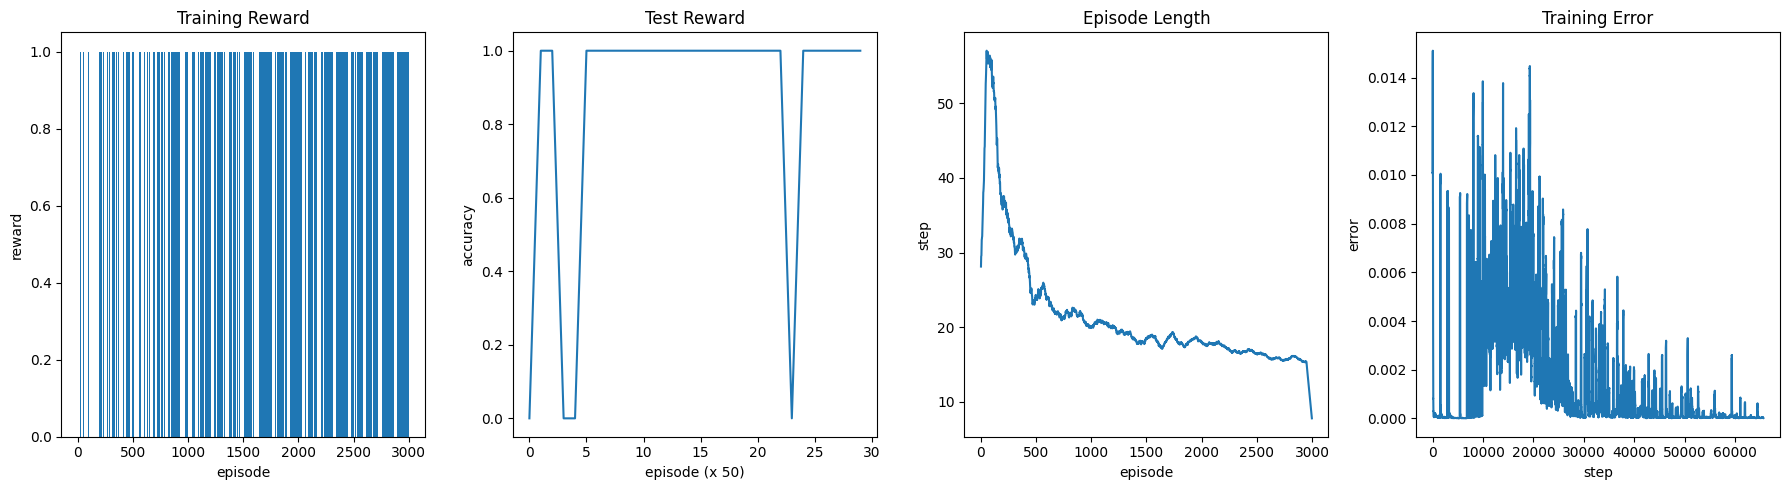

In [102]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [103]:
def qtable_directions_map(qtable_val_max, qtable_best_action, map_size):
    """Get the best learned action & map it to arrows."""
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [104]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

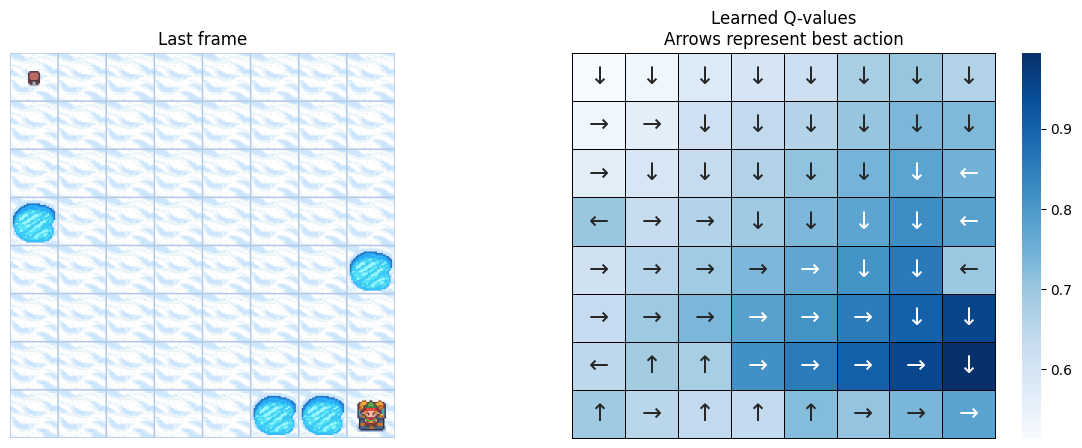

In [105]:
qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)

## `Cart Pole`

O Cart-Pole em controlar um carrinho que pode se mover para a esquerda ou para a direita em uma pista reta, com o objetivo de equilibrar um pêndulo invertido  conectado ao carrinho por uma articulação.

O agente precisa aprender a aplicar forças ao carrinho para manter o pêndulo em pé e evitar que ele caia, enquanto também mantém o carrinho dentro dos limites da pista. O agente deve decidir, com base no estado do sistema, quais ações tomar em cada instante para maximizar a recompensa acumulada.


In [106]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.spec

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [108]:
actions = ["push cart to the left", "push cart to the right"]
print ("Actions:", actions)

Actions: ['push cart to the left', 'push cart to the right']


Uma rede neural simples com uma camada com função de ativação sigmoide é criada.

In [115]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state variable)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.relu(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

In [116]:
class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: np.array,
        action: int,
        reward: float,
        terminated: bool,
        next_state: np.array,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)
        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [117]:
# hyperparameters
alpha_learning_rate = 0.0003 # @param {type:"number"}
nb_max_episodes = 2000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.99 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.shape[0], hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 4 , Hidden = 64 , output = 2
Q-learning agent started


In [118]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [119]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  5%|▌         | 107/2000 [00:02<00:47, 40.06it/s]

step: 1298, episode: 100, accuracy training: 12.98, accuracy test: 10.08, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:05<00:50, 35.49it/s]

step: 3083, episode: 200, accuracy training: 17.85, accuracy test: 12.48, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:08<00:59, 28.40it/s]

step: 4759, episode: 300, accuracy training: 16.76, accuracy test: 9.46, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:11<00:49, 32.01it/s]

step: 6255, episode: 400, accuracy training: 14.96, accuracy test: 9.28, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:13<00:35, 41.69it/s]

step: 7709, episode: 500, accuracy training: 14.54, accuracy test: 10.1, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:17<00:46, 29.86it/s]

step: 10337, episode: 600, accuracy training: 26.28, accuracy test: 10.68, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:20<00:44, 29.14it/s]

step: 12194, episode: 700, accuracy training: 18.57, accuracy test: 23.1, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:28<01:38, 12.15it/s]

step: 15937, episode: 800, accuracy training: 37.43, accuracy test: 39.76, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [00:35<01:54,  9.61it/s]

step: 20290, episode: 900, accuracy training: 43.53, accuracy test: 74.68, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [00:43<02:05,  7.98it/s]

step: 24613, episode: 1000, accuracy training: 43.23, accuracy test: 82.12, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [00:55<03:36,  4.15it/s]

step: 31632, episode: 1100, accuracy training: 70.19, accuracy test: 114.68, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:11<03:58,  3.35it/s]

step: 40336, episode: 1200, accuracy training: 87.04, accuracy test: 115.3, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [01:24<04:18,  2.71it/s]

step: 47617, episode: 1300, accuracy training: 72.81, accuracy test: 109.56, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:41<02:13,  4.47it/s]

step: 57459, episode: 1400, accuracy training: 98.42, accuracy test: 141.24, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [02:04<04:57,  1.68it/s]

step: 71030, episode: 1500, accuracy training: 135.71, accuracy test: 149.12, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:29<01:06,  6.03it/s]

step: 85548, episode: 1600, accuracy training: 145.18, accuracy test: 10.5, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [02:44<01:40,  2.99it/s]

step: 94527, episode: 1700, accuracy training: 89.79, accuracy test: 107.98, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [03:00<00:32,  6.20it/s]

step: 103084, episode: 1800, accuracy training: 85.57, accuracy test: 95.44, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [03:18<00:46,  2.16it/s]

step: 113599, episode: 1900, accuracy training: 105.15, accuracy test: 102.76, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:44<00:00,  8.90it/s]

step: 127047, episode: 2000, accuracy training: 134.48, accuracy test: 426.52, random move probability: 0.10000000000002324



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 500 : push cart to the left , [1.7287912  0.34178716 0.02812556 0.2554747 ] , 1.0 , False , True , {}


In [122]:
html = render_mp4(after_training)
HTML(html)

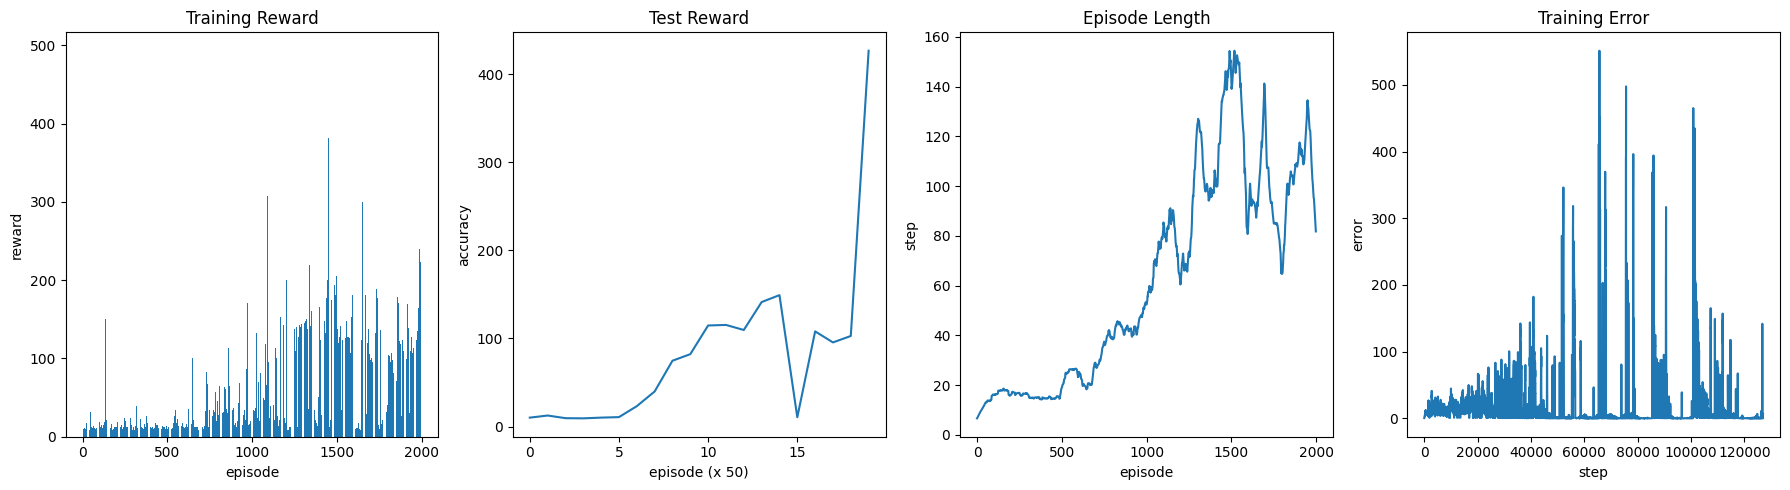

In [121]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [186]:
sum(steps) / len(steps)

63.5235